In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import emcee
import corner
from astropy import units as u
from scipy.optimize import root
from matplotlib import pyplot as plt


from load_mcxc_data import load_clusters
from statistics_functions import log_likelihood
from cluster_functions import funr, funr_new

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
clusters, variances=load_clusters(nrows=20)

In [3]:
T_data = [c.baryon_temp for c in clusters]

In [5]:
test_cluster=clusters[2]

Text(0, 0.5, 'f(Tb)')

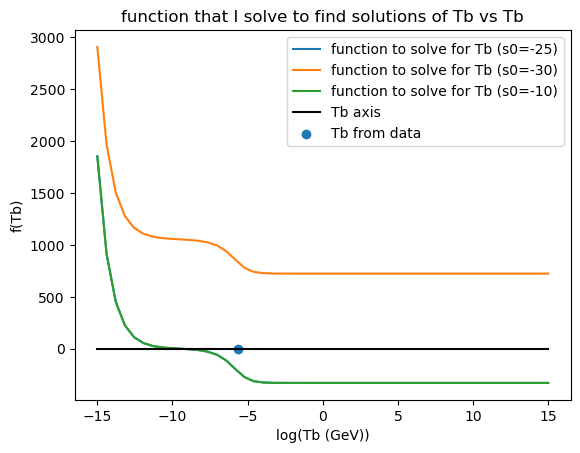

In [6]:
Tbs=np.linspace(-15, 15)
plt.plot(Tbs, funr_new(Tbs, test_cluster, [-25, -4]), label='function to solve for Tb (s0=-25)')
plt.plot(Tbs, funr_new(Tbs, test_cluster, [-31, -4]), label='function to solve for Tb (s0=-30)')
plt.plot(Tbs, funr_new(Tbs, test_cluster, [-10, -4]), label='function to solve for Tb (s0=-10)')
plt.plot(Tbs, Tbs*0, label=("Tb axis"), c='k')
plt.scatter(np.log10(test_cluster.baryon_temp.value), 0, label='Tb from data')
#plt.ylim(-500, 500)
plt.title('function that I solve to find solutions of Tb vs Tb (n=0)')
plt.legend()
plt.xlabel("log(Tb (GeV))")
plt.ylabel("f(Tb)")

Text(0, 0.5, 'f(Tb)')

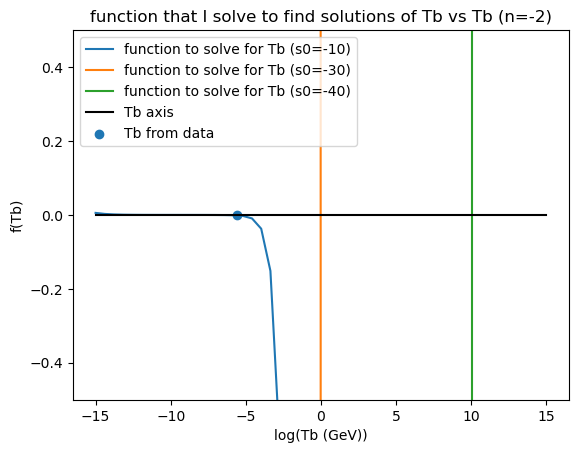

In [29]:
Tbs=np.linspace(-15, 15)
plt.plot(Tbs, funr_new(Tbs, test_cluster, [-10, -4], n=-2), label='function to solve for Tb (s0=-10)')
plt.plot(Tbs, funr_new(Tbs, test_cluster, [-30, -4], n=-2), label='function to solve for Tb (s0=-30)')
plt.plot(Tbs, funr_new(Tbs, test_cluster, [-40, -4], n=-2), label='function to solve for Tb (s0=-40)')
#plt.plot(Tbs, funr_new(Tbs, test_cluster, [-45, -4], n=-2), label='function to solve for Tb (s0=-45)')
#plt.plot(Tbs, funr_new(Tbs, test_cluster, [-50, -4], n=-2), label='function to solve for Tb (s0=-50)')
plt.plot(Tbs, Tbs*0, label=("Tb axis"), c='k')
plt.scatter(np.log10(test_cluster.baryon_temp.value), 0, label='Tb from data')
plt.ylim(-0.5, 0.5)
plt.title('function that I solve to find solutions of Tb vs Tb (n=-2)')
plt.legend()
plt.xlabel("log(Tb (GeV))")
plt.ylabel("f(Tb)")

In [16]:
from cluster_functions import c
from astropy import constants as const
def test_func(log_T_b, cluster, p0, f_chi=1, n=-2):
    T_b = 10**log_T_b * u.GeV
    sigma0 = np.float128(10 ** p0[0]) * u.cm**2
    m_chi = 10 ** p0[1] * u.GeV

    m_b = cluster.m_b
    rho_chi=cluster.rho_dm*f_chi
    rho_b=cluster.rho_b

    pref=6.8*1e-42 *u.erg*u.cm**3
    n_b=cluster.n_e
    Z=1

    T_chi=cluster.virial_temperature(m_chi)
    uth=(T_chi / m_chi + T_b / m_b)**(1/2)

    frac1=((m_chi+m_b)**2/(3*rho_chi*m_b*sigma0*c(n))).to(u.m) #factors coming from cooling term
    #print(frac1)
    frac2=(pref*n_b*Z**2/const.h).to(1/u.s, equivalencies=u.temperature_energy()) #factors coming from heating term
    #print(frac2)
    T_terms=(uth ** (-(n+1)) * (T_chi-T_b)/(T_b**(1/2)*((1e8*u.K*const.k_B).to(u.GeV))**(1/2)))
    #print((frac1*frac2)/const.c)
    return T_terms, (frac1*frac2)/const.c

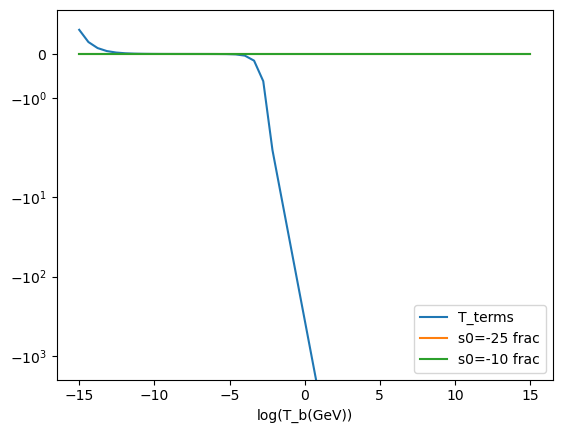

In [35]:

plt.plot(Tbs, test_func(Tbs, test_cluster, [-25, -2])[0], label='T_terms')

plt.plot(Tbs, -test_func(Tbs, test_cluster, [-25, -2], n=-2)[1]*np.ones(Tbs.size), label='s0=-25 frac')
#plt.plot(Tbs, -test_func(Tbs, test_cluster, [-29, -2], n=-2)[1]*np.ones(Tbs.size), label='s0=-29 frac')
plt.plot(Tbs, -test_func(Tbs, test_cluster, [-10, -2], n=-2)[1]*np.ones(Tbs.size), label='s0=-10 frac')
#plt.plot(Tbs, -test_func(Tbs, test_cluster, [-15, -2], n=-2)[1]*np.ones(Tbs.size), label='s0=-15 frac')
#plt.plot(Tbs, -test_func(Tbs, test_cluster, [-31, -2], n=-2)[1]*np.ones(Tbs.size), label='s0=-31 frac')
#plt.plot(Tbs, -test_func(Tbs, test_cluster, [-32, -2])[1]*np.ones(Tbs.size), label='s0=-32 frac')

plt.ylim(-2000, 1)
plt.legend(loc='lower right')
plt.xlabel("log(T_b(GeV))")
plt.yscale('symlog')

In [52]:
ndim, nwalkers = 1, 10
p0=np.zeros((nwalkers, ndim ))
log_sigma0 = np.random.uniform(low=-40, high=0, size=nwalkers).astype(np.float128)
p0[:,0]=log_sigma0
p0

array([[-37.12345361],
       [-36.6143725 ],
       [ -1.96469707],
       [-36.20730969],
       [ -0.23835704],
       [-31.70568221],
       [-34.6654246 ],
       [-10.96200653],
       [ -4.34073706],
       [-12.31448713]])

In [55]:
m_chi=-2
n=-2
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[T_data, variances, clusters, 'pred_T_b_1', m_chi, n])

In [56]:
state = sampler.run_mcmc(p0, 100, progress=True)
sampler.reset()

[-37.12345361] 6.651900014040802e+16
[-36.6143725] 5.745852473519509e+16
[-1.96469707] 7.174342582275611e+16
[-36.20730969] 5.0690787805328504e+16
[-0.23835704] 7.174342582275611e+16
[-31.70568221] 4114170286697461.0
[-34.6654246] 2.8899789214037572e+16
[-10.96200653] 7.1743425822752584e+16
[-4.34073706] 7.174342582275611e+16
[-12.31448713] 7.1743425822676264e+16


  0%|                                                   | 0/100 [00:00<?, ?it/s]

[-36.04855036] 4.816619940603256e+16
[-27.69206515] 6306415317797623.0
[-55.11310494] 8.123907416144782e+17
[-24.01820446] 5.054639258468157e+16
[-39.86609576] 1.2673998145982035e+17
[-3.51934735] 7.174342582275611e+16


  1%|▍                                          | 1/100 [00:01<02:53,  1.75s/it]

[-56.12704123] 8.790777516326775e+17
[-37.01079151] 6.445674284942855e+16
[-59.71009033] 1.1358062514124362e+18
[-48.05212765] 4.209228136412441e+17
[-21.19804906] 7.16823656121267e+16
[-11.29124783] 7.174342582274856e+16
[-32.27297115] 7128652302023337.0
[-20.31937344] 7.173534942146998e+16
[-0.25144619] 7.174342582275611e+16


  2%|▊                                          | 2/100 [00:04<03:39,  2.24s/it]

[-37.77266414] 7.903537926023968e+16
[-37.44464133] 7.25765297164365e+16
[-33.55620092] 1.6985152333605452e+16
[-37.33359537] 7.045237695603024e+16
[-49.42817966] 4.8720575766470906e+17
[-2.0035992] 7.174342582275611e+16
[-23.65954259] 5.86812201589733e+16
[-26.34752656] 1.6280730292394026e+16


  3%|█▎                                         | 3/100 [00:06<03:44,  2.31s/it]

[-38.0461555] 8.463092976546027e+16
[-35.08632535] 3.424470008545062e+16
[-9.8873096] 7.174342582275584e+16
[-36.31140689] 5.238114205075175e+16
[-28.19609994] 3767830189097404.5
[-10.73523823] 7.1743425822754024e+16
[-31.7885972] 4503392429127884.0
[-31.5483616] 3424016826766598.5
[-27.7120071] 6193611416618792.0


  4%|█▋                                         | 4/100 [00:09<04:03,  2.54s/it]

[-29.43735921] 288547610774958.8
[-25.92106042] 2.045300794605501e+16
[-16.76944593] 7.1743423546031016e+16
[-33.88460199] 2.0184631504998252e+16
[-48.2828293] 4.3169745714402246e+17
[-35.40498537] 3.859274758519562e+16
[-10.43254571] 7.174342582275508e+16
[-36.20326834] 5.062572253342683e+16
[-31.18578645] 2074556980321621.5


  5%|██▏                                        | 5/100 [00:12<04:02,  2.56s/it]

[-33.04054661] 1.2518097469405702e+16
[-21.08955383] 7.169585968102168e+16
[-30.71841577] 831250289319996.8
[-27.49041619] 7504362987048586.0
[-14.02647068] 7.174342581864145e+16
[-35.22726609] 3.613576515699848e+16
[-36.65674791] 5.818741134788776e+16
[-7.58881919] 7.174342582275611e+16
[-32.33123091] 7484854581242391.0
[-32.68372798] 9825249578680852.0


  7%|███                                        | 7/100 [00:17<04:07,  2.66s/it]

[-52.00045463] 6.241011921828115e+17
[-44.89943883] 2.87325136841044e+17
[-30.46593889] 392094193028082.75
[-19.53757245] 7.174209096870753e+16
[-27.55357803] 7117913466497947.0
[-33.26385284] 1.4369064350551958e+16
[-20.4284467] 7.173304371904966e+16
[-29.80618201] 14405040911664.143
[-27.90764004] 5141030348695027.0
[-27.90397967] 5159824450648022.0
[-9.41732758] 7.174342582275603e+16
[-31.26937994] 2355849469918287.5
[-31.20586208] 2140480402388037.0
[-34.59395265] 2.8037201127548532e+16
[-34.95963879] 3.2588260508019404e+16
[-39.28240574] 1.1231174547851558e+17
[-7.20039473] 7.174342582275611e+16
[-15.35594095] 7.174342573489322e+16
[-27.22130779] 9265741484728586.0


  8%|███▍                                       | 8/100 [00:20<04:10,  2.73s/it]

[-24.78405195] 3.494147115670107e+16
[-27.66130744] 6482398689362303.0
[-30.16039076] 78733404245604.14
[-19.04871069] 7.1742992736620904e+16
[-28.4329661] 2799505570872618.5
[-32.69838939] 9929479578187042.0
[-19.74337144] 7.174128179327962e+16
[-40.40577117] 1.408557341797544e+17
[-7.65035083] 7.174342582275611e+16
[-24.65795543] 3.706829964538717e+16


  9%|███▊                                       | 9/100 [00:23<04:16,  2.82s/it]

[-20.95969965] 7.170815015477241e+16
[-14.56560468] 7.174342580851747e+16
[-30.44974106] 369486811016426.3
[-23.71846014] 5.743666868840448e+16
[-30.07197767] 32615695410720.72
[-28.80932964] 1556218563415760.5
[-36.88446031] 6.218289701346489e+16
[-42.33909259] 1.9753964622222448e+17
[-31.54705764] 3418561073289365.5
[-12.09455502] 7.1743425822708e+16


 10%|████▏                                     | 10/100 [00:26<04:11,  2.79s/it]

[-23.6117563] 5.964878429976274e+16
[-30.39515986] 298249366527491.7
[-12.1853578] 7.174342582269682e+16
[-28.03935559] 4487573344335126.5
[-38.13124169] 8.641079570380155e+16
[-18.25762796] 7.174335575915502e+16
[-34.51347612] 2.708157985023548e+16
[-34.11965016] 2.264402437814993e+16


 12%|█████                                     | 12/100 [00:32<04:17,  2.92s/it]

[-29.73754207] 39067075626790.34
[-17.86820083] 7.174339724254563e+16
[-30.69860901] 790903495428889.5
[-37.90616581] 8.174287640242678e+16
[-20.50443025] 7.17310588352792e+16
[-22.09249453] 7.1265913442216664e+16
[-31.16488509] 2007017675248347.8
[-26.61710204] 1.3902440035060044e+16
[-8.47754631] 7.1743425822756104e+16
[-30.17987214] 91583990977000.48
[-33.93690597] 2.0719679918501484e+16
[-28.69747824] 1887858395758252.5


 13%|█████▍                                    | 13/100 [00:35<04:15,  2.94s/it]

[-29.71150692] 51574471356537.125
[-33.4570886] 1.607374278958965e+16
[-18.18896783] 7.174336600469343e+16
[-29.32446833] 442023156506091.0
[-26.92177718] 1.1445752783493766e+16
[-28.71331546] 1838955606857604.0
[-21.81211931] 7.149263736190327e+16
[-30.11767956] 53957580106066.414
[-31.99458827] 5546489532745964.0
[-19.56843203] 7.174199266792111e+16
[-26.48764869] 1.5020240492076748e+16
[-26.34249606] 1.6326971427160612e+16


 14%|█████▉                                    | 14/100 [00:38<04:18,  3.00s/it]

[-9.48656092] 7.1743425822756024e+16
[-26.42807849] 1.5549642462840732e+16
[-29.96267287] 3245889892592.227
[-18.87522849] 7.174313535867743e+16
[-32.00296677] 5591214093940349.0
[-31.14986345] 1959167976294004.5
[-29.49800777] 219559303078749.0
[-21.37767819] 7.165110375145462e+16


 15%|██████▎                                   | 15/100 [00:41<04:07,  2.91s/it]

[-19.64769079] 7.174170573277996e+16
[-32.89827442] 1.140534806246389e+16
[-14.00093155] 7.174342581887645e+16
[-30.61208614] 626423066758504.8
[-30.04510835] 22562607834124.227
[-28.38406659] 2987647996448166.0
[-29.5118168] 205166674857935.94
[-30.73438214] 864504761725421.4
[-26.40012801] 1.5801330244281078e+16
[-22.22556467] 7.109557332873279e+16
[-32.46719388] 8349916873005677.0
[-17.65169023] 7.1743408462551096e+16
[-36.44953396] 5.466687989365378e+16
[-29.48311339] 235630041814276.8
[-29.03807545] 977657635808184.1
[-28.64568327] 2052274605715528.2
[-31.34476926] 2624866812815741.5
[-23.68415331] 5.8167917659905016e+16
[-16.36994581] 7.174342491533168e+16
[-29.99734955] 9253014861561.592


 17%|███████▏                                  | 17/100 [00:47<03:59,  2.89s/it]

[-25.51706978] 2.492209335315485e+16
[-32.42168332] 8055090790933689.0
[-23.37559557] 6.378278159054406e+16
[-30.15773288] 77055449816056.97
[-20.29624063] 7.1735768338099976e+16
[-27.25954302] 9004129553574703.0
[-37.0801611] 6.572269776339805e+16
[-30.23155555] 130381068907722.95
[-32.96918822] 1.195351102844695e+16
[-29.89307055] 473003014209.753
[-24.51813751] 3.962953724645388e+16
[-20.63589791] 7.172668716756395e+16
[-30.1407714] 66773112964334.516
[-28.80590808] 1565888871069676.0
[-29.24734843] 565613131633509.5
[-29.09868211] 846800963812904.2
[-29.31497073] 456422126955056.6
[-30.79565601] 998179064213336.9
[-18.27254336] 7.174335331109574e+16
[-30.09832007] 44264719348280.695


 18%|███████▌                                  | 18/100 [00:49<03:53,  2.85s/it]

[-28.54179552] 2402744866581608.5
[-29.93301255] 548797074655.2812
[-30.0501896] 24322124501226.715
[-29.30311192] 474724840965186.7


 19%|███████▉                                  | 19/100 [00:52<03:46,  2.80s/it]

[-24.48598049] 4.0251199910344376e+16
[-25.0837591] 3.0448400202784216e+16
[-30.92571524] 1313746877013760.5
[-23.74014978] 5.696556331433113e+16
[-29.13806314] 766810045858224.9
[-30.36273404] 259537296117553.94
[-25.79061936] 2.183649029764268e+16
[-30.09034241] 40549462858890.484
[-30.05138388] 24745261652475.273
[-26.45966637] 1.5267733800662988e+16
[-29.59074325] 132267498777109.27
[-28.02279749] 4567278687113558.0
[-29.95386454] 2209972923572.614
[-31.73070861] 4229796777209755.0
[-23.66843538] 5.84968752401749e+16
[-28.98052427] 1110616304574209.6


 20%|████████▍                                 | 20/100 [00:55<03:43,  2.80s/it]

[-29.70873421] 53008667822381.555
[-29.34858984] 406490754250437.2
[-18.81630457] 7.1743172211455144e+16
[-30.14928443] 71841853323550.66
[-29.94975092] 1794181992948.4692
[-28.52855432] 2449399010300091.0
[-25.16490303] 2.9340271492200132e+16
[-30.12162461] 56050382148189.25
[-27.57510199] 6988560037895301.0
[-26.23877826] 1.7295824917159706e+16


 22%|█████████▏                                | 22/100 [01:01<03:41,  2.85s/it]

[-29.27304463] 522742835834462.4
[-25.22219156] 2.858064340920656e+16
[-29.62511205] 105504300436082.6
[-20.49801122] 7.173124026690975e+16
[-29.79258833] 18331990293606.523
[-29.76216052] 28835452399889.19
[-29.87735697] 1561904824902.797
[-28.92424503] 1248831840145488.5
[-27.24400821] 9109967265463872.0
[-33.2070947] 1.3886508662877934e+16
[-28.93413846] 1223947587157336.8
[-24.16714413] 4.7064564162762184e+16
[-29.89396221] 430153849867.6948
[-29.93523093] 672647165617.0388
[-27.31430005] 8636026914323291.0
[-27.70613691] 6226710920655110.0
[-25.13321866] 2.9768300535456636e+16
[-30.36414822] 261169540898759.25
[-29.35031766] 404002695729084.2
[-29.86574904] 2771991629547.4746


 24%|██████████                                | 24/100 [01:06<03:37,  2.86s/it]

[-29.74252881] 36869316333188.27
[-25.0158986] 3.140684368074358e+16
[-29.89392739] 431788821020.14124
[-29.71737349] 48604789526087.53
[-29.81655668] 11726091190696.705
[-28.7038444] 1868123567834224.0
[-28.18509123] 3816326735238227.0
[-21.83517129] 7.147899027529988e+16
[-25.10574221] 3.0144274358892064e+16
[-29.86660614] 2670853768680.2026
[-29.64413576] 91989738770695.95
[-23.77535442] 5.618772933935724e+16
[-28.33185411] 3195292646547155.5
[-28.24651294] 3549709490335376.0
[-27.9042744] 5158309903379005.0
[-28.96254771] 1153883872981632.2
[-29.95569655] 2409080415249.279
[-21.88488407] 7.144698476333238e+16
[-29.84270291] 6196090914278.058
[-29.53319619] 183846105603717.97


 25%|██████████▌                               | 25/100 [01:09<03:33,  2.84s/it]

[-23.2346981] 6.5699815100870584e+16
[-23.40595058] 6.331567005719804e+16
[-29.89233587] 509836763735.1718


 26%|██████████▉                               | 26/100 [01:12<03:28,  2.82s/it]

[-31.4091712] 2866193435890608.5
[-29.60920496] 117515580685389.83
[-34.18681827] 2.3372795019306484e+16
[-29.94848708] 1675131103348.542
[-29.52879668] 188137945981182.1
[-29.03118198] 993136674298328.0
[-28.97349295] 1127441451379948.2
[-29.31941388] 449657298180121.9
[-29.58436905] 137563342257125.64
[-22.69194923] 6.9871212784655384e+16
[-29.87647693] 1641568912217.8467
[-29.92909066] 360646753945.4483
[-30.27638525] 169567925173470.5
[-23.08006568] 6.735364547553895e+16
[-29.86397506] 2987289304506.2446
[-30.18619606] 95964218634641.33
[-29.09997864] 844104284358127.5


 28%|███████████▊                              | 28/100 [01:17<03:20,  2.78s/it]

[-29.5365771] 180581583492468.03
[-26.14336973] 1.8213439865023388e+16
[-29.70498632] 54978545837227.23
[-29.83368299] 7906220607407.975
[-28.48774202] 2596019942371502.5
[-29.91723587] 31167009239.612923
[-25.11377194] 3.0033929112751556e+16
[-29.73811401] 38811778743162.15
[-28.87779431] 1369014220188181.5
[-30.0192112] 14621274674139.027
[-29.50267745] 214637678519893.8
[-30.52198745] 475501266091422.7
[-29.48530017] 233235006324680.72
[-30.21628296] 118205081786199.45
[-30.61330229] 628602260529943.9
[-23.73299158] 5.712175877281673e+16
[-27.44016021] 7819165699685201.0
[-29.9928775] 8305521156029.664


 29%|████████████▏                             | 29/100 [01:20<03:12,  2.71s/it]

[-29.06877472] 910199881812981.9
[-29.93399748] 602230647868.2549
[-30.21052893] 113772479705359.7
[-25.59889738] 2.39711615074272e+16
[-29.63888456] 95627703868619.94
[-29.87948847] 1377165831001.6313
[-29.93632001] 738057036938.9971
[-29.93471285] 642596711653.2706
[-27.65286618] 6531120377450280.0
[-29.87105758] 2175816794730.119
[-28.54894333] 2377746698940604.0
[-29.96057558] 2981230668432.7407


 31%|█████████████                             | 31/100 [01:25<03:02,  2.65s/it]

[-29.8367363] 7304024319405.956
[-30.20347439] 108453625332825.52
[-29.54148665] 175893104021063.72
[-30.36147816] 258092052551743.28
[-29.96528274] 3590948274844.0127
[-30.27292186] 166357209785457.56
[-24.10531737] 4.849740137353558e+16
[-26.1048036] 1.859165659175653e+16
[-29.81507738] 12091241378547.258
[-29.33684862] 423600307675675.75
[-26.20003891] 1.7665332320356658e+16
[-26.62184471] 1.3862332102389872e+16
[-29.89141258] 558084821908.6481
[-29.8804695] 1296044672618.871
[-29.21126132] 628671273338706.8
[-30.50241856] 445467191582113.8
[-29.92280933] 141286960317.72754
[-29.61925997] 109847876967654.75
[-32.76084064] 1.0379614582877428e+16
[-29.92073383] 90992252414.45253


 33%|█████████████▊                            | 33/100 [01:30<02:57,  2.64s/it]

[-23.80659766] 5.548517903335853e+16
[-29.81259123] 12717537155497.594
[-26.21044575] 1.7565657418445038e+16
[-29.75216924] 32800958833454.13
[-29.43229347] 294735770855523.06
[-30.80836982] 1027118650501360.2
[-30.35650824] 252412356120871.12
[-29.89779524] 269121651926.41876
[-33.48962764] 1.6370191780538198e+16
[-31.15283145] 1968576438863693.0
[-25.48314992] 2.532381785736154e+16
[-29.42138318] 308286439584329.3
[-29.89213954] 519913824918.64886
[-29.06961595] 908385343271764.1
[-29.74838716] 34368689993341.09
[-30.12615368] 58502100217790.34
[-29.91768729] 37128298624.970665
[-26.27981119] 1.690898607168033e+16
[-29.9648693] 3535125002148.488
[-29.96139141] 3082843640766.408


 35%|██████████████▋                           | 35/100 [01:36<02:53,  2.67s/it]

[-32.00196073] 5585834332684460.0
[-25.85435648] 2.1153821172248388e+16
[-29.93320267] 558918174998.1775
[-29.96409185] 3431335195533.463
[-29.28890911] 497118738630519.94
[-30.30321797] 195482890467927.62
[-30.77314992] 947963952867039.6
[-25.81958129] 2.152468469582599e+16
[-29.9425624] 1171518832882.568
[-29.42075857] 309071439348697.56
[-33.04753905] 1.2574122358510798e+16
[-29.66613161] 77517917254042.89
[-25.41612429] 2.6131310255587124e+16
[-30.97060819] 1432719350030901.2
[-28.99977991] 1065187275754767.5
[-29.9195833] 67859986266.45391
[-25.41560803] 2.613760270650343e+16


 36%|███████████████                           | 36/100 [01:39<02:53,  2.70s/it]

[-29.89362513] 446113044479.1516
[-29.93279515] 537337340855.19714
[-29.71331438] 50650143653587.91
[-26.92832798] 1.139559137245622e+16
[-29.89638392] 324041637585.0
[-29.805737] 14526110182504.953
[-29.81353843] 12477059761435.477
[-29.83113032] 8427983194889.699
[-30.09380142] 42140358094376.62
[-29.18987309] 667617354300775.6
[-22.80913324] 6.930980019294367e+16
[-29.82202604] 10424641586802.783
[-29.93526768] 674804701097.8794


 38%|███████████████▉                          | 38/100 [01:44<02:45,  2.68s/it]

[-30.00520296] 11040738756433.064
[-26.33296] 1.6414817754532504e+16
[-29.83259019] 8127546640131.878
[-29.88637386] 859820379537.4576
[-29.97062916] 4352226099400.513
[-30.03881249] 20474126030986.008
[-25.30914004] 2.7460455151290148e+16
[-29.84936717] 5066287689427.723
[-29.90308484] 108624356602.98611
[-29.81669374] 11692541374320.709
[-30.00508153] 11011897453602.037
[-29.918768] 53517995071.02446
[-23.84853748] 5.4526737703626856e+16
[-29.93614514] 727350286531.7542
[-29.79762252] 16822589586725.69
[-29.79161792] 18630399756301.832
[-27.28550506] 8828638461821676.0
[-29.89099737] 580493053946.871
[-29.94953339] 1773399574880.3108
[-29.87129644] 2150687306430.812


 39%|████████████████▍                         | 39/100 [01:47<02:42,  2.67s/it]

[-29.92467256] 195825078999.5686
[-29.86407708] 2974689382505.085
[-27.37882293] 8212172383173302.0


 40%|████████████████▊                         | 40/100 [01:49<02:41,  2.69s/it]

[-31.38364076] 2769256424807475.0
[-29.86979264] 2311332541108.35
[-30.00884867] 11924263038676.535
[-25.25528436] 2.814981402335205e+16
[-29.88750494] 786433486829.1912
[-31.85902306] 4847801888724312.0
[-29.93460352] 636342421262.5276
[-25.91454349] 2.0520873634093536e+16
[-29.88382135] 1037459497240.4244
[-29.88183868] 1186944151200.8445
[-29.81640617] 11762986909713.027
[-30.32873347] 221834293318787.8
[-30.18060206] 92084343183925.62
[-29.91520113] 10767698366.696873
[-29.8794584] 1379690568714.9443
[-28.53424435] 2429295751963940.0
[-29.94721765] 1559666503001.147


 42%|█████████████████▋                        | 42/100 [01:55<02:33,  2.65s/it]

[-29.53633508] 180814295345686.44
[-29.93264114] 529292082745.19867
[-29.87016113] 2271433446318.4863
[-29.94725654] 1563142351159.0664
[-29.92544983] 221201847895.2497
[-29.96357793] 3363577072668.2256
[-29.91220684] 11064170.454361508
[-26.84688514] 1.202715049085936e+16
[-28.59062011] 2234593125090192.8
[-29.76893269] 26292819522923.02
[-29.91974646] 70934460898.45935
[-27.45170397] 7746281975400890.0
[-28.49034001] 2586559493204834.0
[-29.86146638] 3305498424736.0425
[-29.96305926] 3295877288356.052
[-29.98312795] 6417249543315.548
[-29.87199654] 2077871312146.2373
[-29.91209745] 52394384.12121321
[-30.13749334] 64870767852232.5
[-29.92467358] 195857393593.42828


 43%|██████████████████                        | 43/100 [01:57<02:30,  2.64s/it]

[-29.94570407] 1427384066885.3162
[-29.91221328] 9586486.27250496
[-30.49072877] 427993298874072.2
[-29.93128575] 461105928076.595
[-30.35209452] 247421264455775.78
[-28.4333713] 2797972105880490.5
[-29.89847764] 244394393806.28903
[-28.0994388] 4204247314235509.0
[-29.92091658] 94978334573.44884
[-29.91519186] 10698981144.767935


 45%|██████████████████▉                       | 45/100 [02:02<02:21,  2.58s/it]

[-29.91229087] 106244.54291538571
[-27.88218274] 5272450915097325.0
[-29.89881163] 232726576489.01855
[-29.1395549] 763857971687873.0
[-29.91697303] 27936152496.408813
[-29.93340657] 569875245043.676
[-29.6224097] 107499171659145.48
[-30.23946991] 136925494135818.42
[-29.93501497] 660036934025.7192
[-30.00344192] 10626136681560.434
[-30.53175905] 490865324597743.8


 46%|███████████████████▎                      | 46/100 [02:05<02:20,  2.59s/it]

[-28.00155627] 4670554978520006.0
[-29.89908959] 223233224365.784
[-29.94932213] 1753333018185.1902
[-30.06664449] 30473375939466.527
[-29.8953316] 368307481939.1887
[-28.8156086] 1538550367616425.0
[-29.9154292] 12527098892.631298
[-29.86899782] 2398578335791.5005
[-29.20770853] 635059540937480.8
[-29.93781653] 832888162206.4321
[-29.90043664] 180028246370.6027
[-28.9214694] 1255858151523250.0
[-29.84670292] 5504330025689.205
[-29.90008319] 190915445329.45178
[-29.91430763] 5156787397.123261
[-29.13432895] 774224666093051.8
[-29.90884637] 15256206893.256586
[-29.92298168] 145958885813.28256
[-30.01101452] 12465249851400.902


 48%|████████████████████▏                     | 48/100 [02:10<02:12,  2.55s/it]

[-29.93403829] 604498287818.2308
[-29.9052301] 63935618390.81456
[-29.33902556] 420401385421473.1
[-30.17460773] 88015666982495.77
[-30.0775673] 34939133859221.684
[-29.92066283] 89466701620.64493
[-28.48281486] 2614009472024925.0
[-29.89608934] 336147372323.50006
[-29.89432071] 413499204256.58386
[-30.34385424] 238236435325546.25
[-29.93728366] 798464648046.3108
[-29.95577164] 2417424924721.512
[-28.48592096] 2602661574162347.5
[-29.15966968] 724608444964327.9
[-29.92798827] 314845268398.7976
[-29.89224396] 514542002553.61096
[-30.01834004] 14383965530977.592
[-29.89924523] 218004174488.49854
[-29.98194345] 6204404782544.842
[-29.9079724] 23955144655.786625


 50%|█████████████████████                     | 50/100 [02:15<02:06,  2.54s/it]

[-29.91321561] 1072795245.3060635
[-28.80852352] 1558494188012894.0
[-29.88668981] 838991535663.9149
[-29.92436591] 186238688059.22293
[-29.98098905] 6035519108506.265
[-29.91806096] 42457313723.29866
[-29.17438986] 696541239253961.2
[-29.90561781] 57115446769.455795
[-30.34665068] 241333941831418.25
[-29.91506343] 9769854169.845558
[-29.91083921] 2729040720.076785
[-28.45577639] 2713835278567813.0
[-29.61715761] 111429698457322.45
[-29.88987572] 643232433750.6765
[-29.95208958] 2025256109239.895
[-29.8031202] 15248288377168.172
[-29.89992516] 195886670000.12872
[-29.92403317] 176108856637.54977
[-29.91879581] 53979257781.52958
[-29.85543607] 4136270544575.318


 51%|█████████████████████▍                    | 51/100 [02:18<02:05,  2.56s/it]

[-29.9194172] 64800271775.338554
[-29.28150003] 509005651267894.25
[-29.40314994] 331612033747956.4
[-29.89977246] 200750851161.89273


 52%|█████████████████████▊                    | 52/100 [02:20<02:03,  2.58s/it]

[-29.91788932] 39965170430.81584
[-30.1113163] 50665849910341.66
[-30.16361914] 80795836935927.98
[-29.91844819] 48356625442.51799
[-29.95632978] 2479898202213.4253
[-29.769203] 26193764474399.383
[-29.57169572] 148401455872346.75
[-29.89574844] 350434163391.47473
[-29.67457352] 72292396484475.33
[-29.87373584] 1902398570461.753
[-29.90341005] 101092624918.0662
[-30.01154609] 12599860466383.309
[-29.9133571] 1429912617.5422335
[-29.83548433] 7548062644084.047
[-29.93638125] 741825579210.6534
[-29.97674564] 5312842276403.3


 53%|██████████████████████▎                   | 53/100 [02:23<02:01,  2.58s/it]

[-29.92353002] 161328822606.87262
[-29.54333229] 174146523766970.7
[-29.91248293] 42891283.90915514
[-29.90307482] 108860709372.57352
[-29.8494875] 5046933593935.727
[-29.91329015] 1254548821.1539068
[-29.58012293] 141148814447409.88
[-29.90857706] 17728430770.637215
[-29.88524051] 936637572884.0054
[-29.92547949] 222200827894.05768


 55%|███████████████████████                   | 55/100 [02:28<01:55,  2.57s/it]

[-29.91645513] 22087269639.849842
[-29.49742048] 220182233173542.84
[-29.90070087] 172098110533.2616
[-29.95677092] 2529840686456.758
[-29.91522809] 10968724398.310116
[-29.91007237] 6346830476.969237
[-30.13353118] 62608113136874.04
[-29.68737467] 64716370105290.35
[-29.91383248] 3004875533.9711366
[-30.09601423] 43174141691133.664
[-29.52805315] 188868170301441.56


 56%|███████████████████████▌                  | 56/100 [02:31<01:53,  2.59s/it]

[-29.90712897] 34202917735.86421
[-29.54527935] 172313413183936.22
[-29.91170886] 446759566.60158885
[-29.91086557] 2631433570.210997
[-29.91394925] 3480158475.2494235
[-30.20406953] 108897419431544.72
[-29.92779168] 307004217648.04767
[-29.90836446] 19811148901.29715
[-29.91442918] 5800070787.339937
[-29.91245537] 30951497.331988692
[-29.91190825] 196145726.69026273
[-29.90773446] 26661854584.751945
[-29.91200468] 111442361.07253371
[-29.90647896] 43342487896.140465
[-29.73498169] 40220207959255.84
[-29.63411236] 98995022044824.02
[-29.91129321] 1296198505.0498815
[-29.90838039] 19651087431.79313
[-29.91450653] 6229095452.061761


 59%|████████████████████████▊                 | 59/100 [02:38<01:46,  2.60s/it]

[-29.91374955] 2688477811.3493247
[-29.73021566] 42411378320990.21
[-29.90885082] 15216959302.00875
[-29.91159054] 643564704.2030613
[-29.90934484] 11169954458.442778
[-29.99212706] 8151538683726.03
[-29.4985293] 219006867726803.97
[-29.91169303] 471012525.3440611
[-29.90684186] 38106539187.221535
[-29.91496118] 9060288726.287796
[-29.81448768] 12238366542192.893
[-29.90660505] 41485023708.755005
[-29.67012128] 75025599658017.88
[-29.91249229] 47383614.80412997
[-29.91738715] 33106634687.94575
[-29.91316284] 952721077.5814834
[-30.00048727] 9948348120872.312
[-29.90543565] 60271864936.443726
[-29.94539172] 1400814710003.7527
[-29.9084764] 18700113484.200153


 61%|█████████████████████████▌                | 61/100 [02:44<01:40,  2.59s/it]

[-29.91110741] 1818843014.4614813
[-29.90941412] 10652328709.944431
[-29.91423469] 4788916204.553698
[-29.88962488] 657703978813.5698
[-30.11380855] 51942758299135.04
[-29.91313298] 887945318.4692422
[-29.85857339] 3692442906430.4043
[-29.79568261] 17396552412549.242
[-29.903072] 108927259616.05006
[-29.90656941] 42005877559.84701
[-29.82827124] 9032167190000.09
[-29.90845293] 18930436336.980877
[-29.91240706] 14711514.50101525
[-29.90927752] 11684656859.282106
[-29.91562842] 14172846497.343477
[-29.91392678] 3385982877.535473
[-29.91226272] 1765222.5335422857
[-29.90982768] 7817842363.803766
[-29.8102523] 13321184236820.457
[-29.91261958] 130787790.2801746


 62%|██████████████████████████                | 62/100 [02:46<01:38,  2.59s/it]

[-29.9122135] 9538394.475538634
[-29.81547106] 11993518816837.965
[-29.91247303] 38376847.21071171
[-29.90523296] 63884026120.39249
[-29.91445635] 5949034985.086633
[-29.91240237] 13454406.883391803
[-29.90685968] 37858210087.24029
[-29.81911913] 11106820746075.51
[-29.91287732] 426613339.1040017
[-29.90920346] 12264303752.950043
[-29.84386476] 5990943429586.515
[-29.91188206] 223268452.87923986
[-29.91252026] 62155829.818240836
[-29.91344941] 1690514948.293217
[-29.90990058] 7363605112.738426
[-29.91243569] 23615584.520548254
[-29.91218677] 16355711.347679349


 63%|██████████████████████████▍               | 63/100 [02:49<01:35,  2.58s/it]

[-29.75543096] 31478314646533.355
[-29.90904036] 13590422308.849972
[-29.91333682] 1375587116.0039299
[-29.91240382] 13836473.300100792
[-29.91230037] 3896.400980428071
[-29.81536753] 12019179425125.35
[-29.91229881] 4852.491488415113
[-29.9312659] 460142339746.51746
[-29.91179611] 324585200.9415003
[-29.83192291] 8264193957824.378
[-29.92646038] 256506232823.4555
[-29.9124022] 13409569.31567848
[-29.90908651] 13208242476.639866


 65%|███████████████████████████▎              | 65/100 [02:54<01:29,  2.57s/it]

[-29.96682179] 3802598037961.5176
[-29.91222796] 6611845.327801416
[-29.91165224] 536457635.3058819
[-29.91513528] 10284483589.800793
[-29.91551128] 13192867766.670044
[-29.87082693] 2200222115739.2734
[-29.86102716] 3362866749268.3066
[-29.9118243] 289270722.51960075
[-29.90905409] 13476104725.99643
[-29.91185428] 253940190.16254935
[-29.91324037] 1131596408.1346014
[-29.91234666] 2808455.782374216
[-29.81894823] 11147598219393.637
[-29.91229831] 6498.542740873649
[-29.9076295] 27901838522.669544
[-29.91226834] 1272007.6914608004
[-29.87663144] 1627438598145.3044
[-29.91244693] 27684041.24838324
[-29.9095473] 9691760995.040216
[-29.9140527] 3930419169.5707045


 66%|███████████████████████████▋              | 66/100 [02:56<01:27,  2.56s/it]

[-29.91230148] 7013.216963022259
[-29.88700393] 818536363604.9802
[-29.88306193] 1093528030415.847
[-29.91281872] 344419247.6845082
[-29.90989424] 7402522471.405609
[-29.912402] 13356445.368619215
[-29.91232938] 1120808.2562761377
[-29.9120159] 103126778.21430455
[-29.90723533] 32810411609.816692
[-29.90302348] 110075709970.79034


 68%|████████████████████████████▌             | 68/100 [03:01<01:21,  2.55s/it]

[-29.91700857] 28362643556.134453
[-29.88453812] 985893516811.6902
[-29.90456345] 76562001332.16026
[-29.9110613] 1962238802.4389243
[-29.91242137] 18898170.410241667
[-29.93621153] 731406153300.5266
[-29.89135745] 561034712118.6729
[-29.91226776] 1319266.722245606
[-29.91109447] 1858532736.3997467
[-29.9138895] 3232602580.3664117
[-29.91262269] 133347744.8719024
[-29.88585531] 894558974074.021
[-29.89797676] 262427884335.85715
[-29.91098226] 2220677066.840302
[-29.91078549] 2933510787.8255496


 69%|████████████████████████████▉             | 69/100 [03:04<01:19,  2.55s/it]

[-29.90950767] 9972860466.597715
[-29.90942773] 10552055690.399487
[-29.91192629] 178491809.75363916
[-29.91351728] 1896012419.309092
[-29.91368949] 2470327717.1994457
[-29.91231438] 274141.67366763315
[-29.90039133] 181406198123.4879
[-29.88664698] 841800142422.075
[-29.9129594] 556503197.1653903
[-29.90999109] 6818462372.798108
[-29.91235162] 3434319.3323679394
[-29.90706532] 35050150715.094635
[-29.91443563] 5835222106.343309
[-29.91330775] 1299539787.5453808
[-29.91284117] 374875514.2509318


 70%|█████████████████████████████▍            | 70/100 [03:07<01:16,  2.55s/it]

[-29.91322923] 1104959050.9236262
[-29.91292346] 497508381.1227752
[-29.91171758] 433666170.7806489
[-29.91284703] 383027296.72656465


 71%|█████████████████████████████▊            | 71/100 [03:09<01:14,  2.56s/it]

[-29.91313781] 898266535.9530933
[-29.90363335] 96077815824.69626
[-29.91227948] 533327.884623556
[-29.88897616] 695875347743.6558
[-29.91015746] 5871213009.544954
[-29.91085827] 2658284740.883336
[-29.91185812] 249583345.2441248
[-29.91256737] 91563083.49403459
[-29.89997556] 194294381181.44342
[-29.89402582] 427174629576.92816
[-29.91194809] 158268250.31825852
[-29.91226739] 1349326.8939342839
[-29.92172737] 113693073022.8896
[-29.91051322] 4083160087.3948526
[-29.91012051] 6075490852.456473
[-29.91260329] 117800262.35949573


 72%|██████████████████████████████▏           | 72/100 [03:12<01:11,  2.55s/it]

[-29.91235426] 3792817.2590598627
[-29.88763604] 778139407832.0227
[-29.91228984] 131313.29199504512
[-29.91185586] 252151244.67062116
[-29.91150183] 814605465.2293855
[-29.91272927] 235912316.11284202
[-29.90253007] 122097211410.35123
[-29.91228573] 257886.6759000945


 73%|██████████████████████████████▋           | 73/100 [03:14<01:08,  2.54s/it]

[-29.91202055] 99774746.22089505
[-29.92366855] 165333494971.78494
[-29.90107399] 161203700382.25647
[-29.91230924] 116672.0612085051
[-29.9119617] 146255310.72775713
[-29.91188297] 222292096.58634248
[-29.91269052] 195253665.4569953
[-29.91248488] 43809253.5050216
[-29.92002527] 76345502479.51387
[-29.91241228] 16180157.271173306
[-29.89120492] 569237000751.9003
[-29.91281081] 334003088.6189603


 74%|███████████████████████████████           | 74/100 [03:17<01:06,  2.54s/it]

[-29.91232083] 567857.8769034174
[-29.90112861] 159638876948.20044
[-29.90218605] 130847300793.47098
[-29.91223571] 5263608.713766294
[-29.91150029] 817748990.7450091
[-29.90768591] 27231921564.768993
[-29.91226462] 1589358.2409589642
[-29.91214116] 32207152.975922033
[-29.91248855] 45562068.00983383
[-29.9125775] 98628623.36148514


 76%|███████████████████████████████▉          | 76/100 [03:22<01:00,  2.54s/it]

[-29.91234961] 3173656.216207476
[-29.9008785] 166867362024.66837
[-29.91227666] 690024.8212864726
[-29.91243175] 22266143.927944604
[-29.91270292] 207848730.21604803
[-29.90920398] 12260235588.983906
[-29.90269085] 118111595648.20271
[-29.9097475] 8333176145.586514
[-29.91222878] 6461098.97621441
[-29.9115363] 745749010.6847099
[-29.91211031] 45948639.78834745
[-29.90177482] 141704142815.82022
[-29.91209373] 54342704.70825304
[-29.91212074] 41033212.269374825
[-29.91238362] 8985249.660623118
[-29.91231836] 442952.2562223661
[-29.91228712] 210257.36419441286
[-29.8964257] 322342530197.3565
[-29.91152523] 767531572.026399
[-29.91248284] 42846575.54431112


 77%|████████████████████████████████▎         | 77/100 [03:24<00:58,  2.55s/it]

[-29.91227932] 541641.9930157589
[-29.90315812] 106903630361.82063
[-29.91230294] 15866.77553074778
[-29.91167288] 502810340.68238044


 78%|████████████████████████████████▊         | 78/100 [03:27<00:56,  2.56s/it]

[-29.91463522] 6976829016.943002
[-29.91229384] 49415.913719222044
[-29.90089354] 166428139498.1149
[-29.91226239] 1796377.0659200507
[-29.91261596] 127841982.75608967
[-29.91243767] 24307935.627176873
[-29.91231301] 225778.7601341492
[-29.91686916] 26708092580.390873
[-29.91224604] 3705369.5614966564
[-29.91242054] 18642064.36131264
[-29.9125306] 68124570.46939285
[-29.91230482] 35342.353316896486
[-29.90173928] 142662833340.2176
[-29.91226129] 1903833.2733823084
[-29.90669926] 40123884397.305664
[-29.91207361] 65468366.143547915


 80%|█████████████████████████████████▌        | 80/100 [03:32<00:51,  2.55s/it]

[-29.91230589] 50482.24701396864
[-29.90585531] 53127408986.89058
[-29.91570379] 14821974510.61518
[-29.91200768] 109183746.3541956
[-29.91261827] 129715948.26000126
[-29.9124159] 17235825.700504508
[-29.91156369] 693196644.6227144
[-29.90756643] 28660475389.152622
[-29.91231111] 166203.84039653296
[-29.91244502] 26969986.97648429
[-29.9091188] 12944152751.908115
[-29.91219171] 14957016.628690701
[-29.91247541] 39440320.230942816
[-29.91217673] 19387963.150684793
[-29.91253838] 72796229.30587675
[-29.91217384] 20307568.300210696
[-29.9112471] 1417658262.0497303
[-29.90297709] 111179560585.09587
[-29.91227125] 1048181.8390555272
[-29.91216091] 24690084.460829325


 81%|██████████████████████████████████        | 81/100 [03:35<00:48,  2.55s/it]

[-29.91232387] 742544.4144514252
[-29.90121753] 157107645085.59253
[-29.91232101] 577323.6184859573
[-29.90844092] 19048787408.488663
[-29.91217156] 21050471.124130547
[-29.91185476] 253398050.8867436
[-29.91668874] 24640544728.461433


 82%|██████████████████████████████████▍       | 82/100 [03:37<00:45,  2.55s/it]

[-29.91669724] 24736121825.967644
[-29.91238447] 9167595.962765668
[-29.91248246] 42669373.59987483
[-29.91232277] 676742.4570356247
[-29.91225087] 3069506.3407817297
[-29.91005815] 6428141480.334043
[-29.91224298] 4137663.0676896893
[-29.91260827] 121697090.58628409
[-29.91229268] 68925.7293154143
[-29.90672378] 39773311964.60937
[-29.91234432] 2535211.3194449274
[-29.91238417] 9101812.913268317
[-29.91260332] 117823267.76657744


 84%|███████████████████████████████████▎      | 84/100 [03:42<00:40,  2.56s/it]

[-29.9160963] 18437343529.833797
[-29.91223986] 4603956.995898019
[-29.91017679] 5765721145.315518
[-29.91220156] 12356897.39715348
[-29.9118956] 209030016.44743374
[-29.91229981] 3526.1990868183543
[-29.90627407] 46447385541.00919
[-29.91387868] 3188735335.3603177
[-29.91247697] 40143212.03766119
[-29.91252217] 63237741.7167963
[-29.9123452] 2636657.6400705446
[-29.91228723] 206479.6189960884
[-29.90363825] 95969141124.38954
[-29.91237] 6301088.692649109
[-29.91248157] 42254683.4004237
[-29.91229296] 63945.280982711345
[-29.9109325] 2391565785.949778
[-29.91222882] 6454337.616295358
[-29.91237265] 6785925.011108376
[-29.9121725] 20742587.662552137


 86%|████████████████████████████████████      | 86/100 [03:47<00:35,  2.55s/it]

[-29.9126507] 157482993.6325657
[-29.9122536] 2737559.146368106
[-29.9123836] 8980547.678307125
[-29.91220586] 11300027.212468253
[-29.91225369] 2726823.522239535
[-29.9123049] 36356.52745681402
[-29.90451178] 77588095130.30089
[-29.91160735] 613416544.8213246
[-29.91223303] 5711117.493267443
[-29.91264538] 152748074.39621997
[-29.91230314] 17494.725661602148
[-29.9082655] 20819995772.811234
[-29.9115194] 779122775.1080303
[-29.91230198] 9426.824749249388
[-29.91222197] 7758566.3890166115
[-29.91223687] 5074077.591407786
[-29.91028565] 5189600127.320736
[-29.91225329] 2774703.5939689092
[-29.91342208] 1611069085.884309
[-29.91216165] 24428078.700262494


 87%|████████████████████████████████████▌     | 87/100 [03:50<00:33,  2.55s/it]

[-29.91229908] 4249.346992284543
[-29.91177541] 351807547.632206
[-29.91229918] 4072.9347279216095
[-29.91225325] 2778480.10086221
[-29.91255467] 83078430.3723038
[-29.91231036] 145473.6333414229
[-29.9088355] 15352423504.605488
[-29.9122492] 3282795.13678216
[-29.91222869] 6478173.404146109
[-29.91211937] 41661012.324261636


 89%|█████████████████████████████████████▍    | 89/100 [03:55<00:27,  2.54s/it]

[-29.91011845] 6086990815.531846
[-29.91229886] 4722.5011259349185
[-29.91226184] 1849900.1445067758
[-29.91242702] 20697839.725031406
[-29.91214243] 31696901.636672776
[-29.91243014] 21724468.45282571
[-29.91239099] 10634383.333286472
[-29.91294481] 532140760.431607
[-29.91174563] 392888302.72174776
[-29.91219181] 14929729.242345871
[-29.91230036] 3889.988143365874
[-29.9122783] 596470.7405206658
[-29.91175672] 377320738.18912685
[-29.9122602] 2012765.5756797425
[-29.91217586] 19664115.137847196
[-29.91230881] 106729.44915212828
[-29.9090535] 13481006700.353907
[-29.9123024] 11948.797287347885
[-29.91250316] 52889125.65183779
[-29.91218445] 17032120.989001695


 90%|█████████████████████████████████████▊    | 90/100 [03:58<00:25,  2.55s/it]

[-29.90859695] 17539461360.039364
[-29.91259231] 109429399.81218044
[-29.9123245] 782299.7471353092
[-29.91219911] 12979932.488714805


 92%|██████████████████████████████████████▋   | 92/100 [04:03<00:20,  2.58s/it]

[-29.91228555] 264377.83347920096
[-29.91230148] 6994.216542620873
[-29.9122754] 767067.0562153001
[-29.91229204] 81086.51472909217
[-29.91199349] 120051094.20974115
[-29.91221107] 10082205.199097097
[-29.91224473] 3887962.025480143
[-29.91266726] 172697997.0155678
[-29.91226022] 2010609.365875036
[-29.91228894] 155107.2489745305
[-29.91219137] 15050746.694052225
[-29.91230083] 4800.66470641226
[-29.91227263] 949963.8017200853
[-29.91009602] 6212759576.75706
[-29.91229523] 30608.526432022976
[-29.91206524] 70400472.53128602


 93%|███████████████████████████████████████   | 93/100 [04:05<00:17,  2.57s/it]

[-29.91237194] 6654417.992596902
[-29.91062016] 3608987578.0168195
[-29.91230036] 3879.985876240312
[-29.91210016] 51003749.277803056
[-29.91232093] 572832.2664520564
[-29.91229907] 4260.999754491861
[-29.91374419] 2668650140.8730993
[-29.91226012] 2020425.9828153064
[-29.91229484] 35447.994329647394
[-29.91219343] 14485308.698619204
[-29.91139686] 1043007256.299497
[-29.91229888] 4691.163266481041
[-29.91231053] 149858.1368158923
[-29.91225446] 2636557.099487943
[-29.91234741] 2899665.706776207
[-29.91228833] 172844.9233091737
[-29.91230395] 25242.67594000172
[-29.91268381] 188607908.7053528
[-29.9119516] 155123539.83843076
[-29.91220836] 10707025.646616494


 94%|███████████████████████████████████████▍  | 94/100 [04:08<00:15,  2.56s/it]

[-29.91154048] 737601025.4138075
[-29.91231494] 295472.3373832971
[-29.91230605] 53019.89351258317
[-29.91229694] 14209.2333733382
[-29.91218887] 15752061.453326855
[-29.91243171] 22253016.588722467
[-29.91230078] 4670.151548279634
[-29.91200353] 112306822.35799003
[-29.91230043] 3979.5246583297794
[-29.91229117] 99396.5346766784


 96%|████████████████████████████████████████▎ | 96/100 [04:13<00:10,  2.59s/it]

[-29.91229936] 3803.4240749189826
[-29.91101218] 2120968383.831458
[-29.9123003] 3806.7391532973343
[-29.91228563] 261631.93040585885
[-29.91229639] 18686.56997742318
[-29.91229987] 3527.908702695284
[-29.91229987] 3528.2453704460604
[-29.91260137] 116318702.5090894
[-29.91230706] 70293.84275972191
[-29.91224804] 3434307.090743771
[-29.91219934] 12922461.029447444
[-29.91230013] 3642.432928951895
[-29.91230984] 131590.77246787044
[-29.91231706] 383418.38796510757


 98%|█████████████████████████████████████████▏| 98/100 [04:18<00:05,  2.56s/it]

[-29.91229574] 24924.29487931071
[-29.91225485] 2591379.5094390824
[-29.91229981] 3526.4255313212425
[-29.91180629] 311599196.94647586
[-29.91229977] 3531.30927249593
[-29.91221462] 9292577.781304218
[-29.91229495] 34052.47711367645
[-29.91230048] 4072.5636561944466
[-29.91216289] 23992589.968339715
[-29.9123009] 4984.916923001789
[-29.9122332] 5682256.516636263
[-29.91156349] 693578742.0305451
[-29.91210232] 49904205.007776715
[-29.91230032] 3838.213353346542
[-29.91230405] 26256.40639179598
[-29.91229347] 55274.020689191755


 99%|█████████████████████████████████████████▌| 99/100 [04:21<00:02,  2.56s/it]

[-29.91229985] 3526.3689925537174
[-29.91188428] 220902760.7019491
[-29.91230405] 26287.00705509456
[-29.91229579] 24365.811749390094
[-29.9123008] 4734.927669440105
[-29.91229978] 3529.454917922599
[-29.91232644] 909299.3711244229
[-29.91211124] 45500386.8277835
[-29.91210213] 49999104.94314535
[-29.91223563] 5276736.1617960865
[-29.91229872] 5110.0924863762375
[-29.9117236] 424744403.34470433
[-29.91210698] 47579389.21324116
[-29.91230195] 9278.4024727098
[-29.91229496] 33897.78488846667
[-29.91229995] 3543.122146044246
[-29.9122997] 3546.3168916429963
[-29.91264628] 153546200.9857145
[-29.9122968] 15239.467284769495
[-29.91221705] 8769366.867064629


100%|█████████████████████████████████████████| 100/100 [04:23<00:00,  2.64s/it]


In [57]:
sampler.run_mcmc(state, 1000, progress=True)

  0%|                                          | 1/1000 [00:02<43:18,  2.60s/it]

[-29.91182013] 294368883.4087436
[-29.91230154] 7284.079400705994
[-29.91236251] 5028603.280335642
[-29.9123005] 4090.7920916763314
[-29.91221383] 9465313.237133842
[-29.9124735] 38583588.20881629
[-29.91229984] 3525.9627367633034
[-29.91229645] 18138.985473809873
[-29.91224066] 4482416.649043371
[-29.9122915] 92385.34373127898
[-29.91229849] 5820.671921524659
[-29.91229985] 3526.5180746545902
[-29.91232109] 581901.7213714307
[-29.91212463] 39266759.998069525
[-29.91221808] 8551581.908281105
[-29.9119081] 196304590.200302
[-29.91230192] 9134.750409550226


  0%|                                          | 2/1000 [00:05<43:00,  2.59s/it]

[-29.91226487] 1567008.4460238207
[-29.91229599] 22371.66972690289
[-29.91222823] 6561130.899353386
[-29.91229995] 3543.3466989591157
[-29.91253115] 68454085.96823996
[-29.91225921] 2114183.093702522
[-29.91233516] 1599985.9350242994
[-29.9123004] 3942.1388619646627
[-29.91189361] 211091848.0796584
[-29.91229991] 3533.0280341674716
[-29.91230023] 3731.410007081531
[-29.91230718] 72579.42531636465
[-29.91227286] 934263.501471206


  0%|▏                                         | 4/1000 [00:10<42:28,  2.56s/it]

[-29.91229981] 3526.426773022426
[-29.91171541] 436917261.74266285
[-29.91230026] 3760.595808332558
[-29.91230488] 36093.668448481665
[-29.91227532] 771886.239831305
[-29.91217302] 20572705.541559838
[-29.91229668] 16244.895252369468
[-29.91226091] 1941509.173543177
[-29.91229822] 6836.057368492608
[-29.91230032] 3828.442562193746
[-29.91229912] 4172.228155149309
[-29.91229989] 3529.7409611056078
[-29.91225855] 2183591.573834238
[-29.91230122] 6005.785909926803
[-29.91227818] 603236.2338081944
[-29.91231813] 431863.95836633415
[-29.91192377] 180904829.8501342
[-29.91230276] 14527.384970043398
[-29.91230289] 15505.929920137352
[-29.91229672] 15938.536092489087


  1%|▎                                         | 6/1000 [00:15<42:21,  2.56s/it]

[-29.91229925] 3964.1136469692383
[-29.91229637] 18813.175322296578
[-29.91209132] 55619856.306698546
[-29.91229938] 3782.5244384674006
[-29.91225723] 2324605.668433715
[-29.91231182] 187274.91124425575
[-29.91227923] 546335.0360080266
[-29.91230036] 3890.7250586740106
[-29.91230218] 10615.035721807497
[-29.91225596] 2465677.5439108824
[-29.91219069] 15241263.507605009
[-29.91227923] 546183.7940332824
[-29.912304] 25784.948304966387
[-29.91229911] 4185.333859122477
[-29.91228976] 133366.74399407586
[-29.91229994] 3541.581068277038
[-29.91229965] 3567.259544544402
[-29.91234498] 2611239.0525513375
[-29.91229756] 10137.993904976576
[-29.91227832] 595382.5602873522


  1%|▎                                         | 8/1000 [00:20<42:08,  2.55s/it]

[-29.91230747] 78089.72783121854
[-29.91209641] 52937882.03394467
[-29.91229918] 4067.21420427197
[-29.91229898] 4452.383525008075
[-29.91227776] 626545.6037041743
[-29.91229948] 3680.867159077822
[-29.91230025] 3755.6119232460414
[-29.91227884] 567145.735313844
[-29.91230037] 3899.438230222114
[-29.91230391] 24834.498768910435
[-29.91222486] 7194196.58629362
[-29.91226338] 1703100.8419197993


  1%|▍                                        | 10/1000 [00:25<42:02,  2.55s/it]

[-29.91230002] 3572.9673513627836
[-29.91230038] 3908.236396365269
[-29.91227587] 737643.627573646
[-29.91229956] 3618.812390495615
[-29.91229774] 9123.392309685576
[-29.91232669] 926280.2219546706
[-29.91229584] 23860.813827578826
[-29.91230382] 23909.142173917437
[-29.91221772] 8628096.051412009
[-29.91229986] 3526.9315892061272
[-29.91228899] 153746.55342823287
[-29.91229981] 3526.2605698365014
[-29.91230023] 3734.4795932599436
[-29.91232295] 687196.8374355688
[-29.91229981] 3526.6059694129435
[-29.91230131] 6336.78955055817
[-29.91229884] 4774.347554608562
[-29.91228643] 233155.51898877637
[-29.91229871] 5144.305625016712
[-29.91230019] 3686.964839037204
[-29.91229989] 3530.3801525813337
[-29.91230195] 9265.306825199832
[-29.91228721] 207303.5794520582
[-29.91224498] 3851937.915247247
[-29.91228434] 310362.48349511303
[-29.91230383] 23963.54202059355
[-29.912305] 37665.80014043288
[-29.91230011] 3622.5995528511658


  1%|▍                                        | 12/1000 [00:30<41:56,  2.55s/it]

[-29.91233673] 1744873.906294553
[-29.91230056] 4209.630285023719
[-29.91230018] 3680.760270961803
[-29.91230356] 21333.872291988428
[-29.91228327] 354454.47257496044
[-29.91229911] 4190.19908579372
[-29.91223044] 6162614.151021059
[-29.91229265] 69460.13368551355
[-29.91229909] 4230.947160257077
[-29.91229321] 59545.81773013366
[-29.91229988] 3529.0734295079146
[-29.91232114] 584349.0369126064
[-29.91230123] 6021.275299311799
[-29.91229916] 4098.378766466517
[-29.91227254] 956342.203636909
[-29.91229974] 3536.956159038381
[-29.91229819] 6952.671611998325
[-29.91225512] 2560655.884729348
[-29.91230014] 3649.111001887129
[-29.9123004] 3934.8670514043197


  1%|▌                                        | 13/1000 [00:33<41:53,  2.55s/it]

[-29.91229976] 3532.1152823634393
[-29.91223535] 5321288.9536796305


  2%|▌                                        | 15/1000 [00:38<42:08,  2.57s/it]

[-29.91229663] 16639.91688191015
[-29.91229974] 3535.804646749525
[-29.91229079] 108092.57072376044
[-29.91230505] 38411.72342075018
[-29.9122995] 3663.8331835833887
[-29.91229817] 7046.988768543266
[-29.91229812] 7265.109424950511
[-29.91230296] 16066.525193719099
[-29.91230471] 34030.819664407194
[-29.9122402] 4552398.930459752
[-29.91229424] 43478.99836938907
[-29.91229982] 3526.131851935956
[-29.91229993] 3539.2271855425884
[-29.91229979] 3527.7561656930957
[-29.91229986] 3527.1566640104766
[-29.91230156] 7343.67740677757
[-29.91229941] 3754.30082329303
[-29.91228916] 149118.81340560663


  2%|▋                                        | 16/1000 [00:40<41:58,  2.56s/it]

[-29.91229986] 3526.649266337991
[-29.91227213] 984833.0445224243
[-29.91229884] 4791.286865378249
[-29.91230117] 5834.705704790722
[-29.91230051] 4122.135870263145
[-29.91229974] 3535.295850789667
[-29.91231427] 270157.33592353
[-29.91229936] 3803.965484325399
[-29.91229998] 3552.6241131748247
[-29.91229001] 126823.72806680077
[-29.91229986] 3526.934350563587
[-29.91226295] 1743519.5530606962
[-29.91229983] 3525.8478516510013


  2%|▋                                        | 17/1000 [00:43<41:54,  2.56s/it]

[-29.91230006] 3595.953514302611
[-29.91228825] 175176.83256614723
[-29.91229953] 3639.517332288241
[-29.9122964] 18590.122465015582
[-29.91229339] 56663.73374546473
[-29.91229925] 3952.397658698308
[-29.91229996] 3545.9139946232326
[-29.91225551] 2515769.463528741
[-29.91229985] 3526.3087925317177
[-29.91229401] 46850.18344953599
[-29.91229936] 3805.0199739491527
[-29.91229993] 3539.770582194601
[-29.91229974] 3537.4272607299695
[-29.9123029] 15566.54546523422
[-29.91229985] 3526.3641455150614
[-29.9123018] 8507.245248250314
[-29.91229286] 65722.45908066508


  2%|▊                                        | 19/1000 [00:48<41:37,  2.55s/it]

[-29.91229991] 3533.8916069743095
[-29.91226254] 1781969.2272276466
[-29.91229361] 52978.999579199764
[-29.91229984] 3526.0126163234363
[-29.91230026] 3759.966394665969
[-29.91229979] 3528.071049321383
[-29.912317] 380824.6091279364
[-29.91229949] 3670.846432427938
[-29.91230224] 10938.513380721397
[-29.91229336] 57025.03552978997
[-29.91229727] 11891.405403400007
[-29.91229911] 4192.981140264114
[-29.91230026] 3764.216873211646
[-29.91229942] 3743.8114758198294
[-29.91230002] 3573.14649825357
[-29.9122999] 3531.619976739756
[-29.91224588] 3726282.155569814
[-29.91229988] 3529.0709904274336
[-29.91229755] 10177.08131712347
[-29.91229477] 36281.204205899034


  2%|▊                                        | 21/1000 [00:53<41:32,  2.55s/it]

[-29.91230021] 3709.038468704961
[-29.91229826] 6682.305150387705
[-29.91230007] 3601.54344437903
[-29.91230034] 3855.7481416802416
[-29.91229999] 3558.735013510424
[-29.91229978] 3528.633220231055
[-29.91225225] 2899151.3968966175
[-29.91229981] 3526.561923534355
[-29.91229896] 4503.71541281526
[-29.91229644] 18198.552309430997
[-29.91229965] 3568.347354266656
[-29.91229999] 3557.1198507145577
[-29.9122997] 3547.5503518468895
[-29.9122916] 90095.40674108364


  2%|▉                                        | 22/1000 [00:56<41:27,  2.54s/it]

[-29.91229391] 48365.77139600882
[-29.91228597] 249370.70204174146
[-29.91229869] 5188.939820409182
[-29.91229961] 3589.3185753900775
[-29.91229904] 4317.008952711156
[-29.91229996] 3546.5959727352874
[-29.91229965] 3569.5306183819057
[-29.91230126] 6141.874060838475
[-29.91230004] 3583.180156635292
[-29.91229993] 3537.681922487018
[-29.91230703] 69856.38158163923
[-29.91229984] 3526.0839143965813
[-29.9122869] 217472.10035287417
[-29.91229785] 8533.452917228416
[-29.91229957] 3609.4703956815533
[-29.91229619] 20484.857538699933


  2%|▉                                        | 24/1000 [01:01<41:15,  2.54s/it]

[-29.91229973] 3538.312668942144
[-29.9123001] 3619.7008772149466
[-29.91229983] 3525.8562905896124
[-29.91230002] 3572.0556161090217
[-29.91229719] 12441.116789358648
[-29.91228632] 237119.586478538
[-29.91229982] 3525.986709770198
[-29.91230017] 3673.255665922924
[-29.91229966] 3563.141736241831
[-29.91229994] 3541.2852175778407
[-29.9122998] 3526.8024657332917
[-29.91229665] 16467.81847959275
[-29.91229763] 9697.273222876003
[-29.91229969] 3552.5703188992397
[-29.91229694] 14181.835647422266
[-29.91229987] 3527.935848349169
[-29.91229996] 3548.014181479408
[-29.91229014] 123690.30560688382
[-29.9122999] 3532.4268158143586
[-29.91230155] 7306.467654159584


  3%|█                                        | 26/1000 [01:06<41:38,  2.57s/it]

[-29.91229133] 96006.92315859381
[-29.91229981] 3526.574549961692
[-29.91229992] 3535.2411955063662
[-29.91229964] 3571.5655656681643
[-29.91229771] 9279.63655837858
[-29.91230045] 4016.626664513218
[-29.91229901] 4381.600226015414
[-29.91230013] 3639.596287546831
[-29.91229983] 3525.854308060657
[-29.91230208] 9980.165104251288
[-29.91229982] 3526.1280884958014
[-29.91230038] 3909.993740162188
[-29.91229955] 3626.8217478454526
[-29.91229995] 3544.9253392032037
[-29.91229689] 14574.983786434954
[-29.91229993] 3537.305514945699
[-29.91229982] 3525.9414615152646
[-29.91228809] 179930.19623927606
[-29.91229983] 3525.8647028460923
[-29.91230001] 3567.1944486480506


  3%|█▏                                       | 28/1000 [01:11<41:24,  2.56s/it]

[-29.91229363] 52652.98949023402
[-29.91229982] 3526.0997614021035
[-29.9122998] 3527.0670854442806
[-29.91229895] 4517.042820363227
[-29.91230146] 6930.055925162086
[-29.91229988] 3529.145711947343
[-29.91229982] 3525.9779628317183
[-29.91230007] 3598.5494003748126
[-29.91229972] 3540.7382028621396
[-29.91229848] 5855.9222229325715
[-29.91228778] 189285.93466977956
[-29.91229979] 3528.007479430849
[-29.91229979] 3528.282991301057
[-29.91229982] 3526.065327746447
[-29.91229777] 8936.093772008988


  3%|█▏                                       | 29/1000 [01:13<41:12,  2.55s/it]

[-29.91229994] 3540.195946147377
[-29.91229982] 3526.007781538902
[-29.91229964] 3570.597123760307
[-29.91229983] 3525.83250372675
[-29.91229988] 3528.4086557680826
[-29.91229979] 3527.619568169413
[-29.91229355] 53964.819692375255
[-29.91229962] 3582.6166253576184
[-29.91229991] 3533.838485632625
[-29.91229883] 4813.411081343401
[-29.91229993] 3539.694171158427
[-29.91229992] 3535.1483591346664
[-29.91229984] 3526.090488534218
[-29.91229711] 12960.487858427838
[-29.91229982] 3525.9797570554915


  3%|█▏                                       | 30/1000 [01:16<41:07,  2.54s/it]

[-29.91229983] 3525.8329316303757
[-29.91229234] 75260.5957010067
[-29.91229991] 3534.6630737581877
[-29.9123004] 3942.5549024300926
[-29.91229992] 3535.300183847592
[-29.9122999] 3531.738132558604
[-29.91230087] 4902.958396982294
[-29.91229981] 3526.5436632789083


  3%|█▎                                       | 31/1000 [01:19<41:02,  2.54s/it]

[-29.91229982] 3525.9129115546643
[-29.91229925] 3962.930648139911
[-29.91230001] 3566.5596669950232
[-29.91229989] 3529.9488371741895
[-29.91229706] 13345.170074505671
[-29.91230244] 12224.934195384929
[-29.91229936] 3808.527702183408
[-29.91229988] 3528.5192823997563
[-29.91229] 127021.16463354342
[-29.91229955] 3627.810116463324
[-29.91229988] 3529.0093434645114
[-29.91229975] 3534.036038370369


  3%|█▎                                       | 32/1000 [01:21<40:58,  2.54s/it]

[-29.91229998] 3553.5116019208635
[-29.91229984] 3525.8753874393997
[-29.91229295] 64003.14333536523
[-29.91229986] 3526.7040652754004
[-29.91229983] 3525.85687158885
[-29.91230016] 3668.3559703624123
[-29.91230183] 8638.016384758997
[-29.9122999] 3532.001964076707
[-29.91229981] 3526.4462535827097
[-29.9122996] 3596.616945651557


  3%|█▍                                       | 34/1000 [01:26<40:59,  2.55s/it]

[-29.91229983] 3525.86205530446
[-29.91229966] 3560.984935161515
[-29.91229797] 7967.581569306269
[-29.91229978] 3529.6178191229174
[-29.91229997] 3549.504891746912
[-29.91229984] 3526.0304797417434
[-29.91229172] 87754.08784981503
[-29.9122999] 3531.546840966787
[-29.9122998] 3526.8269772771846
[-29.91229956] 3621.048230419772
[-29.91229976] 3532.798955899946
[-29.91229967] 3560.408646826589
[-29.91229985] 3526.1821450340303


  4%|█▍                                       | 35/1000 [01:29<40:57,  2.55s/it]

[-29.91229974] 3535.932204285124
[-29.91229961] 3589.2358086022336
[-29.91229984] 3526.0412437957693
[-29.91229173] 87441.54837904642
[-29.91230007] 3598.0199903709517
[-29.91229986] 3527.226840452049
[-29.91229991] 3533.974597969832
[-29.91230172] 8090.390268955991
[-29.91229804] 7638.5737354359735
[-29.91229996] 3546.383206654857
[-29.91229988] 3528.773462435441
[-29.91229979] 3527.6321552628415
[-29.91229983] 3525.840387254858
[-29.91229091] 105257.93327517077
[-29.91229966] 3564.806763882294
[-29.91229978] 3528.638140082691
[-29.91229953] 3638.825539974757


  4%|█▌                                       | 37/1000 [01:34<40:48,  2.54s/it]

[-29.91229982] 3526.0090383381785
[-29.91229984] 3525.9621650027607
[-29.91228964] 136333.78056159886
[-29.9122997] 3546.8631018802853
[-29.91229984] 3526.021905317695
[-29.91229978] 3528.921792799839
[-29.91229993] 3539.194359285875
[-29.91229986] 3527.169849886343
[-29.91229982] 3526.111880716931
[-29.91229954] 3630.8240877531334
[-29.91229981] 3526.5754397669384
[-29.91229983] 3525.831786135035
[-29.91229985] 3526.343553643137
[-29.91229987] 3528.157081907433
[-29.91229982] 3525.996881935156
[-29.91229981] 3526.1630188387744
[-29.9122935] 54828.56060311423
[-29.91229977] 3530.9339543739284
[-29.91229965] 3565.53954627605
[-29.91229967] 3559.6613583265625


  4%|█▌                                       | 39/1000 [01:39<40:48,  2.55s/it]

[-29.91230073] 4563.3784293429835
[-29.91229968] 3553.926789199066
[-29.91229983] 3525.832265542327
[-29.91229921] 4020.1619116125303
[-29.91229978] 3529.5664750118835
[-29.91229982] 3525.9910494534715
[-29.91229349] 55016.83199744415
[-29.91229979] 3527.4983386317713
[-29.91229986] 3527.121517371423
[-29.9122996] 3591.461190197184
[-29.91229984] 3526.0257419469654
[-29.91229977] 3530.8123736115335
[-29.91229982] 3525.9143669175846
[-29.91229985] 3526.2447377424955
[-29.91229959] 3600.3668156285125
[-29.91229982] 3526.0554856111244
[-29.91229617] 20670.306465464844
[-29.91229971] 3543.3625416567133
[-29.91229983] 3525.86639941304
[-29.91229959] 3601.444326694847


  4%|█▋                                       | 40/1000 [01:42<40:56,  2.56s/it]

[-29.91229985] 3526.1117358614206
[-29.91229982] 3525.933634173883
[-29.91229982] 3525.9230881338576
[-29.91230082] 4773.85303141033
[-29.91229966] 3562.6288936813107
[-29.91229982] 3526.0117986548303
[-29.91229747] 10678.494754985586
[-29.91229978] 3529.3073949169593
[-29.91229967] 3559.1706534203727
[-29.91229987] 3527.892875713617


  4%|█▋                                       | 42/1000 [01:47<40:37,  2.54s/it]

[-29.91229983] 3525.856684344149
[-29.9122997] 3548.468639338999
[-29.91229994] 3541.3755450056187
[-29.91229982] 3526.059892848479
[-29.9122998] 3527.1927865189605
[-29.91229982] 3525.984988223725
[-29.91229544] 28223.012192919017
[-29.91229978] 3528.9955592871706
[-29.91229985] 3526.146757325294
[-29.91229961] 3590.670313887113
[-29.91229981] 3526.3940124977103
[-29.91229783] 8658.75562294955
[-29.91229977] 3530.9642435448886
[-29.91229982] 3525.9416785832236
[-29.91229986] 3526.6019105568416
[-29.91229984] 3526.0140011843005
[-29.91229972] 3541.538803928005
[-29.91229984] 3525.893864990096
[-29.91229984] 3525.9803674440464
[-29.91229971] 3542.9632045981407


  4%|█▊                                       | 43/1000 [01:49<40:29,  2.54s/it]

[-29.91229984] 3525.9793158915177
[-29.91229989] 3530.4479034717483
[-29.912301] 5272.651560054065
[-29.91229985] 3526.5300016626566
[-29.91229985] 3526.515191660369
[-29.91229978] 3528.5354079889244
[-29.91229867] 5263.360935103705
[-29.91229975] 3533.7749985211876
[-29.91229984] 3525.9280606198777
[-29.91229967] 3556.9351918215225


  4%|█▊                                       | 45/1000 [01:54<40:26,  2.54s/it]

[-29.91229981] 3526.313715361034
[-29.91229983] 3525.8315003749
[-29.91229961] 3590.35356887009
[-29.91230028] 3783.9726683352683
[-29.91229976] 3531.5997181487523
[-29.91229986] 3526.9851654598347
[-29.91229979] 3527.7911776429883
[-29.91229836] 6277.299802035786
[-29.91229977] 3530.640630858763
[-29.91229976] 3532.9536103292094
[-29.91229985] 3526.1424352517506
[-29.91229981] 3526.182329753897
[-29.91229893] 4566.797036531742
[-29.91229975] 3533.1722674262205
[-29.91229983] 3525.8328332472056
[-29.91229982] 3525.8959669729525
[-29.91229981] 3526.1545309922967
[-29.91229983] 3525.831490240935
[-29.91229986] 3526.5985823436163
[-29.91229977] 3529.8663466927183


  5%|█▉                                       | 46/1000 [01:57<40:33,  2.55s/it]

[-29.91229977] 3531.1267874090818
[-29.91229981] 3526.5031041739153
[-29.91229983] 3525.8348013184964
[-29.91229974] 3536.787404070036
[-29.91229996] 3548.86444786897
[-29.91229888] 4674.5805865143675
[-29.91229982] 3526.0956917885646
[-29.91229982] 3525.9938786390862
[-29.91229985] 3526.2932399133233
[-29.91229977] 3530.115564815479


  5%|█▉                                       | 48/1000 [02:02<40:21,  2.54s/it]

[-29.91229904] 4315.662271523159
[-29.91229983] 3525.838088702736
[-29.91229988] 3528.744747927313
[-29.91229981] 3526.3400638062435
[-29.91229976] 3531.9666553795187
[-29.91229989] 3531.0031644982787
[-29.91229965] 3566.7604184892925
[-29.91229971] 3544.4128830262844
[-29.91229982] 3526.0353149466
[-29.91229981] 3526.1405663135156
[-29.91229899] 4433.569614947003
[-29.91229983] 3525.8357910297964
[-29.91229981] 3526.5375362664718
[-29.9122998] 3526.674958477034
[-29.9122998] 3527.4436777499623


  5%|██                                       | 49/1000 [02:04<40:31,  2.56s/it]

[-29.91229984] 3526.097404951191
[-29.9122997] 3546.3047955911957
[-29.91229977] 3530.2061337764308
[-29.91229985] 3526.5442280849966
[-29.91229984] 3525.964923913964
[-29.91229986] 3527.3091006642985
[-29.9122998] 3527.041911541197
[-29.91229854] 5662.652567689261
[-29.91229975] 3534.788188693794
[-29.91229985] 3526.2880628441
[-29.91229982] 3525.935406051022
[-29.91229982] 3525.936982817973
[-29.91229984] 3525.9451740147088
[-29.91229979] 3528.368270792861
[-29.91229982] 3526.087143722725


  5%|██                                       | 51/1000 [02:10<40:18,  2.55s/it]

[-29.91229984] 3525.881600719017
[-29.91229907] 4257.555963627409
[-29.91229984] 3525.902974362302
[-29.91229987] 3527.651194709026
[-29.91229982] 3525.9502884507156
[-29.91229978] 3528.658549649376
[-29.91229982] 3525.9372070301665
[-29.91229977] 3531.14139325198
[-29.91229985] 3526.2455998948094
[-29.91229981] 3526.2538834960455
[-29.91229989] 3530.1042319181324
[-29.91229986] 3526.7088390172016
[-29.91229985] 3526.2860250230947
[-29.91229989] 3530.9362344140422
[-29.91229982] 3525.9280161306015
[-29.91229975] 3534.419371929096
[-29.91229868] 5211.421817448292
[-29.91229975] 3534.5753346100073
[-29.91229984] 3525.921432525064
[-29.91229983] 3525.8550712729616


  5%|██▏                                      | 52/1000 [02:12<40:20,  2.55s/it]

[-29.91229975] 3535.0735326575773
[-29.91229968] 3555.664404128688
[-29.91229985] 3526.3077907755132
[-29.91229985] 3526.158679570378
[-29.91229984] 3526.0761948324125
[-29.91229983] 3525.831662324608
[-29.91229885] 4763.503128689209
[-29.91229985] 3526.347174219847
[-29.91229988] 3528.460637582089
[-29.91229984] 3525.9401493782775


  5%|██▏                                      | 54/1000 [02:17<40:05,  2.54s/it]

[-29.91230017] 3673.3866428054266
[-29.91229985] 3526.1313819139373
[-29.91229974] 3537.214039003929
[-29.91229987] 3527.5904680133654
[-29.91229984] 3526.0708237262043
[-29.91229983] 3525.8597232938523
[-29.91229892] 4591.8904990053425
[-29.91229985] 3526.2286117305966
[-29.91229984] 3525.8722987201595
[-29.91229982] 3525.897831415936
[-29.91229979] 3527.526012661798
[-29.91229895] 4511.409872596526


  6%|██▎                                      | 55/1000 [02:20<40:04,  2.54s/it]

[-29.91229978] 3528.9979646642555
[-29.91229985] 3526.571800427911
[-29.91229981] 3526.1991406499683
[-29.91229982] 3525.902633945476
[-29.91229985] 3526.5587710045115
[-29.91229989] 3530.584504879871
[-29.91229982] 3525.9040900987206
[-29.91229984] 3525.8731964547665
[-29.9122998] 3526.8641966116543
[-29.91229924] 3972.896072992794
[-29.91229985] 3526.15948449256
[-29.91229993] 3538.0822751980804
[-29.91229992] 3535.5445445498367
[-29.91229982] 3525.88920896199
[-29.91229979] 3528.4122788056243
[-29.91229982] 3525.9831103315755
[-29.91229983] 3525.864067531349
[-29.91229982] 3525.986702523308


  6%|██▎                                      | 56/1000 [02:22<40:01,  2.54s/it]

[-29.9122998] 3527.228298603024
[-29.91229983] 3525.8467651669034
[-29.91229977] 3530.0822333827614
[-29.91229987] 3527.6840655360693
[-29.91229982] 3525.984424537212
[-29.91229981] 3526.5066976904554
[-29.91229925] 3957.0535250358203
[-29.91229987] 3527.3979715955397
[-29.91229982] 3525.8740635826925
[-29.91229982] 3525.986902286071


  6%|██▍                                      | 58/1000 [02:27<39:54,  2.54s/it]

[-29.91229981] 3526.28283848886
[-29.91229987] 3527.5648466198136
[-29.91229986] 3527.149119997138
[-29.91230028] 3778.762633306702
[-29.91229974] 3536.318041256627
[-29.91229983] 3525.8333128854124
[-29.91229981] 3526.2089897778337
[-29.9122989] 4645.350668520215
[-29.91229976] 3532.7773767283165
[-29.91229984] 3525.9715548449194
[-29.91229984] 3525.8584387744663


  6%|██▍                                      | 59/1000 [02:30<40:01,  2.55s/it]

[-29.91229979] 3527.953705032349
[-29.91229983] 3525.8606004557523
[-29.91229983] 3525.8336826578966
[-29.91229963] 3576.1062453571685
[-29.91229983] 3525.844945360587
[-29.91229921] 4024.735970175889
[-29.91229982] 3526.0459445467563
[-29.91229986] 3526.809772455373
[-29.91229988] 3528.455936854519
[-29.91229983] 3525.8509919341163
[-29.91229983] 3525.8533733936424
[-29.91229934] 3833.7293215636228
[-29.91229982] 3526.1317697129516
[-29.91229988] 3529.093252821295
[-29.91229977] 3530.9338211034747
[-29.9122999] 3532.0768900705825
[-29.91229983] 3525.868533211274
[-29.9122998] 3527.0687128063423
[-29.91229982] 3525.9324013816586


  6%|██▍                                      | 60/1000 [02:32<39:51,  2.54s/it]

[-29.91229915] 4125.317483672817
[-29.91229982] 3526.033983863331
[-29.91229979] 3527.52358308888
[-29.91229992] 3535.1721308788296
[-29.91229984] 3525.918092080141
[-29.91229984] 3525.8639263807627
[-29.91229982] 3525.888899373354
[-29.91229985] 3526.3085270976017
[-29.91229983] 3525.8324929222176
[-29.9122996] 3595.886216172166


  6%|██▌                                      | 62/1000 [02:37<39:40,  2.54s/it]

[-29.91230019] 3686.9847791766765
[-29.91229982] 3525.885192851881
[-29.91229987] 3527.614723743563
[-29.91229975] 3535.1053833386522
[-29.91230012] 3633.149761871411
[-29.91229983] 3525.8442894054197
[-29.91229945] 3710.2692556580996
[-29.91229979] 3528.4144916561827
[-29.91229989] 3530.285177632793
[-29.9122998] 3526.803276154684
[-29.91230019] 3693.478937622301
[-29.91229982] 3526.09339600861
[-29.91229988] 3528.539187162756
[-29.91229994] 3540.829282832387
[-29.91229993] 3537.4340902200424
[-29.91229983] 3525.8476602437504
[-29.91229943] 3733.036918002325
[-29.91229979] 3527.913840414706
[-29.91229984] 3525.9294923692314
[-29.91229984] 3525.9179190695672


  6%|██▌                                      | 63/1000 [02:40<39:37,  2.54s/it]

[-29.91229982] 3525.889499255836
[-29.91229982] 3525.9406432744545
[-29.91229978] 3529.0283874215843
[-29.91229988] 3528.367574487341
[-29.91229991] 3534.597165326668
[-29.91229979] 3527.5810929689924
[-29.91229939] 3775.3615507400273
[-29.91229988] 3529.4474738274357
[-29.91229974] 3535.683864051419
[-29.91229984] 3525.9717033315474


  6%|██▋                                      | 65/1000 [02:45<40:25,  2.59s/it]

[-29.9122998] 3527.046463553902
[-29.91229983] 3525.832769356865
[-29.91229964] 3570.889783992944
[-29.91229992] 3535.821859150988
[-29.91229977] 3530.1342903283253
[-29.91229983] 3525.837678807245
[-29.91229979] 3527.4599036675772
[-29.91229987] 3528.0951899301194
[-29.91229987] 3527.673488294288
[-29.91229986] 3526.687615691164
[-29.91229967] 3558.9605735271252
[-29.91229979] 3528.137033696275
[-29.91229986] 3526.908754071732
[-29.91229989] 3529.931061395158
[-29.91229991] 3534.513703510185
[-29.91229982] 3525.916494115482
[-29.91229986] 3526.876536913729


  7%|██▋                                      | 66/1000 [02:48<39:58,  2.57s/it]

[-29.91229983] 3525.839217034982
[-29.91230001] 3567.771376504734
[-29.91229977] 3531.0229336810526
[-29.91229984] 3525.870875341146
[-29.91229971] 3543.3986411757332
[-29.91229983] 3525.831946282299
[-29.91229988] 3528.4022962673703
[-29.91229978] 3529.7281315665814
[-29.91229982] 3526.0949434492913
[-29.91229978] 3528.6162097890137
[-29.91229984] 3525.936045134505
[-29.91229985] 3526.532939880181
[-29.91229985] 3526.475493896825


  7%|██▋                                      | 67/1000 [02:50<39:41,  2.55s/it]

[-29.91229973] 3539.0451200996786
[-29.91229982] 3525.9072789780585
[-29.91229984] 3525.998248334199
[-29.91229988] 3529.313261571901
[-29.91229986] 3526.7264168677284
[-29.91229979] 3528.1687894826778
[-29.91229983] 3525.831497647355
[-29.91229979] 3528.3450477835777
[-29.91229985] 3526.5181089089165
[-29.91229972] 3541.7604433371735


  7%|██▊                                      | 69/1000 [02:55<39:19,  2.53s/it]

[-29.91229981] 3526.288675614126
[-29.91229971] 3545.651297184571
[-29.91229984] 3526.0099656809202
[-29.91229987] 3527.856462515685
[-29.91229993] 3539.346818259377
[-29.91229981] 3526.317278378578
[-29.9122998] 3527.0104814167253
[-29.91229976] 3531.71211114432
[-29.91229969] 3549.896915179893
[-29.91229986] 3527.227284971002
[-29.91229968] 3556.0927174660537
[-29.91229978] 3528.919053052753
[-29.91229983] 3525.835902844216
[-29.91229985] 3526.230482364318
[-29.91229976] 3532.5375907155926
[-29.91229983] 3525.8530388525687
[-29.91229986] 3526.6542235723064
[-29.9122998] 3527.004828243256
[-29.91229991] 3534.3457749728946
[-29.91229995] 3545.500903606578


  7%|██▊                                      | 70/1000 [02:58<39:09,  2.53s/it]

[-29.91229984] 3525.892692599632
[-29.9122998] 3526.921469914646
[-29.91229982] 3525.998766771638
[-29.91229987] 3527.888531121287
[-29.91229979] 3528.2521626287594
[-29.91229972] 3540.3911350594985
[-29.91229978] 3528.870764389872


  7%|██▉                                      | 71/1000 [03:00<39:11,  2.53s/it]

[-29.91229983] 3525.8347705920373
[-29.9122999] 3531.7242378162864
[-29.91229984] 3526.003059683505
[-29.91229984] 3525.8917613851245
[-29.91229972] 3540.2669996502864
[-29.91229982] 3525.913795464265
[-29.91229983] 3525.8375996058935
[-29.91229985] 3526.542783199805
[-29.91229982] 3525.8979871612337
[-29.91229981] 3526.1713961176165
[-29.9122999] 3531.5277786285747
[-29.91229982] 3526.086063534732
[-29.91229983] 3525.8323495290115


  7%|██▉                                      | 72/1000 [03:03<39:07,  2.53s/it]

[-29.91229983] 3525.8512399383076
[-29.91229982] 3525.8739016384966
[-29.91229967] 3557.1554234112996
[-29.91229981] 3526.183541916004
[-29.91229983] 3525.8379975369953
[-29.91229981] 3526.173528798842
[-29.91229983] 3525.831658306317
[-29.91229987] 3527.744966810865
[-29.91229991] 3534.3074548263685
[-29.91229982] 3526.0713479625992


  7%|███                                      | 74/1000 [03:08<39:01,  2.53s/it]

[-29.91229984] 3526.0244740144817
[-29.91229982] 3525.9566563029452
[-29.91229982] 3526.067119396427
[-29.91229982] 3525.8967663589447
[-29.91229983] 3525.8416769274572
[-29.91229983] 3525.8634686332007
[-29.91229972] 3542.3262111487734
[-29.91229984] 3525.950938343441
[-29.91229987] 3527.5654597539406
[-29.91229984] 3525.8729917488954
[-29.91229982] 3525.9869205602304
[-29.91229968] 3553.93335350434
[-29.9122998] 3526.8928534352735
[-29.91229981] 3526.4632790324767
[-29.91229989] 3529.8607117928186
[-29.91229985] 3526.4376884119556
[-29.91229982] 3525.9187527746626
[-29.91229986] 3527.099131010558
[-29.91229982] 3525.9675246492225
[-29.91229983] 3525.835180380354


  8%|███                                      | 75/1000 [03:11<38:57,  2.53s/it]

[-29.9122997] 3547.01212812498
[-29.91229981] 3526.187436285432
[-29.91229984] 3525.882141278796
[-29.91229989] 3529.7058121895366


  8%|███                                      | 76/1000 [03:13<38:52,  2.52s/it]

[-29.91229992] 3535.4187765417028
[-29.91229987] 3527.3701408181237
[-29.91229982] 3525.886234195392
[-29.91229979] 3527.553304322069
[-29.91229983] 3525.8665402076617
[-29.91229983] 3525.835615278162
[-29.91229984] 3525.877084130125
[-29.91229981] 3526.5483854821314
[-29.91229985] 3526.2494822290796
[-29.91229985] 3526.217558383259
[-29.91229983] 3525.8369151293864
[-29.91229983] 3525.8528777845045
[-29.9122997] 3546.271403899779
[-29.91229981] 3526.3243314112733
[-29.91229991] 3533.14756975712
[-29.91229982] 3526.0383487495687


  8%|███▏                                     | 78/1000 [03:18<38:55,  2.53s/it]

[-29.91229984] 3525.966922208775
[-29.91229987] 3527.442390073028
[-29.91229983] 3525.8566331097672
[-29.91229991] 3533.544378661559
[-29.91229982] 3525.881351437367
[-29.91229962] 3582.4058918096175
[-29.91229986] 3526.8313933951513
[-29.91229986] 3527.2451703015554
[-29.91229989] 3529.876586922286
[-29.91229983] 3525.8484694295303
[-29.91229983] 3525.8577549995307
[-29.9122998] 3527.177149009121
[-29.91229985] 3526.404827942013
[-29.91229991] 3533.902158441728
[-29.91229984] 3525.8601307714566
[-29.91229984] 3525.970363667728
[-29.91229987] 3527.7905449275954
[-29.91229971] 3545.1237712716425
[-29.91229986] 3526.77783997991
[-29.91229981] 3526.2923642989504


  8%|███▏                                     | 79/1000 [03:21<38:48,  2.53s/it]

[-29.91229984] 3525.920113780025
[-29.91229955] 3628.745105388354
[-29.9122998] 3526.9466264662065
[-29.91229979] 3528.4291920524015
[-29.91229983] 3525.8394698225507
[-29.9122999] 3532.7886566715633
[-29.91229985] 3526.415659641691
[-29.91229985] 3526.2618120724255
[-29.91229989] 3530.6759655037954
[-29.91229981] 3526.2339394776623


  8%|███▎                                     | 80/1000 [03:23<38:47,  2.53s/it]

[-29.91229988] 3529.4137840092826
[-29.91229981] 3526.1520729957774
[-29.91229985] 3526.3699088358367


  8%|███▎                                     | 81/1000 [03:26<39:34,  2.58s/it]

[-29.91229985] 3526.1941030637445
[-29.9122999] 3531.537747112768
[-29.91229985] 3526.271721162477
[-29.91229975] 3534.512015959954
[-29.91229974] 3535.252496668329
[-29.91229982] 3525.9701757200387
[-29.91229982] 3525.961191192746
[-29.91229991] 3534.3113919887096
[-29.91229988] 3528.4545804342074
[-29.91229983] 3525.8660220403103


  8%|███▎                                     | 82/1000 [03:28<39:25,  2.58s/it]

[-29.9122998] 3526.7999725082095
[-29.91229984] 3525.920647161573
[-29.91229976] 3532.003323059072
[-29.91229983] 3525.8456581627843
[-29.91229974] 3536.8014744468796
[-29.91229985] 3526.17935953523
[-29.9122999] 3531.929159158
[-29.91229977] 3530.064715838355
[-29.91229984] 3525.8778602292728
[-29.91229979] 3528.1309314368377
[-29.91229982] 3526.1225434466564
[-29.91229982] 3526.121565706944
[-29.91229984] 3525.9287649805156
[-29.91229989] 3529.75534274238
[-29.91229984] 3525.8665367465055
[-29.91229996] 3545.9422721893065
[-29.91229985] 3526.304169110975


  8%|███▍                                     | 83/1000 [03:31<39:09,  2.56s/it]

[-29.9122999] 3531.1873648137166
[-29.91229988] 3529.1826228470813
[-29.91229978] 3528.7107478163834


  8%|███▍                                     | 85/1000 [03:36<39:26,  2.59s/it]

[-29.91229986] 3526.6062904834985
[-29.91229993] 3539.544667164872
[-29.91229975] 3534.000076138124
[-29.91229981] 3526.3366641826296
[-29.91229984] 3525.8918402431023
[-29.91229983] 3525.8315240221614
[-29.91229985] 3526.386226587415
[-29.91229983] 3525.8348512097155
[-29.91229981] 3526.498062457366
[-29.91229978] 3528.9500973392946
[-29.91229983] 3525.853675086565
[-29.91229985] 3526.239102633127
[-29.91229992] 3536.4221821711803
[-29.91229976] 3531.3499036549792
[-29.91229986] 3527.2170922845694
[-29.91229992] 3537.1757506815716
[-29.91229984] 3525.894638872611
[-29.91229982] 3525.948288521599
[-29.91229985] 3526.297940208811
[-29.91229984] 3525.864129275912
[-29.91229987] 3527.821121628514
[-29.91229981] 3526.6323445092116
[-29.91229989] 3530.272158029693
[-29.91229979] 3527.9498869113686
[-29.91229983] 3525.8395997781067
[-29.91229986] 3527.2491856619263
[-29.91229985] 3526.284115004653


  9%|███▌                                     | 86/1000 [03:39<39:11,  2.57s/it]

[-29.91229983] 3525.835450213153
[-29.91229991] 3533.2994921654868
[-29.9122998] 3527.1308599598274
[-29.91229984] 3525.8774816420005
[-29.91229992] 3536.0624448031417
[-29.91229986] 3526.996453816489
[-29.91229986] 3526.874334558188
[-29.91229983] 3525.833682735989
[-29.91229976] 3532.610350831081
[-29.91229984] 3526.0434448762253


  9%|███▌                                     | 88/1000 [03:44<39:08,  2.58s/it]

[-29.9122998] 3527.01250454438
[-29.91229983] 3525.831488011095
[-29.91229985] 3526.3840038232565
[-29.91229989] 3530.767134638999
[-29.91229981] 3526.2248380436226
[-29.91229983] 3525.833735422164
[-29.9122999] 3532.6265182062134
[-29.91229985] 3526.212838316813
[-29.91229984] 3525.9414366298233
[-29.91229985] 3526.135319821695
[-29.91229982] 3525.905268155482
[-29.91229984] 3525.968906696123
[-29.91229985] 3526.572393048539
[-29.91229985] 3526.5377510949497
[-29.91229983] 3525.850475660312


  9%|███▋                                     | 89/1000 [03:46<38:55,  2.56s/it]

[-29.91229987] 3527.4791664655722
[-29.91229976] 3531.736759378672
[-29.91229984] 3525.9931895203413
[-29.91229982] 3526.0615221121734
[-29.91229981] 3526.482570632768
[-29.91229984] 3525.9029316090528
[-29.91229984] 3526.018098609471
[-29.91229985] 3526.232478512521
[-29.91229982] 3525.952314969829
[-29.91229979] 3528.064576852289
[-29.91229992] 3535.443411338407
[-29.91229978] 3528.9358043210163
[-29.91229983] 3525.844736348514
[-29.91229986] 3526.741997136371
[-29.91229982] 3525.886342168559


  9%|███▋                                     | 90/1000 [03:49<38:52,  2.56s/it]

[-29.91229984] 3526.0007306810935
[-29.91229987] 3527.375069028494
[-29.91229975] 3533.946242557934
[-29.91229985] 3526.4650626299594
[-29.91229984] 3525.8874353026395
[-29.91229984] 3526.0495150314305
[-29.91229983] 3525.8318032295533
[-29.91229982] 3525.999738614341
[-29.91229982] 3525.985541971982
[-29.91229985] 3526.5145734002367


  9%|███▊                                     | 92/1000 [03:54<38:39,  2.55s/it]

[-29.91229981] 3526.4248790394568
[-29.91229985] 3526.5060835377644
[-29.91229982] 3526.002481805603
[-29.91229988] 3529.307894604962
[-29.91229986] 3526.8658656541247
[-29.91229983] 3525.8403112455558
[-29.9122999] 3532.5213293702604
[-29.91229975] 3533.6759465447944
[-29.91229985] 3526.1052848135873
[-29.91229983] 3525.8327836078865
[-29.91229977] 3529.972267012424
[-29.91229984] 3526.0180847558613
[-29.91229986] 3526.712854953598
[-29.91229983] 3525.8626699241718
[-29.91229984] 3525.9401106092437
[-29.91229983] 3525.8360576899886
[-29.91229989] 3530.4182251834222
[-29.91229985] 3526.286994377286
[-29.91229984] 3526.001175624966


  9%|███▊                                     | 93/1000 [03:57<38:35,  2.55s/it]

[-29.91229986] 3526.906340009544
[-29.91229982] 3525.929146645719
[-29.91229984] 3526.0107852739934
[-29.91229985] 3526.3933949824514
[-29.91229983] 3525.8415710705276
[-29.91229982] 3525.87282718977
[-29.91229987] 3527.5738365330517
[-29.9122998] 3527.3079128948843
[-29.91229987] 3527.587863557336
[-29.91229984] 3526.0604437037555
[-29.91229986] 3526.604592972787


  9%|███▊                                     | 94/1000 [03:59<38:30,  2.55s/it]

[-29.91229987] 3528.091298821107
[-29.91229985] 3526.219117340568
[-29.91229985] 3526.307160263845
[-29.91229984] 3526.0759989861263
[-29.91229982] 3525.896776415809
[-29.91229983] 3525.8399233550113
[-29.91229978] 3529.592868137541
[-29.91229985] 3526.2146663371245
[-29.91229983] 3525.832349722218
[-29.91229984] 3525.9717125794846


 10%|███▉                                     | 96/1000 [04:04<38:29,  2.55s/it]

[-29.91229983] 3525.836105323193
[-29.91229985] 3526.4482934051302
[-29.91229985] 3526.2911209154668
[-29.91229985] 3526.126453571875
[-29.91229982] 3526.0618871091096
[-29.91229974] 3537.1808187793304
[-29.91229985] 3526.4564300815437
[-29.91229984] 3526.040766547722
[-29.91229984] 3526.0245514619855
[-29.91229982] 3526.0452907265753
[-29.91229985] 3526.4412437042092


 10%|████                                     | 98/1000 [04:09<38:33,  2.56s/it]

[-29.91229986] 3527.02973165757
[-29.91229984] 3525.965420038127
[-29.91229985] 3526.168198548452
[-29.91229985] 3526.112666748068
[-29.91229984] 3525.864042164454
[-29.91229985] 3526.3557729509903
[-29.9122998] 3527.0513098054753
[-29.91229985] 3526.5421197924024
[-29.91229982] 3526.080011090369
[-29.91229985] 3526.5607854810105
[-29.91229986] 3526.764013566596
[-29.91229984] 3525.9110053459876
[-29.91229987] 3527.4986256528205
[-29.91229982] 3526.061835704941
[-29.91229983] 3525.844122670313
[-29.91229977] 3530.863674995725
[-29.91229986] 3527.317280823273
[-29.91229984] 3525.8588906360637
[-29.91229984] 3525.9328078200233


 10%|████                                     | 99/1000 [04:12<38:26,  2.56s/it]

[-29.91229986] 3527.1919271125716
[-29.91229986] 3526.666973600807
[-29.91229989] 3530.7210358922807
[-29.91229983] 3525.860884386792
[-29.91229984] 3525.863121813048
[-29.91229981] 3526.5837011805656
[-29.91229986] 3526.6925761175794
[-29.91229984] 3525.9545158400233
[-29.91229984] 3525.8936276910554
[-29.91229981] 3526.2673432281563
[-29.91229986] 3526.7704032314005


 10%|████                                    | 100/1000 [04:14<38:20,  2.56s/it]

[-29.91229985] 3526.5562411760407
[-29.91229984] 3526.0540494907714
[-29.91229987] 3528.0126308341232
[-29.91229981] 3526.2994490266983
[-29.91229982] 3526.0743611426155
[-29.91229981] 3526.440394909672
[-29.91229982] 3525.959922670395
[-29.91229983] 3525.8454107740513
[-29.91229983] 3525.839463230233
[-29.91229987] 3527.794461868293
[-29.91229987] 3527.650894411489
[-29.9122999] 3531.9910661338304
[-29.91229983] 3525.8602723157423
[-29.91229979] 3527.577414413215
[-29.91229982] 3526.0586209407957
[-29.91229975] 3533.5176441217773
[-29.91229985] 3526.4746164737417
[-29.91229982] 3526.0642707977067
[-29.91229985] 3526.3386431996387


 10%|████                                    | 101/1000 [04:17<38:16,  2.55s/it]

[-29.91229976] 3531.4919662821144
[-29.91229989] 3530.7697790222032
[-29.91229988] 3529.0815770900854
[-29.91229981] 3526.43239056068
[-29.91229986] 3526.873698145847


 10%|████                                    | 103/1000 [04:22<38:16,  2.56s/it]

[-29.91229989] 3530.1119222244433
[-29.91229981] 3526.6616095629406
[-29.91229986] 3527.022973268324
[-29.91229982] 3526.0644398952027
[-29.9122998] 3526.6878897954984
[-29.91229981] 3526.170788287611
[-29.91229981] 3526.239581247709
[-29.91229989] 3529.7585761090895
[-29.91229984] 3525.8934820137088
[-29.91229981] 3526.5741834285805
[-29.91229986] 3527.177599439023
[-29.91229987] 3528.3052174360946
[-29.91229984] 3525.8816687503895
[-29.91229983] 3525.8378934512416
[-29.91229988] 3528.399476010069


 10%|████▏                                   | 104/1000 [04:25<38:13,  2.56s/it]

[-29.91229986] 3527.184898930206
[-29.91229988] 3529.1338076676184
[-29.91229984] 3525.8975399555443
[-29.91229983] 3525.8358162986865
[-29.91229978] 3528.7000438505956
[-29.91229981] 3526.292096180474
[-29.91229982] 3526.109216673455
[-29.91229987] 3527.8187082118648
[-29.91229984] 3525.8796202831977
[-29.91229987] 3528.09780708698
[-29.91229988] 3528.429249579163
[-29.91229982] 3526.101719825815
[-29.91229982] 3525.8751669032267
[-29.91229982] 3525.981695695513
[-29.91229986] 3527.0853773901326


 10%|████▏                                   | 105/1000 [04:27<38:09,  2.56s/it]

[-29.9122998] 3526.691185881193
[-29.91229988] 3529.287856851056
[-29.91229988] 3528.49815225238
[-29.91229984] 3525.953628523494
[-29.91229982] 3525.88622067342
[-29.91229982] 3526.101576372957
[-29.91229987] 3527.359786918692
[-29.91229983] 3525.8337113589096
[-29.91229985] 3526.124166569714
[-29.91229985] 3526.2202734912203
[-29.91229989] 3530.0714581942484
[-29.91229986] 3527.241291091375
[-29.91229985] 3526.1630879806303
[-29.91229983] 3525.8483192825693
[-29.91229983] 3525.8583536785


 11%|████▏                                   | 106/1000 [04:30<38:18,  2.57s/it]

[-29.91229983] 3525.831919336226
[-29.91229986] 3527.329635224959
[-29.91229982] 3525.877492742349
[-29.91229985] 3526.2570893221978
[-29.91229982] 3525.8722168992217
[-29.91229983] 3525.8322765524363
[-29.91229987] 3527.508854534856
[-29.91229986] 3527.1721140138884
[-29.91229985] 3526.4867610390443
[-29.91229983] 3525.848000055045


 11%|████▎                                   | 109/1000 [04:38<38:17,  2.58s/it]

[-29.91229983] 3525.832958309847
[-29.91229987] 3527.358738766537
[-29.91229985] 3526.187027366166
[-29.9122998] 3526.7933036810823
[-29.91229985] 3526.2405258748863
[-29.91229983] 3525.843852714348
[-29.91229987] 3528.234977026599
[-29.91229987] 3527.9509913545407
[-29.91229983] 3525.8382392121503
[-29.91229983] 3525.835799547656
[-29.91229983] 3525.8378813414665
[-29.91229981] 3526.158679641268
[-29.91229986] 3527.2513692270086
[-29.91229982] 3525.9850699389544
[-29.91229985] 3526.2546786873077
[-29.91229987] 3527.431910282471
[-29.91229989] 3530.6102709992047
[-29.91229987] 3527.556733549087
[-29.91229982] 3525.9365061868984
[-29.91229983] 3525.8467062414306


 11%|████▍                                   | 110/1000 [04:40<38:09,  2.57s/it]

[-29.91229983] 3525.8509804583323
[-29.91229987] 3527.898431753817
[-29.91229982] 3525.962985974128
[-29.91229984] 3525.9670236139887
[-29.91229983] 3525.8355542927925
[-29.91229988] 3529.1967785005622
[-29.91229983] 3525.84065269414
[-29.91229985] 3526.556189976929
[-29.91229985] 3526.2291319595383
[-29.91229981] 3526.1609779519335
[-29.91229984] 3526.0358876281744
[-29.91229986] 3526.8914675216542


 11%|████▍                                   | 111/1000 [04:43<38:07,  2.57s/it]

[-29.91229985] 3526.1384643127735
[-29.91229981] 3526.349949333634
[-29.91229983] 3525.8403738570296
[-29.91229982] 3526.1036875952673
[-29.91229986] 3526.686093110143
[-29.91229988] 3528.5578817545356
[-29.91229981] 3526.307888827315
[-29.91229984] 3525.9864956667257
[-29.91229984] 3526.036014692409
[-29.91229981] 3526.599050574014
[-29.91229982] 3526.031125694452
[-29.91229985] 3526.238190091908
[-29.91229983] 3525.8316958947307
[-29.91229988] 3528.6082570650865
[-29.91229986] 3527.07383261732
[-29.91229987] 3528.2976657718746
[-29.91229984] 3525.9750119780538
[-29.91229981] 3526.3457071797197


 11%|████▌                                   | 113/1000 [04:48<37:54,  2.56s/it]

[-29.91229985] 3526.524406904212
[-29.91229985] 3526.5273015001844
[-29.91229982] 3526.01135125011
[-29.91229982] 3525.9867889163856
[-29.91229983] 3525.8486495392935
[-29.91229988] 3529.4109129613767
[-29.91229981] 3526.4543077586636
[-29.91229985] 3526.3672643660416
[-29.91229984] 3526.01870786119
[-29.91229983] 3525.834179933109
[-29.91229985] 3526.484212431542
[-29.91229988] 3529.0751867429785
[-29.9122998] 3526.6670813180745
[-29.91229984] 3525.8628917188444
[-29.91229985] 3526.414018991787
[-29.9122998] 3526.796690764212
[-29.91229985] 3526.537589230541
[-29.91229987] 3528.23886129649
[-29.91229985] 3526.283930365473
[-29.91229981] 3526.376875662763


 11%|████▌                                   | 114/1000 [04:50<37:47,  2.56s/it]

[-29.91229992] 3535.4976685016964
[-29.91229979] 3528.4182076618263
[-29.91229985] 3526.1856095397143


 12%|████▌                                   | 115/1000 [04:53<37:54,  2.57s/it]

[-29.91229984] 3525.92963082299
[-29.91229984] 3525.967696677023
[-29.91229985] 3526.4964059724107
[-29.91229986] 3527.2218856807176
[-29.91229978] 3528.545887420174
[-29.91229984] 3525.8609758626894
[-29.91229985] 3526.361493397291
[-29.91229994] 3539.8816419362283
[-29.91229984] 3525.9190299661086
[-29.91229985] 3526.1528029578917
[-29.91229984] 3525.9623130314535
[-29.91229986] 3526.6349568543515
[-29.91229985] 3526.530749582133
[-29.91229981] 3526.3044915135583


 12%|████▋                                   | 116/1000 [04:56<37:54,  2.57s/it]

[-29.91229984] 3525.9231152075004
[-29.91229979] 3527.6863585648375
[-29.91229984] 3525.8988373261363
[-29.91229986] 3526.9877745089843
[-29.91229986] 3526.72314420213
[-29.91229985] 3526.135178692307
[-29.91229979] 3528.204413840227
[-29.91229983] 3525.8601221307636
[-29.91229989] 3529.6924169350864
[-29.91229979] 3528.116158010386
[-29.91229986] 3527.050738431814
[-29.91229984] 3525.888708631007
[-29.91229985] 3526.511968951389


 12%|████▋                                   | 117/1000 [04:58<37:50,  2.57s/it]

[-29.9122999] 3531.80945948203
[-29.91229988] 3528.898027433897
[-29.91229984] 3526.068408665269
[-29.91229979] 3527.664317985288
[-29.91229979] 3527.7096216831205
[-29.91229993] 3537.570686091272
[-29.91229978] 3529.2099798775325
[-29.91229985] 3526.5937927335854
[-29.91229987] 3527.765521347246
[-29.91229983] 3525.836652129831


 12%|████▊                                   | 119/1000 [05:03<37:38,  2.56s/it]

[-29.91229985] 3526.114955186308
[-29.91229986] 3526.9234887733137
[-29.91229979] 3528.330976760107
[-29.91229982] 3525.9703144667183
[-29.91229984] 3525.872035502778
[-29.91229987] 3528.2951696773443
[-29.91229987] 3527.5953758912938
[-29.91229981] 3526.31439845146
[-29.91229985] 3526.4171571352013
[-29.91229984] 3525.886276738837
[-29.91229986] 3526.8668173531655
[-29.91229983] 3525.8367228201264
[-29.91229987] 3527.646955763274
[-29.91229981] 3526.5908049929476
[-29.91229984] 3526.0164457773785
[-29.91229992] 3535.4619197943944
[-29.91229987] 3528.0686446054565
[-29.91229986] 3526.888801472441
[-29.91229983] 3525.8319415677247
[-29.91229984] 3525.919229156348


 12%|████▊                                   | 120/1000 [05:06<37:44,  2.57s/it]

[-29.91229987] 3527.7650184930226
[-29.91229982] 3525.8934812276716
[-29.91229986] 3526.964895567845
[-29.91229986] 3526.998192456654
[-29.91229978] 3529.7255000020455


 12%|████▊                                   | 121/1000 [05:08<37:45,  2.58s/it]

[-29.91229986] 3526.8973817455576
[-29.91229986] 3526.8763221345644
[-29.91229983] 3525.8343250546736
[-29.91229985] 3526.18682499963
[-29.91229984] 3525.884311436417
[-29.91229986] 3527.1527248519933
[-29.91229989] 3531.102126910685
[-29.91229988] 3528.5875568380334
[-29.91229983] 3525.8319848444116
[-29.91229985] 3526.204376769415
[-29.9122998] 3526.8150241965777
[-29.91229986] 3526.716063013559
[-29.91229986] 3527.033663868192
[-29.91229975] 3534.874386252064
[-29.91229984] 3526.00946648349


 12%|████▉                                   | 123/1000 [05:14<37:25,  2.56s/it]

[-29.91229987] 3527.4427427221317
[-29.91229974] 3535.729894421346
[-29.91229985] 3526.4930188537996
[-29.91229977] 3530.469919852149
[-29.91229984] 3525.9798294873067
[-29.91229988] 3529.4496206373515
[-29.91229987] 3528.2832724580303
[-29.91229987] 3527.569035605037
[-29.91229981] 3526.528512205332
[-29.91229985] 3526.456466734557
[-29.91229982] 3525.9835205002614
[-29.91229986] 3527.1390963524523
[-29.91229986] 3527.3072007107708
[-29.91229981] 3526.5087947168554
[-29.91229989] 3530.4443860573283
[-29.91229987] 3527.4255527644914
[-29.91229987] 3527.3707535144836
[-29.91229987] 3527.4545601041527
[-29.91229981] 3526.56016221763
[-29.91229987] 3527.8055583735404


 12%|█████                                   | 125/1000 [05:19<37:17,  2.56s/it]

[-29.91229986] 3527.29724049332
[-29.91229982] 3525.8972433946246
[-29.91229986] 3527.3147805248823
[-29.91229986] 3527.279287350366
[-29.91229981] 3526.6491154960063
[-29.91229986] 3527.1581485890315
[-29.91229986] 3527.1035300418407
[-29.91229981] 3526.562245057713
[-29.91229986] 3527.1089802469105
[-29.91229985] 3526.2995929344092
[-29.9122998] 3527.1414610364664
[-29.91229986] 3527.3317377818826
[-29.91229981] 3526.4899017203343
[-29.91229984] 3526.053239545253
[-29.91229984] 3525.865015815549
[-29.91229986] 3527.1207895640964
[-29.91229987] 3527.7492622782556
[-29.91229992] 3536.2607284337496
[-29.91229986] 3527.2837105171348
[-29.91229981] 3526.453816135392


 13%|█████                                   | 127/1000 [05:24<37:21,  2.57s/it]

[-29.91229986] 3527.309242704879
[-29.9122999] 3532.522784798819
[-29.91229983] 3525.8336116703254
[-29.91229987] 3528.3592245000864
[-29.91229985] 3526.1085000347234
[-29.91229987] 3527.866490521272
[-29.91229987] 3528.02495713013
[-29.91229976] 3531.873381404297
[-29.91229987] 3527.5945097992767
[-29.91229981] 3526.1704049889245
[-29.91229987] 3527.8099249391776
[-29.91229981] 3526.2500092687333
[-29.91229982] 3525.9664080413563
[-29.91229981] 3526.5346821933013
[-29.91229985] 3526.147529113916
[-29.91229986] 3526.662347249476
[-29.91229988] 3529.251142370893
[-29.91229987] 3527.4906540617267
[-29.91229985] 3526.1704279099363
[-29.91229987] 3527.965724120073


 13%|█████                                   | 128/1000 [05:26<37:24,  2.57s/it]

[-29.91229986] 3526.75635085109
[-29.91229985] 3526.422111929039
[-29.91229987] 3527.5202978924644
[-29.91229984] 3525.884318988369
[-29.91229984] 3526.0192935055125
[-29.91229988] 3528.594340483018
[-29.9122998] 3526.672994242288
[-29.91229981] 3526.6107504669003
[-29.91229984] 3526.0556745905005
[-29.91229985] 3526.1472927715654


 13%|█████▏                                  | 130/1000 [05:31<37:06,  2.56s/it]

[-29.91229987] 3528.265185311563
[-29.91229986] 3526.700483383291
[-29.91229978] 3529.5303688299005
[-29.91229982] 3525.975509725887
[-29.91229984] 3526.0438896485075
[-29.91229977] 3530.845268942675
[-29.91229985] 3526.2082369475006
[-29.91229987] 3527.408417435113
[-29.91229984] 3525.941220848826
[-29.91229987] 3527.835039393462
[-29.91229987] 3527.7803516143995
[-29.91229986] 3527.2353056530396
[-29.91229976] 3532.3736047397847


 13%|█████▏                                  | 131/1000 [05:34<37:01,  2.56s/it]

[-29.91229979] 3527.6078089736097
[-29.91229984] 3526.0099116647684
[-29.91229986] 3526.646917437768
[-29.91229976] 3532.359686355292
[-29.91229985] 3526.3596704965903
[-29.91229985] 3526.3556204515044
[-29.91229985] 3526.244879983482
[-29.9122999] 3531.472942381636
[-29.91229972] 3542.6920523584745
[-29.91229984] 3526.058387658901
[-29.91229985] 3526.321366738758
[-29.91229984] 3525.858068561999
[-29.91229988] 3529.3581657735303
[-29.91229986] 3526.7132806464083
[-29.91229984] 3525.9001583817753
[-29.91229981] 3526.2386404688446
[-29.91229984] 3526.082023158874


 13%|█████▎                                  | 133/1000 [05:39<36:48,  2.55s/it]

[-29.9122999] 3532.3262782167044
[-29.91229977] 3531.1187675904266
[-29.91229986] 3526.7294392106005
[-29.9122998] 3527.1851056448195
[-29.91229983] 3525.8476672004813
[-29.91229986] 3526.6433152085256
[-29.91229983] 3525.8387097786554
[-29.91229985] 3526.198622906223
[-29.91229986] 3526.6953943661433
[-29.91229986] 3527.1962900138446
[-29.91229985] 3526.289244335088
[-29.91229986] 3526.6793182309984
[-29.9122998] 3527.13435124737
[-29.91229982] 3526.004630321115
[-29.9122998] 3526.798297484785
[-29.91229988] 3529.4502451959656
[-29.91229983] 3525.8341423868633
[-29.91229978] 3529.4617298539188
[-29.91229984] 3525.930820075896
[-29.91229985] 3526.226728294358


 13%|█████▎                                  | 134/1000 [05:42<36:52,  2.55s/it]

[-29.91229988] 3528.8408080742424
[-29.91229982] 3525.8760910867086
[-29.91229986] 3526.9379483205353
[-29.91229981] 3526.262312030005
[-29.91229981] 3526.1935845689245
[-29.91229976] 3532.0873752349567
[-29.91229983] 3525.83932190012
[-29.91229986] 3526.762386740089


 14%|█████▍                                  | 135/1000 [05:44<37:02,  2.57s/it]

[-29.91229986] 3526.996725191345
[-29.91229983] 3525.8700526175194
[-29.91229987] 3528.2118014517728
[-29.91229983] 3525.858879750566
[-29.91229986] 3527.1633900034203
[-29.91229991] 3533.3644467557483
[-29.91229982] 3525.92270695005
[-29.91229982] 3525.883224011532
[-29.91229975] 3533.3130514270892
[-29.91229985] 3526.4549394023798
[-29.91229981] 3526.6311563605577
[-29.91229982] 3526.100838382344


 14%|█████▍                                  | 136/1000 [05:47<36:51,  2.56s/it]

[-29.9122999] 3532.4117443821183
[-29.91229976] 3532.44174933231
[-29.91229986] 3526.984874497098
[-29.91229982] 3526.080423636273
[-29.91229981] 3526.193452080886
[-29.91229986] 3526.950224766343
[-29.91229984] 3525.8901863114484
[-29.91229982] 3525.9263616038725
[-29.9122999] 3531.2557957896875
[-29.91229983] 3525.8602204191325


 14%|█████▍                                  | 137/1000 [05:49<36:49,  2.56s/it]

[-29.91229977] 3530.1099016383255
[-29.91229982] 3525.9676829955706
[-29.91229987] 3527.923722601873
[-29.9122999] 3531.439377502745
[-29.91229983] 3525.8334840240605
[-29.91229987] 3527.583485565402
[-29.9122999] 3531.5554335815577
[-29.91229985] 3526.1976105137273


 14%|█████▌                                  | 138/1000 [05:55<50:13,  3.50s/it]

[-29.91229984] 3525.909768542137
[-29.9122998] 3527.3549507716084
[-29.91229984] 3526.08227982369
[-29.91229986] 3526.976296521509
[-29.91229984] 3526.052249442568
[-29.91229976] 3531.6642740935463
[-29.91229983] 3525.8434005801564
[-29.91229987] 3528.3256426360103


 14%|█████▌                                  | 139/1000 [05:59<54:05,  3.77s/it]

[-29.91229992] 3536.623358320527
[-29.91229974] 3536.3958935442856
[-29.91229981] 3526.36225826019
[-29.91229988] 3528.5111953807364
[-29.9122999] 3532.579235899939
[-29.91229968] 3555.0419388372275
[-29.91229983] 3525.835667540691
[-29.91229987] 3528.310552840097
[-29.91229983] 3525.8361531712876


 14%|█████▌                                  | 140/1000 [06:04<55:38,  3.88s/it]

[-29.91229985] 3526.2710508724667
[-29.91229979] 3527.722438080106
[-29.91229988] 3529.196332327909
[-29.91229986] 3526.779166829467
[-29.91229979] 3528.2930393524116
[-29.91229983] 3525.841263838422
[-29.91229986] 3527.14896071886
[-29.91229986] 3527.1143259942755
[-29.91229981] 3526.256167589149
[-29.91229982] 3525.9985327317554
[-29.91229987] 3528.2151713543194
[-29.91229986] 3527.1631177030345
[-29.91229979] 3528.3377234495197
[-29.91229984] 3525.874971220348
[-29.91229985] 3526.412287552547


 14%|█████▋                                  | 141/1000 [06:08<58:08,  4.06s/it]

[-29.91229985] 3526.576777413759
[-29.91229979] 3527.4815762563762
[-29.91229985] 3526.261341792237
[-29.91229986] 3527.0912605277235
[-29.91229982] 3525.9005706708203
[-29.91229989] 3530.5402956118805
[-29.91229983] 3525.8584818087206
[-29.91229986] 3527.1291283781084


 14%|█████▋                                  | 142/1000 [06:12<58:11,  4.07s/it]

[-29.91229985] 3526.3198820502325
[-29.91229978] 3528.590682415407
[-29.91229989] 3530.34883229301
[-29.91229979] 3527.7130446142214
[-29.91229984] 3525.948544857836
[-29.91229986] 3527.0831708118662
[-29.91229985] 3526.46492162179
[-29.91229987] 3527.6028198704053
[-29.91229983] 3525.832841475557
[-29.91229987] 3527.984533132832
[-29.91229981] 3526.5478707488915


 14%|█████▋                                  | 143/1000 [06:16<58:13,  4.08s/it]

[-29.91229984] 3525.9367792350163
[-29.91229983] 3525.8447090052873
[-29.91229986] 3527.2752983856594
[-29.91229985] 3526.270591749803
[-29.91229985] 3526.322110777696
[-29.91229985] 3526.177051349827
[-29.91229987] 3527.631717200014
[-29.91229976] 3531.761310539918
[-29.9122999] 3531.1915982483865
[-29.9122998] 3526.997950986092


 14%|█████▍                                | 144/1000 [06:21<1:01:02,  4.28s/it]

[-29.91229984] 3525.917125311305
[-29.91229972] 3541.1032054883153
[-29.91229985] 3526.141236276629
[-29.91229983] 3525.838635181754
[-29.91229977] 3530.0674530393844
[-29.9122998] 3526.7212328464284
[-29.91229988] 3528.9624420968294
[-29.91229982] 3525.9337926789176
[-29.91229993] 3537.8146026894947
[-29.91229991] 3534.194064292034


 14%|█████▌                                | 145/1000 [06:29<1:18:12,  5.49s/it]

[-29.91229985] 3526.187276640539
[-29.9122999] 3532.199714195515
[-29.91229981] 3526.314666246799
[-29.91229983] 3525.833945915875
[-29.91229986] 3527.167720305043
[-29.91229975] 3533.782834888616
[-29.9122997] 3546.409679110519
[-29.91229985] 3526.3567918884482
[-29.91229986] 3527.0853664698793
[-29.91229985] 3526.1863520572892
[-29.91229979] 3528.4635107144672


 15%|█████▌                                | 146/1000 [07:58<7:12:02, 30.35s/it]

[-29.91229978] 3528.7009901947854
[-29.91229967] 3558.8810634853944
[-29.91229983] 3525.835375962029
[-29.91229985] 3526.186094662083
[-29.91229982] 3525.928809039978
[-29.91229986] 3526.949590656501
[-29.91229993] 3539.0122062423598
[-29.91229985] 3526.164920903633
[-29.91229986] 3527.0892171762694


 15%|█████▌                                | 147/1000 [08:04<5:27:11, 23.01s/it]

[-29.9122998] 3526.9708444896323
[-29.91229986] 3527.255573909397
[-29.91229981] 3526.487041612885
[-29.91229985] 3526.291027912404
[-29.91229983] 3525.8480201308435
[-29.91229984] 3525.9955656331676


 15%|█████▌                                | 148/1000 [08:26<5:23:02, 22.75s/it]

[-29.91229979] 3527.731954884343
[-29.91229985] 3526.125880588631
[-29.91229985] 3526.2877368956056
[-29.91229987] 3527.878899473976
[-29.91229977] 3529.7786952038173
[-29.91229982] 3525.976236476645
[-29.91229989] 3530.9967975021927
[-29.91229984] 3526.088695126839
[-29.91229989] 3529.72688029115
[-29.91229983] 3525.831916950436
[-29.91229985] 3526.2067788960903


 15%|█████▋                                | 149/1000 [08:31<4:07:49, 17.47s/it]

[-29.91229977] 3529.839031548947
[-29.91229988] 3528.86413640846
[-29.91229978] 3529.230007881297
[-29.91229984] 3525.9349946959614
[-29.91229985] 3526.2218782372647
[-29.91229982] 3526.0869927184795
[-29.91229984] 3525.8919012987653
[-29.91229984] 3526.0012734755883
[-29.91229983] 3525.848468718061
[-29.91229975] 3533.9143992406935
[-29.91229984] 3526.083400592786
[-29.91229984] 3525.988115916979


 15%|█████▋                                | 150/1000 [08:36<3:15:29, 13.80s/it]

[-29.91229985] 3526.45711508747
[-29.91229977] 3530.5750616342193
[-29.91229979] 3528.216615628601
[-29.91229975] 3534.7120177925617
[-29.91229983] 3525.8491982514465
[-29.91229977] 3530.4556871490304
[-29.91229984] 3525.871719298227
[-29.91229985] 3526.1921805117704
[-29.91229984] 3525.8810036903087
[-29.91229987] 3527.8365013300386
[-29.91229991] 3534.828888738159
[-29.91229988] 3529.4749870139526


 15%|█████▋                                | 151/1000 [08:42<2:40:47, 11.36s/it]

[-29.91229979] 3528.0386283943712
[-29.91229983] 3525.8359208790307
[-29.91229985] 3526.355503601469
[-29.91229983] 3525.8327379512957
[-29.91229979] 3527.753001799509


 15%|█████▊                                | 152/1000 [08:47<2:12:58,  9.41s/it]

[-29.91229983] 3525.8396830610895
[-29.91229978] 3528.9838901874155
[-29.91229992] 3535.994824191954
[-29.91229984] 3525.9102123020366
[-29.91229984] 3525.95263392865
[-29.91229981] 3526.5635606903384
[-29.91229976] 3532.534612450127
[-29.91229985] 3526.42276413778
[-29.91229983] 3525.8463563112814
[-29.91229979] 3527.534705958107
[-29.91229982] 3525.9695651133497


 15%|█████▊                                | 153/1000 [08:51<1:51:14,  7.88s/it]

[-29.91229983] 3525.8398044516894
[-29.91229988] 3529.0740548733797
[-29.91229984] 3525.889435512546
[-29.91229983] 3525.8598650454537
[-29.91229979] 3527.9440940231334
[-29.91229985] 3526.119642273586
[-29.91229983] 3525.843261424397
[-29.91229978] 3528.7380667828816
[-29.91229983] 3525.8525524158817
[-29.91229981] 3526.2213088601693
[-29.91229982] 3525.9653590838543
[-29.91229981] 3526.15803705749


 15%|█████▊                                | 154/1000 [09:01<2:01:09,  8.59s/it]

[-29.91229986] 3527.2477519722916
[-29.91229981] 3526.4337309294997
[-29.91229982] 3525.8721331454244
[-29.91229983] 3525.8475151367356
[-29.9122998] 3526.7870399201597
[-29.91229984] 3525.8975263649
[-29.91229979] 3527.868835096628
[-29.91229978] 3528.681000188683
[-29.91229981] 3526.2299244102906


 16%|█████▉                                | 155/1000 [09:36<3:51:40, 16.45s/it]

[-29.9122999] 3531.6192804504785
[-29.91229986] 3526.6620716964976
[-29.91229984] 3525.8675308964666
[-29.91229982] 3525.898839468138
[-29.91229979] 3528.060494800877
[-29.9122998] 3526.840400004858
[-29.91229986] 3527.0253904540814
[-29.91229984] 3525.859483017192
[-29.91229979] 3527.553020226754
[-29.91229985] 3526.4846054466657
[-29.91229981] 3526.5434452724567
[-29.91229983] 3525.839099861664


 16%|█████▉                                | 156/1000 [09:40<3:00:22, 12.82s/it]

[-29.91229979] 3527.965123007938
[-29.91229979] 3527.8404316232704
[-29.9122998] 3526.687639562073
[-29.9122998] 3526.7662607346915
[-29.91229982] 3525.8937945784987
[-29.91229983] 3525.850127593971


 16%|█████▉                                | 157/1000 [10:18<4:43:34, 20.18s/it]

[-29.91229982] 3526.0997383545614
[-29.91229977] 3531.019368006777
[-29.91229983] 3525.8321847459597
[-29.91229987] 3527.7394370337056
[-29.91229979] 3527.934911092242
[-29.91229979] 3527.4786800091415
[-29.9122998] 3526.9465762526856
[-29.91229983] 3525.832633296955
[-29.91229981] 3526.328502520742
[-29.91229983] 3525.8328532273363


 16%|██████                                | 158/1000 [10:22<3:35:54, 15.39s/it]

[-29.91229983] 3525.8334879261547
[-29.91229979] 3527.9034067651264
[-29.9122999] 3532.6020017071014
[-29.91229983] 3525.855145918786
[-29.91229975] 3534.138015170299
[-29.91229984] 3525.858253063181
[-29.91229979] 3527.875099563543
[-29.91229979] 3527.7966128181138
[-29.91229983] 3525.838462358803
[-29.91229981] 3526.265489640655
[-29.91229979] 3528.473671530178
[-29.9122999] 3531.3346566904943
[-29.91229982] 3525.9631904863313
[-29.91229979] 3528.1477592534075


 16%|██████                                | 159/1000 [10:45<4:08:38, 17.74s/it]

[-29.91229985] 3526.276238469317
[-29.91229983] 3525.848978806066
[-29.91229976] 3532.5422326332073
[-29.91229977] 3530.270082131884
[-29.91229978] 3529.4912615384237
[-29.9122998] 3527.108052311769
[-29.91229979] 3527.6102629369316
[-29.91229994] 3541.3840426198044
[-29.9122998] 3527.346818733441
[-29.91229981] 3526.5400492125523


 16%|██████                                | 160/1000 [10:49<3:11:51, 13.70s/it]

[-29.91229986] 3526.6134881553276
[-29.91229987] 3528.350510384152
[-29.91229979] 3528.137076234709
[-29.91229991] 3533.3567287222695
[-29.9122998] 3527.0892599873964
[-29.91229984] 3525.943833043061
[-29.9122998] 3527.00115879


 16%|██████                                | 161/1000 [11:01<3:02:33, 13.06s/it]

[-29.9122998] 3526.8580284255804
[-29.91229987] 3527.487749449024
[-29.91229978] 3529.042711605908
[-29.9122998] 3527.440065306998
[-29.91229984] 3525.8791521789367
[-29.9122998] 3527.011304233361
[-29.91229994] 3541.986348948698
[-29.91229992] 3534.9643505788436
[-29.91229981] 3526.150910252128
[-29.91229977] 3530.4136128841983
[-29.91229983] 3525.841677788159
[-29.9122998] 3526.948197011304
[-29.9122998] 3527.394789181024


 16%|██████▏                               | 162/1000 [11:05<2:25:44, 10.43s/it]

[-29.91229984] 3526.0291651530624
[-29.91229985] 3526.2416765603184
[-29.91229982] 3525.978277286525
[-29.91229989] 3530.176262463589


 16%|██████▏                               | 163/1000 [11:19<2:39:46, 11.45s/it]

[-29.9122998] 3526.669163828164
[-29.91229985] 3526.1585755920273
[-29.91229983] 3525.831817242681
[-29.91229977] 3530.277096255802
[-29.91229997] 3549.640801749819
[-29.91229981] 3526.3215699100906
[-29.91229975] 3533.8249385354343
[-29.91229983] 3525.8507179725325
[-29.91229985] 3526.158726373928
[-29.91229974] 3537.017044607269
[-29.91229985] 3526.115169897823
[-29.91229985] 3526.303931684235
[-29.9122998] 3526.802799353952
[-29.91229982] 3526.0765114265323
[-29.91229993] 3537.296493571042
[-29.91229991] 3533.963128696111
[-29.91229981] 3526.31855560375


 16%|██████▏                               | 164/1000 [11:23<2:08:58,  9.26s/it]

[-29.91229977] 3530.7010547171008
[-29.91229982] 3525.910917866688
[-29.91229992] 3537.011370062854
[-29.91229981] 3526.2035128429943
[-29.91229985] 3526.2225276772065
[-29.91229985] 3526.5498314607785
[-29.91229984] 3525.920779401503
[-29.91229986] 3526.966334543596
[-29.91229981] 3526.2643081017986
[-29.91229986] 3527.2699021958524


 16%|██████▎                               | 165/1000 [11:27<1:47:37,  7.73s/it]

[-29.91229982] 3525.9699151967698
[-29.91229983] 3525.8316953533135
[-29.91229986] 3527.1468280477684
[-29.91229981] 3526.6521888371744
[-29.91229986] 3527.311155350371
[-29.91229979] 3528.2475803415564
[-29.91229981] 3526.476621861911
[-29.91229987] 3528.2188330431136


 17%|██████▎                               | 166/1000 [11:47<2:37:55, 11.36s/it]

[-29.91229981] 3526.2109505870103
[-29.91229985] 3526.467068780601
[-29.91229983] 3525.84701167621
[-29.9122998] 3526.920235430435
[-29.91229986] 3527.240746267862
[-29.91229985] 3526.2844033462607
[-29.91229984] 3526.043396907802
[-29.91229984] 3525.9571547839423
[-29.91229979] 3528.060516361525
[-29.91229978] 3528.7781786204396


 17%|██████▎                               | 167/1000 [11:51<2:07:40,  9.20s/it]

[-29.91229977] 3530.3803284610153
[-29.91229987] 3527.8079652612687
[-29.91229978] 3529.0085282262603
[-29.91229983] 3525.8320330987044
[-29.91229984] 3525.963447489167
[-29.91229981] 3526.1926938829743
[-29.91229982] 3526.0105628564506
[-29.91229984] 3525.866617270079
[-29.91229985] 3526.3613033642773
[-29.91229984] 3525.9876426608735
[-29.91229981] 3526.4292606137033
[-29.91229992] 3535.3048717870574


 17%|██████▍                               | 168/1000 [12:52<5:42:00, 24.66s/it]

[-29.91229983] 3525.8319342834757
[-29.91229983] 3525.831712449877
[-29.91229984] 3525.920132441781
[-29.91229984] 3526.0847395071514
[-29.9122998] 3527.046117644243
[-29.91229986] 3527.0781738775263


 17%|██████▍                               | 169/1000 [12:56<4:16:21, 18.51s/it]

[-29.91229981] 3526.1947124358862
[-29.91229981] 3526.264244672339
[-29.91229982] 3526.0765330192794
[-29.91229991] 3533.0010699323852
[-29.91229986] 3526.658718696213
[-29.91229985] 3526.112386773442
[-29.91229982] 3526.0773354685
[-29.91229986] 3526.607991650371
[-29.91229982] 3525.914609600757
[-29.91229983] 3525.8478145323065
[-29.91229983] 3525.8318481088563
[-29.91229981] 3526.4266828772575
[-29.9122998] 3527.3028779158585


 17%|██████▍                               | 170/1000 [13:26<5:02:15, 21.85s/it]

[-29.9122999] 3531.800863127946
[-29.91229982] 3525.8785242493814
[-29.91229983] 3525.831554776639
[-29.91229986] 3526.8564197383307
[-29.91229981] 3526.6219736603334
[-29.91229981] 3526.5015033111354
[-29.91229986] 3526.752210507959
[-29.91229984] 3525.909780277517


 17%|██████▍                               | 171/1000 [13:30<3:48:23, 16.53s/it]

[-29.91229983] 3525.831879734792
[-29.91229977] 3529.794423727109
[-29.91229985] 3526.4857341959105
[-29.91229984] 3526.0192454522175
[-29.91229982] 3526.0957250275724
[-29.91229984] 3525.879532290497
[-29.91229973] 3539.033579026349
[-29.91229985] 3526.5844194287097
[-29.91229987] 3527.631320967066
[-29.91229983] 3525.849207268546
[-29.91229989] 3529.8767085571076


 17%|██████▌                               | 172/1000 [13:34<2:57:39, 12.87s/it]

[-29.91229976] 3531.534193079874
[-29.91229976] 3532.0448262019113
[-29.91229995] 3543.1846647788916
[-29.91229982] 3525.9654184703672
[-29.91229982] 3525.993525045801
[-29.91229988] 3529.4686225030077
[-29.91229981] 3526.5790876877236
[-29.91229985] 3526.4829821360267
[-29.91229989] 3530.3839130965794
[-29.91229981] 3526.3841652316287
[-29.91229981] 3526.5148867692424
[-29.91229984] 3526.014502954704


 17%|██████▌                               | 173/1000 [13:39<2:22:20, 10.33s/it]

[-29.91229982] 3526.116821449899
[-29.91229984] 3525.8732737920996
[-29.91229983] 3525.8456223640287
[-29.91229975] 3535.1422673792913
[-29.91229979] 3528.208415453191
[-29.91229981] 3526.147012785465
[-29.91229987] 3527.3796000600514
[-29.91229989] 3530.6078075789314
[-29.91229979] 3528.1109997246085


 17%|██████▌                               | 174/1000 [13:43<1:56:37,  8.47s/it]

[-29.91229984] 3526.0574561485896
[-29.91229981] 3526.140690705099
[-29.91229982] 3526.0044727242876
[-29.91229982] 3525.8737269340413
[-29.91229971] 3544.5582814698105
[-29.9122998] 3526.7559184911124
[-29.91229981] 3526.443943334893
[-29.91229983] 3525.833823057609
[-29.91229992] 3537.138614950512
[-29.91229978] 3529.507977689033


 18%|██████▋                               | 175/1000 [13:47<1:39:10,  7.21s/it]

[-29.91229984] 3525.967515614889
[-29.91229981] 3526.65780421098
[-29.91229974] 3537.155604110525
[-29.91229969] 3549.50974320716
[-29.9122998] 3527.1262636701244


 18%|██████▋                               | 176/1000 [14:02<2:11:45,  9.59s/it]

[-29.91229987] 3527.783210316857
[-29.91229981] 3526.2561467775113
[-29.91229984] 3526.003959822089
[-29.91229984] 3526.0354806576524
[-29.91229991] 3533.109024987299
[-29.91229979] 3528.425704662253
[-29.91229981] 3526.203763232803
[-29.91229985] 3526.149098579424
[-29.91229989] 3531.1121411178497
[-29.91229973] 3538.928272317804
[-29.9122998] 3527.1964811536536


 18%|██████▋                               | 177/1000 [14:06<1:48:54,  7.94s/it]

[-29.9122998] 3526.937673580487
[-29.91229982] 3525.980778565688
[-29.9122998] 3527.285992525246
[-29.9122998] 3526.6728333049077
[-29.91229986] 3527.3051568498545
[-29.91229981] 3526.4105922351114
[-29.91229983] 3525.8611277896252
[-29.91229992] 3536.7465491405646
[-29.91229977] 3529.788513974188
[-29.91229981] 3526.218103856677


 18%|██████▊                               | 178/1000 [14:11<1:33:47,  6.85s/it]

[-29.91229972] 3542.010093138325
[-29.91229986] 3526.805726720015
[-29.91229979] 3528.180003505389
[-29.91229975] 3533.9198232366934
[-29.91229984] 3526.0937405928944
[-29.91229981] 3526.293779059516
[-29.91229981] 3526.1888107579957
[-29.91229976] 3533.1070654043565
[-29.91229982] 3526.121574999251
[-29.91229984] 3525.881880929061
[-29.91229981] 3526.6391952114272


 18%|██████▊                               | 179/1000 [14:15<1:22:30,  6.03s/it]

[-29.9122999] 3531.7534548322647
[-29.91229977] 3530.9156528301874
[-29.91229991] 3533.3551002768945
[-29.91229979] 3527.729452576169
[-29.91229987] 3527.4217394965644
[-29.91229979] 3527.9143604342667
[-29.9122998] 3527.1350880766695
[-29.91229981] 3526.656026092042
[-29.91229984] 3525.876711502017
[-29.91229982] 3526.065552778611
[-29.91229981] 3526.2358985519904


 18%|██████▊                               | 180/1000 [14:19<1:14:50,  5.48s/it]

[-29.91229978] 3529.3495646898273
[-29.91229999] 3558.334871971401
[-29.91229973] 3537.9865663253995
[-29.91229981] 3526.4404620814307
[-29.91229981] 3526.430961804172
[-29.91229978] 3528.792023290265
[-29.91229981] 3526.4271324675055
[-29.91229982] 3525.9041504539396
[-29.91229981] 3526.2590941721855
[-29.91229985] 3526.316737428244


 18%|██████▌                             | 181/1000 [29:58<64:59:19, 285.66s/it]

[-29.91229993] 3538.7096529441505
[-29.91229975] 3534.200025657591
[-29.91229981] 3526.6217185865257
[-29.9122998] 3527.0835717835953
[-29.91229998] 3552.949574636662


 18%|██████▌                             | 183/1000 [30:07<32:14:39, 142.08s/it]

[-29.91229976] 3532.5253036679105
[-29.91229981] 3526.4774592156705
[-29.91229982] 3526.018019045187
[-29.91229984] 3525.990756518487
[-29.91229981] 3526.165713888715
[-29.91229985] 3526.269697102315
[-29.9122998] 3526.8936458476282
[-29.9122998] 3527.15619327434
[-29.9122999] 3531.9296067841665
[-29.91229982] 3526.1006803967603
[-29.91229988] 3528.5803311641184
[-29.91229982] 3526.0809591220386
[-29.91229981] 3526.6289870835376
[-29.91229981] 3526.624991750108
[-29.91229992] 3535.1236183508477
[-29.91229978] 3529.3446703834074
[-29.91229981] 3526.4549941260107
[-29.91229982] 3526.0019344537486


 18%|██████▌                             | 184/1000 [30:11<22:49:22, 100.69s/it]

[-29.91229985] 3526.1025836349736
[-29.91229981] 3526.237659354912
[-29.91229983] 3525.833193625227
[-29.91229983] 3525.8444807415226
[-29.91229987] 3527.5500021634034
[-29.91229981] 3526.2443077974494
[-29.91229977] 3530.2301414042786
[-29.91229981] 3526.1680540575144
[-29.9122998] 3526.740108062871
[-29.91229982] 3526.084943557609
[-29.91229983] 3525.8363545410834
[-29.91229983] 3525.8316469126185
[-29.9122998] 3527.173215191054


 18%|██████▊                              | 185/1000 [30:15<16:14:11, 71.72s/it]

[-29.91229972] 3541.3632830632832
[-29.91229982] 3525.979389615107
[-29.91229982] 3526.111292181345
[-29.91229984] 3525.907154746145
[-29.91229989] 3529.9708416186354
[-29.9122998] 3527.1678166099173
[-29.91229981] 3526.332024118826
[-29.9122998] 3526.681473934818
[-29.91229984] 3526.024283914185
[-29.9122999] 3531.9163710587773
[-29.91229976] 3531.797976580542
[-29.91229982] 3526.0357062976136
[-29.91229983] 3525.844026787794
[-29.91229983] 3525.8316013963617
[-29.91229981] 3526.468846459234
[-29.91229978] 3529.5340970147677
[-29.91229981] 3526.4962874542016


 19%|██████▉                              | 186/1000 [30:20<11:39:36, 51.57s/it]

[-29.91229981] 3526.5015781314933
[-29.91229983] 3525.8317865709923
[-29.91229969] 3550.9081981225727
[-29.91229979] 3527.4641155759577
[-29.91229982] 3525.989133001601
[-29.91229986] 3526.8953063616655
[-29.91229984] 3525.8610320427274


 19%|███████                               | 187/1000 [30:24<8:25:55, 37.34s/it]

[-29.91229982] 3525.910176430276
[-29.91229989] 3531.027663990266
[-29.9122998] 3526.91163138527
[-29.91229985] 3526.322276538354
[-29.9122998] 3527.2126441224873
[-29.91229989] 3530.2355943638863
[-29.91229976] 3531.7011589497665
[-29.91229982] 3526.0031491285736
[-29.91229985] 3526.3583089963386
[-29.91229982] 3525.9449853508736
[-29.91229982] 3526.0476413822666
[-29.91229979] 3527.894503662592


 19%|███████▏                              | 188/1000 [30:28<6:10:33, 27.38s/it]

[-29.91229976] 3531.7176662165416
[-29.91229986] 3527.3045114523834
[-29.91229987] 3527.9380123270203
[-29.9122998] 3527.0137404125812
[-29.91229981] 3526.4651947874536
[-29.91229981] 3526.5027982734996
[-29.91229985] 3526.2187405159984
[-29.91229983] 3525.851134028562
[-29.91229981] 3526.2219102120193
[-29.91229981] 3526.5067477670573
[-29.91229977] 3530.3790916457133


 19%|███████▏                              | 189/1000 [30:32<4:35:47, 20.40s/it]

[-29.91229985] 3526.255603452413
[-29.91229985] 3526.30061694022
[-29.91229982] 3526.0872375157833
[-29.9122998] 3527.369871519667
[-29.91229979] 3527.8938495383372
[-29.91229984] 3526.0197011655446
[-29.91229978] 3528.6888427318913


 19%|███████▏                              | 190/1000 [30:36<3:30:06, 15.56s/it]

[-29.91229986] 3527.1755141254857
[-29.91229981] 3526.5707514773258
[-29.91229983] 3525.831758430077
[-29.91229982] 3525.9738256036917
[-29.91229979] 3528.1854894281946
[-29.91229986] 3526.8610225414254
[-29.91229974] 3536.193758187456
[-29.9122998] 3527.011204611388


 19%|██████▉                             | 191/1000 [36:09<24:52:16, 110.68s/it]

[-29.91229985] 3526.1074654392983
[-29.91229988] 3529.163156310716
[-29.91229985] 3526.141086512888
[-29.91229979] 3527.7179710888645
[-29.91229985] 3526.2499769829988
[-29.91229985] 3526.3067752807583
[-29.91229979] 3527.787696133102
[-29.91229987] 3527.472792067382
[-29.9122998] 3527.298753809288
[-29.91229983] 3525.8387051835844
[-29.91229989] 3530.1480265163473
[-29.91229984] 3526.0741736959258
[-29.91229983] 3525.8413142795976
[-29.91229977] 3531.0033559584917


 19%|███████                              | 192/1000 [36:13<17:40:29, 78.75s/it]

[-29.91229979] 3527.938940705685
[-29.91229988] 3528.464440215813
[-29.91229982] 3525.9909154715915
[-29.9122998] 3526.884123435748
[-29.91229985] 3526.5213948098017
[-29.91229979] 3527.68489172392
[-29.91229987] 3527.745890153729
[-29.91229984] 3525.8585780855283
[-29.91229978] 3529.1317589250016
[-29.91229982] 3525.904438873025
[-29.91229983] 3525.831527466553


 19%|███████▏                             | 193/1000 [36:17<12:38:02, 56.36s/it]

[-29.91229985] 3526.3429624584032
[-29.91229983] 3525.8634498518813
[-29.91229979] 3527.895144160077
[-29.91229982] 3526.0508701056947
[-29.91229986] 3526.7233340131775


 19%|███████▎                              | 194/1000 [36:22<9:08:46, 40.85s/it]

[-29.91229984] 3525.925913337176
[-29.91229983] 3525.8459536941177
[-29.9122998] 3527.0501460897467
[-29.91229985] 3526.181394470397
[-29.91229979] 3527.6305973933604
[-29.91229984] 3525.9259909805037
[-29.91229981] 3526.3869004696794
[-29.91229985] 3526.253366188288
[-29.91229982] 3525.9357393876485
[-29.91229983] 3525.853137577356
[-29.91229986] 3527.070131216233
[-29.91229982] 3525.9876517627104
[-29.91229984] 3525.9316148795715


 20%|███████▍                              | 195/1000 [36:26<6:40:17, 29.84s/it]

[-29.91229978] 3529.130385785179
[-29.91229988] 3528.4528919625604
[-29.91229983] 3525.851036742996
[-29.91229984] 3525.9271955062786
[-29.91229982] 3526.1364400337875
[-29.91229978] 3528.9510288146257
[-29.91229986] 3527.2660378990486
[-29.91229985] 3526.3030434832694
[-29.91229985] 3526.2870428720767
[-29.91229986] 3526.833032570353
[-29.91229983] 3525.8525179799285
[-29.91229982] 3525.9130954421034


 20%|███████▍                              | 196/1000 [36:30<4:56:27, 22.12s/it]

[-29.91229986] 3527.3405956272045
[-29.91229984] 3525.9203812121355
[-29.91229986] 3526.8900652066695
[-29.91229972] 3540.512129614885
[-29.91229985] 3526.1595464365905
[-29.91229985] 3526.1539638351946
[-29.91229982] 3525.949788564213
[-29.91229985] 3526.566002425396
[-29.91229981] 3526.356911870763
[-29.91229981] 3526.1482363659816


 20%|███████▍                              | 197/1000 [36:34<3:44:47, 16.80s/it]

[-29.9122999] 3532.480949158222
[-29.91229986] 3527.078396495845
[-29.91229986] 3526.9254779629873
[-29.91229974] 3535.735137723517
[-29.91229985] 3526.2925489337613
[-29.91229983] 3525.853268989126
[-29.91229985] 3526.1960317493385
[-29.91229979] 3527.950349313003
[-29.91229982] 3526.048057609142
[-29.91229978] 3528.8652280212764


 20%|███████▌                              | 198/1000 [36:42<3:05:56, 13.91s/it]

[-29.9122999] 3531.3843775276423
[-29.91229985] 3526.1343961357557
[-29.91229984] 3525.987124279428
[-29.91229979] 3528.454166925939
[-29.91229985] 3526.469431316969


 20%|███████▌                              | 200/1000 [36:50<1:59:46,  8.98s/it]

[-29.91229986] 3526.786335696182
[-29.91229977] 3530.4951376061567
[-29.91229986] 3526.8228290095844
[-29.91229983] 3525.83522981966
[-29.91229985] 3526.376943441785
[-29.91229988] 3529.181948600697
[-29.91229988] 3528.443716678998
[-29.91229986] 3527.005289549877
[-29.91229985] 3526.501082027636
[-29.91229982] 3526.0903665579913
[-29.91229984] 3525.9064823966132
[-29.91229974] 3536.401431826961
[-29.91229979] 3528.39451962059
[-29.91229985] 3526.5070195005337
[-29.91229983] 3525.8324644184872
[-29.91229984] 3525.8923668902257
[-29.91229984] 3525.9106523392584
[-29.91229983] 3525.862533602452
[-29.91229978] 3529.0694156419495
[-29.91229981] 3526.3736765143717
[-29.9122999] 3532.1488116394585
[-29.91229984] 3525.9181562751974
[-29.91229987] 3527.8864641952946
[-29.91229981] 3526.507465027465
[-29.91229984] 3526.068317787196


 20%|███████▋                              | 202/1000 [36:58<1:26:27,  6.50s/it]

[-29.91229985] 3526.1387012908226
[-29.91229981] 3526.3764382828535
[-29.91229984] 3525.90696378035
[-29.91229982] 3526.077797438622
[-29.91229984] 3525.9956388152214
[-29.9122999] 3532.4888225340114
[-29.91229982] 3525.8744419792433
[-29.91229984] 3525.8947115384685
[-29.91229974] 3535.7959850926823
[-29.91229981] 3526.373191615197
[-29.91229994] 3540.6216077025465
[-29.91229985] 3526.1198360564763
[-29.91229981] 3526.482048238354
[-29.91229983] 3525.8325505657485
[-29.91229977] 3530.225867824722
[-29.91229981] 3526.276201073262
[-29.91229986] 3526.6801289592086
[-29.91229986] 3526.9790761922127
[-29.91229985] 3526.184348949146


 20%|███████▋                              | 203/1000 [37:49<4:23:37, 19.85s/it]

[-29.91229979] 3527.5958742102225
[-29.91229984] 3526.0792824128534
[-29.91229984] 3525.9727121697697
[-29.9122997] 3546.8591254075573
[-29.91229985] 3526.155812151428
[-29.91229979] 3528.331008910959
[-29.91229993] 3538.7754852097587
[-29.91229987] 3527.354094403201
[-29.91229985] 3526.1146957668475
[-29.91229982] 3526.0149141640827
[-29.91229986] 3527.1117580226105


 20%|███████▊                              | 204/1000 [37:54<3:21:23, 15.18s/it]

[-29.91229986] 3526.685802042184
[-29.91229984] 3525.882475734533
[-29.91229977] 3530.1310695456805
[-29.91229985] 3526.1371533106408
[-29.91229978] 3529.561696471052
[-29.91229985] 3526.450044945869
[-29.91229985] 3526.555007609597


 20%|███████▊                              | 205/1000 [38:00<2:44:41, 12.43s/it]

[-29.91229987] 3527.855580711668
[-29.91229983] 3525.8332234632867
[-29.91229986] 3527.1449338785746
[-29.91229986] 3526.9107722625918
[-29.91229987] 3527.6641852163693
[-29.91229982] 3525.958922528613
[-29.91229986] 3527.246729570803
[-29.91229986] 3526.779988470742
[-29.91229986] 3526.810213932744
[-29.91229984] 3525.8573123317883
[-29.91229983] 3525.832019587644
[-29.91229976] 3532.7277930594614


 21%|███████▊                              | 206/1000 [38:40<4:34:00, 20.71s/it]

[-29.91229976] 3532.300427931035
[-29.91229992] 3535.1395888281886
[-29.91229981] 3526.2970592861743
[-29.91229986] 3527.278038393132
[-29.91229969] 3550.003774518695
[-29.91229986] 3526.712226128288
[-29.91229988] 3529.325799246086
[-29.91229987] 3527.74977186622
[-29.91229984] 3526.053761404476
[-29.91229984] 3525.942627718736


 21%|███████▊                              | 207/1000 [38:45<3:32:06, 16.05s/it]

[-29.9122998] 3527.2106814313665
[-29.91229987] 3527.6289679688766
[-29.91229985] 3526.4747738469264
[-29.91229987] 3527.6448439191154
[-29.91229982] 3525.9260378726512
[-29.91229995] 3545.553067796427
[-29.91229986] 3526.7678325644033
[-29.91229984] 3526.045175665639
[-29.91229987] 3527.3968756985096
[-29.91229977] 3531.186261736965


 21%|███████▉                              | 208/1000 [38:49<2:45:15, 12.52s/it]

[-29.91229981] 3526.2413602699494
[-29.91229985] 3526.5284775179507
[-29.91229983] 3525.8504181814633
[-29.91229986] 3527.148017514274
[-29.91229975] 3533.9623841167772
[-29.9122998] 3526.8709546101154
[-29.91229986] 3526.789463271987
[-29.91229987] 3528.0231220367878
[-29.91229984] 3525.8570310480136
[-29.91229983] 3525.854880802251


 21%|███████▉                              | 209/1000 [38:53<2:11:53, 10.00s/it]

[-29.91229985] 3526.217950679594
[-29.91229984] 3525.881572981057
[-29.91229995] 3544.144210081361
[-29.91229983] 3525.83680358162
[-29.91229984] 3525.9360749357534
[-29.91229982] 3525.8907917485735
[-29.91229985] 3526.2987783117787
[-29.91229986] 3527.0683255220147
[-29.91229976] 3531.4283681885604
[-29.91229985] 3526.430640038675


 21%|███████▉                              | 210/1000 [38:57<1:48:34,  8.25s/it]

[-29.91229982] 3525.9215660077625
[-29.91229985] 3526.58391452936
[-29.91229989] 3531.1456733998357
[-29.91229989] 3530.407402291848
[-29.91229983] 3525.8470644771446
[-29.91229981] 3526.553244171306
[-29.91229984] 3525.984078235069
[-29.91229988] 3528.735242773453


 21%|████████                              | 211/1000 [39:01<1:30:40,  6.90s/it]

[-29.91229969] 3549.364941451378
[-29.91229985] 3526.37958597385
[-29.91229984] 3525.9449038039807
[-29.91229987] 3527.5622500026484
[-29.91229988] 3529.52143031928
[-29.9122998] 3526.829479049759
[-29.91229985] 3526.177540096444
[-29.91229984] 3525.9052874098275
[-29.91229984] 3525.890390307542
[-29.91229989] 3529.8353353530615
[-29.91229981] 3526.303259982888
[-29.91229986] 3526.9342384852257


 21%|████████                              | 212/1000 [39:04<1:15:02,  5.71s/it]

[-29.9122998] 3527.384536147872
[-29.91229987] 3527.371218253191
[-29.91229983] 3525.8318177198535
[-29.91229985] 3526.160603482143
[-29.91229982] 3526.1279554345006
[-29.91229985] 3526.100582314939
[-29.91229985] 3526.3542731335665
[-29.91229981] 3526.385244836279
[-29.91229985] 3526.214361420445
[-29.91229978] 3529.387001689637
[-29.91229984] 3525.9590637885226


 21%|████████                              | 213/1000 [39:07<1:02:23,  4.76s/it]

[-29.91229985] 3526.21596214705
[-29.91229983] 3525.846015989754
[-29.91229985] 3526.127351424816
[-29.91229985] 3526.4676594392818
[-29.91229983] 3525.8468598301856
[-29.91229988] 3528.8677983607295
[-29.91229985] 3526.4728268573776
[-29.91229981] 3526.2215216866393
[-29.91229982] 3525.9754356672443


 21%|████████▌                               | 214/1000 [39:09<53:25,  4.08s/it]

[-29.91229975] 3534.485497175613
[-29.91229984] 3525.9489042479436
[-29.91229986] 3527.0730822868836
[-29.91229982] 3525.912484235204
[-29.91229974] 3536.733938942974
[-29.91229986] 3527.0228037560046
[-29.91229985] 3526.3231870556856


 22%|████████▌                               | 215/1000 [39:12<47:06,  3.60s/it]

[-29.91229981] 3526.2434484432156
[-29.9122998] 3526.893780507078
[-29.91229985] 3526.430487282774
[-29.91229985] 3526.453976417554
[-29.91229985] 3526.1034344680556
[-29.91229983] 3525.834736804888
[-29.91229985] 3526.4077164878613
[-29.91229988] 3528.5939456121932
[-29.91229983] 3525.8314923533558
[-29.91229982] 3525.9414512858934
[-29.91229986] 3526.638413545777
[-29.91229979] 3527.9412999700517
[-29.9122998] 3527.1284326399227
[-29.91229976] 3531.559379419078


 22%|████████▋                               | 216/1000 [39:14<42:43,  3.27s/it]

[-29.91229991] 3533.917002322539
[-29.91229973] 3539.1688276141444
[-29.91229982] 3525.9704883173813
[-29.91229987] 3527.432674786039
[-29.91229985] 3526.443713964763
[-29.9122998] 3527.3238733821545
[-29.91229986] 3526.8977619014427


 22%|████████▋                               | 217/1000 [39:17<39:44,  3.05s/it]

[-29.91229982] 3525.989937081613
[-29.91229985] 3526.174084436036
[-29.91229975] 3533.1465323558054
[-29.91229985] 3526.1085238789606
[-29.91229986] 3526.740912629809
[-29.91229976] 3532.421500152691
[-29.91229982] 3525.978686256284
[-29.91229974] 3536.340682351386
[-29.91229983] 3525.831485263682
[-29.91229982] 3525.8719279882916
[-29.91229985] 3526.2241965574613
[-29.91229986] 3527.241707345797
[-29.91229985] 3526.484044724329


 22%|████████▊                               | 219/1000 [39:22<35:59,  2.76s/it]

[-29.91229982] 3526.121884503368
[-29.91229973] 3539.0901096421194
[-29.91229984] 3525.9275827429638
[-29.91229982] 3525.9668105710625
[-29.91229969] 3551.4758072243467
[-29.91229986] 3527.0130534432374
[-29.91229986] 3526.952832058813
[-29.91229985] 3526.108848320025
[-29.91229987] 3527.5276452474686
[-29.91229988] 3529.23097044568
[-29.91229986] 3526.7663466477343
[-29.91229982] 3526.013434534552
[-29.91229986] 3526.9510183643824
[-29.91229982] 3526.003264305089
[-29.91229989] 3529.9067777550417
[-29.91229973] 3538.791533988967
[-29.91229983] 3525.837305883011
[-29.91229987] 3527.802984316082
[-29.91229972] 3541.4718552660643
[-29.91229989] 3529.9588136517295


 22%|████████▊                               | 220/1000 [39:24<34:51,  2.68s/it]

[-29.91229986] 3526.906255396225
[-29.91229977] 3530.153657969123
[-29.91229984] 3526.0003177058575
[-29.91229988] 3528.4940296156046
[-29.91229987] 3528.2298823189353


 22%|████████▊                               | 221/1000 [39:27<34:07,  2.63s/it]

[-29.91229984] 3525.938052638571
[-29.91229983] 3525.842706961179
[-29.91229982] 3525.9040590899554
[-29.91229987] 3527.751288866058
[-29.91229981] 3526.463199006005
[-29.91229978] 3529.5297262111
[-29.91229984] 3525.941938987287
[-29.91229988] 3528.6016030796554
[-29.91229983] 3525.839592905398
[-29.9122999] 3532.030891945889
[-29.91229983] 3525.8319000898523
[-29.9122998] 3527.2479873402544
[-29.9122999] 3531.63528592751
[-29.91229982] 3526.074157104638
[-29.91229996] 3546.7581365461183


 22%|████████▉                               | 222/1000 [39:29<33:32,  2.59s/it]

[-29.91229985] 3526.526553762103
[-29.91229981] 3526.522947595183
[-29.91229983] 3525.831915188863
[-29.91229983] 3525.8385509431164
[-29.91229989] 3531.030283458895
[-29.91229983] 3525.8609893755356


 22%|████████▉                               | 223/1000 [39:32<33:29,  2.59s/it]

[-29.91229983] 3525.837966020126
[-29.91229986] 3527.056272605819
[-29.91229978] 3529.232431408505
[-29.91229988] 3529.1291251927087
[-29.91229982] 3526.059194037105
[-29.91229976] 3532.9804614059412
[-29.91229982] 3526.076447967785
[-29.91229984] 3525.8681124015293
[-29.91229991] 3534.199382825517
[-29.91229979] 3528.1514617903686
[-29.91229985] 3526.2627878967282
[-29.91229985] 3526.320844778593
[-29.91229979] 3527.633425413405
[-29.91229991] 3533.789157020195


 22%|████████▉                               | 224/1000 [39:34<33:15,  2.57s/it]

[-29.91229977] 3530.552113350742
[-29.91229983] 3525.8332593753007
[-29.91229981] 3526.4229211855572
[-29.91229983] 3525.8628925507523
[-29.91229988] 3529.3225658972297
[-29.91229982] 3525.96700979222


 22%|█████████                               | 225/1000 [39:37<33:02,  2.56s/it]

[-29.91229987] 3527.5681261504506
[-29.91229979] 3528.280888871939
[-29.91229984] 3525.91729169481
[-29.91229988] 3529.0052555635107
[-29.91229974] 3537.320058508855
[-29.91229985] 3526.1041154781624
[-29.91229983] 3525.836504320916
[-29.91229991] 3532.9842635368614
[-29.91229989] 3530.638314237609
[-29.91229982] 3525.947652472898
[-29.91229978] 3529.368719980495
[-29.91229993] 3539.633313200702
[-29.91229983] 3525.8325198317607
[-29.91229982] 3525.8759870652307


 23%|█████████                               | 227/1000 [39:42<32:39,  2.54s/it]

[-29.91229974] 3535.366075260666
[-29.91229984] 3525.9940321741637
[-29.91229983] 3525.8344833244364
[-29.91229991] 3534.7032620537793
[-29.9122999] 3532.1183014420417
[-29.91229988] 3528.6870067871205
[-29.91229986] 3526.771887859751
[-29.91229975] 3533.3462484569955
[-29.91229983] 3525.8440121599797
[-29.91229979] 3527.8443561077665
[-29.9122998] 3526.8939562844944
[-29.91229983] 3525.853777386546
[-29.91229981] 3526.2347344803648
[-29.91229991] 3532.9820859971537
[-29.91229983] 3525.8318044792272
[-29.91229976] 3531.5112548502802
[-29.91229984] 3526.033418370671
[-29.91229974] 3536.1521205714753
[-29.91229984] 3526.08905796455
[-29.91229983] 3525.840425285553


 23%|█████████                               | 228/1000 [39:44<32:34,  2.53s/it]

[-29.91229978] 3528.9105633274676
[-29.91229984] 3526.081058478088
[-29.91229978] 3528.5206150236477
[-29.91229983] 3525.8346469230078


 23%|█████████▏                              | 230/1000 [39:49<32:31,  2.53s/it]

[-29.91229991] 3533.129086182699
[-29.91229979] 3527.702779748256
[-29.91229985] 3526.2244920439825
[-29.91229981] 3526.2990285614637
[-29.91229976] 3532.3623948378545
[-29.9122998] 3526.857608217796
[-29.91229989] 3530.6151900497107
[-29.91229985] 3526.525368442479
[-29.91229982] 3526.095726197294
[-29.91229982] 3525.8893770420786
[-29.91229986] 3526.828563110139
[-29.91229977] 3531.108030299152
[-29.91229979] 3528.4463116517436
[-29.91229976] 3532.14357535263
[-29.91229982] 3526.0473711210752
[-29.91229986] 3526.749405481401


 23%|█████████▏                              | 231/1000 [39:52<32:25,  2.53s/it]

[-29.91229978] 3528.503620396449
[-29.91229987] 3527.679560761892
[-29.91229974] 3535.79002783928
[-29.91229982] 3526.130651240519
[-29.91229986] 3526.718261367414
[-29.91229981] 3526.5923858377478
[-29.91229982] 3525.99107591792
[-29.91229981] 3526.154570784973
[-29.91229979] 3527.8254479165807
[-29.91229984] 3525.970537900101
[-29.91229981] 3526.146775766796
[-29.91229984] 3526.070554648165
[-29.9122998] 3527.116137380811
[-29.91229978] 3529.0159812391485
[-29.91229978] 3528.6187122224774
[-29.91229976] 3532.2687298808805
[-29.91229978] 3529.038887898978
[-29.91229982] 3526.120450843446
[-29.91229984] 3526.054642874875
[-29.91229986] 3527.079446888921


 23%|█████████▎                              | 232/1000 [39:54<32:19,  2.53s/it]

[-29.91229974] 3535.750709378436
[-29.91229985] 3526.2022115752056
[-29.91229981] 3526.2300501623095


 23%|█████████▎                              | 233/1000 [39:57<32:16,  2.52s/it]

[-29.91229982] 3526.1315670451304
[-29.9122998] 3526.847756824609
[-29.91229981] 3526.1475430625715
[-29.91229978] 3529.4861677994513
[-29.91229979] 3528.150576198308
[-29.91229984] 3526.039606205366
[-29.91229983] 3525.842271801658
[-29.91229981] 3526.3437530186598
[-29.91229977] 3530.6325188846718
[-29.91229984] 3526.017251151458
[-29.91229981] 3526.6103402344534
[-29.91229987] 3527.479943843368
[-29.91229979] 3527.868214415172
[-29.91229982] 3525.8758148683473
[-29.9122998] 3526.8000443203323
[-29.9122998] 3526.7991058075413
[-29.91229984] 3525.873751178039


 23%|█████████▎                              | 234/1000 [40:00<32:14,  2.53s/it]

[-29.91229981] 3526.222677126622
[-29.91229986] 3526.7929184241043
[-29.91229975] 3534.678662904855
[-29.91229984] 3526.064443389329
[-29.9122998] 3526.7017859383177
[-29.91229978] 3529.5670172028367
[-29.91229981] 3526.2251214257126


 24%|█████████▍                              | 235/1000 [40:02<32:17,  2.53s/it]

[-29.91229981] 3526.655509272602
[-29.91229991] 3533.46756557929
[-29.91229984] 3525.8803561204522
[-29.91229979] 3528.07356338935
[-29.91229976] 3531.4509077069742
[-29.91229985] 3526.161573582386
[-29.91229981] 3526.22587481364
[-29.91229983] 3525.8332597369854
[-29.91229983] 3525.8316303314227
[-29.91229987] 3527.823321833684
[-29.9122998] 3526.919173563063
[-29.91229981] 3526.656319701948
[-29.91229992] 3535.2680922499753


 24%|█████████▍                              | 237/1000 [40:07<32:17,  2.54s/it]

[-29.91229986] 3526.8382752516513
[-29.91229985] 3526.420491360983
[-29.91229982] 3525.9396667006963
[-29.91229981] 3526.2063932972387
[-29.91229982] 3526.0643566123326
[-29.91229981] 3526.291309660193
[-29.91229979] 3528.036291241577
[-29.9122998] 3527.0330873121984
[-29.91229979] 3528.07705659115
[-29.91229991] 3533.3916813212263
[-29.91229986] 3527.261133968752


 24%|█████████▌                              | 238/1000 [40:10<32:14,  2.54s/it]

[-29.91229974] 3536.5780740906657
[-29.91229985] 3526.1997849677427
[-29.91229981] 3526.1900657172414
[-29.91229983] 3525.8317336895675
[-29.91229981] 3526.3306180666586
[-29.9122998] 3527.067175536485
[-29.91229977] 3529.8147446276057
[-29.91229983] 3525.8513022525935
[-29.91229984] 3525.8692584196137
[-29.91229982] 3525.9525466668297
[-29.91229979] 3528.210840534854
[-29.91229983] 3525.8317107662424
[-29.91229984] 3525.936963833204
[-29.91229983] 3525.8329561020632
[-29.9122998] 3527.0742277335157
[-29.91229978] 3529.630489922271
[-29.91229983] 3525.835614418026
[-29.91229982] 3526.109018277095
[-29.91229983] 3525.8433478800926


 24%|█████████▌                              | 240/1000 [40:15<32:06,  2.53s/it]

[-29.91229984] 3525.8578866967255
[-29.91229977] 3530.2803653290216
[-29.91229979] 3527.5167826160286
[-29.91229982] 3525.9137387501414
[-29.91229983] 3525.837258624393
[-29.91229983] 3525.84928959676
[-29.91229979] 3527.868947898899
[-29.91229984] 3526.033191752614
[-29.91229981] 3526.2343583393294
[-29.91229983] 3525.832514749532
[-29.91229983] 3525.8529893948994
[-29.91229983] 3525.8373474771115
[-29.91229977] 3530.204399455974
[-29.91229984] 3526.0349550099368
[-29.9122998] 3527.0947092107876
[-29.9122998] 3527.1437161307385
[-29.91229982] 3526.1384525400827
[-29.91229981] 3526.6405977537224
[-29.91229983] 3525.8343935762787
[-29.91229983] 3525.8322320699704


 24%|█████████▋                              | 241/1000 [40:17<32:09,  2.54s/it]

[-29.91229982] 3526.0861492032986
[-29.91229982] 3525.912722285394


 24%|█████████▋                              | 242/1000 [40:20<32:19,  2.56s/it]

[-29.91229981] 3526.5211159206983
[-29.91229982] 3526.1308682176305
[-29.91229983] 3525.8316536611765
[-29.9122998] 3526.8854329840697
[-29.91229979] 3528.3732388747026
[-29.91229983] 3525.8422671349467
[-29.91229978] 3528.661597964347
[-29.91229981] 3526.178499875893
[-29.91229982] 3525.972683961631
[-29.9122998] 3526.9542014216577
[-29.9122998] 3526.8573594070504
[-29.91229981] 3526.2769097664236
[-29.91229985] 3526.5667005464366
[-29.91229982] 3526.030002591301
[-29.91229982] 3526.0414175710716
[-29.91229984] 3525.906986349144
[-29.91229976] 3531.7564343643335
[-29.91229981] 3526.1518670906203


 24%|█████████▋                              | 243/1000 [40:22<32:13,  2.55s/it]

[-29.91229979] 3527.7550109584104
[-29.91229982] 3526.0635521671234
[-29.91229982] 3525.90700938151
[-29.9122998] 3527.4244102577477
[-29.91229979] 3527.6673287229983
[-29.91229982] 3525.9822653036927
[-29.91229986] 3526.7634118906212
[-29.91229982] 3526.1256494948225
[-29.91229981] 3526.545914822339
[-29.91229991] 3533.658812693308


 24%|█████████▊                              | 245/1000 [40:28<32:09,  2.56s/it]

[-29.91229978] 3528.694521109173
[-29.91229981] 3526.2028477146055
[-29.91229982] 3526.130155509484
[-29.9122998] 3526.9502057618824
[-29.91229985] 3526.120161157506
[-29.91229982] 3525.954078057475
[-29.91229982] 3526.0449289325443
[-29.91229983] 3525.831514176311
[-29.9122999] 3531.9529178741236
[-29.9122998] 3527.3227518680933
[-29.91229981] 3526.3136803794955
[-29.91229982] 3526.1130751843307
[-29.91229982] 3525.932153164968
[-29.91229986] 3527.1371802483122
[-29.91229981] 3526.298750638096
[-29.91229978] 3529.173018937479
[-29.91229979] 3527.656631434818
[-29.91229981] 3526.1449168622544
[-29.9122998] 3526.835112798775
[-29.91229983] 3525.8319199487223


 25%|█████████▊                              | 246/1000 [40:30<32:13,  2.56s/it]

[-29.91229981] 3526.2242789437782
[-29.91229978] 3529.0365678874846
[-29.91229982] 3526.091114425004
[-29.9122999] 3531.9881639767714
[-29.9122998] 3526.843541463689
[-29.91229985] 3526.2129857460454
[-29.91229978] 3528.5156840200766
[-29.91229981] 3526.1876378377133
[-29.91229981] 3526.366192395289
[-29.91229983] 3525.8315111214415


 25%|█████████▉                              | 247/1000 [40:33<32:22,  2.58s/it]

[-29.9122998] 3526.9421891870898
[-29.91229975] 3533.209381703544
[-29.91229988] 3528.5561598430872
[-29.91229981] 3526.451704135908
[-29.91229986] 3526.9249333326275
[-29.91229977] 3529.9738971279576
[-29.91229986] 3527.293885599436
[-29.91229979] 3528.4838892374732
[-29.91229982] 3525.910896140036


 25%|█████████▉                              | 248/1000 [40:36<35:22,  2.82s/it]

[-29.91229981] 3526.5112675845357
[-29.91229978] 3529.2087930129796
[-29.91229987] 3528.156706009318
[-29.91229982] 3526.01583830974
[-29.91229981] 3526.4039233141993


 25%|█████████▉                              | 249/1000 [40:39<34:40,  2.77s/it]

[-29.91229984] 3525.918780156193
[-29.91229984] 3525.9929980353986
[-29.91229989] 3530.8868026267687
[-29.91229979] 3527.474944989284
[-29.91229982] 3526.0039502309646
[-29.91229981] 3526.452260169366
[-29.91229982] 3525.9509728042985
[-29.91229988] 3529.3220923605118
[-29.9122998] 3527.37882651568
[-29.91229981] 3526.424741017169


 25%|██████████                              | 250/1000 [40:42<36:09,  2.89s/it]

[-29.91229984] 3526.0768354519087
[-29.91229984] 3525.992783154923
[-29.91229978] 3529.5226034690754
[-29.91229985] 3526.5139099189605
[-29.91229983] 3525.837561487057
[-29.91229981] 3526.467517460593
[-29.91229979] 3527.690455153032
[-29.9122999] 3532.239708645479
[-29.91229983] 3525.8549687221066
[-29.9122998] 3527.3372945399105
[-29.91229985] 3526.09955015565
[-29.91229984] 3525.974009642581
[-29.91229988] 3528.7232692185835
[-29.91229984] 3525.874246111921
[-29.91229978] 3529.659778980974
[-29.91229982] 3526.0695128625985


 25%|██████████                              | 251/1000 [40:45<35:10,  2.82s/it]

[-29.91229977] 3530.4998283671785
[-29.9122999] 3531.215426347844
[-29.91229985] 3526.4767173106825
[-29.91229983] 3525.84124901973
[-29.91229981] 3526.4752650312316
[-29.91229985] 3526.122541460844
[-29.91229984] 3525.8643454596677
[-29.91229975] 3534.673560386197
[-29.91229981] 3526.4027237815844
[-29.91229985] 3526.2393108229417


 25%|██████████                              | 252/1000 [40:47<35:13,  2.83s/it]

[-29.91229988] 3528.9705356135914
[-29.91229983] 3525.8371400334336


 26%|██████████▏                             | 255/1000 [40:55<33:00,  2.66s/it]

[-29.91229983] 3525.8479815541687
[-29.91229981] 3526.5086193917846
[-29.91229984] 3525.906307823211
[-29.91229986] 3526.8874885359473
[-29.91229971] 3545.60213530542
[-29.91229986] 3527.0671572161923
[-29.91229976] 3531.4849292966132
[-29.91229982] 3525.9089855535003
[-29.91229977] 3530.2090565454973
[-29.91229992] 3536.4530438118213
[-29.91229983] 3525.8324990649044
[-29.91229987] 3528.0465959751937
[-29.91229984] 3525.889794815084
[-29.91229985] 3526.1877931480735
[-29.91229975] 3534.3694216054178
[-29.91229983] 3525.834589286922
[-29.91229979] 3527.954890166693
[-29.91229982] 3525.8852267039556
[-29.91229983] 3525.8336987240036
[-29.91229977] 3529.77871989448
[-29.91229987] 3527.636352030743
[-29.9122998] 3527.1137348433804
[-29.91229982] 3525.888461949027
[-29.91229996] 3548.483790388013
[-29.91229986] 3526.8346576474714
[-29.91229979] 3528.238322978658
[-29.91229983] 3525.8451611114024
[-29.91229985] 3526.189761359563
[-29.91229977] 3530.472375023431
[-29.91229987] 3527.721114302

 26%|██████████▏                             | 256/1000 [40:58<32:32,  2.62s/it]

[-29.91229978] 3529.7374843740954
[-29.91229984] 3525.944038615366
[-29.9122998] 3526.6961576038348
[-29.91229984] 3525.9516621465523
[-29.91229985] 3526.2412754524203
[-29.91229982] 3526.0617295921766
[-29.91229985] 3526.3943149752436
[-29.91229993] 3538.0712736691466
[-29.91229981] 3526.542361666267
[-29.91229979] 3528.3692560225145


 26%|██████████▎                             | 257/1000 [41:00<32:13,  2.60s/it]

[-29.91229985] 3526.5384884906484
[-29.91229983] 3525.840790195607
[-29.91229984] 3525.9560214053945
[-29.91229981] 3526.435115321101
[-29.91229978] 3528.971350363764


 26%|██████████▎                             | 259/1000 [41:05<31:49,  2.58s/it]

[-29.91229982] 3526.0310731560116
[-29.91229974] 3535.5348688418135
[-29.91229988] 3528.567776865191
[-29.91229981] 3526.626564985605
[-29.91229984] 3525.8704395957193
[-29.91229984] 3525.9724329436835
[-29.91229983] 3525.831895900967
[-29.9122998] 3526.705503796987
[-29.91229979] 3528.1154119761577
[-29.9122998] 3527.1232375708946
[-29.91229982] 3525.893403298072
[-29.91229977] 3530.125467715237
[-29.91229983] 3525.856869784866
[-29.91229984] 3526.0162738337863
[-29.91229984] 3525.8757923029957
[-29.91229979] 3527.9668468410805
[-29.91229987] 3527.5605045081243


 26%|██████████▍                             | 261/1000 [41:11<31:55,  2.59s/it]

[-29.91229984] 3525.861878576928
[-29.9122998] 3526.6969733894466
[-29.91229979] 3527.504307804907
[-29.91229983] 3525.841845088875
[-29.91229983] 3525.856986201434
[-29.91229987] 3528.262032450041
[-29.91229981] 3526.654947953127
[-29.91229984] 3525.872914817675
[-29.91229981] 3526.474761755435
[-29.91229981] 3526.3172293615107
[-29.91229985] 3526.2745726042126
[-29.9122998] 3526.892086210347
[-29.91229987] 3528.0222165228824
[-29.91229983] 3525.83165658384
[-29.91229975] 3533.265232601971
[-29.91229986] 3527.2029684014074
[-29.9122998] 3526.9438889460885
[-29.91229979] 3527.533141948482
[-29.91229979] 3527.8430472110704
[-29.91229984] 3526.068668873733
[-29.91229984] 3525.9539546558276
[-29.9122998] 3527.31924344635
[-29.91229982] 3525.8708845177134
[-29.91229983] 3525.859914400198
[-29.91229981] 3526.460070326792
[-29.91229983] 3525.8413234587088


 26%|██████████▍                             | 262/1000 [41:13<31:49,  2.59s/it]

[-29.9122998] 3527.0424754271967
[-29.91229981] 3526.5020980513486
[-29.9122998] 3527.339713632628
[-29.91229985] 3526.1016207189296
[-29.91229979] 3527.6875687962756
[-29.91229984] 3525.938698155528


 26%|██████████▌                             | 263/1000 [41:16<31:40,  2.58s/it]

[-29.9122998] 3527.133690426962
[-29.91229981] 3526.22730264366
[-29.91229978] 3529.0989832065065
[-29.91229984] 3525.867212204415
[-29.9122998] 3527.2505656364165
[-29.91229983] 3525.8435138981677
[-29.91229981] 3526.27588311008
[-29.91229987] 3527.6456907530155
[-29.91229979] 3528.126251223442
[-29.91229983] 3525.8435918648693
[-29.91229978] 3528.7365928803365
[-29.9122998] 3526.972497164066
[-29.91229977] 3529.9542424672104
[-29.91229984] 3525.8720046923727
[-29.9122998] 3526.7118330327776
[-29.91229984] 3526.000027788521


 26%|██████████▌                             | 264/1000 [41:18<31:34,  2.57s/it]

[-29.91229979] 3527.963893707415
[-29.91229989] 3529.724724281614
[-29.91229973] 3538.0308770200145
[-29.9122998] 3527.084550051388
[-29.91229978] 3529.7243660477798
[-29.91229982] 3526.082211524985
[-29.91229981] 3526.5326330555417


 26%|██████████▌                             | 265/1000 [41:21<31:46,  2.59s/it]

[-29.91229979] 3527.8675924488757
[-29.91229982] 3525.912472713265
[-29.91229984] 3525.8877460850595
[-29.91229984] 3525.981728212422
[-29.91229978] 3529.1991636329453
[-29.91229981] 3526.2319745012855
[-29.91229983] 3525.8469395294296
[-29.91229982] 3525.8825486796795
[-29.91229977] 3530.5112561330257


 27%|██████████▋                             | 266/1000 [41:24<31:56,  2.61s/it]

[-29.91229987] 3528.274027385537
[-29.91229979] 3528.418872305703
[-29.91229978] 3529.201198662189
[-29.91229982] 3525.943408868677
[-29.91229987] 3527.855844667346
[-29.91229977] 3529.8753254161725
[-29.91229979] 3528.3541988115503
[-29.91229983] 3525.8331909929243
[-29.91229977] 3531.1905376495015
[-29.91229981] 3526.566186376342
[-29.91229984] 3526.0066706480593
[-29.91229985] 3526.5079904008817
[-29.9122998] 3527.1737185949114
[-29.91229982] 3526.1375107138724


 27%|██████████▋                             | 268/1000 [41:29<31:27,  2.58s/it]

[-29.91229981] 3526.467183532945
[-29.91229985] 3526.1393135665844
[-29.9122998] 3527.0487932847186
[-29.91229987] 3527.568453792053
[-29.9122998] 3526.8569146846316
[-29.91229984] 3525.8786417506435
[-29.91229988] 3529.2750008520775
[-29.91229979] 3527.6875196065134
[-29.91229978] 3529.2259602445065
[-29.9122998] 3527.2950709384213
[-29.91229979] 3527.759190543835
[-29.9122998] 3527.3698005499396
[-29.91229984] 3525.9030177263035
[-29.91229974] 3537.2204471479768
[-29.9122998] 3527.1446114522387


 27%|██████████▊                             | 269/1000 [41:31<31:23,  2.58s/it]

[-29.91229981] 3526.5901474595858
[-29.91229984] 3525.867883068861
[-29.9122999] 3532.4296022984736
[-29.91229983] 3525.850966501193
[-29.91229977] 3530.8167541585717
[-29.91229988] 3529.31928164664
[-29.9122998] 3527.102486310301
[-29.91229986] 3526.6945475233188
[-29.91229975] 3534.7941518200055
[-29.91229977] 3530.899481370886
[-29.91229981] 3526.3924543333314
[-29.91229983] 3525.856434878899
[-29.91229979] 3527.8834107524494
[-29.91229986] 3526.779933659539
[-29.9122998] 3527.1615985359804


 27%|██████████▊                             | 271/1000 [41:36<31:04,  2.56s/it]

[-29.9122998] 3526.6786788330237
[-29.91229984] 3526.0532570897203
[-29.91229992] 3535.0396241261783
[-29.91229975] 3534.6718067300535
[-29.9122998] 3527.18575147351
[-29.91229977] 3531.014583367985
[-29.91229982] 3525.9842349649225
[-29.9122998] 3527.1939276333646
[-29.91229988] 3529.27466929892
[-29.91229979] 3528.107656464932
[-29.9122999] 3531.2223087637367
[-29.9122998] 3527.091790692921
[-29.91229986] 3526.634410874567
[-29.91229975] 3534.336338897509
[-29.9122998] 3527.188476892533
[-29.91229986] 3526.636906927004
[-29.91229988] 3529.178179946592
[-29.91229984] 3525.869141653995
[-29.9122998] 3527.1966586009908
[-29.9122998] 3527.3770631534644


 27%|██████████▉                             | 272/1000 [41:39<31:19,  2.58s/it]

[-29.91229985] 3526.122722912384
[-29.91229991] 3533.807168894128
[-29.9122998] 3527.328615767649
[-29.91229985] 3526.1298531789475
[-29.9122998] 3527.284972676971
[-29.91229986] 3527.1921276710996
[-29.91229978] 3529.5438249109675
[-29.91229984] 3525.901329066342
[-29.91229976] 3531.553804663349


 27%|██████████▉                             | 273/1000 [41:42<32:50,  2.71s/it]

[-29.91229981] 3526.6406462423424
[-29.91229983] 3525.8503080942414
[-29.9122998] 3526.982274773531
[-29.91229984] 3525.9254711282238
[-29.91229985] 3526.1269262035194
[-29.91229984] 3526.022072688492
[-29.91229984] 3526.0033984185998


 27%|██████████▉                             | 274/1000 [41:46<37:19,  3.08s/it]

[-29.91229992] 3536.1287415121474
[-29.9122998] 3527.4315271960277
[-29.91229978] 3529.3112405652505
[-29.9122998] 3527.148515601055
[-29.91229986] 3526.7118930420597


 28%|███████████                             | 275/1000 [41:49<35:26,  2.93s/it]

[-29.91229981] 3526.2791044959704
[-29.91229982] 3525.9285557420203
[-29.91229981] 3526.5338932829345
[-29.91229987] 3527.520843262461
[-29.91229984] 3525.996604088525
[-29.91229992] 3536.0395534793024
[-29.91229976] 3531.502385045467
[-29.91229985] 3526.399498621952
[-29.91229977] 3530.0747127231016
[-29.9122999] 3531.3469642828973
[-29.91229983] 3525.832695573602
[-29.91229982] 3525.8773073317643
[-29.91229987] 3527.959271009783
[-29.91229979] 3528.1594996984063
[-29.91229988] 3529.4887625199317
[-29.91229981] 3526.248037953197
[-29.91229982] 3526.0108286961936
[-29.9122998] 3527.0046964337644


 28%|███████████                             | 276/1000 [41:51<33:58,  2.82s/it]

[-29.91229988] 3528.7983094852143
[-29.91229992] 3535.157208294206
[-29.91229991] 3533.0448421230194
[-29.91229982] 3525.9393369318236
[-29.91229987] 3528.282678640759
[-29.91229981] 3526.5431754033543
[-29.91229984] 3525.9164500588663
[-29.91229979] 3528.2295211065048
[-29.91229984] 3526.06747294134
[-29.9122998] 3527.4329474209485
[-29.91229986] 3527.339535641889


 28%|███████████                             | 278/1000 [41:56<32:34,  2.71s/it]

[-29.91229983] 3525.8340535526613
[-29.91229987] 3527.3874665471244
[-29.91229984] 3525.919058625281
[-29.91229993] 3539.0792644210997
[-29.91229981] 3526.4253282831314
[-29.91229986] 3526.7381260046714
[-29.91229981] 3526.2391142352735
[-29.91229982] 3525.9762098278297
[-29.91229978] 3528.880019172427
[-29.91229986] 3527.0149283535425
[-29.91229982] 3525.8750705180664
[-29.91229988] 3528.7629206972483
[-29.91229983] 3525.8404224361852
[-29.91229981] 3526.506498285462
[-29.91229973] 3539.4706489325763
[-29.91229985] 3526.5816882912623
[-29.91229984] 3525.86478927244
[-29.91229985] 3526.1372920368894
[-29.91229985] 3526.1069380603694
[-29.91229986] 3527.190610371582


 28%|███████████▏                            | 280/1000 [42:01<31:30,  2.63s/it]

[-29.91229986] 3526.696282162122
[-29.91229988] 3528.794387041116
[-29.91229984] 3525.883716689091
[-29.91229982] 3525.98797006887
[-29.9122998] 3526.880429257892
[-29.91229982] 3525.8954296421907
[-29.91229983] 3525.864078229731
[-29.91229981] 3526.177865008686
[-29.91229986] 3526.963246813781
[-29.91229985] 3526.504626009105
[-29.91229983] 3525.8468226355476
[-29.91229982] 3525.8914240596946
[-29.91229981] 3526.2874231079013
[-29.91229979] 3527.5651312625337
[-29.91229987] 3527.644444385518
[-29.91229987] 3527.9368755085234
[-29.91229988] 3528.4122039886183
[-29.91229982] 3525.9604797993084
[-29.91229981] 3526.4170264882023
[-29.91229986] 3527.202197811085


 28%|███████████▎                            | 282/1000 [42:07<30:55,  2.58s/it]

[-29.91229981] 3526.210103412412
[-29.91229978] 3529.11286090739
[-29.91229987] 3527.698692601914
[-29.91229982] 3525.9239646060514
[-29.91229985] 3526.33606691251
[-29.91229989] 3530.1582497367112
[-29.91229981] 3526.3659656981836
[-29.91229987] 3528.0212705822137
[-29.91229983] 3525.8703173428617
[-29.91229981] 3526.3524072999285
[-29.91229981] 3526.541062827192
[-29.91229977] 3530.624482671463
[-29.91229979] 3528.0083409498593
[-29.91229986] 3527.223968354275
[-29.91229986] 3526.9667181974432
[-29.91229987] 3528.059014897609
[-29.91229985] 3526.1000705891233


 28%|███████████▎                            | 283/1000 [42:09<30:49,  2.58s/it]

[-29.9122999] 3532.5482462239374
[-29.91229981] 3526.595447582189
[-29.91229982] 3525.9129316486105
[-29.91229986] 3526.8655749613426
[-29.91229987] 3528.10253101406
[-29.9122998] 3527.0137846115636
[-29.91229984] 3526.002870761235
[-29.9122999] 3531.1732035763657
[-29.91229984] 3526.084416889265
[-29.91229991] 3533.98133141455
[-29.91229981] 3526.6551000662603
[-29.91229974] 3536.450487624411
[-29.91229975] 3533.3730335228524


 29%|███████████▍                            | 286/1000 [42:17<31:04,  2.61s/it]

[-29.91229991] 3533.470032156999
[-29.91229986] 3527.268895304183
[-29.91229998] 3553.89831181477
[-29.91229976] 3531.870855452912
[-29.9122998] 3526.814499580625
[-29.91229979] 3527.9139830434183
[-29.91229988] 3529.0941277747943
[-29.9122998] 3526.9801045978757
[-29.91229984] 3525.995080194458
[-29.91229998] 3553.8850275120208
[-29.91229989] 3530.3101658076466
[-29.91229989] 3530.158285704348
[-29.91229976] 3531.7920019793073
[-29.91229971] 3543.721633459334
[-29.91229984] 3525.8729623940108
[-29.91229984] 3525.993024980118
[-29.9122998] 3527.2193193504504
[-29.91229988] 3529.091569519578
[-29.9122998] 3527.016872855706
[-29.9122999] 3532.026128891361
[-29.91229991] 3534.4685257894366
[-29.91229987] 3528.1158930593697
[-29.91229969] 3550.7045507627554
[-29.91229981] 3526.1800878823997
[-29.91229985] 3526.22531453292
[-29.91229989] 3529.733529870628
[-29.9122998] 3527.2657218392696
[-29.9122998] 3526.9256424276227
[-29.9122999] 3531.534860383814
[-29.91229981] 3526.1523758736394


 29%|███████████▌                            | 288/1000 [42:22<30:28,  2.57s/it]

[-29.91229983] 3525.8570735055146
[-29.91229984] 3525.8732056821423
[-29.9122999] 3531.5105879394187
[-29.91229986] 3527.254468133301
[-29.91229981] 3526.2073609135914
[-29.91229979] 3527.473638699036
[-29.91229978] 3529.604048380423
[-29.91229977] 3529.9911403454958
[-29.91229981] 3526.305262170916
[-29.91229985] 3526.5533161914636
[-29.91229982] 3525.9462657348795
[-29.91229983] 3525.8444317888298
[-29.91229988] 3528.923319375012
[-29.91229988] 3528.462308038861
[-29.91229982] 3526.1353330489956
[-29.91229981] 3526.4749195917266
[-29.91229979] 3528.0149560190093
[-29.91229974] 3536.1142067422597
[-29.91229982] 3525.8749137274363
[-29.91229985] 3526.433029490263


 29%|███████████▌                            | 289/1000 [42:25<30:15,  2.55s/it]

[-29.91229982] 3525.922857353969
[-29.9122998] 3526.983127689676
[-29.91229978] 3528.9722398455406
[-29.91229986] 3526.947224866318
[-29.91229982] 3525.881892192486
[-29.91229985] 3526.389230239186
[-29.91229985] 3526.1854735981287
[-29.9122998] 3527.126987603253
[-29.91229977] 3530.1629235902356
[-29.91229987] 3527.486774970106


 29%|███████████▋                            | 291/1000 [42:30<30:06,  2.55s/it]

[-29.91229985] 3526.467183538598
[-29.91229979] 3527.7914763593917
[-29.9122998] 3526.704598833003
[-29.91229982] 3525.9050807479057
[-29.91229992] 3536.17166136891
[-29.91229984] 3525.858048068977
[-29.91229984] 3525.8888414210346
[-29.9122998] 3527.0590543326925
[-29.91229987] 3527.4705523172292
[-29.91229982] 3526.0020865971624
[-29.91229983] 3525.840108333522
[-29.91229985] 3526.1185373365333
[-29.91229979] 3528.1175421805297
[-29.91229979] 3528.3510897843075


 29%|███████████▋                            | 292/1000 [42:32<30:11,  2.56s/it]

[-29.91229987] 3527.4763541622374
[-29.91229984] 3525.9366604393235
[-29.9122998] 3527.304181373712
[-29.9122998] 3527.081347386198
[-29.91229984] 3525.985498747256
[-29.91229988] 3529.099059142643
[-29.91229983] 3525.8429578687783
[-29.91229975] 3535.0162876458453
[-29.91229986] 3527.284780209147
[-29.91229983] 3525.838278224042
[-29.91229987] 3528.2231285573484
[-29.91229985] 3526.144004353746
[-29.91229983] 3525.835910328248
[-29.9122998] 3527.3858688602713
[-29.91229976] 3531.6111325172365
[-29.91229988] 3528.7085057320032


 29%|███████████▊                            | 294/1000 [42:37<30:02,  2.55s/it]

[-29.91229986] 3527.3275108722178
[-29.91229984] 3525.9258829342753
[-29.91229981] 3526.316261390507
[-29.91229987] 3527.652001123666
[-29.91229983] 3525.833005566351
[-29.91229985] 3526.123289336964
[-29.91229978] 3529.3430640381875
[-29.91229968] 3553.6389957358965
[-29.91229983] 3525.840272275375
[-29.91229986] 3526.9215632287037
[-29.91229984] 3525.8738533216833
[-29.91229975] 3534.3970554732714
[-29.91229987] 3527.980346860552
[-29.91229982] 3525.915190762726
[-29.91229982] 3525.9046677414526
[-29.91229983] 3525.8431610881694
[-29.9122998] 3526.9883477129006
[-29.9122998] 3526.8789729087894
[-29.91229977] 3530.834562047819
[-29.91229989] 3530.0539131663304


 30%|███████████▊                            | 296/1000 [42:43<30:00,  2.56s/it]

[-29.91229984] 3525.891181922129
[-29.91229976] 3531.4107466537243
[-29.91229969] 3552.4974500874087
[-29.91229982] 3525.966268419214
[-29.91229981] 3526.408680530707
[-29.91229984] 3525.8816600124833
[-29.9122998] 3526.7491656284715
[-29.9122998] 3527.368469547865
[-29.91229982] 3526.0766450251103
[-29.91229988] 3528.9130323093505
[-29.91229984] 3525.9452806966065
[-29.9122998] 3526.7855150091477
[-29.91229982] 3525.8966290704634
[-29.91229984] 3525.909683193578
[-29.91229986] 3526.8796386204576
[-29.91229984] 3525.894460862628
[-29.91229983] 3525.8621825748733
[-29.91229975] 3534.6397047222927
[-29.91229971] 3543.5390384788975
[-29.91229982] 3525.996315269763


 30%|███████████▉                            | 297/1000 [42:45<29:54,  2.55s/it]

[-29.91229981] 3526.14097292047
[-29.91229982] 3525.991484244332
[-29.91229985] 3526.1721515020404
[-29.91229983] 3525.831860925126
[-29.91229988] 3528.688697725701
[-29.91229984] 3525.9549502931327
[-29.9122998] 3527.3964358192443


 30%|███████████▉                            | 298/1000 [42:48<29:52,  2.55s/it]

[-29.91229982] 3525.9507598793434
[-29.91229979] 3527.87359800286
[-29.9122997] 3546.472113689405
[-29.91229977] 3531.1940947452917
[-29.91229981] 3526.5747343031157
[-29.91229983] 3525.8432333976657
[-29.91229989] 3529.7594979605733
[-29.91229983] 3525.846496495439


 30%|███████████▉                            | 299/1000 [42:50<30:00,  2.57s/it]

[-29.91229985] 3526.428048755973
[-29.91229977] 3530.9546312356656
[-29.91229969] 3550.3828381784488
[-29.91229989] 3530.484843439942
[-29.91229988] 3529.004880805792


 30%|████████████                            | 300/1000 [42:53<30:27,  2.61s/it]

[-29.91229985] 3526.2840468463305
[-29.9122998] 3526.9836204634553
[-29.91229982] 3526.03373767123
[-29.91229983] 3525.8390767362303
[-29.91229982] 3525.9347448324256
[-29.91229983] 3525.855361047971
[-29.91229979] 3527.639650091933
[-29.91229972] 3541.9034378956
[-29.91229984] 3525.946959383592
[-29.91229989] 3530.1438010511456
[-29.91229983] 3525.831544946415
[-29.91229987] 3528.051485048842
[-29.91229985] 3526.3049019522527
[-29.91229982] 3525.9255951158516
[-29.91229983] 3525.8327502848842
[-29.91229984] 3525.957700851247
[-29.91229977] 3529.815763600776
[-29.91229982] 3525.878277097925
[-29.91229976] 3532.020195732371
[-29.91229967] 3557.2718316487076


 30%|████████████                            | 302/1000 [42:58<30:08,  2.59s/it]

[-29.91229975] 3535.110650581055
[-29.91229977] 3530.4545772328474
[-29.91229969] 3551.4936316097346
[-29.91229988] 3528.6279070378546
[-29.91229982] 3526.036740196743
[-29.91229982] 3525.875883000777
[-29.91229987] 3528.041072414712
[-29.91229981] 3526.3451264229207
[-29.91229986] 3527.103609942699
[-29.91229981] 3526.1818204032393
[-29.91229987] 3527.810341108943
[-29.91229982] 3526.0381814751454
[-29.91229969] 3552.0145348777537
[-29.91229982] 3525.8767932067876
[-29.91229981] 3526.2334446203017
[-29.91229982] 3525.9378974429155
[-29.9122998] 3527.2826576322864
[-29.91229985] 3526.20180343736
[-29.91229991] 3532.9789066092058
[-29.91229987] 3528.257797733624


 30%|████████████                            | 303/1000 [43:01<30:04,  2.59s/it]

[-29.91229984] 3525.9074128892353
[-29.91229984] 3525.8868294865565
[-29.91229988] 3528.9658533107317


 30%|████████████▏                           | 304/1000 [43:03<29:56,  2.58s/it]

[-29.91229984] 3525.9520679140505
[-29.91229977] 3530.7395027052667
[-29.91229981] 3526.235112236495
[-29.91229986] 3526.7624164400445
[-29.91229982] 3526.065359127702
[-29.91229974] 3537.174121312534
[-29.91229985] 3526.1230284998655
[-29.91229984] 3525.8818382893623
[-29.91229982] 3525.961851726627
[-29.91229975] 3534.0966324991155
[-29.91229986] 3526.7801062520725
[-29.91229984] 3525.9571484014623
[-29.91229984] 3525.8973216218837
[-29.91229979] 3527.649013022354
[-29.91229986] 3527.3242552865336
[-29.91229982] 3526.083633156749
[-29.91229979] 3528.1691321785006


 31%|████████████▎                           | 307/1000 [43:11<29:31,  2.56s/it]

[-29.91229978] 3529.620259309341
[-29.91229991] 3532.968848030679
[-29.91229974] 3535.9211939110883
[-29.91229984] 3526.0828243308883
[-29.91229981] 3526.437422492538
[-29.91229984] 3525.9648560354167
[-29.91229984] 3525.926438217119
[-29.91229981] 3526.6106835990836
[-29.9122998] 3526.6721032735636
[-29.91229984] 3525.8651145773106
[-29.91229981] 3526.3201964005375
[-29.91229983] 3525.8635442937384
[-29.9122998] 3526.763186284126
[-29.91229981] 3526.1473185467657
[-29.91229982] 3525.8952973050186
[-29.91229979] 3527.4957052958994
[-29.9122999] 3532.7926348093138
[-29.91229977] 3530.439191589615
[-29.91229983] 3525.8386449914424
[-29.9122998] 3526.7380931517137


 31%|████████████▎                           | 308/1000 [43:13<29:25,  2.55s/it]

[-29.91229981] 3526.3111380636183
[-29.91229983] 3525.861280302581
[-29.91229979] 3527.8081351175456
[-29.91229973] 3538.386921551827
[-29.91229982] 3526.132267424959
[-29.9122998] 3527.1222767256922
[-29.9122999] 3531.8115125969275
[-29.91229982] 3525.9103283007184
[-29.91229983] 3525.8315317169718
[-29.91229981] 3526.442952097504
[-29.91229979] 3527.7229104794305
[-29.91229993] 3538.239534981896
[-29.91229981] 3526.211683991632
[-29.91229982] 3525.96049963272
[-29.91229982] 3526.137645311374
[-29.91229981] 3526.371870285658
[-29.91229986] 3526.823572547262
[-29.91229978] 3529.651650034254
[-29.91229976] 3532.168329774885
[-29.91229984] 3525.8588350432365


 31%|████████████▎                           | 309/1000 [43:16<29:28,  2.56s/it]

[-29.91229977] 3529.8906536407962
[-29.91229988] 3528.483203123122
[-29.91229973] 3538.0925297986823
[-29.91229981] 3526.3090979148374
[-29.91229983] 3525.8605503617528
[-29.91229981] 3526.4364190857514
[-29.91229984] 3526.0637520685054
[-29.9122998] 3527.009291620758
[-29.91229984] 3525.883698369745
[-29.91229981] 3526.4298932651072


 31%|████████████▍                           | 311/1000 [43:21<29:23,  2.56s/it]

[-29.91229981] 3526.4404071977656
[-29.91229978] 3529.0889291646586
[-29.91229984] 3525.9014570426066
[-29.91229978] 3528.508324176019
[-29.91229981] 3526.3409364426057
[-29.9122999] 3531.533803861581
[-29.91229975] 3533.5446343813496
[-29.91229983] 3525.8406551201797
[-29.91229984] 3525.8906256256005
[-29.91229981] 3526.472159551012
[-29.9122998] 3527.174820328575
[-29.91229987] 3527.4883617545934
[-29.9122998] 3527.392792209442
[-29.91229984] 3525.8581178634754
[-29.9122998] 3527.1738426216316
[-29.91229982] 3525.9194396444213
[-29.91229982] 3525.9882681852873
[-29.91229978] 3528.7771177974073
[-29.91229976] 3531.6175059770735
[-29.91229982] 3525.873001464789


 31%|████████████▍                           | 312/1000 [43:24<29:17,  2.55s/it]

[-29.91229979] 3527.7437005862857
[-29.9122998] 3527.233866692479
[-29.91229979] 3528.2676206701
[-29.91229982] 3525.9098422435277
[-29.9122998] 3527.021369928348
[-29.91229983] 3525.8487375074137
[-29.91229984] 3526.0338369930264


 31%|████████████▌                           | 314/1000 [43:29<29:11,  2.55s/it]

[-29.91229991] 3533.039199257125
[-29.91229975] 3535.103489809726
[-29.91229983] 3525.8410064500486
[-29.9122998] 3527.255479209608
[-29.91229983] 3525.831859670572
[-29.91229985] 3526.4357257505044
[-29.91229987] 3528.100560627152
[-29.91229976] 3531.3584121859903
[-29.91229979] 3527.4900652393894
[-29.91229984] 3525.893622392199
[-29.91229983] 3525.831485159784
[-29.91229986] 3527.256437533648
[-29.91229982] 3525.921222663629


 32%|████████████▌                           | 315/1000 [43:31<29:18,  2.57s/it]

[-29.91229984] 3525.9342302841037
[-29.91229981] 3526.5620094354617
[-29.91229975] 3535.0945232859253
[-29.91229985] 3526.100002717636
[-29.91229984] 3525.8886427247094
[-29.91229982] 3525.9993664414105
[-29.91229985] 3526.1406517368723
[-29.91229987] 3527.9423921718594
[-29.91229983] 3525.8472515986596
[-29.91229981] 3526.426087857362
[-29.91229983] 3525.841433854484
[-29.91229985] 3526.1264442322354
[-29.91229976] 3531.706321448645
[-29.91229982] 3525.9257474377605
[-29.91229981] 3526.4850493947342
[-29.91229981] 3526.2013739277522
[-29.91229987] 3527.931683542305
[-29.91229981] 3526.588136882634
[-29.91229984] 3526.074298086573
[-29.91229986] 3526.96728889062


 32%|████████████▋                           | 316/1000 [43:34<29:12,  2.56s/it]

[-29.91229983] 3525.8420058920774
[-29.91229978] 3529.348804394089
[-29.91229996] 3545.799864126089
[-29.91229986] 3527.17281692866
[-29.91229984] 3525.87054295909
[-29.91229981] 3526.59879708958
[-29.91229987] 3527.879267604318
[-29.91229985] 3526.512466733288
[-29.91229979] 3527.9358240271963
[-29.91229984] 3525.8639000387425


 32%|████████████▋                           | 318/1000 [43:39<29:06,  2.56s/it]

[-29.91229981] 3526.6058143300693
[-29.91229977] 3531.016500707611
[-29.91229987] 3527.4388952425743
[-29.91229982] 3525.8819372222047
[-29.91229984] 3525.869273867727
[-29.91229983] 3525.8437112867005
[-29.91229985] 3526.401730350085
[-29.9122999] 3531.823144941106
[-29.91229982] 3525.976428683241
[-29.91229983] 3525.856375479679
[-29.91229985] 3526.3193605909273
[-29.91229985] 3526.5283657902646
[-29.91229982] 3526.117716525279
[-29.91229986] 3527.1824487537965
[-29.91229982] 3525.9048611891185
[-29.91229983] 3525.8477473148455
[-29.91229983] 3525.831788642224
[-29.91229976] 3531.819418616671
[-29.91229983] 3525.834183623373


 32%|████████████▊                           | 319/1000 [43:42<29:02,  2.56s/it]

[-29.91229984] 3525.983332718718
[-29.91229988] 3528.6606868408435
[-29.91229986] 3527.3343847422534
[-29.91229983] 3525.8384192491408
[-29.91229985] 3526.2243744798943
[-29.91229985] 3526.2277975624834
[-29.91229983] 3525.844725324163
[-29.91229983] 3525.832219144449
[-29.91229981] 3526.177855124246
[-29.9122998] 3526.9851633580847
[-29.9122998] 3526.8720050194656


 32%|████████████▊                           | 320/1000 [43:44<29:00,  2.56s/it]

[-29.91229983] 3525.8316265815506
[-29.91229982] 3526.097691424967
[-29.91229981] 3526.461627734721
[-29.91229982] 3526.059853616377
[-29.91229985] 3526.226019404857
[-29.91229981] 3526.4394240440115
[-29.91229986] 3526.8649885222617
[-29.91229987] 3527.6190563058776
[-29.91229987] 3527.8641057642126
[-29.91229982] 3525.929715422594


 32%|████████████▊                           | 321/1000 [43:47<29:05,  2.57s/it]

[-29.9122998] 3527.2072983321805
[-29.91229988] 3529.124237366204
[-29.91229981] 3526.5913557849044
[-29.91229981] 3526.3343617483897
[-29.91229981] 3526.3136861443163
[-29.91229983] 3525.8331708680844
[-29.91229984] 3526.0794916021027


 32%|████████████▉                           | 322/1000 [43:50<31:03,  2.75s/it]

[-29.91229981] 3526.454007749643
[-29.91229983] 3525.8368179829044
[-29.91229983] 3525.8314919842214
[-29.91229983] 3525.8464630952785
[-29.91229984] 3526.0157770633728
[-29.91229981] 3526.660694812113
[-29.91229976] 3533.09299248108
[-29.91229983] 3525.852621236025
[-29.9122998] 3526.914175962457
[-29.91229987] 3527.5811876809676


 32%|████████████▉                           | 323/1000 [43:53<30:55,  2.74s/it]

[-29.91229981] 3526.4695344926577
[-29.91229981] 3526.4269151267135
[-29.91229983] 3525.8403616514934
[-29.9122998] 3527.3377632397046
[-29.91229991] 3533.032478592667
[-29.9122998] 3527.045357359486
[-29.9122998] 3527.226241389969
[-29.91229983] 3525.869600012075
[-29.91229984] 3525.997038156797


 32%|█████████████                           | 325/1000 [43:58<30:22,  2.70s/it]

[-29.91229986] 3526.6340629067718
[-29.91229981] 3526.504338110328
[-29.91229984] 3525.989892007071
[-29.91229981] 3526.3565493928186
[-29.91229986] 3527.0720857117017
[-29.91229987] 3527.6263665770684
[-29.91229987] 3528.092255084499
[-29.9122998] 3527.1048409789823
[-29.91229985] 3526.2298868417865
[-29.9122998] 3527.2895340039286
[-29.91229977] 3530.1891768041874
[-29.91229977] 3529.855860587475
[-29.91229978] 3529.4323982135334
[-29.91229982] 3525.909136715666


 33%|█████████████                           | 326/1000 [44:01<29:57,  2.67s/it]

[-29.91229996] 3545.9172554040656
[-29.91229979] 3527.4791907448475
[-29.91229984] 3525.919897844251
[-29.91229978] 3529.3296013285812
[-29.91229978] 3529.14318054555
[-29.91229979] 3527.660917684921
[-29.9122999] 3532.720746435501
[-29.91229987] 3527.536619079276
[-29.9122998] 3527.2008113121706
[-29.91229975] 3533.7708633860425
[-29.91229992] 3536.9625846538233
[-29.91229987] 3527.6768872417765
[-29.91229977] 3530.02117590194
[-29.91229981] 3526.2960255301423
[-29.91229983] 3525.8318386732753
[-29.91229979] 3527.7753228936144
[-29.91229985] 3526.198808008085
[-29.91229983] 3525.8493569031493
[-29.9122998] 3526.8789594089335
[-29.91229981] 3526.2959412789187


 33%|█████████████                           | 327/1000 [44:03<29:38,  2.64s/it]

[-29.91229991] 3533.2787940623757
[-29.91229984] 3525.941143592684


 33%|█████████████                           | 328/1000 [44:06<29:30,  2.64s/it]

[-29.91229975] 3533.763259289854
[-29.9122998] 3526.717455537204
[-29.91229981] 3526.2960022479647
[-29.91229979] 3528.134542051191
[-29.9122999] 3532.2231673925507
[-29.91229982] 3526.084024662526
[-29.91229981] 3526.29590768666
[-29.9122998] 3526.7905706518427
[-29.91229992] 3535.5655619413956
[-29.91229985] 3526.3839177507316
[-29.91229982] 3525.948839142585
[-29.91229981] 3526.381443577719
[-29.91229981] 3526.6089881418243
[-29.91229979] 3528.348923625615
[-29.91229987] 3527.8329855220873
[-29.91229982] 3526.0177310972376
[-29.91229976] 3532.106095748791
[-29.91229983] 3525.8651716275226


 33%|█████████████▏                          | 329/1000 [44:08<29:12,  2.61s/it]

[-29.9122999] 3531.6762125591767
[-29.91229983] 3525.8477915481626


 33%|█████████████▏                          | 330/1000 [44:11<29:00,  2.60s/it]

[-29.91229981] 3526.303535522461
[-29.91229985] 3526.1656565179437
[-29.9122998] 3526.8469780275645
[-29.91229976] 3532.3896300428114
[-29.91229987] 3527.905984563044
[-29.91229977] 3531.2941526550453
[-29.91229982] 3526.067067866077
[-29.91229981] 3526.395781292074
[-29.91229976] 3532.611649066449
[-29.91229981] 3526.176768596719
[-29.91229978] 3529.3741088344223
[-29.91229978] 3529.7257757441243
[-29.91229982] 3526.120621772883
[-29.91229984] 3525.963221325805
[-29.91229991] 3532.954501219428
[-29.91229984] 3525.884929031487
[-29.91229982] 3525.889408105048
[-29.91229986] 3527.15869484549


 33%|█████████████▏                          | 331/1000 [44:13<28:47,  2.58s/it]

[-29.91229985] 3526.413896708779
[-29.9122999] 3532.012411636455
[-29.91229978] 3529.4272887533675
[-29.91229986] 3526.8087318834073
[-29.91229981] 3526.3058376380263


 33%|█████████████▎                          | 332/1000 [44:16<28:47,  2.59s/it]

[-29.91229972] 3540.1310424414896
[-29.91229985] 3526.299421480454
[-29.91229981] 3526.298386718533
[-29.91229982] 3525.9778782429735
[-29.9122998] 3527.2230900277923
[-29.9122998] 3527.3961411433947
[-29.91229987] 3527.7637367096136
[-29.91229983] 3525.8417233936834
[-29.91229978] 3528.5979336006444
[-29.91229984] 3525.859446352562
[-29.91229986] 3526.7425003636513
[-29.9122998] 3526.6809641532564
[-29.91229976] 3531.7874301436523
[-29.91229981] 3526.313324023284
[-29.91229988] 3529.2222917129857


 33%|█████████████▎                          | 334/1000 [44:21<28:34,  2.57s/it]

[-29.91229992] 3535.3344881693083
[-29.91229986] 3526.729949728358
[-29.91229971] 3543.4497264041147
[-29.91229979] 3528.126226446184
[-29.91229979] 3527.854047398844
[-29.91229978] 3528.890528688148
[-29.91229983] 3525.8539372236373
[-29.9122998] 3526.6682186129624
[-29.91229985] 3526.1708077824665
[-29.91229983] 3525.85209892903
[-29.91229987] 3528.035293802618
[-29.91229982] 3526.1050329598593
[-29.91229976] 3532.43073119307
[-29.91229979] 3527.600301757317
[-29.91229982] 3525.8768955456035
[-29.91229977] 3531.009312125331
[-29.91229984] 3525.9629539183825
[-29.91229982] 3526.0287032023625
[-29.91229982] 3526.051814737219
[-29.91229984] 3526.044603540491


 34%|█████████████▍                          | 336/1000 [44:26<28:22,  2.56s/it]

[-29.91229975] 3534.4821885536835
[-29.91229984] 3526.041486783116
[-29.91229982] 3526.023978158432
[-29.91229986] 3526.6084746156203
[-29.9122998] 3526.955114148419
[-29.91229984] 3525.9717767840707
[-29.9122998] 3527.3720098852104
[-29.9122998] 3526.9463552940997
[-29.9122998] 3527.2792453293428
[-29.91229984] 3526.0594218672504
[-29.91229985] 3526.4948134514148
[-29.91229986] 3527.0392210743125
[-29.91229983] 3525.862973464177
[-29.91229983] 3525.8341807654797
[-29.91229984] 3526.049133381984
[-29.91229971] 3543.1789797119814
[-29.91229981] 3526.3471407917004
[-29.91229977] 3531.059379739475
[-29.91229979] 3527.6208662107974
[-29.91229985] 3526.300492822106


 34%|█████████████▍                          | 337/1000 [44:29<28:14,  2.56s/it]

[-29.91229983] 3525.847472540836
[-29.91229979] 3528.462646131653
[-29.91229987] 3527.9445869926526
[-29.91229979] 3528.201625343918
[-29.91229981] 3526.183927813146
[-29.91229978] 3529.195390944456
[-29.91229984] 3526.0294718832515


 34%|█████████████▌                          | 338/1000 [44:31<28:17,  2.56s/it]

[-29.91229987] 3528.0495772080253
[-29.91229982] 3525.870997759622
[-29.91229983] 3525.8321742223166
[-29.91229975] 3534.509811839785
[-29.91229984] 3526.051529972877


 34%|█████████████▌                          | 340/1000 [44:36<28:12,  2.56s/it]

[-29.91229984] 3525.934080919692
[-29.91229975] 3533.889030210974
[-29.91229982] 3525.9738533075206
[-29.91229985] 3526.5407002704796
[-29.91229982] 3525.889233901696
[-29.91229983] 3525.849537127513
[-29.91229986] 3527.1805646914563
[-29.91229979] 3527.8652498705164
[-29.91229976] 3532.2547901540984
[-29.91229986] 3527.0123603456027
[-29.91229982] 3525.901937151034
[-29.91229978] 3529.1593922837055
[-29.91229982] 3525.8760522944485
[-29.91229988] 3528.746456690437
[-29.91229982] 3525.887171262696
[-29.91229984] 3525.9181691112944
[-29.91229979] 3528.077696729676
[-29.91229987] 3527.7953247654737


 34%|█████████████▋                          | 341/1000 [44:39<28:13,  2.57s/it]

[-29.91229978] 3529.1572884091456
[-29.91229985] 3526.1503114838893
[-29.91229986] 3526.9781632214426
[-29.91229982] 3525.8900374731093
[-29.91229984] 3525.878065362157
[-29.91229981] 3526.5135231514128
[-29.91229977] 3529.7849517586624
[-29.91229988] 3529.342379585891
[-29.91229978] 3529.1613188308743
[-29.91229983] 3525.851612947624
[-29.91229978] 3529.1360904365256
[-29.91229983] 3525.8325587647973
[-29.91229974] 3535.8383553028043
[-29.91229977] 3530.123018815995
[-29.9122998] 3526.9716670725597
[-29.91229984] 3525.971149579214
[-29.91229986] 3527.2068598563046
[-29.91229987] 3527.863620951776
[-29.91229983] 3525.838369112306
[-29.91229991] 3533.22437013005


 34%|█████████████▋                          | 342/1000 [44:42<28:06,  2.56s/it]

[-29.91229987] 3527.363247408702
[-29.91229985] 3526.4163980111944
[-29.91229983] 3525.8496888650125
[-29.91229978] 3529.163411597209
[-29.91229983] 3525.8318099451735


 34%|█████████████▋                          | 343/1000 [44:44<27:57,  2.55s/it]

[-29.91229971] 3543.1410269991384
[-29.91229985] 3526.215156547256
[-29.91229988] 3529.2836578675133
[-29.91229983] 3525.838082633924
[-29.91229974] 3536.2905342172844
[-29.91229978] 3529.1286412086124
[-29.91229988] 3529.2321162808034
[-29.91229984] 3526.0008256798706
[-29.91229982] 3525.9825483231516
[-29.91229977] 3529.881338931804
[-29.91229986] 3526.6090831984775
[-29.91229991] 3534.9518839309976
[-29.91229986] 3526.9483846850085
[-29.91229977] 3530.127159957113
[-29.91229985] 3526.1447858022484


 34%|█████████████▊                          | 344/1000 [44:47<27:51,  2.55s/it]

[-29.91229985] 3526.5857243078426
[-29.91229986] 3527.1605937374584
[-29.91229985] 3526.1292307979693
[-29.91229986] 3527.3186376080594
[-29.9122998] 3527.276916792507
[-29.91229978] 3528.680999211694
[-29.91229985] 3526.2992894415283
[-29.91229986] 3526.7916551358094
[-29.91229978] 3528.82981433025
[-29.91229983] 3525.8315197876427


 35%|█████████████▊                          | 346/1000 [44:52<27:47,  2.55s/it]

[-29.91229975] 3534.438065969543
[-29.91229984] 3526.0631145107045
[-29.91229979] 3528.3266095977942
[-29.91229986] 3526.6430048543025
[-29.91229976] 3532.994620837803
[-29.91229988] 3529.399577961879
[-29.91229983] 3525.8361365951255
[-29.91229991] 3533.182448522726
[-29.91229987] 3527.9727044881
[-29.91229981] 3526.330789378318
[-29.91229985] 3526.289623147426
[-29.91229984] 3526.082765053362
[-29.91229986] 3526.6825217235505
[-29.91229976] 3532.440143951727
[-29.91229976] 3532.9779972840697
[-29.91229979] 3528.0812052316955
[-29.91229986] 3526.622605429485
[-29.91229982] 3526.133043119672
[-29.91229988] 3529.5745059921187
[-29.91229979] 3527.5732586411686


 35%|█████████████▉                          | 347/1000 [44:54<27:42,  2.55s/it]

[-29.91229979] 3528.1494152808486
[-29.9122998] 3526.8029638976086
[-29.91229984] 3526.0872032473253
[-29.91229977] 3530.450017106095
[-29.91229972] 3541.005300141593
[-29.91229985] 3526.1803808255645
[-29.91229985] 3526.433901010311


 35%|█████████████▉                          | 348/1000 [44:57<27:40,  2.55s/it]

[-29.91229991] 3533.368446603844
[-29.91229982] 3526.0232110868506
[-29.9122998] 3527.2306795267154
[-29.91229989] 3530.8728941587037
[-29.91229982] 3526.0398217247216
[-29.91229988] 3529.1110378834583
[-29.91229978] 3529.6944712301693
[-29.9122998] 3527.2869845772984
[-29.9122998] 3526.823705807566
[-29.91229988] 3529.387073030536
[-29.91229986] 3526.7132011158
[-29.91229982] 3525.968851969323
[-29.91229976] 3532.2766287662557


 35%|██████████████                          | 350/1000 [45:02<27:33,  2.54s/it]

[-29.91229979] 3528.458499050949
[-29.91229986] 3526.830546875091
[-29.91229987] 3528.1891152604308
[-29.91229974] 3535.4239063756
[-29.91229978] 3528.9626607837745
[-29.91229985] 3526.4107526877197
[-29.91229981] 3526.375617717513
[-29.91229985] 3526.3988219239377
[-29.91229981] 3526.1496967202274
[-29.91229977] 3530.9953112004605
[-29.91229983] 3525.8514619775483
[-29.91229986] 3526.608394517753
[-29.91229987] 3527.3689684020746
[-29.91229974] 3535.7437002349366
[-29.91229981] 3526.2630841492237
[-29.91229982] 3525.9327735280835
[-29.91229977] 3530.224448286686
[-29.91229985] 3526.428684054086
[-29.9122998] 3527.0979142550873
[-29.91229987] 3527.5200373785706


 35%|██████████████                          | 351/1000 [45:04<27:31,  2.54s/it]

[-29.91229983] 3525.83172985633
[-29.91229983] 3525.835565462636
[-29.91229986] 3526.6523810750086
[-29.91229978] 3528.898648879326
[-29.91229964] 3571.5790044431474
[-29.91229978] 3528.968718392898
[-29.91229987] 3527.711955539422
[-29.91229985] 3526.4733974385845
[-29.91229983] 3525.8504230060566
[-29.91229982] 3525.952358944648


 35%|██████████████                          | 353/1000 [45:10<27:45,  2.57s/it]

[-29.91229983] 3525.832474021037
[-29.91229987] 3527.737696632904
[-29.91229979] 3527.7206359752095
[-29.91229973] 3539.8641680202236
[-29.91229979] 3528.1747772018475
[-29.91229983] 3525.837489481371
[-29.9122998] 3526.979145253994
[-29.9122999] 3532.312949837904
[-29.91229987] 3527.867843243647
[-29.91229984] 3525.928205399713
[-29.91229983] 3525.833078542338
[-29.91229978] 3528.74292688763
[-29.91229986] 3527.10325125703
[-29.91229987] 3527.911450615922
[-29.91229983] 3525.8502491424147
[-29.91229983] 3525.831485395046


 35%|██████████████▏                         | 354/1000 [45:12<27:37,  2.57s/it]

[-29.9122999] 3532.327427714776
[-29.91229982] 3525.9885192697
[-29.91229976] 3532.560809635965
[-29.91229983] 3525.857957036792
[-29.91229983] 3525.8536724086475
[-29.91229984] 3526.0698458117763
[-29.91229971] 3545.8456026515955
[-29.91229987] 3528.125592392543
[-29.91229985] 3526.38514487636
[-29.91229995] 3543.1796461674326
[-29.91229988] 3529.3315454092913
[-29.91229982] 3525.948881527912
[-29.91229983] 3525.8316535105937
[-29.91229978] 3529.6606601090843


 36%|██████████████▏                         | 356/1000 [45:17<27:31,  2.56s/it]

[-29.91229984] 3525.8938287828187
[-29.91229987] 3528.1178655904996
[-29.91229986] 3526.921024465248
[-29.9122998] 3527.0135796224863
[-29.91229983] 3525.8347037320377
[-29.91229982] 3526.021112780202
[-29.91229979] 3527.9529728812367
[-29.91229989] 3530.510467185743
[-29.91229989] 3530.1985257639512
[-29.9122999] 3531.8452324543764
[-29.91229979] 3527.7383066251105
[-29.9122999] 3531.2769540621603
[-29.91229989] 3530.77872456915
[-29.91229988] 3529.5075847161684
[-29.9122998] 3526.835351866549
[-29.91229985] 3526.388641767504
[-29.91229988] 3528.528274642496
[-29.91229986] 3527.1228493224717
[-29.91229984] 3525.951958160781
[-29.91229986] 3527.0675976184034


 36%|██████████████▎                         | 357/1000 [45:20<27:25,  2.56s/it]

[-29.91229989] 3530.36991497615
[-29.9122999] 3532.0443079184097
[-29.91229987] 3528.0601716877427
[-29.91229975] 3533.661530011244
[-29.91229987] 3527.4098550034096
[-29.91229984] 3526.027104153444
[-29.91229989] 3530.2567638217115
[-29.91229982] 3525.938448561589
[-29.91229987] 3527.5171259823114
[-29.91229984] 3526.075954243066


 36%|██████████████▎                         | 359/1000 [45:25<27:16,  2.55s/it]

[-29.91229983] 3525.8547059382595
[-29.91229987] 3528.2279001815127
[-29.91229989] 3530.4532187939803
[-29.91229984] 3525.859177470174
[-29.91229985] 3526.456465850024
[-29.91229989] 3530.181666749836
[-29.91229982] 3525.954147863493
[-29.91229992] 3536.613775683705
[-29.91229986] 3526.72309612484
[-29.91229982] 3526.1318305183536
[-29.91229983] 3525.8315447312457
[-29.91229989] 3530.5260985426708
[-29.91229983] 3525.8359322787705
[-29.91229985] 3526.128596781929
[-29.91229985] 3526.1754691606775
[-29.91229984] 3525.873974534379
[-29.91229989] 3530.2441566329767
[-29.91229987] 3527.550227290291
[-29.91229987] 3528.15002375593
[-29.91229986] 3526.7977533336493


 36%|██████████████▍                         | 360/1000 [45:28<27:44,  2.60s/it]

[-29.91229983] 3525.8571411693483
[-29.9122999] 3532.197430756547


 36%|██████████████▍                         | 361/1000 [45:30<28:07,  2.64s/it]

[-29.91229983] 3525.84606958738
[-29.91229986] 3527.2676924934935
[-29.91229988] 3529.1269969845725
[-29.91229987] 3528.1656712129343
[-29.91229987] 3527.4084924845897
[-29.9122998] 3526.956909798576
[-29.91229985] 3526.5336752487183
[-29.91229985] 3526.317443514571
[-29.91229985] 3526.199907565521
[-29.91229988] 3528.686099034001
[-29.91229986] 3527.1962989349113
[-29.91229983] 3525.8513840334044
[-29.91229984] 3525.9328155146586
[-29.91229983] 3525.8554490232777
[-29.91229988] 3528.422338548604
[-29.91229984] 3525.8683666716297
[-29.91229987] 3527.8787147312546
[-29.91229984] 3526.0493242336324


 36%|██████████████▌                         | 363/1000 [45:36<27:34,  2.60s/it]

[-29.91229981] 3526.211419769776
[-29.91229988] 3528.958570223783
[-29.91229981] 3526.1857164297753
[-29.91229983] 3525.8481134143967
[-29.91229984] 3526.051518765613
[-29.9122999] 3532.2816244299624
[-29.91229984] 3525.87879524256
[-29.91229984] 3526.0130446771263
[-29.91229985] 3526.522785895482
[-29.91229985] 3526.1626913271716
[-29.91229979] 3527.770810545366
[-29.91229984] 3525.900230059058
[-29.91229983] 3525.8436978704776
[-29.91229985] 3526.3422728959267
[-29.91229986] 3526.8848179669576
[-29.91229988] 3529.013270587635
[-29.91229984] 3526.0180103572993
[-29.91229985] 3526.582620608647
[-29.91229992] 3535.9547917258183
[-29.91229983] 3525.8314895595304


 36%|██████████████▌                         | 364/1000 [45:38<27:56,  2.64s/it]

[-29.91229981] 3526.168752222416
[-29.91229981] 3526.235470011272
[-29.91229984] 3525.9538100525315
[-29.91229987] 3528.077712238817
[-29.91229986] 3526.8404021296456
[-29.91229991] 3533.951372059046
[-29.91229989] 3530.060148570447
[-29.91229983] 3525.852280319926


 36%|██████████████▌                         | 365/1000 [45:41<27:37,  2.61s/it]

[-29.91229982] 3526.082981743627
[-29.91229985] 3526.227111300884
[-29.91229981] 3526.1684692149606
[-29.91229988] 3528.9564835883634
[-29.91229982] 3526.0687059486822
[-29.91229985] 3526.2032051148126
[-29.91229986] 3526.9910592327956
[-29.91229987] 3527.568948553183
[-29.91229983] 3525.8464224412974


 37%|██████████████▋                         | 366/1000 [45:44<28:00,  2.65s/it]

[-29.91229985] 3526.296752695276
[-29.91229986] 3526.7406174677626
[-29.91229982] 3525.9668313457414


 37%|██████████████▋                         | 368/1000 [45:49<27:28,  2.61s/it]

[-29.91229981] 3526.596649662588
[-29.91229988] 3528.5737974737694
[-29.91229986] 3526.6588516372262
[-29.91229989] 3530.446531448387
[-29.91229982] 3526.0870398522525
[-29.91229983] 3525.8356236798386
[-29.91229986] 3526.7669600529093
[-29.91229982] 3525.912896868119
[-29.91229985] 3526.2113107255414
[-29.91229988] 3529.3450690321065
[-29.91229989] 3530.0853239062462
[-29.91229983] 3525.8384370404056
[-29.91229982] 3525.9354522765884
[-29.91229986] 3527.1033173559767
[-29.91229984] 3526.008880699242
[-29.91229981] 3526.1569729182575
[-29.91229986] 3527.3148348666086
[-29.91229985] 3526.3913088671775
[-29.91229987] 3527.936037669374
[-29.91229982] 3526.00540120022


 37%|██████████████▊                         | 369/1000 [45:51<27:17,  2.59s/it]

[-29.91229982] 3526.1029094018595
[-29.91229988] 3528.607363285239
[-29.91229981] 3526.1666587412587
[-29.91229982] 3526.139509515276
[-29.91229987] 3527.810538534489
[-29.91229983] 3525.8620302196537
[-29.9122999] 3531.980496670795
[-29.91229986] 3526.7060380431
[-29.91229987] 3527.8924314681512
[-29.91229982] 3526.0605999244153
[-29.91229993] 3537.905131644527
[-29.91229983] 3525.8663292123106
[-29.91229987] 3527.408240068362
[-29.91229978] 3529.1141392381955
[-29.91229981] 3526.161825220641


 37%|██████████████▊                         | 370/1000 [45:54<27:04,  2.58s/it]

[-29.91229982] 3526.128218386072
[-29.91229985] 3526.370503299819
[-29.91229987] 3527.452869053217
[-29.91229987] 3527.6248687628045
[-29.91229981] 3526.253001444577
[-29.91229986] 3527.20776473281
[-29.91229984] 3525.8789918000375
[-29.91229981] 3526.292378241297
[-29.91229979] 3528.4364144548163
[-29.91229978] 3528.5496456772485
[-29.91229981] 3526.390935222368
[-29.9122999] 3532.774202163623
[-29.91229983] 3525.8554733271408
[-29.91229985] 3526.4861952219867
[-29.91229987] 3527.5239118832865


 37%|██████████████▊                         | 371/1000 [45:56<26:58,  2.57s/it]

[-29.9122998] 3526.813613105477
[-29.91229988] 3529.2960078303927
[-29.91229982] 3525.9203672894128
[-29.91229981] 3526.3058045476128
[-29.91229985] 3526.4972445355397
[-29.91229984] 3526.0474647242836
[-29.91229981] 3526.3759970687233
[-29.91229982] 3526.0098869405438
[-29.91229986] 3526.785780710316
[-29.91229979] 3528.4406901638627


 37%|██████████████▉                         | 373/1000 [46:02<26:54,  2.57s/it]

[-29.9122998] 3526.8889299574857
[-29.91229986] 3526.860430335324
[-29.91229985] 3526.3769565801117
[-29.91229981] 3526.413516254672
[-29.91229977] 3530.2111997199777
[-29.91229979] 3527.520903749244
[-29.91229986] 3526.6714653128597
[-29.91229982] 3525.9360969912686
[-29.91229983] 3525.836302472393
[-29.91229986] 3526.7390162766287
[-29.91229983] 3525.834147709843
[-29.91229986] 3526.8462681452165
[-29.91229982] 3525.9232846684436
[-29.91229985] 3526.5246641612507
[-29.91229983] 3525.834147367769
[-29.91229974] 3536.9213117773925
[-29.91229985] 3526.5386037034364
[-29.91229983] 3525.8352547602685
[-29.91229986] 3526.8492423962166
[-29.9122998] 3527.1663764134314


 38%|███████████████                         | 375/1000 [46:07<26:35,  2.55s/it]

[-29.91229982] 3525.873563251478
[-29.91229982] 3526.006441548492
[-29.91229985] 3526.4254704071695
[-29.91229985] 3526.411165415581
[-29.91229982] 3526.0127676610273
[-29.91229986] 3527.132779896171
[-29.91229982] 3525.9273134424366
[-29.91229984] 3525.8574740135796
[-29.91229983] 3525.854095391565
[-29.91229984] 3526.0299428636226
[-29.9122998] 3526.8009701604274
[-29.91229981] 3526.5473776875506
[-29.91229983] 3525.8486597582137
[-29.91229984] 3525.9006670049816
[-29.91229979] 3527.5906713977865
[-29.91229982] 3525.894389857327
[-29.91229986] 3527.306382397483


 38%|███████████████                         | 376/1000 [46:09<27:03,  2.60s/it]

[-29.91229986] 3526.8900922492953
[-29.91229985] 3526.1403865770794
[-29.91229985] 3526.1738547892573
[-29.91229987] 3528.0863802223525
[-29.91229983] 3525.861075116527
[-29.91229985] 3526.2656886017826
[-29.91229983] 3525.835720021441
[-29.91229982] 3525.9879146436206
[-29.91229982] 3525.8833910486715


 38%|███████████████                         | 377/1000 [46:12<27:11,  2.62s/it]

[-29.91229984] 3525.991265200576
[-29.91229981] 3526.4295858784076
[-29.91229984] 3525.913614110776
[-29.91229985] 3526.504282966052
[-29.91229981] 3526.2430043035906
[-29.91229983] 3525.846993224518
[-29.91229984] 3525.9548272063857
[-29.91229978] 3528.6741412761903
[-29.91229985] 3526.2965230488
[-29.91229989] 3529.856159266975
[-29.91229984] 3525.890625434296
[-29.91229983] 3525.85310901154
[-29.91229986] 3526.872488842337
[-29.91229982] 3525.9855771350794


 38%|███████████████                         | 378/1000 [46:15<26:56,  2.60s/it]

[-29.91229992] 3535.0435513660905
[-29.91229983] 3525.8467572030004
[-29.91229985] 3526.2534665703984
[-29.91229984] 3525.953020897056


 38%|███████████████▏                        | 379/1000 [46:17<26:43,  2.58s/it]

[-29.91229988] 3528.5208762518214
[-29.91229978] 3529.5558044319337
[-29.91229981] 3526.5810272171257
[-29.91229986] 3526.6994626129203
[-29.91229983] 3525.851776857636
[-29.91229982] 3525.9324294619296
[-29.91229981] 3526.2836229666814
[-29.91229982] 3525.8925454458213
[-29.91229985] 3526.5958858244367
[-29.91229984] 3525.920846683673
[-29.91229989] 3530.2712139843798
[-29.91229987] 3527.494907962223
[-29.91229982] 3525.8719419242184
[-29.91229983] 3525.8361743246196
[-29.91229984] 3525.9082570669643
[-29.91229982] 3525.947055536882


 38%|███████████████▏                        | 380/1000 [46:20<26:37,  2.58s/it]

[-29.91229988] 3528.875165230146
[-29.91229983] 3525.84038437434
[-29.91229986] 3527.110676410328
[-29.91229983] 3525.833826166652
[-29.91229981] 3526.3108111006054


 38%|███████████████▏                        | 381/1000 [46:22<26:34,  2.58s/it]

[-29.91229981] 3526.6008821561068
[-29.91229982] 3526.011690389981
[-29.91229983] 3525.8386507937416
[-29.91229984] 3526.008076423251
[-29.91229986] 3526.990487235164
[-29.91229986] 3526.726897104826
[-29.91229983] 3525.831729534682
[-29.91229983] 3525.8346522021147
[-29.91229985] 3526.4783392309587
[-29.91229982] 3525.901767105262
[-29.91229981] 3526.3178646361007
[-29.91229982] 3526.1206609733827
[-29.91229986] 3526.7873680434864
[-29.91229983] 3525.8331740537265
[-29.91229985] 3526.3386044721065


 38%|███████████████▎                        | 383/1000 [46:27<26:29,  2.58s/it]

[-29.91229988] 3528.404071828458
[-29.91229983] 3525.8545560599405
[-29.91229984] 3526.0420472511514
[-29.91229983] 3525.834775233234
[-29.91229983] 3525.8657788425185
[-29.91229981] 3526.258071363235
[-29.91229983] 3525.8318684551214
[-29.91229983] 3525.833643878928
[-29.91229986] 3527.300204791426
[-29.91229985] 3526.428115859164
[-29.91229982] 3526.051892205404
[-29.91229982] 3526.1240375051584
[-29.91229984] 3525.921173837395
[-29.91229985] 3526.1844960937665
[-29.91229985] 3526.2018056787706
[-29.91229988] 3528.5828767542093
[-29.91229983] 3525.8346527475364
[-29.91229991] 3533.208610405875
[-29.91229983] 3525.833703013041
[-29.91229983] 3525.8540082398144


 38%|███████████████▎                        | 384/1000 [46:30<26:24,  2.57s/it]

[-29.91229981] 3526.2508804416707
[-29.91229991] 3534.7971888597554


 38%|███████████████▍                        | 385/1000 [46:33<26:39,  2.60s/it]

[-29.91229983] 3525.856054043399
[-29.91229985] 3526.3505227601227
[-29.91229983] 3525.8388300038664
[-29.91229982] 3526.05787157399
[-29.91229984] 3526.0847635296213
[-29.91229987] 3527.4472171165708
[-29.91229984] 3525.9975807894957
[-29.91229983] 3525.864365468368
[-29.91229983] 3525.859970503002
[-29.91229988] 3529.040545959179
[-29.91229982] 3525.950169309172
[-29.91229988] 3529.128316178511
[-29.91229983] 3525.867929179835
[-29.91229985] 3526.140356330649
[-29.91229984] 3525.9077408824405
[-29.91229986] 3527.326012022248
[-29.91229983] 3525.8442704610547
[-29.91229982] 3525.945969051798


 39%|███████████████▍                        | 386/1000 [46:35<26:28,  2.59s/it]

[-29.9122998] 3527.204027891522
[-29.91229985] 3526.369356325954
[-29.91229988] 3529.505854157577


 39%|███████████████▍                        | 387/1000 [46:38<26:38,  2.61s/it]

[-29.91229983] 3525.8356905923542
[-29.91229983] 3525.831913638917
[-29.91229983] 3525.8589398686395
[-29.9122999] 3532.1775057968907
[-29.91229984] 3525.90579582835
[-29.91229987] 3527.5772033953067
[-29.91229982] 3525.956395378924
[-29.91229978] 3528.7303568257726
[-29.91229983] 3525.847255884825
[-29.91229991] 3534.463498525164
[-29.91229983] 3525.8319597083346
[-29.91229982] 3525.9495909153397
[-29.91229982] 3525.884615236676
[-29.91229992] 3535.8601745354717
[-29.91229987] 3528.2269558425633
[-29.91229984] 3526.0563863828543
[-29.91229983] 3525.8407867632277


 39%|███████████████▌                        | 388/1000 [46:40<26:28,  2.60s/it]

[-29.91229979] 3527.6550188390847
[-29.91229986] 3526.7758724441596
[-29.91229984] 3525.8993187736087
[-29.91229983] 3525.8317203586134
[-29.91229982] 3525.921514070857
[-29.9122999] 3531.9602557812805


 39%|███████████████▌                        | 389/1000 [46:43<26:57,  2.65s/it]

[-29.9122998] 3527.208746577018
[-29.91229984] 3526.008179914292
[-29.91229993] 3538.3853362671093
[-29.91229983] 3525.8315319781846
[-29.91229983] 3525.861780699618
[-29.9122999] 3531.6273934117567
[-29.91229986] 3527.330533896026
[-29.91229984] 3526.0916052354396
[-29.91229983] 3525.837034473676
[-29.91229978] 3529.61085425667
[-29.91229985] 3526.105735809106
[-29.91229983] 3525.838962464718
[-29.91229978] 3528.8809385527265
[-29.91229983] 3525.8562800530667


 39%|███████████████▌                        | 390/1000 [46:46<26:39,  2.62s/it]

[-29.91229988] 3529.4885155691595
[-29.9122998] 3526.715787513422
[-29.9122999] 3531.8572070414425
[-29.91229983] 3525.8379644517418
[-29.91229978] 3529.1822048108256
[-29.91229981] 3526.5576185576692
[-29.91229987] 3527.534659629668


 39%|███████████████▋                        | 391/1000 [46:48<26:33,  2.62s/it]

[-29.91229982] 3525.9477166211163
[-29.91229988] 3528.6054666272844
[-29.91229985] 3526.3538264892727
[-29.91229988] 3529.55973799476
[-29.91229983] 3525.84213474697
[-29.91229983] 3525.843230941603
[-29.91229984] 3525.8969689551964


 39%|███████████████▋                        | 392/1000 [46:51<26:19,  2.60s/it]

[-29.91229981] 3526.3491820240583
[-29.91229984] 3525.955609692329
[-29.91229974] 3536.6278732344645
[-29.91229984] 3525.9278471003813
[-29.9122999] 3532.61837367677
[-29.91229986] 3527.3238070185334
[-29.9122999] 3531.718216555595
[-29.91229977] 3531.086926219654
[-29.91229984] 3525.949172190876
[-29.91229981] 3526.220056450386
[-29.91229978] 3528.5821590703395
[-29.91229984] 3525.9547969593314
[-29.91229996] 3546.467422566034
[-29.91229983] 3525.841339541975


 39%|███████████████▋                        | 393/1000 [46:53<26:11,  2.59s/it]

[-29.91229985] 3526.475402458013
[-29.91229987] 3528.096929291572
[-29.91229988] 3528.808323551147
[-29.91229984] 3525.9962881869897
[-29.91229976] 3532.359055888908
[-29.91229985] 3526.530222997665
[-29.91229979] 3528.391344676773
[-29.91229986] 3526.8624265770945
[-29.91229981] 3526.6144544801755
[-29.91229995] 3543.6583841490315
[-29.91229983] 3525.8466474018655
[-29.9122999] 3531.336513175522


 39%|███████████████▊                        | 394/1000 [46:56<26:07,  2.59s/it]

[-29.91229988] 3528.988200397708
[-29.91229984] 3525.9958465357677
[-29.91229989] 3530.903076426927
[-29.91229982] 3526.01216967266
[-29.91229981] 3526.311569588982
[-29.91229987] 3527.688984756924


 40%|███████████████▊                        | 395/1000 [46:59<26:05,  2.59s/it]

[-29.9122998] 3527.2381114014643
[-29.91229983] 3525.847640700427
[-29.91229989] 3530.0069007342013
[-29.91229986] 3526.66918643772
[-29.91229986] 3527.2341316197967


 40%|███████████████▊                        | 396/1000 [47:01<26:05,  2.59s/it]

[-29.91229981] 3526.1953102216
[-29.91229982] 3525.97555200553
[-29.9122998] 3526.720738293008
[-29.91229989] 3530.321921485225
[-29.91229989] 3530.2620717378845
[-29.91229983] 3525.848437612163
[-29.91229997] 3549.41220410927
[-29.91229982] 3526.0570927246167
[-29.91229988] 3528.6193114018297
[-29.91229981] 3526.253258123216
[-29.91229983] 3525.8650103455416
[-29.91229984] 3525.940335215596
[-29.91229972] 3540.9578194011856
[-29.91229986] 3526.9185148900415
[-29.91229985] 3526.1470475094516
[-29.91229988] 3528.5889273294138
[-29.91229987] 3527.4540402474877
[-29.91229981] 3526.568570575972
[-29.91229982] 3525.972743112333


 40%|███████████████▉                        | 397/1000 [47:04<26:00,  2.59s/it]

[-29.91229988] 3528.440318426294


 40%|███████████████▉                        | 398/1000 [47:06<25:56,  2.59s/it]

[-29.91229982] 3526.0277280389582
[-29.91229984] 3525.94634731597
[-29.91229984] 3526.029860515967
[-29.91229986] 3527.0291474371243
[-29.91229984] 3525.964583276342
[-29.91229987] 3527.784602270855
[-29.91229978] 3529.251470135852
[-29.91229981] 3526.5218788141647
[-29.91229983] 3525.84184695087
[-29.91229984] 3526.034631855751
[-29.91229983] 3525.850640807685
[-29.91229981] 3526.5779934119246
[-29.91229984] 3525.936975873964
[-29.91229986] 3527.125720705673
[-29.9122999] 3531.745600204613
[-29.91229984] 3525.8579762637137
[-29.91229987] 3528.3066042633563
[-29.91229981] 3526.408082841578
[-29.91229985] 3526.119854159734


 40%|████████████████                        | 400/1000 [47:12<25:47,  2.58s/it]

[-29.91229984] 3525.986020444668
[-29.9122999] 3531.852819169858
[-29.91229983] 3525.8337539875856
[-29.91229984] 3526.085197408137
[-29.91229987] 3528.135274293328
[-29.91229988] 3529.6113895983226
[-29.91229984] 3525.8715695667356
[-29.9122998] 3527.4073578175894
[-29.91229982] 3526.0451633457405
[-29.91229977] 3530.2712435467865
[-29.91229986] 3526.928676368005
[-29.91229991] 3533.2371817188023
[-29.9122998] 3527.445759642434
[-29.9122998] 3527.062284032635
[-29.91229982] 3525.928041466186
[-29.9122999] 3531.2551239243853
[-29.91229983] 3525.839399120489
[-29.91229975] 3533.3298436062155
[-29.91229984] 3525.878082533208
[-29.91229987] 3527.915862151035


 40%|████████████████                        | 401/1000 [47:14<25:45,  2.58s/it]

[-29.91229982] 3526.072302751223
[-29.91229984] 3526.0977312537675
[-29.9122998] 3527.380731342104
[-29.91229999] 3557.938765023771
[-29.91229981] 3526.1596448143187
[-29.91229987] 3527.6711380694364
[-29.91229979] 3527.4911237386686
[-29.9122998] 3526.7279796077023
[-29.91229984] 3525.900297098757
[-29.91229988] 3529.0516074077223


 40%|████████████████                        | 403/1000 [47:19<25:42,  2.58s/it]

[-29.91229991] 3533.9257976737103
[-29.9122998] 3527.232182761235
[-29.91229992] 3536.1412925177083
[-29.91229976] 3531.790529149199
[-29.91229985] 3526.4586864077787
[-29.91229984] 3525.8671147120726
[-29.9122999] 3531.75350983337
[-29.91229977] 3531.21592973499
[-29.91229981] 3526.349098786672
[-29.91229985] 3526.549825657731
[-29.91229987] 3527.7443633359917
[-29.91229984] 3526.0512937275275
[-29.91229973] 3538.8864470271683
[-29.91229981] 3526.4371773357348
[-29.91229985] 3526.4543161634715
[-29.91229983] 3525.8340509158475
[-29.91229981] 3526.551086367361
[-29.91229994] 3542.5754752629045
[-29.91229982] 3526.060570528298
[-29.91229987] 3527.5230434544114


 40%|████████████████▏                       | 405/1000 [47:24<25:27,  2.57s/it]

[-29.91229984] 3525.85951906815
[-29.91229985] 3526.289936639305
[-29.91229981] 3526.2540878833847
[-29.91229981] 3526.292257505976
[-29.9122999] 3531.4961326101184
[-29.91229989] 3529.7899749023777
[-29.91229981] 3526.559242869933
[-29.91229995] 3542.9271443648804
[-29.9122998] 3526.919433969283
[-29.91229986] 3527.0363287420973
[-29.91229982] 3525.8797061786504
[-29.91229987] 3527.6041628214157
[-29.91229987] 3527.535194111385
[-29.9122999] 3531.4494623286214
[-29.91229981] 3526.3171574244902
[-29.91229984] 3525.869579031798
[-29.91229985] 3526.158155498966
[-29.91229982] 3526.076135331222
[-29.91229983] 3525.848082060317
[-29.91229984] 3525.9389248296666


 41%|████████████████▎                       | 407/1000 [47:30<25:22,  2.57s/it]

[-29.91229984] 3526.0751939606307
[-29.91229979] 3527.6999645688206
[-29.91229985] 3526.100317133307
[-29.91229982] 3526.020338097167
[-29.91229984] 3526.052365810699
[-29.91229987] 3528.3231428378813
[-29.91229988] 3529.461713744138
[-29.9122999] 3531.622094966023
[-29.91229979] 3528.311307222677
[-29.91229983] 3525.841207170779
[-29.91229984] 3525.860375508739
[-29.91229985] 3526.5904982185034
[-29.9122998] 3527.2816861434326
[-29.91229982] 3525.9190460191585
[-29.91229987] 3527.8859217778436
[-29.91229985] 3526.147489684568
[-29.91229974] 3535.2263613881655
[-29.91229988] 3529.0171505830517
[-29.91229985] 3526.495457806253
[-29.91229981] 3526.4672425229196


 41%|████████████████▎                       | 408/1000 [47:32<25:39,  2.60s/it]

[-29.91229985] 3526.584661778691
[-29.91229982] 3525.920704590955
[-29.9122998] 3526.8274560899567


 41%|████████████████▎                       | 409/1000 [47:35<25:35,  2.60s/it]

[-29.91229981] 3526.3763692918824
[-29.9122998] 3527.043319841676
[-29.91229984] 3525.955124159296
[-29.91229988] 3528.5429672302407
[-29.91229988] 3528.5493165168577
[-29.91229987] 3527.9229924241718
[-29.91229984] 3525.868828874488
[-29.91229988] 3528.5405703269353
[-29.91229983] 3525.8320943204217
[-29.91229987] 3527.6966441782993
[-29.91229981] 3526.5722774133715
[-29.91229985] 3526.4649016794733
[-29.91229984] 3525.9590416807596
[-29.91229984] 3525.867200354504
[-29.91229994] 3542.4306064143625
[-29.91229982] 3526.0909995016027
[-29.91229979] 3527.5831326094017


 41%|████████████████▍                       | 411/1000 [47:40<25:18,  2.58s/it]

[-29.91229983] 3525.8314948755014
[-29.91229982] 3525.9297868354697
[-29.91229984] 3526.0347861462506
[-29.9122998] 3526.7138754269617
[-29.9122998] 3526.995308338868
[-29.9122999] 3531.7517202864474
[-29.91229991] 3533.217647898706
[-29.91229992] 3536.9455626615977
[-29.91229981] 3526.4889976491377
[-29.91229986] 3527.1929078762514
[-29.91229985] 3526.522824117247
[-29.91229982] 3525.877501509564
[-29.91229993] 3538.5874050253788
[-29.91229984] 3526.032163039827
[-29.91229992] 3534.9807179096056
[-29.91229985] 3526.2861673861557
[-29.9122998] 3526.9925735089246
[-29.91229983] 3525.8348950334453


 41%|████████████████▍                       | 412/1000 [47:43<25:15,  2.58s/it]

[-29.91229982] 3525.971225047165
[-29.91229988] 3528.8489872220407
[-29.91229984] 3525.9843034206406
[-29.91229987] 3528.2768663278866
[-29.91229981] 3526.151903910547
[-29.91229982] 3525.9368776869997
[-29.91229985] 3526.531083574991
[-29.91229986] 3526.9013730664155
[-29.91229982] 3526.097965607334
[-29.91229988] 3528.453144148458
[-29.91229986] 3526.968551151372
[-29.91229977] 3531.1060514848964


 41%|████████████████▌                       | 413/1000 [47:45<25:12,  2.58s/it]

[-29.91229985] 3526.4779449502244
[-29.91229988] 3529.478315991706


 41%|████████████████▌                       | 414/1000 [47:48<25:15,  2.59s/it]

[-29.91229981] 3526.161454561775
[-29.91229984] 3525.9087682650606
[-29.91229985] 3526.382035393165
[-29.91229986] 3527.321376710187
[-29.91229982] 3526.042727012224
[-29.91229992] 3536.893644754668
[-29.91229985] 3526.5849026181104
[-29.91229981] 3526.3814013271426
[-29.91229985] 3526.320607297704
[-29.91229984] 3525.8888356874004
[-29.91229984] 3525.9944753358955
[-29.91229981] 3526.23243833928
[-29.91229985] 3526.2116256804193
[-29.91229988] 3529.351694550743
[-29.91229979] 3527.8350186756675
[-29.91229989] 3529.6941019490905
[-29.91229981] 3526.1577144790454
[-29.91229984] 3525.900264015366


 42%|████████████████▌                       | 415/1000 [47:50<25:11,  2.58s/it]

[-29.91229987] 3527.9129302656356
[-29.91229974] 3535.274046134184
[-29.91229985] 3526.1833359215216
[-29.91229987] 3527.4483117118825
[-29.91229981] 3526.267329539537
[-29.91229985] 3526.366145003956
[-29.91229989] 3530.1258483306074
[-29.91229981] 3526.5751952162277
[-29.91229984] 3525.9206004240823
[-29.91229986] 3526.9911045025997


 42%|████████████████▋                       | 417/1000 [47:55<25:01,  2.58s/it]

[-29.91229975] 3534.898489458768
[-29.91229992] 3536.4711650764098
[-29.91229978] 3528.7935529672677
[-29.91229982] 3525.9184541394743
[-29.91229986] 3526.924154521728
[-29.91229986] 3527.114898748459
[-29.91229985] 3526.2025094549113
[-29.91229984] 3526.0124308596014
[-29.91229985] 3526.2624679437727
[-29.91229986] 3526.640823995159
[-29.91229985] 3526.2094103664167
[-29.91229985] 3526.213945239041
[-29.9122999] 3532.3351176768983
[-29.91229976] 3532.3351114828083
[-29.91229981] 3526.1527126956466
[-29.91229986] 3526.8518418659337
[-29.91229979] 3527.750419378359
[-29.91229982] 3525.9375106340945
[-29.91229987] 3527.6487987038477
[-29.91229986] 3527.020284211705


 42%|████████████████▋                       | 418/1000 [47:58<24:57,  2.57s/it]

[-29.9122998] 3527.1954116624024
[-29.91229984] 3525.9197485886975
[-29.91229979] 3528.3357251427406
[-29.91229987] 3528.243352554244
[-29.91229986] 3526.669809383777
[-29.91229988] 3529.608768560766
[-29.91229988] 3528.453418651377
[-29.91229989] 3530.0347081245486
[-29.91229977] 3530.134770556274


 42%|████████████████▊                       | 419/1000 [48:01<24:52,  2.57s/it]

[-29.91229983] 3525.833252635566
[-29.91229986] 3526.953427316637
[-29.91229977] 3530.378434862057
[-29.91229983] 3525.8468255491753
[-29.9122999] 3532.873456787608
[-29.9122998] 3526.8796977686798
[-29.91229984] 3525.9870799252762
[-29.91229983] 3525.8484970874033
[-29.9122998] 3526.730223674687
[-29.91229987] 3527.7160356577583
[-29.91229983] 3525.8338598812165


 42%|████████████████▊                       | 421/1000 [48:06<24:46,  2.57s/it]

[-29.91229977] 3530.1827870781553
[-29.91229982] 3526.132732972504
[-29.91229984] 3525.935637049588
[-29.91229982] 3526.122149564438
[-29.91229982] 3525.8765290204474
[-29.91229984] 3525.9045173369977
[-29.91229987] 3527.5248557645177
[-29.91229987] 3527.917508428749
[-29.91229981] 3526.627014644033
[-29.91229987] 3527.537590221279
[-29.91229983] 3525.8412692826455
[-29.91229987] 3527.438633003904
[-29.91229985] 3526.5891387943393
[-29.9122998] 3526.8188353583023
[-29.91229983] 3525.836069874862
[-29.91229979] 3527.4755344352398
[-29.9122998] 3526.7921423151397
[-29.91229984] 3525.9277260476565
[-29.91229981] 3526.4452559566516
[-29.91229985] 3526.469673556314


 42%|████████████████▉                       | 422/1000 [48:08<24:41,  2.56s/it]

[-29.91229986] 3526.921389384603
[-29.91229983] 3525.8392434605476
[-29.91229979] 3527.953183895997
[-29.91229984] 3525.911541985441
[-29.91229983] 3525.8330027964057
[-29.91229983] 3525.8579385377125
[-29.91229979] 3527.506327233339
[-29.91229989] 3530.621951417941
[-29.91229978] 3528.5241065542555
[-29.91229984] 3525.8585562477665


 42%|████████████████▉                       | 424/1000 [48:13<24:31,  2.55s/it]

[-29.91229977] 3529.929242879859
[-29.91229983] 3525.838060655938
[-29.91229983] 3525.8315278833106
[-29.91229973] 3539.123718432436
[-29.91229984] 3526.0648823771153
[-29.91229983] 3525.849498063324
[-29.91229987] 3528.070204998855
[-29.91229982] 3526.046223198222
[-29.91229986] 3526.9632916968785
[-29.91229983] 3525.832014024037
[-29.91229989] 3530.1826812524178
[-29.91229982] 3525.937260480841
[-29.91229989] 3529.9272788063713
[-29.91229979] 3527.872676418041
[-29.91229983] 3525.832609789527
[-29.91229981] 3526.2417891802615
[-29.9122998] 3527.2576193757723
[-29.91229983] 3525.8356153256545
[-29.91229986] 3526.6378596290606


 42%|█████████████████                       | 425/1000 [48:16<24:26,  2.55s/it]

[-29.91229986] 3526.6541408920357
[-29.91229984] 3525.877763194526
[-29.91229987] 3527.526977406722
[-29.91229979] 3527.6462643060318
[-29.91229983] 3525.8506416524187
[-29.91229983] 3525.845600172077
[-29.91229981] 3526.538419014314
[-29.9122998] 3527.4106650755043
[-29.91229989] 3530.7053179042264
[-29.91229982] 3525.9882450151335
[-29.91229987] 3527.874549508784


 43%|█████████████████                       | 427/1000 [48:21<24:25,  2.56s/it]

[-29.9122998] 3526.6911083784944
[-29.91229982] 3526.008987316009
[-29.91229993] 3538.581540557538
[-29.91229978] 3528.8022619042795
[-29.91229982] 3525.88132419482
[-29.9122998] 3526.9446447610817
[-29.91229992] 3536.880495031868
[-29.91229982] 3525.87293554866
[-29.91229987] 3527.7569555788127
[-29.91229983] 3525.83644166339
[-29.9122998] 3526.969638268615
[-29.91229984] 3526.0116328900085
[-29.91229987] 3528.236071930726
[-29.91229986] 3526.664711224258
[-29.91229983] 3525.8315484156337
[-29.91229982] 3525.981832907175
[-29.91229993] 3538.3771779806125
[-29.91229982] 3525.9195589042565
[-29.91229981] 3526.5468592375128
[-29.91229982] 3526.026146273647


 43%|█████████████████▏                      | 429/1000 [48:26<24:17,  2.55s/it]

[-29.91229982] 3525.8810517824386
[-29.9122998] 3527.05254884551
[-29.91229988] 3529.4355222836184
[-29.91229978] 3528.8615283681565
[-29.91229983] 3525.8333370869454
[-29.91229989] 3529.7852382218393
[-29.91229983] 3525.8456816126622
[-29.91229982] 3525.99199904898
[-29.91229986] 3527.323561401958
[-29.91229983] 3525.8485743424603
[-29.91229982] 3525.982632453999
[-29.91229982] 3526.0268685286574
[-29.91229986] 3526.9400607969096
[-29.91229989] 3530.2888827991474
[-29.91229985] 3526.212579186742
[-29.9122998] 3527.4327936736704
[-29.91229995] 3542.8393804003204
[-29.91229982] 3525.98483622374
[-29.91229981] 3526.4389607629637
[-29.91229981] 3526.159917708493


 43%|█████████████████▏                      | 430/1000 [48:29<24:10,  2.55s/it]

[-29.91229982] 3525.8722747596034
[-29.9122998] 3527.2564801120025
[-29.91229994] 3540.3974042856617
[-29.9122998] 3527.1925408781735
[-29.91229985] 3526.342606047437
[-29.91229981] 3526.462150627041
[-29.91229985] 3526.154973012863
[-29.91229987] 3527.5550619870623


 43%|█████████████████▏                      | 431/1000 [48:31<24:13,  2.56s/it]

[-29.9122998] 3526.7217714255557
[-29.91229981] 3526.2531033081964
[-29.91229984] 3525.9939164292273
[-29.91229986] 3526.7505981052504
[-29.91229981] 3526.6045138054387
[-29.9122998] 3527.3547864441516
[-29.91229983] 3525.846227906439
[-29.91229983] 3525.8675167795645
[-29.9122998] 3526.6969432313335
[-29.91229987] 3527.5575317500825
[-29.91229981] 3526.2617575782197
[-29.91229983] 3525.831593329607


 43%|█████████████████▎                      | 433/1000 [48:36<24:13,  2.56s/it]

[-29.9122998] 3526.7813315019757
[-29.9122998] 3526.848405728843
[-29.91229982] 3526.1246503459533
[-29.91229979] 3527.7950192802464
[-29.91229984] 3526.0752462573328
[-29.91229983] 3525.8391712009357
[-29.91229986] 3527.0089596035255
[-29.91229987] 3528.1614088250612
[-29.91229989] 3531.016357072168
[-29.91229982] 3526.0096893405375
[-29.9122998] 3526.8447448251686
[-29.91229981] 3526.157261400897
[-29.91229986] 3527.201804504721
[-29.91229988] 3528.955043905828
[-29.91229984] 3525.888748322621
[-29.91229983] 3525.841406078243
[-29.91229979] 3527.616782725628
[-29.91229988] 3529.1927294173274
[-29.91229982] 3525.959749771779
[-29.91229978] 3528.761681293455


 43%|█████████████████▎                      | 434/1000 [48:39<24:09,  2.56s/it]

[-29.91229974] 3536.4266200874713
[-29.91229986] 3526.974971336326
[-29.91229983] 3525.848408770494
[-29.91229981] 3526.6626280535415


 44%|█████████████████▍                      | 435/1000 [48:41<24:14,  2.57s/it]

[-29.91229979] 3528.2684000266204
[-29.91229983] 3525.833091926058
[-29.91229981] 3526.195650032693
[-29.91229992] 3535.6845002983173
[-29.91229986] 3526.698306238499
[-29.91229983] 3525.833459801315
[-29.91229982] 3526.033802122747
[-29.91229982] 3526.0265239079627
[-29.91229983] 3525.8499692430373
[-29.91229977] 3530.670533808939
[-29.91229983] 3525.831766599307
[-29.91229973] 3538.6106925786544


 44%|█████████████████▍                      | 436/1000 [48:45<25:39,  2.73s/it]

[-29.91229985] 3526.143503389153
[-29.91229988] 3528.9695194348224
[-29.91229986] 3526.7155640657807
[-29.91229981] 3526.350401064321
[-29.91229975] 3534.552932710781
[-29.91229982] 3526.0125257371396
[-29.91229979] 3528.4462142950997
[-29.91229983] 3525.8416394743945
[-29.91229986] 3526.8890824969335
[-29.91229982] 3526.038659913637
[-29.91229987] 3528.345853817463
[-29.91229981] 3526.4821374042917
[-29.91229982] 3526.1139640277424
[-29.91229984] 3525.9324916527016


 44%|█████████████████▌                      | 438/1000 [48:50<25:21,  2.71s/it]

[-29.91229979] 3528.1634793976577
[-29.91229981] 3526.3125401172074
[-29.91229986] 3527.199854762127
[-29.91229981] 3526.1884914357915
[-29.91229984] 3525.9843086014657
[-29.91229973] 3538.9712885063004
[-29.91229982] 3526.0234546317834
[-29.91229983] 3525.83240903511
[-29.91229987] 3527.3980399892685
[-29.91229981] 3526.424916578298
[-29.91229981] 3526.3452839980228
[-29.91229979] 3527.726062170914
[-29.91229988] 3529.5412697198676
[-29.91229986] 3526.978988921803
[-29.91229985] 3526.5365288191947
[-29.91229981] 3526.2997796722693
[-29.91229978] 3529.397951867583
[-29.91229982] 3525.8710538317914
[-29.91229977] 3530.2732828573994
[-29.91229981] 3526.2685603124573


 44%|█████████████████▌                      | 439/1000 [48:53<25:29,  2.73s/it]

[-29.91229981] 3526.4185278165096
[-29.91229989] 3529.7372220166726
[-29.9122998] 3527.265607489838
[-29.91229983] 3525.8355868751223
[-29.91229988] 3528.604014245084
[-29.91229981] 3526.596254661076
[-29.91229975] 3534.1335911790857
[-29.91229982] 3525.901979623567
[-29.9122998] 3527.3852310757693


 44%|█████████████████▌                      | 440/1000 [48:55<25:25,  2.72s/it]

[-29.91229985] 3526.328376080812
[-29.91229979] 3527.497176265146
[-29.91229982] 3526.131421657447
[-29.91229974] 3535.8953047272134
[-29.91229981] 3526.4247498900413
[-29.91229984] 3525.941134250061
[-29.91229977] 3531.1697503341647
[-29.91229982] 3526.055909901667
[-29.91229985] 3526.17026628658
[-29.91229984] 3525.8853090741827
[-29.91229983] 3525.834077230932


 44%|█████████████████▋                      | 442/1000 [49:01<24:26,  2.63s/it]

[-29.91229981] 3526.3332731366936
[-29.91229972] 3541.0127996235833
[-29.91229982] 3526.1171559237446
[-29.91229985] 3526.172508970656
[-29.91229983] 3525.833263539842
[-29.91229982] 3526.0501097830142
[-29.91229978] 3528.866629631372
[-29.91229986] 3526.74105330565
[-29.91229979] 3528.1840201657824
[-29.91229985] 3526.402173807515
[-29.91229976] 3531.7770202247193
[-29.91229983] 3525.8528099468513
[-29.91229981] 3526.3692244519607
[-29.91229986] 3526.888221681703
[-29.91229985] 3526.1464230128304
[-29.91229983] 3525.838377453158
[-29.91229982] 3526.017394358371
[-29.91229985] 3526.2105693517296
[-29.91229979] 3527.9911629417584
[-29.91229985] 3526.509213747971


 44%|█████████████████▊                      | 444/1000 [49:06<23:52,  2.58s/it]

[-29.91229987] 3527.634232078259
[-29.91229979] 3527.737945260353
[-29.91229986] 3527.29597616112
[-29.91229983] 3525.8328054334033
[-29.91229979] 3527.881865989111
[-29.91229984] 3526.025104564048
[-29.91229977] 3530.175019089443
[-29.91229982] 3526.0868783819624
[-29.91229984] 3525.9477544806145
[-29.91229988] 3528.888202547129
[-29.91229982] 3525.9442275067795
[-29.9122998] 3527.3187414630556


 44%|█████████████████▊                      | 445/1000 [49:08<23:46,  2.57s/it]

[-29.91229986] 3526.8512065354394
[-29.91229977] 3530.858804146473
[-29.91229987] 3527.5345519331518
[-29.91229983] 3525.8506289294382
[-29.91229977] 3530.1113297796555
[-29.91229982] 3525.8738137282794
[-29.91229981] 3526.35620728821
[-29.91229983] 3525.840455374081
[-29.9122998] 3527.1579695662986
[-29.91229982] 3525.969218146066
[-29.91229984] 3525.8792844020204


 45%|█████████████████▊                      | 446/1000 [49:11<24:18,  2.63s/it]

[-29.91229983] 3525.869518740293
[-29.91229986] 3527.3461214201125
[-29.91229984] 3525.9600032533276
[-29.91229979] 3528.396647447494
[-29.91229982] 3526.1369726054168
[-29.91229979] 3527.714181562563
[-29.91229977] 3530.588238363176
[-29.91229981] 3526.584746991011
[-29.91229978] 3528.9293386016548
[-29.91229981] 3526.2005114858507
[-29.91229979] 3527.8785127101955
[-29.91229983] 3525.8453499310795
[-29.91229986] 3526.967604579848
[-29.91229979] 3528.3675373430856
[-29.91229983] 3525.853917336581
[-29.91229981] 3526.551194453159
[-29.91229989] 3529.634526209041


 45%|█████████████████▉                      | 447/1000 [49:14<24:12,  2.63s/it]

[-29.91229985] 3526.2907291741003
[-29.91229982] 3526.111893569421
[-29.91229981] 3526.595126093883
[-29.91229984] 3526.014069482345
[-29.91229982] 3525.9746555696142
[-29.91229979] 3528.176903781119
[-29.91229979] 3527.889023209757
[-29.91229981] 3526.404256897357


 45%|█████████████████▉                      | 448/1000 [49:16<24:22,  2.65s/it]

[-29.91229979] 3527.544870626141
[-29.91229986] 3527.2074972997266
[-29.91229984] 3525.9045906178644
[-29.91229976] 3532.6099923053284
[-29.9122998] 3527.2967237471403
[-29.91229983] 3525.844683539758
[-29.91229985] 3526.347493596829
[-29.9122999] 3531.213100541311
[-29.91229979] 3527.790629606025
[-29.91229981] 3526.620381189552
[-29.91229984] 3526.0339904709654
[-29.9122998] 3527.3365291401306


 45%|█████████████████▉                      | 449/1000 [49:19<24:32,  2.67s/it]

[-29.91229985] 3526.4320427913954
[-29.91229975] 3534.4123140627235
[-29.91229977] 3529.874927719555
[-29.91229978] 3528.661358138042
[-29.91229983] 3525.834808686744
[-29.91229983] 3525.852669102078


 45%|██████████████████                      | 450/1000 [49:21<24:06,  2.63s/it]

[-29.91229982] 3525.9045330657223
[-29.91229985] 3526.1595294789204
[-29.91229974] 3535.7380178514645
[-29.91229991] 3534.172119024953
[-29.9122998] 3526.6791918227736
[-29.91229984] 3525.9135536646836
[-29.91229984] 3525.8776941451856
[-29.91229979] 3527.6020185464827
[-29.91229984] 3525.902852332819
[-29.91229985] 3526.3453961927667
[-29.91229973] 3537.764575511858
[-29.91229982] 3526.1065387603358
[-29.91229978] 3529.5679844767265
[-29.91229987] 3528.2812072059546


 45%|██████████████████                      | 453/1000 [49:29<23:31,  2.58s/it]

[-29.91229984] 3525.989036003634
[-29.91229977] 3529.94397403723
[-29.91229982] 3525.889804446577
[-29.91229978] 3528.7967730003247
[-29.91229981] 3526.2900823900954
[-29.91229985] 3526.5929349274156
[-29.9122998] 3526.9670433343363
[-29.91229981] 3526.2743998545943
[-29.91229984] 3525.870033427654
[-29.91229985] 3526.5613558347195
[-29.91229984] 3525.9691343541185
[-29.9122998] 3527.0789733487795
[-29.9122998] 3526.9213558119877
[-29.91229976] 3531.5783750290625
[-29.91229981] 3526.2326594269152
[-29.91229984] 3525.9355013525424
[-29.91229977] 3530.1391932775537
[-29.91229979] 3527.761789770687
[-29.91229985] 3526.1242522247885
[-29.91229984] 3526.0326114477098


 45%|██████████████████▏                     | 454/1000 [49:32<23:37,  2.60s/it]

[-29.91229981] 3526.553165459156
[-29.91229976] 3532.174741394166
[-29.91229979] 3527.8981878975424
[-29.91229975] 3534.1084928302257
[-29.91229983] 3525.8317751063432
[-29.91229981] 3526.4112426326556
[-29.91229985] 3526.3459326020616
[-29.91229982] 3526.1263089774284
[-29.91229982] 3526.0302042723715
[-29.91229982] 3525.9248185790366
[-29.9122998] 3527.184026844898
[-29.91229981] 3526.588411862339
[-29.91229989] 3530.654350763107


 46%|██████████████████▏                     | 455/1000 [49:34<23:27,  2.58s/it]

[-29.9122998] 3527.346907330479
[-29.91229981] 3526.1545089758765
[-29.91229977] 3530.0532424295197
[-29.91229981] 3526.1980810166715
[-29.91229981] 3526.5924420764513
[-29.91229982] 3525.9720513844773
[-29.91229982] 3526.039838938006
[-29.91229981] 3526.3895827373585
[-29.91229981] 3526.2473425779035
[-29.9122998] 3527.3380172061325
[-29.9122998] 3527.297275752042
[-29.91229982] 3525.94494247344
[-29.91229981] 3526.6018120567173
[-29.91229984] 3526.0371754255975
[-29.91229976] 3531.4439176125493
[-29.9122998] 3526.781457195001
[-29.91229982] 3525.905340478073


 46%|██████████████████▏                     | 456/1000 [49:37<23:22,  2.58s/it]

[-29.91229981] 3526.6342401476204
[-29.9122998] 3527.3343789890155
[-29.91229982] 3526.0837209229353
[-29.91229983] 3525.8334598558254
[-29.91229982] 3525.8749985341765
[-29.91229981] 3526.260832479782
[-29.91229985] 3526.211679970732


 46%|██████████████████▎                     | 457/1000 [49:40<23:38,  2.61s/it]

[-29.91229979] 3528.1993136766996
[-29.91229981] 3526.146844858638
[-29.9122998] 3526.781962235408
[-29.91229981] 3526.290854590594
[-29.9122998] 3526.912389778258
[-29.91229985] 3526.486516307108
[-29.91229983] 3525.8523129861433
[-29.91229982] 3525.9265633623986


 46%|██████████████████▎                     | 458/1000 [49:42<23:35,  2.61s/it]

[-29.9122998] 3527.095345730365
[-29.91229981] 3526.571989982951
[-29.9122998] 3527.252399436414
[-29.9122998] 3526.8253313114524
[-29.91229982] 3526.029848138903
[-29.91229982] 3526.079518142466
[-29.91229985] 3526.3633795802925
[-29.9122998] 3527.104477056675
[-29.91229981] 3526.28576970602
[-29.91229983] 3525.843204556005
[-29.9122998] 3526.8767209857583
[-29.91229981] 3526.3392524298774
[-29.9122998] 3526.7813554126224
[-29.9122998] 3526.9474309013376
[-29.91229981] 3526.2170504085207


 46%|██████████████████▍                     | 460/1000 [49:47<23:16,  2.59s/it]

[-29.9122998] 3526.872933840778
[-29.9122998] 3527.152636170002
[-29.91229981] 3526.3711763359993
[-29.91229981] 3526.398307086552
[-29.91229981] 3526.213343518767
[-29.91229983] 3525.8492001817276
[-29.91229985] 3526.1664452430286
[-29.9122998] 3526.970295550389
[-29.91229981] 3526.2706064998674
[-29.91229984] 3525.9421760260443
[-29.91229985] 3526.399170310373
[-29.91229982] 3526.114787663527
[-29.91229981] 3526.281872417934
[-29.9122998] 3526.9683060058337
[-29.91229982] 3526.0598996638
[-29.91229986] 3526.9816561797147
[-29.9122998] 3526.812186339288
[-29.91229979] 3528.024737930566
[-29.91229981] 3526.219076529888
[-29.91229984] 3525.9729198181003


 46%|██████████████████▍                     | 461/1000 [49:50<23:18,  2.59s/it]

[-29.91229977] 3530.8018959378496
[-29.91229983] 3525.8666748432347


 46%|██████████████████▍                     | 462/1000 [49:53<23:12,  2.59s/it]

[-29.91229978] 3528.934767004707
[-29.91229977] 3530.6217390290967
[-29.91229984] 3525.8681023702156
[-29.91229983] 3525.8315442431285
[-29.91229982] 3526.028645495761
[-29.91229983] 3525.8328559619654
[-29.91229981] 3526.3555072014447
[-29.91229983] 3525.85280773695
[-29.91229983] 3525.8317627616134
[-29.91229983] 3525.8359248498523
[-29.91229977] 3530.467584154302
[-29.9122998] 3526.8347467146673
[-29.91229982] 3525.98538477878
[-29.91229982] 3525.99265254245
[-29.9122998] 3527.2469546046636
[-29.91229984] 3525.987725133536
[-29.91229982] 3525.9364438540297
[-29.91229983] 3525.8445300454823


 46%|██████████████████▌                     | 463/1000 [49:55<23:13,  2.59s/it]

[-29.91229982] 3525.9910276906107
[-29.91229983] 3525.835539286018
[-29.9122998] 3526.8586703079845
[-29.91229984] 3525.9282548740466
[-29.91229982] 3526.116767629267
[-29.91229983] 3525.8384063940975
[-29.9122998] 3527.0823661391823
[-29.9122998] 3526.818660821111
[-29.91229984] 3526.0522201121757
[-29.91229983] 3525.8462016591184


 46%|██████████████████▌                     | 465/1000 [50:00<22:59,  2.58s/it]

[-29.91229984] 3525.8661625049303
[-29.9122998] 3526.85577105779
[-29.91229984] 3526.0507971163115
[-29.91229981] 3526.6419691266055
[-29.91229983] 3525.8339418334053
[-29.91229983] 3525.840401346826
[-29.91229982] 3526.1310814792864
[-29.91229979] 3528.1565336621425
[-29.9122998] 3526.774094892797
[-29.91229984] 3526.0532794969718
[-29.91229982] 3526.003117068675
[-29.91229981] 3526.307901195863


 47%|██████████████████▋                     | 466/1000 [50:03<23:07,  2.60s/it]

[-29.91229985] 3526.3982995268466
[-29.91229982] 3525.8939192897437
[-29.91229983] 3525.833125547667
[-29.91229983] 3525.8408580992323
[-29.91229984] 3526.0839192378016
[-29.91229982] 3526.064607085983
[-29.9122998] 3526.6933982578785
[-29.91229984] 3526.023531632553
[-29.91229983] 3525.8351736733653
[-29.91229982] 3526.1015716330794
[-29.91229981] 3526.185850062705
[-29.91229981] 3526.2047403198085
[-29.91229985] 3526.131188109428
[-29.91229983] 3525.8484752025515
[-29.91229986] 3526.61251232259
[-29.91229983] 3525.8337519114857
[-29.9122998] 3526.828005025742
[-29.91229984] 3525.949861828722


 47%|██████████████████▋                     | 467/1000 [50:05<22:57,  2.58s/it]

[-29.91229983] 3525.831985108372
[-29.91229981] 3526.1910867940433
[-29.91229983] 3525.8445915281486
[-29.9122998] 3527.2006600808268
[-29.91229985] 3526.5505839542902
[-29.91229982] 3526.1160132345876
[-29.91229983] 3525.8320962888197
[-29.91229987] 3528.026240189768
[-29.91229983] 3525.8468048691825
[-29.91229984] 3526.076224704702


 47%|██████████████████▊                     | 469/1000 [50:11<22:44,  2.57s/it]

[-29.91229983] 3525.8319500932707
[-29.91229982] 3525.920725925981
[-29.91229982] 3526.05865294439
[-29.9122998] 3527.2279814384046
[-29.91229984] 3525.9134383323885
[-29.91229981] 3526.3224682968494
[-29.91229983] 3525.8507713216104
[-29.9122998] 3526.6944480324055
[-29.91229985] 3526.176964799555
[-29.91229988] 3528.8627389517333
[-29.91229983] 3525.836100654294
[-29.91229981] 3526.654868562819
[-29.91229983] 3525.8555273651577
[-29.91229982] 3526.009806565307
[-29.91229982] 3526.065783720257
[-29.91229983] 3525.83457293256
[-29.91229984] 3525.982595371262
[-29.91229982] 3526.060104353883
[-29.91229984] 3525.904605783005
[-29.91229986] 3527.116536507574


 47%|██████████████████▊                     | 470/1000 [50:13<22:37,  2.56s/it]

[-29.91229983] 3525.831536601945
[-29.91229981] 3526.416623227969
[-29.91229984] 3525.9441331266544
[-29.91229982] 3525.9178904681366
[-29.91229982] 3526.0650633561663
[-29.91229982] 3525.9380891925834
[-29.91229983] 3525.8389700403027
[-29.91229983] 3525.8386313570077
[-29.91229985] 3526.166853556621
[-29.91229989] 3530.128335832783


 47%|██████████████████▊                     | 471/1000 [50:16<22:31,  2.56s/it]

[-29.91229982] 3525.952673751136


 47%|██████████████████▉                     | 472/1000 [50:18<22:26,  2.55s/it]

[-29.91229983] 3525.8358926466476
[-29.91229983] 3525.850727655834
[-29.91229982] 3525.8791310642478
[-29.91229983] 3525.8331989490766
[-29.91229983] 3525.8357601926796
[-29.91229981] 3526.221017900654
[-29.91229982] 3526.033896868482
[-29.91229985] 3526.5752155805208
[-29.91229987] 3527.562391729854
[-29.91229983] 3525.831831282158
[-29.9122998] 3527.16638885452
[-29.91229981] 3526.200942790663
[-29.9122998] 3526.8971759525875
[-29.91229982] 3525.9717518631787
[-29.91229984] 3525.893941193793
[-29.91229983] 3525.856271158309
[-29.91229983] 3525.838329493457
[-29.91229985] 3526.3100598199753
[-29.91229987] 3528.281174966753


 47%|██████████████████▉                     | 474/1000 [50:23<22:18,  2.54s/it]

[-29.91229981] 3526.5451825955674
[-29.91229982] 3525.8910808908545
[-29.91229982] 3526.0963444323415
[-29.91229983] 3525.8706159340622
[-29.91229983] 3525.856067295245
[-29.91229983] 3525.8325372582376
[-29.91229985] 3526.2943786603473
[-29.91229984] 3525.90362825536
[-29.91229985] 3526.1417765757997
[-29.91229986] 3526.9882277277375
[-29.91229983] 3525.834690212739
[-29.91229979] 3528.0979733598506
[-29.91229984] 3525.867301836898
[-29.91229985] 3526.3753948929448
[-29.91229988] 3529.109340453143
[-29.91229982] 3526.0947722133137
[-29.91229985] 3526.231575515428
[-29.91229983] 3525.8394127668794
[-29.91229981] 3526.528048516706
[-29.91229984] 3525.966447921675


 48%|███████████████████                     | 476/1000 [50:28<22:18,  2.55s/it]

[-29.9122998] 3527.223212271997
[-29.91229982] 3526.0456650310484
[-29.91229985] 3526.2860048369125
[-29.91229982] 3525.9294455598792
[-29.91229988] 3529.5273669147496
[-29.91229982] 3526.0844762010806
[-29.91229984] 3526.009177620328
[-29.9122998] 3527.051282683237
[-29.91229984] 3525.8871437835846
[-29.91229985] 3526.170078057932
[-29.91229982] 3526.051115285974
[-29.91229974] 3536.445077862966
[-29.91229984] 3525.886883766125
[-29.91229983] 3525.831609148559
[-29.91229983] 3525.845001698454
[-29.91229982] 3525.897806901725
[-29.91229986] 3527.133731208693
[-29.91229982] 3525.923560445725
[-29.9122998] 3527.08895676466
[-29.91229988] 3528.821789102038


 48%|███████████████████                     | 478/1000 [50:34<22:19,  2.57s/it]

[-29.91229982] 3525.9544000720743
[-29.91229982] 3526.0052443108793
[-29.91229987] 3527.711682726275
[-29.91229982] 3525.9280102689117
[-29.91229982] 3525.917613448425
[-29.91229978] 3529.4622698184417
[-29.91229979] 3527.951423951109
[-29.91229983] 3525.847279060251
[-29.91229983] 3525.8356001010306
[-29.91229986] 3526.8972150943855
[-29.91229979] 3527.864567465603
[-29.91229983] 3525.839915245535
[-29.91229984] 3525.9194928160196
[-29.91229979] 3527.5296287233186
[-29.91229983] 3525.8327289492795
[-29.91229982] 3526.072227286434
[-29.91229987] 3527.88099558617
[-29.91229984] 3526.003458487481
[-29.91229984] 3525.8758574086432
[-29.91229987] 3527.575457538136


 48%|███████████████████▏                    | 479/1000 [50:36<22:17,  2.57s/it]

[-29.91229978] 3528.778168663889
[-29.91229984] 3525.878615595741
[-29.9122998] 3526.814448619894
[-29.91229985] 3526.120496320568
[-29.91229986] 3526.863404401423
[-29.91229981] 3526.1933209917197
[-29.91229986] 3527.1411952714684
[-29.91229983] 3525.863826891755
[-29.91229987] 3528.096187252474
[-29.91229986] 3526.6688100390656


 48%|███████████████████▏                    | 481/1000 [50:41<22:24,  2.59s/it]

[-29.91229979] 3527.5740549715447
[-29.91229977] 3530.494250753769
[-29.91229983] 3525.8320010981943
[-29.91229986] 3527.225726077759
[-29.91229985] 3526.2878787982436
[-29.91229983] 3525.8453508008347
[-29.91229987] 3527.925684919538
[-29.91229985] 3526.3790830317334
[-29.9122998] 3526.8684894148805
[-29.91229993] 3537.9105054398956
[-29.91229973] 3538.950712335772
[-29.91229986] 3527.114772094117
[-29.91229984] 3525.862642584493
[-29.91229986] 3526.7231613870536
[-29.91229988] 3528.517538197777
[-29.91229979] 3528.4576594147998
[-29.91229984] 3525.9288245711723
[-29.91229981] 3526.3138255570393
[-29.91229978] 3529.1970598255048
[-29.91229987] 3527.888940353432


 48%|███████████████████▎                    | 483/1000 [50:47<22:28,  2.61s/it]

[-29.9122998] 3527.1893057585858
[-29.91229978] 3529.6977315577265
[-29.91229983] 3525.839064368332
[-29.91229986] 3526.718585748831
[-29.91229985] 3526.232131810295
[-29.91229983] 3525.8477804219265
[-29.91229988] 3528.6433348776177
[-29.91229988] 3528.5161639569037
[-29.91229983] 3525.8544346451904
[-29.91229986] 3526.623188469107
[-29.9122998] 3527.1083658244816


 48%|███████████████████▎                    | 484/1000 [50:49<22:19,  2.60s/it]

[-29.91229976] 3532.954616096796
[-29.91229981] 3526.1691299188815
[-29.91229983] 3525.839069495881
[-29.91229983] 3525.866500535774
[-29.91229993] 3538.6484042065176
[-29.91229984] 3526.072208317337
[-29.91229992] 3535.7184360959163
[-29.91229986] 3527.0442271470192
[-29.91229988] 3528.922352908799
[-29.91229981] 3526.410857643007
[-29.9122998] 3527.102317919528
[-29.91229981] 3526.1961851460183
[-29.91229987] 3527.944461099771
[-29.91229984] 3526.0226244027863


 48%|███████████████████▍                    | 485/1000 [50:52<22:12,  2.59s/it]

[-29.91229982] 3525.9072836631058
[-29.91229982] 3525.9533106686863
[-29.91229986] 3527.029166670626
[-29.91229986] 3526.903419408363
[-29.91229985] 3526.4040000588075
[-29.9122998] 3526.9816565298183
[-29.91229977] 3530.0274698963567
[-29.91229982] 3525.8771733588014
[-29.91229983] 3525.8362269376503
[-29.91229984] 3526.062563533189
[-29.91229988] 3528.8062087454387
[-29.91229983] 3525.831489176591
[-29.91229982] 3526.0040982695923
[-29.91229984] 3526.045886113359
[-29.91229985] 3526.3487924393557


 49%|███████████████████▍                    | 486/1000 [50:54<22:04,  2.58s/it]

[-29.91229979] 3527.683295477312
[-29.91229984] 3526.0790241685527
[-29.91229983] 3525.8322175503195
[-29.91229982] 3525.88442240872
[-29.91229983] 3525.849163346094
[-29.9122998] 3526.708452846432
[-29.91229988] 3528.768229594894
[-29.91229983] 3525.849019960505
[-29.91229982] 3525.977218076845
[-29.91229985] 3526.22393708058


 49%|███████████████████▌                    | 488/1000 [50:59<21:58,  2.58s/it]

[-29.91229983] 3525.856950383006
[-29.91229977] 3530.0332786764966
[-29.91229984] 3525.9023218637235
[-29.91229982] 3525.880108584415
[-29.91229986] 3526.8348205661446
[-29.91229997] 3549.179709801299
[-29.91229983] 3525.8443480834435
[-29.91229983] 3525.8494747584537
[-29.91229981] 3526.469814633542
[-29.91229983] 3525.8350138665014
[-29.91229978] 3528.8784138866295
[-29.91229983] 3525.837688775444
[-29.91229986] 3526.668270573731


 49%|███████████████████▌                    | 489/1000 [51:02<21:52,  2.57s/it]

[-29.91229982] 3526.0335735056897
[-29.91229983] 3525.8320302175907
[-29.9122998] 3527.03931923722
[-29.91229983] 3525.8332012842525
[-29.91229983] 3525.83620724008
[-29.91229981] 3526.223096717008
[-29.91229988] 3528.6805374850996
[-29.91229977] 3530.2430471418747
[-29.91229982] 3525.9512056760404
[-29.91229986] 3527.1900148725003
[-29.91229984] 3526.0385481468247
[-29.91229983] 3525.8322610642617
[-29.91229982] 3525.8983035192123
[-29.91229984] 3525.8893322400036
[-29.9122998] 3526.7201811044174
[-29.91229977] 3529.9797138681083
[-29.91229985] 3526.4569404647646


 49%|███████████████████▌                    | 490/1000 [51:05<21:47,  2.56s/it]

[-29.91229981] 3526.4369153227753
[-29.91229977] 3530.107424482183
[-29.91229984] 3525.885766185797


 49%|███████████████████▋                    | 491/1000 [51:07<21:52,  2.58s/it]

[-29.91229984] 3525.903588188282
[-29.91229988] 3528.8499478288945
[-29.91229982] 3525.9012151615
[-29.91229988] 3528.3837325459453
[-29.9122998] 3526.8820032050444
[-29.91229982] 3526.031179770479
[-29.91229985] 3526.3192329124413
[-29.91229975] 3533.7493797427223
[-29.91229982] 3526.0882160983306
[-29.91229988] 3528.982068647338
[-29.91229984] 3525.903092773648
[-29.91229985] 3526.300244130329
[-29.9122998] 3526.6753821369625
[-29.91229983] 3525.8450733566397
[-29.91229979] 3527.8863947218774
[-29.91229982] 3525.9895047960354
[-29.91229985] 3526.2277741977705


 49%|███████████████████▋                    | 492/1000 [51:10<21:46,  2.57s/it]

[-29.9122998] 3526.949881850963
[-29.91229984] 3526.027227853016
[-29.91229978] 3529.3326982039503
[-29.91229985] 3526.389830521943
[-29.91229986] 3527.0424984146525
[-29.91229971] 3544.696889992533
[-29.91229988] 3528.78361488797
[-29.91229983] 3525.8369797185533
[-29.91229982] 3525.9915229114463
[-29.9122998] 3527.046733321287


 49%|███████████████████▋                    | 493/1000 [51:12<21:43,  2.57s/it]

[-29.91229979] 3527.6368541040893
[-29.91229979] 3527.579404800059
[-29.91229981] 3526.478602025977
[-29.91229986] 3526.7591717359564
[-29.91229985] 3526.262520979622
[-29.91229976] 3531.4740489869255
[-29.91229987] 3527.6398093908583
[-29.91229988] 3528.5624735590723
[-29.91229983] 3525.8607321342683
[-29.91229981] 3526.3354570513097


 50%|███████████████████▊                    | 495/1000 [51:18<21:46,  2.59s/it]

[-29.91229987] 3528.1338512616408
[-29.91229985] 3526.2280007224635
[-29.91229979] 3527.603959293048
[-29.91229978] 3528.959223847407
[-29.91229985] 3526.315778756421
[-29.9122998] 3527.4158052210123
[-29.91229977] 3530.325134020517
[-29.91229987] 3528.119139581856
[-29.9122998] 3526.729025357916
[-29.91229986] 3526.879153542419
[-29.91229976] 3532.116286302656
[-29.91229987] 3528.1246229410817
[-29.91229981] 3526.1685914007912
[-29.91229992] 3536.1416670240037
[-29.91229986] 3526.675975082472
[-29.91229981] 3526.33094820793
[-29.91229987] 3527.9548412454656
[-29.91229988] 3528.5923858910965
[-29.9122998] 3527.033614483698
[-29.91229976] 3531.4909474932974


 50%|███████████████████▊                    | 496/1000 [51:20<21:36,  2.57s/it]

[-29.91229995] 3542.795812478257
[-29.91229987] 3527.3706528761536
[-29.91229981] 3526.49122408566
[-29.91229986] 3526.944827962478
[-29.91229987] 3527.862030685545
[-29.91229977] 3529.9174414055765
[-29.91229981] 3526.3375894584915
[-29.91229985] 3526.3217401548027
[-29.91229982] 3525.964367917929


 50%|███████████████████▉                    | 497/1000 [51:23<21:37,  2.58s/it]

[-29.91229978] 3528.570406396995
[-29.91229981] 3526.613201318471
[-29.91229987] 3527.5818879274907
[-29.9122998] 3527.195471158243
[-29.9122998] 3527.2996647315776
[-29.91229987] 3527.8151029398127
[-29.91229979] 3527.6406537578337
[-29.91229985] 3526.308688012783
[-29.91229986] 3527.1983528857195


 50%|███████████████████▉                    | 498/1000 [51:25<21:52,  2.61s/it]

[-29.91229981] 3526.594461940348
[-29.91229989] 3530.2395690392605
[-29.91229979] 3527.834323928874
[-29.91229984] 3525.9085525454016
[-29.91229981] 3526.1405565587947
[-29.91229973] 3537.7101179711626


 50%|███████████████████▉                    | 499/1000 [51:28<22:06,  2.65s/it]

[-29.91229985] 3526.570932078406
[-29.91229981] 3526.6291222957666
[-29.91229986] 3527.2522604331452
[-29.91229982] 3525.943930470913
[-29.9122998] 3527.042141879436
[-29.91229985] 3526.447180350959
[-29.9122998] 3527.0740533840835
[-29.91229987] 3527.790295069432
[-29.91229983] 3525.835848573794
[-29.9122998] 3527.3485075989133


 50%|████████████████████                    | 500/1000 [51:31<22:22,  2.69s/it]

[-29.91229985] 3526.5103682189647
[-29.91229981] 3526.363945743668
[-29.91229982] 3525.966544562457
[-29.91229982] 3525.9226040442636
[-29.91229982] 3525.927111714382
[-29.91229987] 3527.4907573754012
[-29.91229981] 3526.2412366390095
[-29.91229987] 3528.034937675809
[-29.91229982] 3526.0490172381924
[-29.91229982] 3525.9105375441286
[-29.91229981] 3526.28257168888
[-29.9122998] 3526.9518328224235
[-29.91229978] 3528.6678376674445
[-29.91229979] 3527.5137682103327
[-29.91229986] 3527.1248031311916
[-29.91229984] 3525.918615736729


 50%|████████████████████                    | 501/1000 [51:33<22:09,  2.66s/it]

[-29.91229982] 3526.051645937514
[-29.91229981] 3526.155278841986
[-29.91229982] 3526.0489087655155
[-29.91229988] 3529.0968223514647
[-29.91229985] 3526.2420970133417
[-29.9122998] 3526.815241005798
[-29.91229988] 3528.448553396473
[-29.91229982] 3525.880395327261
[-29.91229977] 3530.227612136582
[-29.91229981] 3526.2633717618214


 50%|████████████████████                    | 503/1000 [51:39<21:39,  2.61s/it]

[-29.91229981] 3526.4922451925477
[-29.91229976] 3531.9312103843185
[-29.9122998] 3527.226602436712
[-29.91229984] 3526.041360903547
[-29.9122999] 3532.1340149881935
[-29.9122998] 3526.717607554005
[-29.91229987] 3527.638373470608
[-29.91229981] 3526.234571605723
[-29.91229979] 3528.112393560178
[-29.9122999] 3532.4291897418934
[-29.91229981] 3526.23277335493
[-29.91229984] 3525.882618731319
[-29.91229981] 3526.148384032865
[-29.91229981] 3526.338409122138
[-29.91229989] 3530.4737961401597
[-29.91229976] 3531.945115138094
[-29.91229984] 3525.8718113330565
[-29.91229978] 3529.6286569134136
[-29.91229986] 3526.901508690073


 50%|████████████████████▏                   | 505/1000 [51:44<21:18,  2.58s/it]

[-29.91229985] 3526.1704425475846
[-29.91229984] 3525.8837647740474
[-29.91229982] 3526.1285026673113
[-29.91229983] 3525.8357184917672
[-29.91229981] 3526.3077613448354
[-29.91229986] 3526.784670148609
[-29.91229983] 3525.8316584784848
[-29.91229981] 3526.23747398259
[-29.91229978] 3528.49163941766
[-29.9122999] 3531.785816925993
[-29.91229985] 3526.288424190027


 51%|████████████████████▏                   | 506/1000 [51:46<21:27,  2.61s/it]

[-29.91229982] 3525.927104607138
[-29.91229981] 3526.4078218935088
[-29.91229984] 3525.9937580304904
[-29.9122998] 3527.0783042537782
[-29.91229989] 3530.9761963553024
[-29.91229983] 3525.8528578939845
[-29.91229981] 3526.162682952296
[-29.91229982] 3526.100134462367
[-29.91229985] 3526.524453938014
[-29.91229986] 3527.324680817083
[-29.91229981] 3526.545962530012
[-29.91229983] 3525.8320205172304
[-29.91229978] 3528.711974253854


 51%|████████████████████▎                   | 508/1000 [51:52<21:43,  2.65s/it]

[-29.91229987] 3527.79208654541
[-29.91229994] 3540.341062981276
[-29.91229982] 3526.0620046615577
[-29.9122998] 3526.8533435347867
[-29.91229987] 3527.4541544908766
[-29.91229973] 3537.9790311084803
[-29.91229985] 3526.4526789591687
[-29.91229982] 3526.107569304149
[-29.91229986] 3526.803798031095
[-29.91229982] 3526.010999749651
[-29.91229993] 3537.830362643383
[-29.91229986] 3526.6151482233713
[-29.91229977] 3531.2796737005506
[-29.91229984] 3525.8592231423963
[-29.9122998] 3526.7402230938105
[-29.91229984] 3525.933542564136
[-29.91229985] 3526.288014734029


 51%|████████████████████▎                   | 509/1000 [51:54<21:31,  2.63s/it]

[-29.91229981] 3526.284765057734
[-29.91229985] 3526.2371413370083
[-29.91229987] 3528.2579707752748
[-29.91229983] 3525.837159099256
[-29.91229989] 3530.2591809366663
[-29.91229981] 3526.6341301565003
[-29.91229976] 3531.5960762154928
[-29.91229984] 3526.0037734374923
[-29.91229983] 3525.8344059519623
[-29.91229992] 3535.806485276693
[-29.91229977] 3530.18678867573
[-29.91229987] 3527.571823126646
[-29.91229986] 3526.9808716404646
[-29.91229983] 3525.8320524113956


 51%|████████████████████▍                   | 510/1000 [51:57<21:24,  2.62s/it]

[-29.91229984] 3525.9609880149314
[-29.9122998] 3526.748686171948
[-29.91229982] 3526.0976021655565
[-29.91229983] 3525.832335776652
[-29.91229984] 3525.8606670476415
[-29.91229993] 3537.28875990615
[-29.91229981] 3526.462903394619
[-29.91229985] 3526.3934308632083
[-29.91229983] 3525.8370482727923
[-29.91229982] 3525.877153196449
[-29.91229983] 3525.8333732087704
[-29.91229982] 3526.049025587211
[-29.9122998] 3526.737547004727
[-29.91229987] 3527.6712591788223


 51%|████████████████████▍                   | 511/1000 [52:00<21:48,  2.68s/it]

[-29.91229986] 3527.075450098258
[-29.91229987] 3528.2218330893957
[-29.91229981] 3526.1676331644467
[-29.91229984] 3525.8823887084295
[-29.91229987] 3527.540339712036
[-29.91229991] 3533.280068907127
[-29.91229984] 3525.8757378433047
[-29.91229982] 3526.1299531979366
[-29.91229986] 3526.718084139547
[-29.91229978] 3529.599161219125
[-29.91229986] 3526.6590337165485
[-29.91229982] 3525.9004085005326


 51%|████████████████████▍                   | 512/1000 [52:02<21:26,  2.64s/it]

[-29.91229976] 3531.877044317544
[-29.91229974] 3535.9032716015536


 51%|████████████████████▌                   | 513/1000 [52:05<21:09,  2.61s/it]

[-29.91229986] 3526.6259736538636
[-29.9122999] 3532.499933493739
[-29.9122998] 3527.4009321567432
[-29.91229984] 3526.0491173756404
[-29.91229987] 3527.6386419339237
[-29.91229985] 3526.1652601299375
[-29.91229987] 3528.250067789124
[-29.91229985] 3526.1342395249826
[-29.91229977] 3531.2290489666493
[-29.91229987] 3527.484061361608
[-29.9122998] 3527.168220967294
[-29.91229989] 3529.7519625248187
[-29.91229983] 3525.8424894862997
[-29.91229982] 3525.944955638483
[-29.91229983] 3525.86758386364
[-29.9122999] 3531.6019587812884
[-29.91229988] 3528.8263885118436
[-29.91229985] 3526.360060160113


 51%|████████████████████▌                   | 514/1000 [52:07<20:54,  2.58s/it]

[-29.91229979] 3528.1862413676804
[-29.91229982] 3525.990612548762


 52%|████████████████████▌                   | 515/1000 [52:10<20:45,  2.57s/it]

[-29.9122998] 3526.9074170022404
[-29.91229981] 3526.404338443038
[-29.91229981] 3526.1728880261403
[-29.91229989] 3531.0589843304942
[-29.91229986] 3527.2349017383817
[-29.91229983] 3525.8494297213238
[-29.91229991] 3534.6678784055644
[-29.91229985] 3526.331564324977
[-29.91229978] 3529.701449210825
[-29.91229982] 3525.9348113983274
[-29.9122998] 3526.6702709701926
[-29.91229987] 3527.45950296375
[-29.91229987] 3527.9638879603863
[-29.91229986] 3527.156223856215
[-29.91229986] 3527.2473632938318
[-29.91229984] 3525.9483762373575
[-29.91229981] 3526.556067180374
[-29.91229981] 3526.517753061054


 52%|████████████████████▋                   | 517/1000 [52:15<20:28,  2.54s/it]

[-29.91229981] 3526.2024437285045
[-29.91229985] 3526.3207331040844
[-29.91229978] 3529.1506291807773
[-29.91229986] 3527.303648372625
[-29.91229981] 3526.479749933872
[-29.91229982] 3526.034039257892
[-29.91229985] 3526.4957774897325
[-29.91229987] 3528.121045679718
[-29.91229985] 3526.592991500524
[-29.91229983] 3525.8360692931547
[-29.91229981] 3526.244055055305
[-29.9122998] 3527.011633494459
[-29.91229986] 3527.1024663387825
[-29.91229987] 3528.1260088661943
[-29.91229984] 3525.860560844028
[-29.91229984] 3525.9576809414666
[-29.91229985] 3526.225766289467
[-29.91229986] 3527.2582120545167
[-29.91229981] 3526.2627906336543
[-29.91229985] 3526.561383140654


 52%|████████████████████▋                   | 518/1000 [52:17<20:22,  2.54s/it]

[-29.91229983] 3525.835986448114
[-29.91229989] 3530.9781063533214


 52%|████████████████████▊                   | 519/1000 [52:20<20:23,  2.54s/it]

[-29.91229985] 3526.4116514654297
[-29.91229981] 3526.5184540439946
[-29.91229984] 3525.9813581887515
[-29.91229978] 3528.626888573032
[-29.91229978] 3529.005307462849
[-29.91229987] 3527.4145597223155
[-29.91229988] 3528.8514721718343
[-29.91229983] 3525.8319315911313
[-29.91229983] 3525.867754743495
[-29.91229976] 3532.4602097671914
[-29.91229988] 3528.795558696919
[-29.91229987] 3527.4629465127246
[-29.91229982] 3525.9803462869377
[-29.91229981] 3526.4768431142074
[-29.91229988] 3528.611366643635
[-29.91229984] 3525.9731624028286
[-29.91229987] 3528.0110792147466
[-29.9122998] 3527.1966934508628


 52%|████████████████████▊                   | 520/1000 [52:23<20:18,  2.54s/it]

[-29.91229982] 3525.911939380202
[-29.91229982] 3525.9584759342592
[-29.91229992] 3536.3181151042086


 52%|████████████████████▊                   | 521/1000 [52:25<20:22,  2.55s/it]

[-29.91229986] 3527.2522256394536
[-29.91229979] 3527.6462198406234
[-29.91229977] 3529.805656228362
[-29.91229982] 3525.8934123638574
[-29.91229985] 3526.505608958031
[-29.91229987] 3527.650339493205
[-29.91229982] 3525.9875722233387
[-29.91229984] 3526.055420534634
[-29.91229983] 3525.8366922114274
[-29.91229991] 3534.117784325601
[-29.91229989] 3529.868548464417
[-29.91229982] 3525.977800994698
[-29.91229985] 3526.1095520820268
[-29.91229982] 3525.963818774514
[-29.91229988] 3528.5400425515645
[-29.91229975] 3534.7247884888757
[-29.91229981] 3526.556243750198


 52%|████████████████████▉                   | 522/1000 [52:28<20:17,  2.55s/it]

[-29.91229987] 3527.787076758541
[-29.91229985] 3526.40935595157
[-29.9122998] 3526.933020817149
[-29.91229987] 3528.0597214937434


 52%|████████████████████▉                   | 523/1000 [52:30<20:14,  2.55s/it]

[-29.91229981] 3526.5167376356244
[-29.91229984] 3526.03474285745
[-29.9122998] 3527.404281862035
[-29.91229981] 3526.52500156608
[-29.91229984] 3525.99285787444
[-29.91229985] 3526.370858079046
[-29.91229986] 3526.786646807702
[-29.91229987] 3527.5342527487855
[-29.91229987] 3527.7692000552875
[-29.9122998] 3526.99019166442
[-29.91229982] 3526.1123987216874
[-29.91229978] 3528.940265171124
[-29.91229981] 3526.5991246691656
[-29.91229984] 3525.9711993918113
[-29.91229985] 3526.556554774221
[-29.9122999] 3532.0583299032264


 52%|████████████████████▉                   | 524/1000 [52:33<20:13,  2.55s/it]

[-29.91229985] 3526.2148097318186
[-29.91229978] 3528.7606866131255
[-29.91229984] 3525.910183725224
[-29.91229983] 3525.846586010477


 52%|█████████████████████                   | 525/1000 [52:35<20:13,  2.55s/it]

[-29.91229981] 3526.665182837267
[-29.91229986] 3526.8845469008447
[-29.91229981] 3526.6016856699953
[-29.91229985] 3526.462669124829
[-29.91229988] 3528.869343902775
[-29.91229979] 3527.4821606941114
[-29.91229985] 3526.289033149041


 53%|█████████████████████                   | 526/1000 [52:38<20:35,  2.61s/it]

[-29.91229984] 3525.919822180004
[-29.91229981] 3526.3091246745894
[-29.91229982] 3526.005061031551
[-29.91229989] 3530.239581742535
[-29.91229975] 3533.6751223727674
[-29.91229984] 3525.9331790305064
[-29.91229981] 3526.3105261847704
[-29.91229978] 3528.6093608633996
[-29.91229974] 3536.693605791158
[-29.91229985] 3526.453158684628
[-29.91229983] 3525.831609124993
[-29.91229981] 3526.4906047373643
[-29.9122999] 3531.223991094414
[-29.91229981] 3526.5003659990925
[-29.91229977] 3530.612816536833
[-29.91229984] 3526.0474636623435
[-29.91229981] 3526.267280734014
[-29.91229984] 3526.084640311725
[-29.91229979] 3528.1415067647063


 53%|█████████████████████                   | 527/1000 [52:41<20:23,  2.59s/it]

[-29.91229983] 3525.851107728752
[-29.91229983] 3525.832978241133
[-29.91229988] 3528.535527420115
[-29.91229985] 3526.1838012154994
[-29.91229981] 3526.4969823748957
[-29.91229985] 3526.1130609227343
[-29.91229976] 3531.5557131211795
[-29.9122998] 3526.6809414504883
[-29.91229983] 3525.8688542842283
[-29.91229981] 3526.480555395373


 53%|█████████████████████                   | 528/1000 [52:43<20:51,  2.65s/it]

[-29.91229969] 3550.395774324653
[-29.91229984] 3525.905596096942
[-29.9122998] 3526.779108241559
[-29.91229986] 3526.625493444045
[-29.91229982] 3525.96327944885
[-29.91229985] 3526.170456247103
[-29.91229983] 3525.8590248531973
[-29.91229981] 3526.5876939401614


 53%|█████████████████████▏                  | 529/1000 [52:46<20:54,  2.66s/it]

[-29.91229985] 3526.1209751608462
[-29.9122998] 3527.020242549605
[-29.91229983] 3525.842404287023
[-29.91229986] 3526.698683109418
[-29.91229989] 3529.799855743373
[-29.91229983] 3525.854906380331
[-29.91229983] 3525.8364951133062
[-29.91229974] 3536.57358003929
[-29.91229982] 3525.8982178116357
[-29.91229981] 3526.2577635879065
[-29.9122998] 3527.0329532639103
[-29.91229982] 3526.06312278698


 53%|█████████████████████▏                  | 531/1000 [52:51<20:25,  2.61s/it]

[-29.91229977] 3531.163068172258
[-29.9122998] 3526.9537830779896
[-29.91229981] 3526.4377415317344
[-29.91229983] 3525.8321314353293
[-29.91229982] 3525.957156178006
[-29.91229986] 3526.9807794526296
[-29.91229985] 3526.315245632656
[-29.91229983] 3525.8669594588355
[-29.91229985] 3526.3854266005324
[-29.9122998] 3526.849298344597
[-29.91229976] 3531.3328489374967
[-29.9122998] 3526.9408562456233
[-29.91229985] 3526.343427167467
[-29.91229983] 3525.831932868758
[-29.91229982] 3525.9857638437065
[-29.91229986] 3526.749428434194
[-29.91229985] 3526.3116701164568
[-29.91229983] 3525.8342404596356
[-29.91229982] 3526.1323783038115
[-29.9122998] 3526.7972312626657


 53%|█████████████████████▎                  | 532/1000 [52:54<20:17,  2.60s/it]

[-29.91229989] 3530.6653230447682
[-29.91229974] 3535.378744641241
[-29.91229975] 3533.576418429373
[-29.91229982] 3525.916172797418
[-29.91229979] 3527.813431509206
[-29.91229983] 3525.831543955775
[-29.91229983] 3525.835781574504
[-29.91229982] 3525.922734479552


 53%|█████████████████████▎                  | 533/1000 [52:56<20:06,  2.58s/it]

[-29.91229985] 3526.2988173642952
[-29.91229983] 3525.83148512914
[-29.91229987] 3527.759054270593
[-29.9122998] 3527.17675429415
[-29.91229978] 3529.026172278543
[-29.91229981] 3526.2015083060683
[-29.91229981] 3526.3075637951897
[-29.91229971] 3544.071780895318


 53%|█████████████████████▎                  | 534/1000 [52:59<20:04,  2.59s/it]

[-29.91229982] 3525.947737142097
[-29.91229982] 3526.019653744955
[-29.91229985] 3526.4956101645153
[-29.91229984] 3525.8730494552583
[-29.91229987] 3527.6267356023664
[-29.9122998] 3527.3647310599463
[-29.91229978] 3528.922105645847
[-29.91229982] 3526.1247003760895
[-29.91229985] 3526.196526406805
[-29.91229976] 3533.0112991065785
[-29.9122998] 3526.8363548958723
[-29.91229981] 3526.4705350931476
[-29.91229981] 3526.501284049197
[-29.91229983] 3525.846250102915


 54%|█████████████████████▍                  | 535/1000 [53:02<19:56,  2.57s/it]

[-29.91229981] 3526.365194355601
[-29.9122998] 3526.8149898580537
[-29.91229981] 3526.32518098205
[-29.91229986] 3526.894630987875
[-29.91229983] 3525.833735382234
[-29.91229986] 3527.241399732772
[-29.91229971] 3545.784762734118
[-29.91229979] 3527.9719669819515
[-29.91229982] 3526.00645352902
[-29.91229981] 3526.1605770857723


 54%|█████████████████████▍                  | 537/1000 [53:07<19:50,  2.57s/it]

[-29.91229989] 3530.2794721495984
[-29.9122998] 3526.910417823961
[-29.91229982] 3525.8792127255015
[-29.91229983] 3525.84331980335
[-29.91229984] 3525.974440484646
[-29.9122998] 3527.2255358021207
[-29.91229976] 3532.901899681594
[-29.91229981] 3526.479769245834
[-29.91229982] 3526.1259803882663
[-29.91229982] 3525.918665311454
[-29.91229988] 3528.761500224196
[-29.91229981] 3526.621059143767
[-29.91229983] 3525.831799632253
[-29.91229983] 3525.835795620819
[-29.91229984] 3526.0134185361126
[-29.91229974] 3535.550383836293
[-29.91229977] 3530.768852570586
[-29.9122998] 3527.294266612792
[-29.91229981] 3526.188657210684
[-29.91229983] 3525.83852798097


 54%|█████████████████████▌                  | 539/1000 [53:12<19:44,  2.57s/it]

[-29.91229976] 3531.9025075602
[-29.91229982] 3525.8929085286964
[-29.91229981] 3526.3732497897167
[-29.91229983] 3525.8388584316585
[-29.91229985] 3526.3378520497513
[-29.91229986] 3526.994713658106
[-29.9122998] 3526.9878372018948
[-29.9122998] 3526.9151780194647
[-29.91229984] 3525.9062703697628
[-29.91229983] 3525.863328427343
[-29.91229975] 3533.9889344256744
[-29.9122998] 3527.078652036005
[-29.91229981] 3526.212091697992
[-29.91229983] 3525.8315127517208
[-29.91229982] 3525.915941258137
[-29.91229987] 3528.315734383107
[-29.91229974] 3535.4568498087556
[-29.9122998] 3526.86760945004
[-29.91229981] 3526.343435976827
[-29.91229985] 3526.552071126001


 54%|█████████████████████▌                  | 540/1000 [53:14<19:40,  2.57s/it]

[-29.9122998] 3526.8220437020195
[-29.91229979] 3527.9146399667984
[-29.9122998] 3527.229348115623
[-29.91229979] 3528.0353316805026
[-29.91229984] 3525.8621355930545
[-29.91229986] 3527.1832791561505
[-29.91229976] 3531.4305960209394
[-29.91229979] 3528.234991732279
[-29.91229984] 3525.948786252798
[-29.91229982] 3525.9980656619373


 54%|█████████████████████▋                  | 541/1000 [53:17<19:35,  2.56s/it]

[-29.91229976] 3533.000905643521
[-29.91229979] 3527.584883771011


 54%|█████████████████████▋                  | 542/1000 [53:19<19:33,  2.56s/it]

[-29.91229982] 3526.0790804055227
[-29.91229984] 3525.974306035481
[-29.91229983] 3525.8410209113213
[-29.91229988] 3528.8967249989682
[-29.9122998] 3526.8484268293982
[-29.91229982] 3526.055402846045
[-29.91229987] 3527.46182511952
[-29.91229985] 3526.4941931553285
[-29.91229985] 3526.403152146143
[-29.91229978] 3529.1181794368176
[-29.9122998] 3527.100190189281
[-29.91229983] 3525.858245664107
[-29.91229988] 3529.2368928651035
[-29.9122998] 3526.9126986698307
[-29.91229981] 3526.512349144029
[-29.91229979] 3527.962398450252
[-29.91229985] 3526.5843042721813
[-29.91229984] 3525.9138441019036


 54%|█████████████████████▋                  | 543/1000 [53:22<19:29,  2.56s/it]

[-29.91229983] 3525.8315328834638
[-29.91229981] 3526.3416900098737
[-29.91229981] 3526.461163335456
[-29.91229979] 3528.025587474154
[-29.91229991] 3533.7016466273635
[-29.91229979] 3528.13316191237
[-29.91229978] 3528.6650803629536
[-29.91229983] 3525.8526112045215
[-29.91229986] 3526.636413400093


 54%|█████████████████████▊                  | 544/1000 [53:25<19:45,  2.60s/it]

[-29.91229988] 3528.4023625433065
[-29.91229983] 3525.8388600286053
[-29.91229985] 3526.1072740976792
[-29.91229981] 3526.553381257067
[-29.91229985] 3526.545012076961
[-29.91229987] 3527.9094529644526
[-29.91229984] 3525.95812665209
[-29.91229981] 3526.1542914608617
[-29.91229976] 3531.647534873821
[-29.91229981] 3526.3182858505
[-29.91229986] 3526.6311727000475


 55%|█████████████████████▊                  | 545/1000 [53:27<19:37,  2.59s/it]

[-29.91229983] 3525.844677561321
[-29.91229979] 3527.8282810075534
[-29.91229972] 3541.4668314569817
[-29.91229986] 3526.698207569742
[-29.91229981] 3526.5506961160254
[-29.91229982] 3525.8934492697417
[-29.91229979] 3527.4774685174903
[-29.91229989] 3530.4230437201513
[-29.91229984] 3526.094593287862


 55%|█████████████████████▊                  | 546/1000 [53:30<19:31,  2.58s/it]

[-29.91229985] 3526.452237108383
[-29.91229984] 3525.970259413435
[-29.91229974] 3535.3211212655306
[-29.91229977] 3530.5726239574064
[-29.91229983] 3525.8397369606437
[-29.91229985] 3526.5720623093916
[-29.91229972] 3541.505015956286
[-29.91229984] 3525.9153626445955
[-29.91229989] 3530.1151610007255
[-29.91229985] 3526.2631494608786
[-29.91229985] 3526.2268599235654


 55%|█████████████████████▉                  | 547/1000 [53:32<19:29,  2.58s/it]

[-29.91229985] 3526.1502660681003
[-29.91229983] 3525.856907810421


 55%|█████████████████████▉                  | 548/1000 [53:35<19:24,  2.58s/it]

[-29.91229983] 3525.8316188553713
[-29.91229982] 3525.9355676060986
[-29.91229985] 3526.2326077091634
[-29.91229978] 3529.5057214583658
[-29.91229976] 3531.8828894050257
[-29.91229984] 3525.891184042653
[-29.91229982] 3525.878293618741
[-29.91229984] 3526.0811409799635
[-29.91229985] 3526.187329843565
[-29.91229976] 3531.451003959787
[-29.91229972] 3540.296893138985
[-29.91229984] 3525.97939497157
[-29.91229984] 3526.0390337030885
[-29.91229982] 3525.9791578333775
[-29.91229982] 3525.9283357243157
[-29.91229986] 3527.078675338381
[-29.91229985] 3526.345382782885
[-29.91229985] 3526.2393770801


 55%|██████████████████████                  | 550/1000 [53:40<19:20,  2.58s/it]

[-29.91229987] 3528.030821006296
[-29.91229977] 3530.514662617179
[-29.91229984] 3526.047329389859
[-29.91229982] 3526.036167848334
[-29.91229985] 3526.242735570052
[-29.91229972] 3541.015629634888
[-29.91229982] 3525.90275512271
[-29.91229984] 3525.8696582613843
[-29.91229985] 3526.530170146667
[-29.91229984] 3526.036369303851
[-29.91229986] 3526.6016321135635
[-29.91229986] 3526.820424883209
[-29.91229984] 3525.9831235265287
[-29.91229985] 3526.1532350330763
[-29.91229986] 3527.0358769339496
[-29.91229981] 3526.5208514661676
[-29.91229975] 3533.3818532607943
[-29.91229984] 3525.879770711067
[-29.91229984] 3525.910782647679
[-29.91229985] 3526.4117077048536


 55%|██████████████████████                  | 551/1000 [53:43<19:14,  2.57s/it]

[-29.91229986] 3526.7053283440687
[-29.91229982] 3526.0262284472287
[-29.91229967] 3559.2209985746986
[-29.91229987] 3527.6321197040184
[-29.91229984] 3525.8754275592637


 55%|██████████████████████                  | 552/1000 [53:45<19:08,  2.56s/it]

[-29.91229985] 3526.5278875152317
[-29.91229983] 3525.841411996688
[-29.91229986] 3526.8146798107064
[-29.91229984] 3525.9117500601387
[-29.91229985] 3526.121873641033
[-29.91229976] 3532.761702313338
[-29.91229988] 3528.4196611069992
[-29.91229984] 3525.90174476963
[-29.91229985] 3526.3250900466824
[-29.91229984] 3525.8643176996097
[-29.91229985] 3526.543855002526
[-29.91229987] 3527.525877910832
[-29.91229992] 3536.047392875682
[-29.91229983] 3525.8418965903447
[-29.91229987] 3527.709003763511


 55%|██████████████████████                  | 553/1000 [53:48<19:02,  2.56s/it]

[-29.91229981] 3526.439514090368
[-29.91229974] 3536.2256913787487
[-29.91229991] 3533.3559034593395
[-29.91229984] 3525.9942305472855
[-29.91229985] 3526.2784566739556
[-29.91229986] 3526.9484788257278


 56%|██████████████████████▏                 | 555/1000 [53:53<18:53,  2.55s/it]

[-29.91229985] 3526.32952875553
[-29.91229982] 3525.9989535199525
[-29.91229989] 3530.8326845417714
[-29.91229984] 3526.0799006769853
[-29.91229985] 3526.107015798928
[-29.91229989] 3530.90364012454
[-29.91229982] 3525.9805583340803
[-29.91229985] 3526.2139623003563
[-29.91229982] 3525.9945547578
[-29.91229986] 3526.7665735196315
[-29.91229965] 3568.217951389775
[-29.91229985] 3526.1224250567257
[-29.91229982] 3525.999650242487
[-29.91229985] 3526.324176439322


 56%|██████████████████████▏                 | 556/1000 [53:55<18:54,  2.56s/it]

[-29.91229986] 3526.982314555431
[-29.91229967] 3558.714484995191
[-29.91229988] 3529.2516179635586
[-29.91229983] 3525.835371307567
[-29.9122998] 3527.3035576824936
[-29.91229985] 3526.4348774625532
[-29.91229983] 3525.8328356331817
[-29.91229984] 3525.9328640438257
[-29.91229978] 3528.749503070983
[-29.91229986] 3526.9467594004836
[-29.91229987] 3527.884829133765
[-29.91229982] 3525.9259919252763
[-29.91229978] 3529.6388567425115
[-29.91229982] 3526.0940889911835
[-29.9122998] 3526.9906939582174


 56%|██████████████████████▎                 | 557/1000 [53:58<18:49,  2.55s/it]

[-29.91229987] 3527.911964565132
[-29.91229984] 3526.033379753403
[-29.91229976] 3531.9867499751435
[-29.91229983] 3525.834889319775
[-29.91229985] 3526.4222987300554
[-29.91229988] 3528.709164419372
[-29.91229978] 3529.3097274267493
[-29.91229979] 3527.740832374213
[-29.91229982] 3525.8922107989506
[-29.91229982] 3525.998436492546
[-29.91229984] 3526.0161267616118
[-29.91229988] 3529.087451847884
[-29.91229977] 3530.5437300521303
[-29.91229982] 3525.9983826789194
[-29.91229981] 3526.536673404404


 56%|██████████████████████▎                 | 559/1000 [54:03<19:02,  2.59s/it]

[-29.91229983] 3525.8541377281595
[-29.9122998] 3527.4442792604377
[-29.91229994] 3540.627538859608
[-29.91229977] 3530.384239266846
[-29.9122998] 3527.220682554417
[-29.91229991] 3534.9330583270657
[-29.91229983] 3525.8314870994363
[-29.91229982] 3525.910210266864
[-29.9122998] 3527.3305088384277
[-29.91229983] 3525.8319306833837
[-29.91229985] 3526.1150313109492
[-29.9122998] 3527.301982404745
[-29.91229983] 3525.8315490315226
[-29.91229983] 3525.8336536680163
[-29.91229981] 3526.2082172383766
[-29.91229984] 3525.907719653145
[-29.91229991] 3534.3753056200962
[-29.91229982] 3526.0138012527864
[-29.91229984] 3526.0547340746875
[-29.9122998] 3526.8314820515034


 56%|██████████████████████▍                 | 561/1000 [54:08<18:54,  2.58s/it]

[-29.91229983] 3525.8499029260747
[-29.91229985] 3526.4768466871583
[-29.91229982] 3525.954948065077
[-29.91229983] 3525.835491065418
[-29.9122998] 3526.883110307071
[-29.91229984] 3526.0099459652315
[-29.91229979] 3527.5819306533613
[-29.91229986] 3526.597950157537
[-29.91229981] 3526.3150428866
[-29.91229984] 3525.940880043198
[-29.91229983] 3525.842141427493
[-29.91229984] 3525.9201188615516
[-29.91229983] 3525.8492502897166
[-29.91229982] 3526.003514887195
[-29.91229984] 3525.933921732635
[-29.91229984] 3526.011389040168
[-29.91229977] 3531.2891703983273
[-29.91229985] 3526.2248014332654
[-29.91229985] 3526.404363160437
[-29.91229981] 3526.5837507683354


 56%|██████████████████████▌                 | 563/1000 [54:13<18:45,  2.58s/it]

[-29.91229981] 3526.2609709158196
[-29.91229985] 3526.165748968625
[-29.91229984] 3525.8578588551336
[-29.91229984] 3525.8749860243634
[-29.91229984] 3525.909982607637
[-29.91229983] 3525.8530138687993
[-29.91229984] 3525.9299538297555
[-29.91229985] 3526.1214357147264
[-29.91229982] 3525.9525048608352
[-29.91229979] 3528.036860557529
[-29.91229984] 3525.9532716004337
[-29.9122998] 3526.86597058422
[-29.91229984] 3526.0065252040035
[-29.91229984] 3525.8815227141895
[-29.91229983] 3525.845989789057
[-29.91229984] 3525.8577736922093
[-29.91229987] 3528.3204579581034
[-29.91229985] 3526.549792425952
[-29.91229981] 3526.4740874468516
[-29.91229979] 3528.1656570955465


 56%|██████████████████████▌                 | 564/1000 [54:16<18:42,  2.58s/it]

[-29.91229985] 3526.580307488009
[-29.91229983] 3525.84129982285


 56%|██████████████████████▌                 | 565/1000 [54:19<19:06,  2.64s/it]

[-29.91229985] 3526.161548936091
[-29.91229981] 3526.2761869978635
[-29.91229983] 3525.841848908234
[-29.91229984] 3525.9317520212576
[-29.91229984] 3526.02788161278
[-29.91229986] 3527.2948948092558
[-29.91229984] 3525.9658454878086
[-29.91229976] 3532.3700697972126
[-29.91229985] 3526.394825660925
[-29.91229985] 3526.2987610137743
[-29.91229984] 3526.033177699671
[-29.91229986] 3526.8235305190346
[-29.91229983] 3525.8348709456686
[-29.91229983] 3525.831487546996
[-29.91229981] 3526.6030274582063
[-29.91229984] 3525.9638448352716
[-29.91229979] 3528.3277860209696
[-29.91229981] 3526.4390871669148


 57%|██████████████████████▋                 | 567/1000 [54:24<19:21,  2.68s/it]

[-29.91229985] 3526.2663498880006
[-29.91229989] 3529.879816889103
[-29.91229984] 3525.870443754195
[-29.91229983] 3525.843194576614
[-29.91229982] 3525.904002994491
[-29.91229985] 3526.198712772618
[-29.91229982] 3526.0994349865887
[-29.91229982] 3526.124168456975
[-29.91229984] 3525.9787468958552
[-29.9122998] 3527.2848409108205
[-29.91229982] 3526.1263986127547
[-29.91229984] 3526.0492611095856
[-29.91229986] 3526.692048689728
[-29.91229981] 3526.154380445598
[-29.91229981] 3526.6560171379706
[-29.91229985] 3526.1676640172072


 57%|██████████████████████▊                 | 569/1000 [54:30<18:53,  2.63s/it]

[-29.91229983] 3525.8691311880148
[-29.91229985] 3526.4013344555206
[-29.91229984] 3525.935633450289
[-29.91229983] 3525.837198610507
[-29.91229984] 3525.8639955325143
[-29.9122998] 3527.08326056543
[-29.91229978] 3528.671162897615
[-29.91229983] 3525.8595935643666
[-29.91229981] 3526.5366142994912
[-29.91229987] 3527.8671724088413
[-29.91229986] 3526.869514487666
[-29.91229985] 3526.409487973871
[-29.91229992] 3536.720384600847
[-29.91229986] 3527.1472315289498


 57%|██████████████████████▊                 | 570/1000 [54:32<18:57,  2.65s/it]

[-29.91229984] 3525.867642444249
[-29.91229986] 3527.2519673759134
[-29.91229988] 3528.46764155869
[-29.91229986] 3526.876328597513
[-29.91229983] 3525.83838967186
[-29.91229984] 3525.8900134742435
[-29.91229982] 3526.1199869432826
[-29.91229985] 3526.448548727063
[-29.91229979] 3527.6867400417104
[-29.9122998] 3526.723038920224
[-29.91229984] 3525.8971578664996
[-29.91229983] 3525.839599341928
[-29.91229986] 3527.189166570964
[-29.91229985] 3526.48944174197
[-29.91229989] 3530.3485665610106
[-29.91229979] 3527.5361536036257
[-29.91229986] 3526.813467872806
[-29.91229982] 3526.077705009281
[-29.91229982] 3525.93098545583
[-29.9122998] 3527.2677530612696


 57%|██████████████████████▊                 | 571/1000 [54:35<18:44,  2.62s/it]

[-29.91229985] 3526.5632318478342
[-29.91229983] 3525.8444472232477
[-29.91229982] 3525.872616614698
[-29.91229989] 3530.618123042602
[-29.91229991] 3533.476717319883
[-29.91229986] 3526.927882340997
[-29.91229986] 3526.803043425338
[-29.91229984] 3525.888821835204
[-29.91229983] 3525.8399384067948
[-29.91229982] 3526.112499255287


 57%|██████████████████████▉                 | 572/1000 [54:37<18:33,  2.60s/it]

[-29.91229985] 3526.1962260208525
[-29.91229986] 3526.8501580927477
[-29.91229987] 3527.8268311468073
[-29.91229989] 3530.9387502892546
[-29.91229988] 3528.797992233592
[-29.91229984] 3525.875628893182
[-29.91229984] 3525.867583876844
[-29.91229982] 3525.9047009820815
[-29.91229983] 3525.8474783430997
[-29.91229985] 3526.1110222934462


 57%|██████████████████████▉                 | 573/1000 [54:40<18:24,  2.59s/it]

[-29.91229987] 3527.552881386967
[-29.91229984] 3525.8972431282555
[-29.91229984] 3526.0035481826776
[-29.91229986] 3526.9405860987595
[-29.91229984] 3525.989327913946
[-29.91229986] 3526.904726211097
[-29.91229986] 3526.9530604965953


 57%|██████████████████████▉                 | 574/1000 [54:42<18:23,  2.59s/it]

[-29.91229986] 3527.2431640653135
[-29.9122998] 3526.874599957397
[-29.91229985] 3526.4356321585515
[-29.91229984] 3525.9056408777337
[-29.91229983] 3525.8369417906047
[-29.91229986] 3526.8375759215746
[-29.91229986] 3527.258892372228
[-29.91229984] 3525.9468350753746
[-29.91229988] 3528.931247646385
[-29.91229986] 3526.953378939271
[-29.91229986] 3527.0065888531876
[-29.91229979] 3527.9660944946195
[-29.91229986] 3526.9771964955057


 58%|███████████████████████                 | 577/1000 [54:50<18:11,  2.58s/it]

[-29.91229988] 3528.67947676809
[-29.91229986] 3527.1151285442697
[-29.91229974] 3535.274210082432
[-29.91229982] 3525.901337982271
[-29.91229987] 3527.6698494723364
[-29.91229982] 3525.88079247059
[-29.9122998] 3527.414907441938
[-29.91229986] 3526.70425806871
[-29.91229986] 3527.01095005056
[-29.91229986] 3526.991461138677
[-29.91229986] 3527.2634390583044
[-29.91229986] 3526.909729608341
[-29.91229978] 3528.8167425499837
[-29.91229983] 3525.8326206781267
[-29.91229986] 3527.040709293387
[-29.91229986] 3527.133229635261
[-29.91229982] 3525.946658986146
[-29.91229984] 3525.9642046628887
[-29.91229991] 3533.197141040834
[-29.91229986] 3527.089844461884


 58%|███████████████████████                 | 578/1000 [54:53<18:05,  2.57s/it]

[-29.91229979] 3527.773049898858
[-29.91229982] 3525.9156018171316
[-29.91229986] 3527.0997972189243
[-29.91229986] 3527.006863023015
[-29.91229971] 3544.6946868450286
[-29.9122999] 3532.4296890687933
[-29.91229988] 3528.6073662306126
[-29.91229985] 3526.2624429049342
[-29.91229981] 3526.6634531701347
[-29.91229989] 3529.6981844996094
[-29.91229986] 3527.1222421483108
[-29.91229982] 3525.895551135772
[-29.91229986] 3526.696534861773
[-29.91229985] 3526.3010093353505
[-29.91229969] 3550.1165758481657


 58%|███████████████████████▏                | 579/1000 [54:55<18:01,  2.57s/it]

[-29.91229983] 3525.84141299645
[-29.91229986] 3527.099971028185
[-29.91229986] 3526.8133928044845
[-29.91229977] 3530.6512176493634
[-29.91229983] 3525.8515199897865
[-29.91229985] 3526.28780454434
[-29.9122998] 3526.7647475542235
[-29.91229987] 3528.159283240376
[-29.91229987] 3528.345048813876
[-29.91229979] 3528.4736570290106
[-29.91229982] 3526.0136143373466
[-29.91229985] 3526.544543657641
[-29.91229987] 3528.0312675485666
[-29.9122997] 3546.224357700071
[-29.91229988] 3528.6541155485747


 58%|███████████████████████▏                | 580/1000 [54:58<17:56,  2.56s/it]

[-29.91229985] 3526.289246312278
[-29.91229984] 3526.013760694766
[-29.91229989] 3530.377081967305
[-29.91229975] 3535.1146510291383
[-29.91229992] 3536.5637800665704
[-29.91229983] 3525.8351864205147
[-29.91229986] 3526.957245931164
[-29.91229985] 3526.256368110041
[-29.91229985] 3526.347145184956
[-29.91229983] 3525.8555877106623


 58%|███████████████████████▎                | 582/1000 [55:03<18:04,  2.60s/it]

[-29.91229987] 3528.258068524924
[-29.91229983] 3525.846132872107
[-29.91229989] 3530.792254533718
[-29.91229982] 3525.9669801151363
[-29.91229991] 3533.7382182367437
[-29.91229987] 3528.27076064658
[-29.91229985] 3526.3265537241036
[-29.91229978] 3529.185273312901
[-29.91229983] 3525.856420085007
[-29.91229988] 3528.509484167183
[-29.91229982] 3525.8842977913177
[-29.91229978] 3528.7113654077475
[-29.91229985] 3526.4597392361293
[-29.91229987] 3528.2315192930123
[-29.91229985] 3526.3135150581834
[-29.91229977] 3530.8959041785884
[-29.91229986] 3526.6321172388484
[-29.91229988] 3529.464355867086
[-29.91229981] 3526.2482554529342
[-29.91229989] 3529.6947462327576


 58%|███████████████████████▎                | 583/1000 [55:06<17:53,  2.57s/it]

[-29.91229984] 3525.8731010527667
[-29.91229982] 3526.0061625968897
[-29.9122999] 3532.2433104610554
[-29.91229983] 3525.8613392187494
[-29.91229987] 3527.81022995612
[-29.91229982] 3526.0011391263556
[-29.91229984] 3525.878042070066
[-29.91229987] 3528.2056183265577
[-29.91229985] 3526.138471811854
[-29.91229986] 3527.2207428016513


 58%|███████████████████████▍                | 585/1000 [55:11<17:34,  2.54s/it]

[-29.91229984] 3525.9495504687716
[-29.91229983] 3525.8315182514953
[-29.91229982] 3526.005397040215
[-29.91229986] 3526.614978225028
[-29.9122999] 3531.375893949256
[-29.91229981] 3526.5531265265067
[-29.91229986] 3526.7574722753357
[-29.91229981] 3526.554512207851
[-29.91229981] 3526.1460291181666
[-29.91229986] 3527.1010928485825
[-29.91229986] 3526.7984592652747
[-29.9122999] 3531.5787548934704
[-29.9122999] 3531.882988092932
[-29.91229982] 3526.073575911054
[-29.91229985] 3526.2543795943025
[-29.91229979] 3527.667262468397
[-29.91229981] 3526.483991481828


 59%|███████████████████████▍                | 586/1000 [55:13<17:59,  2.61s/it]

[-29.91229982] 3525.972155878411
[-29.91229988] 3528.78134992815
[-29.91229981] 3526.456392956042
[-29.91229984] 3525.9523311601856
[-29.91229987] 3527.5394439598012
[-29.91229984] 3525.9168663951864


 59%|███████████████████████▍                | 587/1000 [55:16<18:17,  2.66s/it]

[-29.91229979] 3527.7806089333217
[-29.91229981] 3526.628127956171
[-29.9122998] 3527.103264162093
[-29.9122998] 3526.761622377797
[-29.91229978] 3529.2032092276663
[-29.91229987] 3528.3244446039344
[-29.91229985] 3526.2816931097464
[-29.91229988] 3528.4861280065434
[-29.91229986] 3526.938797597543
[-29.91229989] 3529.75716527107
[-29.91229981] 3526.1725315400686
[-29.91229981] 3526.541812652858
[-29.91229982] 3525.9583197964885
[-29.91229981] 3526.568915653086
[-29.91229978] 3528.67622443939
[-29.91229984] 3525.926641220841
[-29.91229985] 3526.371622803419


 59%|███████████████████████▌                | 588/1000 [55:19<17:59,  2.62s/it]

[-29.91229986] 3527.069364678367
[-29.91229979] 3528.3015025294726
[-29.91229983] 3525.8363787298376
[-29.91229988] 3529.0967240355694
[-29.91229981] 3526.298366230925
[-29.91229981] 3526.167834904159
[-29.91229987] 3527.721265657992
[-29.91229982] 3525.8745984651473
[-29.9122998] 3526.7866416767483
[-29.91229985] 3526.474675093541


 59%|███████████████████████▌                | 590/1000 [55:24<17:33,  2.57s/it]

[-29.91229983] 3525.8350490348876
[-29.91229983] 3525.8432628430983
[-29.91229988] 3529.42873639467
[-29.91229979] 3527.664057503429
[-29.91229987] 3528.1032161122853
[-29.91229982] 3525.953505785152
[-29.91229976] 3531.8282927189935
[-29.91229983] 3525.8316599934014
[-29.91229984] 3525.967981544452
[-29.9122998] 3527.2300829946694
[-29.91229983] 3525.8622922453537
[-29.91229984] 3525.89672258378
[-29.91229983] 3525.8514571878
[-29.9122998] 3527.1651682962183
[-29.91229988] 3528.959413748817
[-29.91229984] 3525.905088464112


 59%|███████████████████████▋                | 591/1000 [55:26<17:26,  2.56s/it]

[-29.91229983] 3525.8538106392866
[-29.91229981] 3526.273754926383
[-29.91229983] 3525.8318612823277
[-29.91229983] 3525.837591990608
[-29.91229983] 3525.8638365427555
[-29.91229984] 3525.890095338967
[-29.91229984] 3525.891617246828
[-29.9122998] 3526.6905562012926
[-29.91229983] 3525.836516749294
[-29.91229984] 3525.900472557758
[-29.91229983] 3525.8328992909433
[-29.91229982] 3525.8743526310564
[-29.91229979] 3527.734710579123
[-29.91229988] 3528.402388604816


 59%|███████████████████████▋                | 593/1000 [55:32<17:38,  2.60s/it]

[-29.91229983] 3525.865812676382
[-29.91229981] 3526.1577723442683
[-29.91229982] 3525.894063732858
[-29.91229976] 3531.839678073264
[-29.91229987] 3527.354441571226
[-29.91229984] 3525.914353028808
[-29.91229983] 3525.8538812561505
[-29.91229982] 3525.9473765416883
[-29.91229981] 3526.5971791334614
[-29.91229983] 3525.8320164582947
[-29.91229983] 3525.834253947592
[-29.91229983] 3525.831497727333
[-29.91229984] 3525.906658238727
[-29.91229982] 3525.948739404303
[-29.91229975] 3533.2427675070558
[-29.91229984] 3525.8759899150677
[-29.91229981] 3526.4170922437675
[-29.91229982] 3525.934100271836
[-29.91229982] 3525.9829585252587
[-29.91229988] 3528.4785867457754


 59%|███████████████████████▊                | 594/1000 [55:34<17:27,  2.58s/it]

[-29.91229983] 3525.8330185164964
[-29.91229981] 3526.1980290461343
[-29.91229983] 3525.832551704904
[-29.91229983] 3525.8383211239457
[-29.91229983] 3525.846882249896
[-29.91229983] 3525.8373315203753


 60%|███████████████████████▊                | 595/1000 [55:37<17:22,  2.57s/it]

[-29.91229983] 3525.8528468797285
[-29.91229983] 3525.8456816600865
[-29.91229982] 3525.914875870429
[-29.91229977] 3530.4639193253256
[-29.91229983] 3525.840350894013
[-29.91229983] 3525.8473653025785
[-29.91229982] 3525.9560823513366
[-29.91229979] 3528.436030557279
[-29.91229984] 3526.0515803223316
[-29.91229983] 3525.8506113835606
[-29.91229983] 3525.831948089931
[-29.91229981] 3526.3477651308826
[-29.91229984] 3526.0039748773715
[-29.91229982] 3525.9102112068763


 60%|███████████████████████▊                | 596/1000 [55:39<17:16,  2.57s/it]

[-29.91229984] 3525.909560649962
[-29.91229983] 3525.846985903471
[-29.91229984] 3525.881928533384
[-29.91229983] 3525.8334205105516
[-29.91229978] 3528.7425799514995
[-29.91229983] 3525.8569510998636
[-29.91229981] 3526.233242053477
[-29.91229983] 3525.8317303956974
[-29.91229981] 3526.146514967167
[-29.91229985] 3526.1192815576014


 60%|███████████████████████▉                | 599/1000 [55:47<17:12,  2.57s/it]

[-29.91229983] 3525.8415634457456
[-29.91229984] 3525.861615856551
[-29.91229983] 3525.8400015302586
[-29.91229982] 3525.94113891613
[-29.91229977] 3530.722376924502
[-29.91229983] 3525.859958637048
[-29.9122998] 3526.719590293367
[-29.91229984] 3525.9492872480123
[-29.91229983] 3525.8349433682147
[-29.91229985] 3526.1716142714445
[-29.91229983] 3525.8356285149516
[-29.91229983] 3525.849988606819
[-29.91229981] 3526.151793138853
[-29.91229983] 3525.8447496477606
[-29.91229983] 3525.8705150829765
[-29.91229984] 3525.859335524485
[-29.91229985] 3526.1232245155825
[-29.91229982] 3525.9976078751674
[-29.91229978] 3529.445106243347
[-29.91229984] 3525.980960530954


 60%|████████████████████████                | 601/1000 [55:52<17:00,  2.56s/it]

[-29.91229984] 3525.9464234469538
[-29.91229987] 3527.8337171339044
[-29.91229983] 3525.8705793596746
[-29.91229976] 3532.2308579272944
[-29.91229984] 3526.072538269659
[-29.91229982] 3525.934368905364
[-29.91229984] 3525.8786986649384
[-29.91229982] 3525.9297062861347
[-29.91229983] 3525.8445231166575
[-29.91229981] 3526.4559232150314
[-29.91229982] 3526.0745902236076
[-29.91229984] 3525.9535528755086
[-29.91229982] 3525.885606851687
[-29.91229984] 3525.875253826749
[-29.91229984] 3526.074340733691
[-29.91229984] 3525.867551442559
[-29.91229985] 3526.326955676898
[-29.91229984] 3525.8679295303687
[-29.91229982] 3525.8814687538984
[-29.91229979] 3528.120757410902


 60%|████████████████████████                | 602/1000 [55:55<16:54,  2.55s/it]

[-29.91229982] 3525.9196477739474
[-29.91229983] 3525.855064661186
[-29.91229984] 3525.8679853157055
[-29.91229983] 3525.8463772877826
[-29.91229981] 3526.1881945122705
[-29.91229985] 3526.2196257399814
[-29.91229985] 3526.4425872581596
[-29.91229987] 3527.957137354102
[-29.91229984] 3525.8669913945164
[-29.91229984] 3526.09254806673
[-29.91229987] 3527.4547961134554
[-29.91229985] 3526.3892559796413
[-29.91229986] 3527.316985185455
[-29.91229984] 3525.868128675118


 60%|████████████████████████                | 603/1000 [55:57<16:52,  2.55s/it]

[-29.91229982] 3525.958757028636
[-29.91229981] 3526.4814691798974
[-29.91229983] 3525.8583258783833
[-29.91229983] 3525.8363673891085
[-29.91229984] 3526.019404191806
[-29.91229986] 3527.307447319139
[-29.91229981] 3526.329060293164
[-29.91229986] 3526.8305456756575
[-29.91229984] 3526.0576235517146
[-29.91229983] 3525.835673823873
[-29.91229985] 3526.3440498133946
[-29.91229986] 3527.0235640976075
[-29.91229985] 3526.4348734215264
[-29.91229982] 3526.1320381011938
[-29.91229983] 3525.835500979176
[-29.91229981] 3526.1473084821973


 60%|████████████████████████▏               | 604/1000 [56:00<16:50,  2.55s/it]

[-29.91229986] 3526.9868934107076
[-29.91229986] 3526.8561960882853
[-29.9122998] 3526.6880927681373
[-29.91229982] 3525.8733601700515
[-29.91229983] 3525.831485158568
[-29.91229983] 3525.845847370762
[-29.91229986] 3526.8378652364604
[-29.91229982] 3525.9670698911023


 60%|████████████████████████▏               | 605/1000 [56:02<16:50,  2.56s/it]

[-29.91229985] 3526.122653570253
[-29.91229985] 3526.227871788469
[-29.9122998] 3527.2655821751705
[-29.91229987] 3527.54007607668
[-29.91229981] 3526.4969213207646
[-29.91229981] 3526.5190435718905
[-29.91229982] 3525.9240357382914
[-29.91229982] 3525.9109862938467
[-29.91229986] 3527.0726242235264
[-29.91229989] 3530.2223975609586
[-29.91229986] 3527.147600291797
[-29.91229987] 3527.903646131617


 61%|████████████████████████▎               | 607/1000 [56:07<16:44,  2.56s/it]

[-29.91229983] 3525.8369552562403
[-29.91229986] 3527.018290304984
[-29.91229986] 3526.9341403004264
[-29.91229984] 3525.958660398239
[-29.91229983] 3525.862532291891
[-29.91229986] 3526.851926822999
[-29.91229977] 3530.885493872594
[-29.91229981] 3526.250307051621
[-29.91229988] 3529.4319694347664
[-29.91229988] 3528.4011251817087
[-29.91229985] 3526.1959185673622
[-29.91229991] 3532.9746385586654
[-29.91229988] 3528.78776473281
[-29.91229981] 3526.2804822718103
[-29.91229987] 3527.6355674772676
[-29.91229982] 3525.9217064606496


 61%|████████████████████████▎               | 608/1000 [56:10<17:17,  2.65s/it]

[-29.91229978] 3529.361584463879
[-29.91229985] 3526.244403110781
[-29.91229984] 3526.084798351667
[-29.91229981] 3526.2401401116726
[-29.91229985] 3526.230388797831
[-29.91229985] 3526.513052166229
[-29.91229986] 3526.829758512321
[-29.91229981] 3526.509383477461
[-29.91229994] 3540.1417139860337
[-29.9122998] 3526.8703615874438
[-29.91229979] 3527.7997530452226
[-29.91229984] 3526.044062536118
[-29.91229978] 3529.096745882804
[-29.91229986] 3526.6916661394143


 61%|████████████████████████▎               | 609/1000 [56:13<17:05,  2.62s/it]

[-29.91229983] 3525.83265105049
[-29.91229976] 3532.3722794207138
[-29.91229984] 3525.86332393883


 61%|████████████████████████▍               | 610/1000 [56:15<16:54,  2.60s/it]

[-29.91229979] 3527.6938324307594
[-29.91229987] 3528.3060524403772
[-29.91229985] 3526.5159675741274
[-29.91229985] 3526.508904972434
[-29.91229987] 3527.36435328143
[-29.91229985] 3526.33450868701
[-29.9122998] 3526.9150122971296
[-29.91229983] 3525.8325373822413
[-29.91229985] 3526.513110771982
[-29.91229989] 3530.94180613967
[-29.9122998] 3526.839556291278
[-29.9122999] 3531.495192653823
[-29.91229986] 3526.6641692442413
[-29.9122998] 3527.060311015926
[-29.91229984] 3525.914739261738
[-29.91229981] 3526.3009845081547
[-29.91229988] 3529.0992015936285


 61%|████████████████████████▍               | 611/1000 [56:18<16:43,  2.58s/it]

[-29.91229986] 3527.0333965978703
[-29.91229979] 3527.8973447039125
[-29.91229984] 3526.0351856650313
[-29.91229981] 3526.3325768151717
[-29.91229989] 3530.7463483213137
[-29.91229983] 3525.8375841968304
[-29.91229986] 3526.6570126742117
[-29.91229982] 3525.941166065919
[-29.91229981] 3526.3777037743316
[-29.91229986] 3526.750432225837


 61%|████████████████████████▍               | 612/1000 [56:20<16:39,  2.58s/it]

[-29.91229988] 3529.0790972080754
[-29.91229981] 3526.5035650502014
[-29.91229986] 3527.240719300535
[-29.91229981] 3526.1535433849313
[-29.91229987] 3528.217960255821
[-29.91229984] 3525.865670884636
[-29.91229986] 3526.899572490059
[-29.9122998] 3526.9795046704944
[-29.91229982] 3525.887051112108
[-29.91229982] 3526.058245227376


 61%|████████████████████████▌               | 614/1000 [56:26<16:26,  2.56s/it]

[-29.91229986] 3527.0048534175608
[-29.91229987] 3527.8513231021393
[-29.91229981] 3526.49082187846
[-29.91229981] 3526.304822825133
[-29.91229978] 3529.309096224081
[-29.91229983] 3525.851730083943
[-29.91229982] 3526.0017128809577
[-29.91229983] 3525.836947849646
[-29.91229986] 3526.999925461476
[-29.91229992] 3536.763233383139
[-29.91229986] 3527.2380197253065
[-29.91229982] 3525.8895718075264
[-29.91229983] 3525.8316464414456
[-29.91229975] 3533.577219864543
[-29.91229988] 3528.560830486965
[-29.91229978] 3528.9973147831415
[-29.91229987] 3528.133073460191
[-29.91229976] 3533.0235064544313
[-29.91229979] 3527.642866412947
[-29.91229985] 3526.582392727036


 62%|████████████████████████▋               | 616/1000 [56:31<16:45,  2.62s/it]

[-29.91229978] 3528.650118935864
[-29.91229985] 3526.3232569508145
[-29.91229983] 3525.831500571432
[-29.91229981] 3526.5161073721974
[-29.91229988] 3528.76308219742
[-29.91229986] 3526.784901944458
[-29.91229986] 3526.6829093054007
[-29.91229977] 3531.2303225906717
[-29.91229987] 3527.5519069486045
[-29.91229974] 3536.908484866608
[-29.91229985] 3526.1016519934847
[-29.91229986] 3526.7650317891157
[-29.91229981] 3526.217043603364
[-29.91229985] 3526.524248337354


 62%|████████████████████████▋               | 617/1000 [56:34<17:04,  2.68s/it]

[-29.91229981] 3526.4021382578935
[-29.91229985] 3526.1492605302674
[-29.91229982] 3525.9514123082686
[-29.91229977] 3530.131974912126
[-29.91229987] 3528.1191899767214
[-29.91229988] 3529.5469189157807
[-29.91229983] 3525.8403882615553
[-29.91229987] 3527.635181770935
[-29.91229982] 3525.925096693765
[-29.91229987] 3527.7491486311483
[-29.91229979] 3528.1659480088138
[-29.91229985] 3526.10194163415
[-29.91229981] 3526.259478440803
[-29.91229985] 3526.2397517855593
[-29.91229981] 3526.5241226956473
[-29.9122999] 3531.907812763398


 62%|████████████████████████▋               | 618/1000 [56:36<17:03,  2.68s/it]

[-29.91229985] 3526.1263692357666
[-29.91229985] 3526.3045524363215
[-29.91229975] 3533.436389614755
[-29.91229985] 3526.512694271019
[-29.91229988] 3528.7446411570572
[-29.91229987] 3527.4249375672794
[-29.91229982] 3526.0015753360085


 62%|████████████████████████▊               | 619/1000 [56:39<16:55,  2.67s/it]

[-29.91229985] 3526.201134068524
[-29.91229982] 3525.9705223780024
[-29.9122998] 3526.800006907925
[-29.91229985] 3526.210715129302
[-29.91229978] 3528.5857448881006
[-29.91229987] 3527.9479067358316
[-29.91229979] 3527.89826058716
[-29.9122999] 3532.558640539969
[-29.91229984] 3525.973473950091
[-29.91229986] 3527.249004863797
[-29.91229986] 3527.3294494284755
[-29.91229982] 3525.9883148992067
[-29.91229981] 3526.4253376793017


 62%|████████████████████████▊               | 620/1000 [56:42<16:39,  2.63s/it]

[-29.91229982] 3525.94121455064
[-29.91229987] 3527.589476253467
[-29.91229985] 3526.288426289553
[-29.9122998] 3527.1606513046563
[-29.9122999] 3531.4303521981883
[-29.91229986] 3526.8988476429754
[-29.91229982] 3526.040448714665


 62%|████████████████████████▊               | 621/1000 [56:44<16:46,  2.66s/it]

[-29.91229985] 3526.4880415796906
[-29.91229984] 3526.0770444189443
[-29.91229979] 3527.795631198092
[-29.91229986] 3526.9539064877504
[-29.91229983] 3525.8467445258707
[-29.91229978] 3529.1173009304916
[-29.91229985] 3526.2720251634732
[-29.91229996] 3546.340806749568
[-29.91229984] 3526.0342752918536
[-29.91229988] 3528.781287503174
[-29.91229983] 3525.83898510823
[-29.91229985] 3526.500070943413
[-29.91229981] 3526.2765896391124


 62%|████████████████████████▉               | 622/1000 [56:47<16:32,  2.63s/it]

[-29.91229987] 3527.639260903355
[-29.91229985] 3526.317514550253
[-29.91229984] 3525.872270055596
[-29.9122998] 3527.329018798344
[-29.9122999] 3531.157899401772
[-29.91229985] 3526.140374385638
[-29.91229989] 3530.192070367885
[-29.91229983] 3525.842935543824
[-29.91229974] 3535.9070416548975
[-29.91229981] 3526.3342713548996


 62%|████████████████████████▉               | 624/1000 [56:52<16:25,  2.62s/it]

[-29.91229987] 3528.2155292205302
[-29.91229987] 3527.7089605238593
[-29.91229984] 3525.8900517792827
[-29.91229983] 3525.852966959136
[-29.91229987] 3528.1747440860427
[-29.91229984] 3525.9726198274443
[-29.9122998] 3526.6668447053667
[-29.91229986] 3526.604736198777
[-29.91229977] 3529.948883429537
[-29.9122998] 3527.0239949975316
[-29.91229982] 3525.9155007877107
[-29.91229987] 3527.3695422951755
[-29.91229975] 3535.1101303004784
[-29.91229984] 3526.0781804259773
[-29.91229974] 3536.5156039519497
[-29.91229989] 3530.9272444640624
[-29.91229984] 3525.8744444803515


 62%|█████████████████████████               | 625/1000 [56:55<16:22,  2.62s/it]

[-29.9122998] 3527.225523188245
[-29.91229984] 3526.020081257028
[-29.91229985] 3526.271357882897
[-29.91229986] 3526.6281099544703
[-29.9122998] 3527.3510360702603
[-29.91229985] 3526.2930476209235
[-29.9122998] 3527.189773548523
[-29.91229985] 3526.5615228979923
[-29.91229983] 3525.8314918995043
[-29.91229997] 3552.507773340911
[-29.91229984] 3525.8591557715413
[-29.91229983] 3525.8558342053548
[-29.91229985] 3526.2697618060556


 63%|█████████████████████████               | 627/1000 [57:00<16:07,  2.59s/it]

[-29.91229982] 3526.1371240435383
[-29.9122999] 3531.1520375758687
[-29.9122998] 3527.232514222523
[-29.91229986] 3527.281655952415
[-29.91229982] 3526.037566071615
[-29.91229989] 3530.5408713536676
[-29.9122998] 3527.4101851333066
[-29.91229982] 3525.930406970703
[-29.91229985] 3526.4198831697986
[-29.91229983] 3525.849378280552
[-29.91229982] 3526.0669835347926
[-29.91229979] 3527.499641752412
[-29.91229985] 3526.449759825196
[-29.91229986] 3527.158592106302
[-29.91229984] 3525.9138284081287
[-29.91229989] 3529.888071881019
[-29.91229985] 3526.264019138495
[-29.91229983] 3525.831796980217
[-29.91229979] 3528.445248712886


 63%|█████████████████████████▏              | 629/1000 [57:05<15:59,  2.59s/it]

[-29.91229982] 3526.0380087660715
[-29.91229979] 3528.091389546619
[-29.91229985] 3526.182220174436
[-29.91229984] 3525.886608398024
[-29.91229983] 3525.8320309160267
[-29.91229987] 3527.834801822032
[-29.9122999] 3531.212525625194
[-29.91229986] 3526.8094992461524
[-29.91229974] 3535.9394901008636
[-29.91229982] 3526.014812889528
[-29.91229983] 3525.8403935005067
[-29.91229984] 3525.92087923602
[-29.91229987] 3527.441157475086
[-29.9122998] 3527.196525676625
[-29.91229982] 3525.872495894583
[-29.91229985] 3526.236031974479
[-29.9122998] 3526.924063020323
[-29.91229987] 3528.3180552801223
[-29.91229984] 3525.9396150032885
[-29.91229983] 3525.8314860844193
[-29.91229987] 3527.6459660067135


 63%|█████████████████████████▏              | 631/1000 [57:10<15:54,  2.59s/it]

[-29.91229987] 3528.060242257066
[-29.91229982] 3526.0283545805146
[-29.91229986] 3526.9299854205506
[-29.91229989] 3531.0077581853807
[-29.91229983] 3525.831853161265
[-29.91229981] 3526.6241790024264
[-29.91229984] 3525.863614855725
[-29.91229979] 3528.053987565895
[-29.91229983] 3525.8508395787753
[-29.9122998] 3527.1315130110665
[-29.91229979] 3528.2292453374685
[-29.91229987] 3527.62683360513


 63%|█████████████████████████▎              | 632/1000 [57:13<15:49,  2.58s/it]

[-29.91229982] 3525.9977042478213
[-29.9122998] 3526.936257693767
[-29.91229982] 3525.92683591632
[-29.91229987] 3528.045189145814
[-29.91229983] 3525.8544930672147
[-29.91229994] 3540.066138472857
[-29.91229981] 3526.140445949732
[-29.91229983] 3525.8355562480897
[-29.91229987] 3527.701083815728
[-29.91229982] 3525.9143065544235
[-29.91229987] 3528.0753780680093
[-29.9122999] 3531.291646218334
[-29.91229982] 3526.1226489029063
[-29.91229973] 3538.8928330735107
[-29.91229981] 3526.5514297506775
[-29.9122998] 3527.031353272193
[-29.91229979] 3527.5694807279797
[-29.91229981] 3526.47558813864


 63%|█████████████████████████▎              | 633/1000 [57:15<15:43,  2.57s/it]

[-29.91229978] 3528.92701968367
[-29.9122998] 3526.9525513938956
[-29.91229979] 3527.5418844081646


 63%|█████████████████████████▎              | 634/1000 [57:18<15:38,  2.56s/it]

[-29.91229984] 3525.8636580065577
[-29.91229981] 3526.4811306850593
[-29.91229991] 3533.296732513695
[-29.91229984] 3525.8655919473927
[-29.91229985] 3526.184102620539
[-29.91229989] 3530.976772807685
[-29.91229982] 3525.8798999191254
[-29.91229982] 3525.87628361737
[-29.91229981] 3526.2940566533207
[-29.91229982] 3525.943315020796
[-29.91229983] 3525.8351870781653
[-29.91229984] 3525.8605497514973
[-29.91229979] 3527.7942837003247
[-29.91229987] 3528.059140651217
[-29.91229992] 3537.0001335047123
[-29.91229982] 3525.883470506521
[-29.9122998] 3526.9254157898245


 64%|█████████████████████████▍              | 636/1000 [57:23<15:35,  2.57s/it]

[-29.91229978] 3529.7459750959993
[-29.91229991] 3534.1179211667354
[-29.91229981] 3526.4484732517703
[-29.91229982] 3525.8953553264078
[-29.91229982] 3525.885666916032
[-29.91229983] 3525.8624532897156
[-29.91229982] 3525.947890224577
[-29.91229984] 3525.8607048124654
[-29.91229989] 3530.9437440068127
[-29.91229981] 3526.4864644291433
[-29.9122998] 3526.8229793717455
[-29.9122998] 3527.361841251111
[-29.91229983] 3525.8314936476095
[-29.91229981] 3526.348850701501
[-29.91229981] 3526.636420621803
[-29.91229979] 3527.9838696233173
[-29.9122999] 3531.56529672415
[-29.91229983] 3525.8562291614835
[-29.91229983] 3525.831918877284
[-29.91229992] 3535.4823803925533


 64%|█████████████████████████▍              | 637/1000 [57:26<15:31,  2.56s/it]

[-29.91229977] 3531.137991575625
[-29.91229981] 3526.5530405730765
[-29.91229989] 3530.1799691668657
[-29.91229982] 3526.031142820771
[-29.91229981] 3526.3021763405736


 64%|█████████████████████████▌              | 638/1000 [57:28<15:24,  2.55s/it]

[-29.91229987] 3527.9750172916215
[-29.91229977] 3531.241181782707
[-29.91229984] 3526.0718575499695
[-29.9122998] 3527.415873643481
[-29.91229984] 3525.9548398655947
[-29.91229978] 3529.493629184943
[-29.91229983] 3525.833161636668
[-29.91229979] 3527.7167348784983
[-29.91229984] 3525.9569655940295
[-29.91229986] 3526.8021686956677
[-29.9122999] 3532.2900888033478
[-29.91229983] 3525.8371342124456
[-29.9122998] 3526.7247435618174
[-29.91229982] 3526.135185138542
[-29.91229981] 3526.593890937666


 64%|█████████████████████████▌              | 640/1000 [57:33<15:19,  2.55s/it]

[-29.91229982] 3526.0089559201333
[-29.91229982] 3525.8954379894485
[-29.91229982] 3526.020641115984
[-29.91229985] 3526.110846422233
[-29.91229986] 3526.8317078925425
[-29.91229978] 3529.225243036504
[-29.91229985] 3526.5418395546208
[-29.91229977] 3529.80095966487
[-29.91229981] 3526.168308922713
[-29.91229981] 3526.434412579613
[-29.91229977] 3530.673922127214
[-29.91229989] 3529.9343062311973
[-29.91229982] 3526.1024145007777
[-29.91229985] 3526.156620357288
[-29.91229983] 3525.8355705427966
[-29.91229982] 3525.8745333404163
[-29.91229982] 3525.975989546113
[-29.91229983] 3525.8443703274584
[-29.91229986] 3526.745747425419
[-29.91229981] 3526.34117757021


 64%|█████████████████████████▋              | 642/1000 [57:38<15:11,  2.55s/it]

[-29.91229984] 3526.039177976245
[-29.91229981] 3526.5045273702517
[-29.91229981] 3526.62002718484
[-29.91229981] 3526.173400552128
[-29.9122998] 3527.4115008144877
[-29.91229979] 3528.474224736954
[-29.91229981] 3526.388510252186
[-29.91229983] 3525.8537405888164
[-29.91229984] 3525.995121091962
[-29.91229986] 3526.6501110227987
[-29.91229982] 3526.0734507452257
[-29.91229981] 3526.579227455972
[-29.91229977] 3530.484005550946
[-29.91229981] 3526.171465662314
[-29.91229977] 3530.538215505993
[-29.91229977] 3529.7861839359825
[-29.91229984] 3525.861697570961
[-29.91229985] 3526.148239381056
[-29.9122999] 3532.4074432591874
[-29.91229984] 3525.8970165890246


 64%|█████████████████████████▊              | 644/1000 [57:43<15:03,  2.54s/it]

[-29.9122998] 3526.7777961197103
[-29.91229981] 3526.1566093280267
[-29.91229983] 3525.832002035077
[-29.91229985] 3526.1858025932415
[-29.91229985] 3526.3375669680254
[-29.91229978] 3528.7797254089983
[-29.91229984] 3525.9650215859083
[-29.91229981] 3526.197358837571
[-29.91229981] 3526.43940374543
[-29.91229978] 3529.1084907708414
[-29.91229985] 3526.0993209950266
[-29.91229983] 3525.8344208349577
[-29.91229981] 3526.5275076805756
[-29.91229986] 3527.1338051871276
[-29.91229985] 3526.1427404706756
[-29.91229977] 3531.0284179853224
[-29.91229982] 3525.9228127333417
[-29.91229981] 3526.327471270885
[-29.91229983] 3525.8333489368124
[-29.91229973] 3537.793280195256


 64%|█████████████████████████▊              | 645/1000 [57:46<15:06,  2.55s/it]

[-29.91229972] 3541.0168329133376
[-29.91229984] 3526.0422712849672
[-29.91229986] 3527.0365789837842
[-29.91229985] 3526.131688309887
[-29.91229981] 3526.4469087313755
[-29.91229984] 3525.9332173074463


 65%|█████████████████████████▊              | 646/1000 [57:48<15:04,  2.55s/it]

[-29.91229982] 3525.9305883104694
[-29.91229982] 3525.936143466394
[-29.91229982] 3525.94185337047
[-29.91229982] 3526.009322725374
[-29.91229977] 3530.920262635385
[-29.91229982] 3525.882276983312
[-29.91229982] 3526.011769741166
[-29.91229983] 3525.8486604945765
[-29.91229986] 3527.0706244820085
[-29.91229984] 3525.9250236291887
[-29.91229982] 3525.9350449947638
[-29.91229982] 3525.905474890798
[-29.91229984] 3526.0659288745683
[-29.91229981] 3526.610490118545


 65%|█████████████████████████▉              | 648/1000 [57:54<14:56,  2.55s/it]

[-29.91229982] 3526.04392138568
[-29.91229982] 3525.9130488618484
[-29.91229981] 3526.1437664973073
[-29.9122998] 3526.8911923011196
[-29.9122998] 3526.7920359868076
[-29.91229979] 3528.4134980037925
[-29.91229983] 3525.840380298947
[-29.91229983] 3525.831501528763
[-29.91229985] 3526.163077033174
[-29.91229985] 3526.5058451679665
[-29.91229979] 3527.5910540111227
[-29.91229984] 3526.025338675311
[-29.91229983] 3525.853354739369
[-29.91229978] 3528.7945157138306


 65%|██████████████████████████              | 650/1000 [57:59<15:10,  2.60s/it]

[-29.91229979] 3527.711662014482
[-29.91229982] 3525.912561174133
[-29.91229981] 3526.2345578118407
[-29.91229983] 3525.8375810649472
[-29.91229985] 3526.145758625747
[-29.91229991] 3534.5164412697536
[-29.91229977] 3530.379887776802
[-29.91229984] 3525.912987436405
[-29.91229983] 3525.840894741435
[-29.9122998] 3526.9857801579074
[-29.9122998] 3526.9566081914068
[-29.91229981] 3526.2037362096708
[-29.91229986] 3526.722052921274
[-29.91229985] 3526.495567850357
[-29.91229984] 3525.919655972521
[-29.9122998] 3527.239267487549
[-29.91229979] 3527.500591018997
[-29.91229982] 3525.9617153106183
[-29.9122998] 3526.968941330055
[-29.91229984] 3526.076043072743
[-29.91229988] 3528.523323663082
[-29.91229988] 3529.2761451397523
[-29.91229981] 3526.52824856166
[-29.9122998] 3526.821946047861
[-29.91229986] 3527.186067123907
[-29.9122998] 3527.0812147147253


 65%|██████████████████████████              | 651/1000 [58:02<15:54,  2.74s/it]

[-29.91229978] 3528.8791743116017
[-29.91229986] 3526.6152826627213
[-29.91229981] 3526.2774837994407
[-29.91229981] 3526.5597855251535
[-29.9122998] 3527.1589455873655
[-29.9122998] 3526.920674362944
[-29.91229981] 3526.578521261329
[-29.91229987] 3527.855939768569
[-29.91229984] 3525.979842368427
[-29.91229994] 3541.5191594385383


 65%|██████████████████████████              | 652/1000 [58:05<15:38,  2.70s/it]

[-29.9122998] 3527.411533586219
[-29.91229981] 3526.469386714206
[-29.91229979] 3527.5907013436376
[-29.91229985] 3526.2656250917485
[-29.91229982] 3525.889900005699
[-29.91229983] 3525.8368296842177
[-29.91229981] 3526.494856766408


 65%|██████████████████████████              | 653/1000 [58:07<15:52,  2.74s/it]

[-29.9122998] 3527.424274265863
[-29.91229993] 3538.9328038407602
[-29.91229989] 3530.969825455336
[-29.9122998] 3527.366943710861
[-29.91229978] 3528.7710499749683
[-29.9122999] 3532.414896745976
[-29.91229985] 3526.114599051399
[-29.91229993] 3537.9795569573557
[-29.9122998] 3527.4004297623374
[-29.91229982] 3525.969410375198
[-29.91229981] 3526.2583490674288
[-29.91229979] 3527.536202166194
[-29.91229982] 3526.035276332405


 66%|██████████████████████████▏             | 655/1000 [58:13<15:24,  2.68s/it]

[-29.9122998] 3527.292493129109
[-29.91229981] 3526.5502637958166
[-29.91229981] 3526.351650595667
[-29.9122999] 3531.3538967979957
[-29.91229982] 3525.9068771934853
[-29.91229981] 3526.230550068918
[-29.9122998] 3526.961720914503
[-29.91229979] 3527.5675500051907
[-29.91229989] 3531.0588607012232
[-29.91229987] 3527.9065020381145
[-29.91229981] 3526.428930949738
[-29.91229977] 3530.726517698707
[-29.91229979] 3527.519285657391
[-29.91229984] 3525.9076154131144
[-29.91229984] 3525.9372976588024
[-29.9122998] 3527.1308308559896
[-29.91229981] 3526.193422502906
[-29.9122998] 3527.2466828206702
[-29.91229985] 3526.2277870061116
[-29.91229994] 3540.7427504918815


 66%|██████████████████████████▏             | 656/1000 [58:15<15:35,  2.72s/it]

[-29.9122998] 3526.79246607822
[-29.91229982] 3525.888279537389
[-29.91229977] 3530.1192691338315
[-29.91229979] 3527.8869420414576
[-29.91229985] 3526.27667563913
[-29.9122998] 3527.2228684581
[-29.9122998] 3526.8073597226753
[-29.91229984] 3525.931399372781


 66%|██████████████████████████▎             | 657/1000 [58:18<15:27,  2.70s/it]

[-29.91229986] 3527.2045715948734
[-29.91229987] 3528.06880777965
[-29.9122998] 3526.693241099468
[-29.91229978] 3528.4996005674143


 66%|██████████████████████████▎             | 658/1000 [58:21<15:16,  2.68s/it]

[-29.91229985] 3526.146465775881
[-29.91229984] 3525.8912128236016
[-29.91229987] 3527.6343323197984
[-29.91229975] 3533.316492578066
[-29.91229983] 3525.850924989663
[-29.91229982] 3525.9882187089593
[-29.91229981] 3526.661992128369
[-29.91229984] 3525.9158662259297
[-29.91229979] 3527.4671089347057
[-29.9122998] 3526.667907893597
[-29.91229985] 3526.1145564562476
[-29.91229982] 3525.9213327920716
[-29.91229987] 3528.093486134568
[-29.9122998] 3526.689708703554
[-29.91229983] 3525.8315370805135


 66%|██████████████████████████▎             | 659/1000 [58:23<15:07,  2.66s/it]

[-29.91229982] 3526.0201624439464
[-29.91229979] 3527.962628371869
[-29.91229983] 3525.831938921526
[-29.9122998] 3527.1666313604205
[-29.9122998] 3527.1294216467722
[-29.91229978] 3528.891640007395
[-29.91229985] 3526.504139568002
[-29.91229982] 3525.926338739539
[-29.91229979] 3527.4599866307644


 66%|██████████████████████████▍             | 661/1000 [58:29<14:54,  2.64s/it]

[-29.91229983] 3525.832171060918
[-29.91229983] 3525.8323782586203
[-29.91229986] 3527.300727996114
[-29.91229984] 3525.922225175455
[-29.91229985] 3526.307622602729
[-29.91229977] 3530.4968740819654
[-29.91229988] 3528.468181334902
[-29.91229982] 3525.938003833659
[-29.91229985] 3526.580763937425
[-29.91229979] 3528.411686436054
[-29.91229983] 3525.8702529324178
[-29.91229982] 3525.9612840433697
[-29.91229978] 3529.0770656214304
[-29.9122999] 3532.772278577899


 66%|██████████████████████████▍             | 662/1000 [58:31<14:49,  2.63s/it]

[-29.9122998] 3526.7557699954014
[-29.91229984] 3525.9618339551903
[-29.9122998] 3526.681214263267
[-29.91229989] 3530.994741598043
[-29.91229983] 3525.848407204695
[-29.91229979] 3527.9782680545227
[-29.91229983] 3525.8337606501336
[-29.91229977] 3530.4668258678694
[-29.91229984] 3526.0203792704824
[-29.91229988] 3528.880128027784
[-29.91229981] 3526.629958725647


 66%|██████████████████████████▌             | 663/1000 [58:34<14:50,  2.64s/it]

[-29.91229984] 3525.946792772187
[-29.91229981] 3526.163606314726
[-29.91229985] 3526.580036365099
[-29.91229982] 3526.097050710583
[-29.91229983] 3525.8515226574536
[-29.91229981] 3526.2678853731504
[-29.9122998] 3527.247492189507
[-29.91229987] 3527.5026929159767
[-29.91229986] 3526.871334529828
[-29.91229984] 3525.884307748237
[-29.91229982] 3525.875106004864
[-29.9122999] 3532.279268188701
[-29.9122998] 3527.194773720796
[-29.91229987] 3527.427968206758
[-29.91229981] 3526.2628433264763
[-29.91229982] 3526.048320396478
[-29.91229982] 3525.94035979083
[-29.91229977] 3530.9244995693857


 66%|██████████████████████████▌             | 664/1000 [58:36<14:43,  2.63s/it]

[-29.91229985] 3526.307391900658
[-29.91229981] 3526.333562783702
[-29.91229975] 3534.9067749698165
[-29.91229985] 3526.131087962732
[-29.91229979] 3527.9595336025627
[-29.91229986] 3527.027704057492
[-29.91229982] 3525.916386203143
[-29.9122998] 3526.7736834347943
[-29.91229984] 3525.8765498476714
[-29.91229982] 3526.077161164036
[-29.91229985] 3526.3891737055965


 67%|██████████████████████████▋             | 666/1000 [58:42<14:31,  2.61s/it]

[-29.91229981] 3526.248010594963
[-29.91229979] 3527.503331385722
[-29.91229986] 3526.9457556575016
[-29.91229979] 3528.4563758196246
[-29.91229988] 3528.599870886019
[-29.91229982] 3525.9072029221625
[-29.91229982] 3525.957913898385
[-29.91229984] 3526.0528137839815
[-29.91229982] 3525.9090319788725
[-29.91229986] 3526.865468545945
[-29.91229985] 3526.3397040697896
[-29.91229981] 3526.3570648637588
[-29.91229983] 3525.8340643714487
[-29.91229986] 3526.932966294569
[-29.91229987] 3527.366298976842
[-29.91229983] 3525.864840139742


 67%|██████████████████████████▋             | 667/1000 [58:44<14:34,  2.62s/it]

[-29.91229982] 3525.9237271226584
[-29.91229974] 3536.2754113497986
[-29.91229977] 3530.4320471185606
[-29.91229986] 3526.859034433738
[-29.91229982] 3525.9453183560368
[-29.91229982] 3525.8844185893977
[-29.91229983] 3525.8325961129417
[-29.91229987] 3527.4888952502583
[-29.91229981] 3526.2127490056027
[-29.91229984] 3525.980776818585
[-29.91229981] 3526.381529914552
[-29.91229982] 3525.986822391061


 67%|██████████████████████████▋             | 668/1000 [58:47<14:36,  2.64s/it]

[-29.91229988] 3529.4010140167816
[-29.91229985] 3526.4616405845686
[-29.91229981] 3526.3453712368946
[-29.91229983] 3525.8388931775967
[-29.91229977] 3529.865775980485
[-29.91229982] 3525.9425575134383
[-29.91229984] 3525.9253761637533
[-29.91229984] 3525.981687727373
[-29.91229982] 3526.0648336074696
[-29.91229983] 3525.833373368065
[-29.91229989] 3530.083638042067
[-29.91229985] 3526.3818777617826


 67%|██████████████████████████▊             | 670/1000 [58:52<14:39,  2.66s/it]

[-29.91229983] 3525.841826704345
[-29.91229982] 3526.089391274781
[-29.91229984] 3525.941206820231
[-29.91229987] 3527.649512789724
[-29.91229984] 3525.930010350643
[-29.9122998] 3526.8815987110547
[-29.91229983] 3525.831505909823
[-29.91229972] 3542.0291676025136
[-29.91229983] 3525.8354062997146
[-29.91229984] 3526.0003503566304
[-29.91229983] 3525.8341470870614
[-29.91229983] 3525.831561159905
[-29.91229986] 3526.871917513637
[-29.91229983] 3525.835029254348
[-29.91229989] 3530.8721485905703
[-29.91229982] 3525.9467892417306
[-29.91229985] 3526.188712371293
[-29.91229983] 3525.83149019664
[-29.91229973] 3538.1364026842475
[-29.91229984] 3525.9952555563964


 67%|██████████████████████████▊             | 671/1000 [58:55<14:29,  2.64s/it]

[-29.91229982] 3525.9351028086676
[-29.91229972] 3541.584562393856
[-29.91229987] 3527.6135320826165
[-29.91229983] 3525.8355580783655
[-29.91229984] 3525.9270592345633


 67%|██████████████████████████▉             | 672/1000 [58:58<14:24,  2.64s/it]

[-29.9122998] 3527.025312425266
[-29.91229983] 3525.8316421066565
[-29.91229985] 3526.3940881823087
[-29.91229983] 3525.8491746421564
[-29.91229983] 3525.841781149888
[-29.91229982] 3525.998563495981
[-29.91229982] 3526.0410958038833
[-29.91229984] 3525.8672483931678
[-29.91229983] 3525.8367198585224
[-29.91229984] 3525.939024860356
[-29.91229983] 3525.841621924527
[-29.91229984] 3525.9722608648885
[-29.91229976] 3531.5367702103194
[-29.91229988] 3528.4551592462685
[-29.91229983] 3525.850385448103


 67%|██████████████████████████▉             | 673/1000 [59:00<14:18,  2.62s/it]

[-29.91229984] 3525.876967083849
[-29.91229976] 3532.9819714640507
[-29.91229986] 3526.739892524852


 67%|██████████████████████████▉             | 674/1000 [59:03<14:19,  2.64s/it]

[-29.91229983] 3525.834113326128
[-29.91229984] 3525.9758942851126
[-29.9122998] 3527.2397268198056
[-29.91229983] 3525.8618566075934
[-29.9122998] 3526.9803137444133
[-29.91229984] 3526.0315594090353
[-29.91229982] 3525.9326105843847
[-29.91229986] 3526.657453852609
[-29.91229983] 3525.83997711951
[-29.91229984] 3525.966840054947
[-29.91229984] 3526.0472701565964
[-29.91229984] 3525.9997481157884


 68%|███████████████████████████             | 675/1000 [59:05<14:12,  2.62s/it]

[-29.91229981] 3526.4890765826804
[-29.91229984] 3526.0270860365254
[-29.9122998] 3527.33621105869
[-29.91229982] 3526.0319204831894
[-29.91229984] 3525.857456378526
[-29.91229983] 3525.8355186665876
[-29.91229981] 3526.154013373092
[-29.91229981] 3526.258996739885


 68%|███████████████████████████             | 676/1000 [59:08<14:23,  2.67s/it]

[-29.91229983] 3525.8467027502475
[-29.91229984] 3526.0129069375225
[-29.91229981] 3526.242400006517
[-29.91229986] 3526.9359738695184
[-29.91229984] 3526.0206347464455
[-29.91229981] 3526.4877086493534
[-29.91229984] 3526.0914220277946
[-29.91229982] 3525.920633608274
[-29.91229985] 3526.259943993105
[-29.91229984] 3526.05182074733
[-29.91229981] 3526.208244034365
[-29.91229984] 3526.0127448524954
[-29.91229983] 3525.8532854853115
[-29.91229982] 3526.1309174432054
[-29.91229984] 3526.0200828335314
[-29.9122998] 3526.6940252183663
[-29.91229984] 3526.012925626965


 68%|███████████████████████████             | 678/1000 [59:14<14:16,  2.66s/it]

[-29.91229982] 3526.039625834996
[-29.91229983] 3525.867014355235
[-29.91229985] 3526.1379166418974
[-29.91229984] 3526.055031703498
[-29.91229984] 3526.0128438967445
[-29.91229983] 3525.844628639909
[-29.91229985] 3526.571683337081
[-29.91229981] 3526.193101306255
[-29.91229982] 3526.1210215684287
[-29.91229984] 3526.0051234818
[-29.91229983] 3525.842906757769
[-29.91229985] 3526.3457877185037
[-29.91229981] 3526.534131002787
[-29.91229984] 3525.985395109402
[-29.91229985] 3526.1416620709097
[-29.91229982] 3526.05365310592
[-29.91229982] 3525.900641554911
[-29.91229986] 3526.7754697069818
[-29.91229983] 3525.8626480369194
[-29.91229984] 3525.953930929479


 68%|███████████████████████████▏            | 679/1000 [59:16<14:16,  2.67s/it]

[-29.91229982] 3526.00011049586
[-29.91229986] 3526.713592130848
[-29.91229985] 3526.5890842095027
[-29.91229983] 3525.843859883791
[-29.91229984] 3526.0622124679317
[-29.91229982] 3526.1313245834654
[-29.91229981] 3526.5462509962704
[-29.91229981] 3526.1767476653467
[-29.91229984] 3525.8626113691225


 68%|███████████████████████████▏            | 680/1000 [59:19<14:09,  2.65s/it]

[-29.91229985] 3526.588660534807
[-29.91229982] 3525.881013629805
[-29.91229982] 3525.9792138251987
[-29.91229986] 3526.61572922618
[-29.91229982] 3525.9726157205305
[-29.91229985] 3526.1836878270265
[-29.9122998] 3526.697785069396
[-29.91229984] 3526.0339708859615
[-29.91229984] 3526.0953567560427
[-29.91229983] 3525.856140191463
[-29.91229984] 3525.9661844114667


 68%|███████████████████████████▏            | 681/1000 [59:21<13:54,  2.62s/it]

[-29.91229982] 3526.1003734339906
[-29.91229982] 3526.014927935846


 68%|███████████████████████████▎            | 682/1000 [59:24<13:45,  2.59s/it]

[-29.91229985] 3526.305641363766
[-29.91229985] 3526.101033757028
[-29.91229983] 3525.8435808729428
[-29.91229983] 3525.8538331604254
[-29.91229984] 3526.0136717541077
[-29.91229982] 3526.1268679596105
[-29.91229984] 3526.018977360358
[-29.91229985] 3526.2274517557944
[-29.91229982] 3526.080250492472
[-29.91229984] 3525.947329096032
[-29.91229986] 3526.927315661524
[-29.91229982] 3526.12525109585
[-29.91229985] 3526.1764715607414
[-29.9122998] 3527.3205194604084
[-29.91229982] 3526.027917710489
[-29.91229985] 3526.553120832479
[-29.91229983] 3525.8457614883614
[-29.91229984] 3525.9108544966944


 68%|███████████████████████████▎            | 684/1000 [59:29<13:33,  2.57s/it]

[-29.91229982] 3526.085471530609
[-29.91229983] 3525.833804619664
[-29.91229986] 3526.869462572405
[-29.9122998] 3526.929394771698
[-29.91229983] 3525.8317442174284
[-29.91229984] 3525.893831521259
[-29.91229982] 3525.9498896082323
[-29.91229985] 3526.460949499654
[-29.91229986] 3527.2116430266983
[-29.91229985] 3526.22102340202
[-29.91229981] 3526.2590659188854
[-29.91229981] 3526.214450228316
[-29.91229986] 3527.0469374561803
[-29.91229978] 3528.7556564772176
[-29.91229986] 3526.600306221567
[-29.91229984] 3526.098930653859
[-29.91229982] 3525.873722925579
[-29.91229989] 3530.2844311211325
[-29.91229981] 3526.2126713100306
[-29.91229984] 3526.0839702697995


 68%|███████████████████████████▍            | 685/1000 [59:32<13:33,  2.58s/it]

[-29.91229982] 3525.923837644293
[-29.91229977] 3531.05664046208
[-29.91229986] 3526.720012826178
[-29.91229979] 3528.110973691594
[-29.91229985] 3526.4410186276073
[-29.91229985] 3526.4872290135922
[-29.91229981] 3526.1794319062574
[-29.91229981] 3526.21476993963
[-29.91229984] 3525.9690486405575
[-29.91229985] 3526.2117485470394


 69%|███████████████████████████▍            | 687/1000 [59:37<13:24,  2.57s/it]

[-29.91229986] 3526.702515376771
[-29.91229981] 3526.401526492124
[-29.91229981] 3526.474146128586
[-29.91229986] 3527.2544374566246
[-29.91229985] 3526.279050101651
[-29.91229981] 3526.6298735959667
[-29.91229984] 3525.9356640303167
[-29.91229982] 3526.053484559602
[-29.91229983] 3525.849360577506
[-29.91229984] 3526.016503203185
[-29.91229982] 3525.9010618087573
[-29.9122998] 3526.8988303783913
[-29.91229983] 3525.848002163636
[-29.91229984] 3525.865244195241
[-29.91229985] 3526.509789670488
[-29.91229987] 3528.0377704355756
[-29.91229981] 3526.502048619638
[-29.91229981] 3526.6413029406935
[-29.91229984] 3526.0208707437446
[-29.91229985] 3526.185052223014


 69%|███████████████████████████▌            | 688/1000 [59:39<13:19,  2.56s/it]

[-29.91229986] 3526.799023967413
[-29.91229982] 3525.9313787796145
[-29.91229981] 3526.3407648598613
[-29.91229983] 3525.8496463969386
[-29.91229985] 3526.1879070522095
[-29.91229981] 3526.4701064669025
[-29.91229984] 3525.9345280940747


 69%|███████████████████████████▌            | 690/1000 [59:45<13:21,  2.59s/it]

[-29.91229982] 3526.0067348536095
[-29.91229984] 3525.8570387379277
[-29.91229986] 3526.642563239858
[-29.91229981] 3526.235191913371
[-29.91229984] 3525.920690010157
[-29.91229982] 3526.0510613579627
[-29.91229985] 3526.2236482074554
[-29.91229987] 3527.458789375529
[-29.9122999] 3532.1545002978
[-29.91229981] 3526.6096948739755
[-29.91229981] 3526.216212892605
[-29.91229982] 3525.888543970682
[-29.91229983] 3525.8468146589507


 69%|███████████████████████████▋            | 691/1000 [59:47<13:21,  2.59s/it]

[-29.91229982] 3525.9135649185196
[-29.91229982] 3526.0853476727916
[-29.91229979] 3528.3177212102914
[-29.91229985] 3526.184022284797
[-29.91229983] 3525.8529734182357
[-29.91229986] 3526.6404360841257
[-29.91229982] 3526.1075759205314
[-29.91229982] 3525.952629800521
[-29.91229984] 3525.994603871023
[-29.91229988] 3528.911136774403
[-29.91229986] 3527.054458206427


 69%|███████████████████████████▋            | 692/1000 [59:50<13:23,  2.61s/it]

[-29.91229982] 3526.0627098654877
[-29.91229986] 3526.8721256058466
[-29.91229982] 3526.108695579419
[-29.91229983] 3525.8428765012495
[-29.91229982] 3526.0941848794237
[-29.91229983] 3525.852627525311
[-29.91229981] 3526.3167167467514
[-29.91229984] 3526.035124564
[-29.91229985] 3526.567104298445
[-29.91229988] 3528.545949644094
[-29.91229986] 3526.751966616368
[-29.91229983] 3525.8453542307966
[-29.91229982] 3526.036634240801
[-29.91229984] 3526.04443999484
[-29.91229982] 3525.894883443289


 69%|███████████████████████████▋            | 693/1000 [59:53<13:30,  2.64s/it]

[-29.9122998] 3526.8005872875124
[-29.91229983] 3525.8461243788965
[-29.91229979] 3527.8036956758065
[-29.91229989] 3530.277965013143
[-29.91229981] 3526.481349172328
[-29.91229982] 3526.010148211345
[-29.91229983] 3525.8432607440054
[-29.91229982] 3526.016189165443
[-29.91229984] 3526.0220459298075
[-29.91229986] 3527.1591445205427
[-29.91229985] 3526.1125689498053
[-29.91229987] 3528.2403026404027
[-29.91229981] 3526.2207283722464
[-29.91229986] 3527.028890213783


 69%|███████████████████████████▊            | 694/1000 [59:55<13:19,  2.61s/it]

[-29.91229978] 3528.6159672736685
[-29.91229978] 3529.262985585587
[-29.91229983] 3525.8617982157793
[-29.91229984] 3525.927181408271
[-29.91229986] 3526.652142640856


 70%|███████████████████████████▊            | 695/1000 [59:58<13:55,  2.74s/it]

[-29.91229986] 3526.73430280261
[-29.91229982] 3525.9707823674953
[-29.91229985] 3526.3117367484347
[-29.91229985] 3526.1857319434234
[-29.91229983] 3525.855284058446
[-29.91229982] 3525.992612381215
[-29.91229985] 3526.304866470346
[-29.91229985] 3526.102609159402
[-29.91229981] 3526.457710104845
[-29.91229986] 3527.1336059844803
[-29.91229986] 3527.0601751565177


 70%|██████████████████████████▍           | 697/1000 [1:00:03<13:35,  2.69s/it]

[-29.9122998] 3526.728308968261
[-29.91229984] 3525.864130551079
[-29.91229981] 3526.50927126588
[-29.91229987] 3527.543906971035
[-29.9122999] 3532.222843686834
[-29.91229985] 3526.208008088614
[-29.91229987] 3527.8837259343777
[-29.91229981] 3526.468191471468
[-29.91229983] 3525.858529520806
[-29.91229975] 3534.3371992463058
[-29.91229983] 3525.8682285823493
[-29.91229983] 3525.8363466638843
[-29.91229982] 3525.93718363165
[-29.91229986] 3527.0057302747464


 70%|██████████████████████████▌           | 698/1000 [1:00:06<13:48,  2.74s/it]

[-29.91229982] 3525.9056658559766
[-29.91229987] 3527.6223736460747
[-29.91229983] 3525.8338645119643
[-29.91229982] 3526.041551769619
[-29.91229983] 3525.8504854230364
[-29.91229987] 3527.942413579097
[-29.91229979] 3528.089963579012
[-29.91229985] 3526.2723532067585
[-29.91229977] 3530.8777976269243
[-29.91229985] 3526.5406793250013
[-29.91229983] 3525.8587755259164
[-29.91229984] 3526.014734187109


 70%|██████████████████████████▌           | 699/1000 [1:00:09<13:32,  2.70s/it]

[-29.91229982] 3526.005742024152
[-29.91229981] 3526.250277852692
[-29.91229985] 3526.490198009842
[-29.9122999] 3531.357374234165
[-29.91229981] 3526.4134280549497
[-29.91229987] 3527.900283872098
[-29.91229981] 3526.4134141287914
[-29.91229983] 3525.8470888161814
[-29.91229987] 3528.279954073577
[-29.91229985] 3526.3665592566476
[-29.91229991] 3534.0695298142346
[-29.9122998] 3526.9088712166117
[-29.91229987] 3527.9151911165395
[-29.91229981] 3526.353000482248
[-29.91229982] 3525.98120773375
[-29.91229977] 3529.928451280461
[-29.91229981] 3526.2041182768176
[-29.91229982] 3526.009486723606


 70%|██████████████████████████▌           | 700/1000 [1:00:11<13:23,  2.68s/it]

[-29.91229986] 3526.833475675316
[-29.91229981] 3526.3313187464823
[-29.91229984] 3525.9429365814603


 70%|██████████████████████████▋           | 701/1000 [1:00:14<13:10,  2.64s/it]

[-29.9122998] 3527.3519832601482
[-29.91229989] 3529.7223168265905
[-29.91229982] 3525.984238157493
[-29.91229985] 3526.396398680868
[-29.91229981] 3526.555032073586
[-29.91229981] 3526.2590834175
[-29.91229982] 3525.8735909001953
[-29.91229986] 3526.7692497883945
[-29.91229981] 3526.3276687854564
[-29.91229981] 3526.2983880659185
[-29.91229978] 3528.839284535951
[-29.91229982] 3526.0376566335017


 70%|██████████████████████████▋           | 702/1000 [1:00:17<12:58,  2.61s/it]

[-29.91229982] 3526.057963554126
[-29.91229983] 3525.837358475034
[-29.91229984] 3525.8704278521855
[-29.91229981] 3526.4792850647837
[-29.91229988] 3528.415002812561
[-29.91229982] 3526.0264667177653
[-29.91229983] 3525.833768149655
[-29.91229981] 3526.5271655196516
[-29.91229981] 3526.3577897268065
[-29.9122998] 3527.342930757554
[-29.91229987] 3527.793374530372
[-29.9122998] 3526.6820707430393


 70%|██████████████████████████▊           | 704/1000 [1:00:22<12:50,  2.60s/it]

[-29.91229983] 3525.843033712253
[-29.91229981] 3526.1438371680424
[-29.91229987] 3527.6924104194086
[-29.91229987] 3527.796684625069
[-29.9122998] 3526.7413090384584
[-29.9122998] 3526.950410905481
[-29.91229981] 3526.5158421479064
[-29.91229981] 3526.343369341988
[-29.91229984] 3526.071256487765
[-29.91229982] 3526.0029666854243
[-29.91229981] 3526.360040732137
[-29.9122998] 3527.34604776029
[-29.91229984] 3525.963991095148


 71%|██████████████████████████▊           | 706/1000 [1:00:27<12:51,  2.62s/it]

[-29.91229988] 3529.603646793104
[-29.9122998] 3526.8612046334874
[-29.9122998] 3526.960277792904
[-29.91229981] 3526.587660297134
[-29.91229984] 3525.9285732409376
[-29.91229985] 3526.2655021937835
[-29.91229983] 3525.8440054642915
[-29.91229981] 3526.1784896767617
[-29.9122998] 3527.22394266564
[-29.91229981] 3526.30108026658
[-29.91229988] 3529.264637956454
[-29.91229985] 3526.182117708166
[-29.9122998] 3526.7086306746837
[-29.91229982] 3526.039633173822
[-29.91229981] 3526.5232308858094
[-29.91229979] 3528.31797616934
[-29.9122998] 3527.1226547425017
[-29.91229986] 3526.616126574397
[-29.91229981] 3526.220799157484
[-29.91229984] 3526.02055167149


 71%|██████████████████████████▊           | 707/1000 [1:00:30<12:45,  2.61s/it]

[-29.9122998] 3527.4251064927257
[-29.91229982] 3525.9868009764637
[-29.91229979] 3527.5449576474857
[-29.91229977] 3530.129384997623
[-29.91229979] 3527.505436704668
[-29.9122999] 3532.5997442805883
[-29.91229981] 3526.53226269621
[-29.91229983] 3525.8505832687943
[-29.9122998] 3526.984106712718
[-29.91229985] 3526.2303354797214
[-29.91229981] 3526.533698171165
[-29.91229982] 3525.932328712097
[-29.91229982] 3525.9656562035298


 71%|██████████████████████████▉           | 708/1000 [1:00:32<12:44,  2.62s/it]

[-29.91229979] 3527.8151807860518
[-29.91229984] 3525.956416370525
[-29.91229987] 3528.013316892439
[-29.9122998] 3527.331306119253
[-29.91229981] 3526.3697133143164
[-29.91229979] 3527.6780436693184
[-29.91229981] 3526.6511030038337
[-29.91229987] 3527.373710874822
[-29.91229981] 3526.5354442500698
[-29.9122998] 3527.003114927339
[-29.91229981] 3526.610625510299
[-29.91229983] 3525.8476029813423
[-29.91229984] 3525.9489576267465
[-29.91229983] 3525.856226081867
[-29.91229975] 3534.128095224591
[-29.9122998] 3526.6732813561325
[-29.91229978] 3528.560951483167


 71%|██████████████████████████▉           | 709/1000 [1:00:35<12:39,  2.61s/it]

[-29.9122998] 3527.1603126845166
[-29.91229982] 3525.9837202306044
[-29.91229981] 3526.1841259506377
[-29.9122998] 3527.238467641604
[-29.91229982] 3526.1139655970724
[-29.9122999] 3532.3045385811056


 71%|██████████████████████████▉           | 710/1000 [1:00:38<13:27,  2.79s/it]

[-29.91229982] 3526.0910879016533
[-29.9122998] 3527.084864423425
[-29.91229978] 3528.5670969556586
[-29.91229985] 3526.4014840020104


 71%|███████████████████████████           | 711/1000 [1:00:41<13:10,  2.74s/it]

[-29.91229983] 3525.8500052461836
[-29.91229982] 3525.940982910528
[-29.9122998] 3527.276567829528
[-29.91229975] 3534.5073489787374
[-29.91229977] 3531.009851690796
[-29.91229989] 3530.1005754546295
[-29.9122998] 3527.234453513934
[-29.91229981] 3526.1805410918014
[-29.91229984] 3525.9747132593775
[-29.91229987] 3527.5749885996793
[-29.91229973] 3537.9273786104095
[-29.91229978] 3528.5853758438734
[-29.9122998] 3527.109410012027
[-29.91229984] 3525.9506604416033


 71%|███████████████████████████           | 712/1000 [1:00:43<13:02,  2.72s/it]

[-29.91229972] 3541.6851318499575
[-29.91229986] 3526.9512719226764
[-29.91229983] 3525.834714430077
[-29.91229981] 3526.2819278455927
[-29.91229981] 3526.274239697469
[-29.91229984] 3526.0429672623745
[-29.91229975] 3534.399582258178
[-29.91229986] 3526.8460857644604
[-29.91229984] 3525.860844579312
[-29.91229986] 3526.6137029747906
[-29.91229984] 3525.9910518172414
[-29.91229986] 3526.9239665253344


 71%|███████████████████████████           | 713/1000 [1:00:46<12:58,  2.71s/it]

[-29.91229971] 3544.2797190232623
[-29.91229981] 3526.307376979686
[-29.91229977] 3530.3121006588294
[-29.9122997] 3546.9615284657903
[-29.91229984] 3526.04898470595
[-29.91229981] 3526.5549395609546
[-29.91229979] 3528.3457940857033
[-29.91229977] 3530.7725655886284
[-29.91229985] 3526.292255715885
[-29.91229987] 3527.912636564924
[-29.9122998] 3526.881381004623
[-29.91229986] 3526.8431146112616
[-29.91229979] 3527.912538192781
[-29.91229985] 3526.496792958711


 71%|███████████████████████████▏          | 714/1000 [1:00:49<12:42,  2.67s/it]

[-29.91229985] 3526.137441939036
[-29.91229979] 3528.3412844449736
[-29.91229979] 3527.59702615245
[-29.91229986] 3526.6762768120025
[-29.91229986] 3526.806661862807
[-29.91229987] 3527.783520393491
[-29.91229982] 3526.127051173197
[-29.91229991] 3533.7960632947265
[-29.91229979] 3528.153738243112
[-29.91229978] 3529.0747278776726


 72%|███████████████████████████▏          | 716/1000 [1:00:54<12:26,  2.63s/it]

[-29.91229991] 3534.7975289625233
[-29.91229983] 3525.860705336646
[-29.91229981] 3526.3827206427964
[-29.91229992] 3535.4527587852954
[-29.9122999] 3532.7503355297
[-29.91229992] 3537.0964842026533
[-29.91229981] 3526.208712349282
[-29.91229985] 3526.118406251591
[-29.91229977] 3530.710459302498
[-29.9122998] 3527.0305679483304
[-29.91229986] 3527.344794979113
[-29.91229981] 3526.3501762147675


 72%|███████████████████████████▏          | 717/1000 [1:00:57<13:06,  2.78s/it]

[-29.91229984] 3526.0168918875115
[-29.9122998] 3526.861429164306
[-29.9122998] 3527.315360338586
[-29.91229988] 3529.5013495042167
[-29.91229982] 3525.9738897928164
[-29.91229981] 3526.4512565657487
[-29.91229985] 3526.389453639882
[-29.91229985] 3526.4919335638015
[-29.91229978] 3529.714663220761
[-29.91229986] 3527.0499618412055
[-29.91229984] 3526.081617223501
[-29.9122998] 3527.283100876341
[-29.91229981] 3526.4120409149486
[-29.91229984] 3526.0539713168373
[-29.91229981] 3526.516044791774
[-29.91229987] 3527.432261296107


 72%|███████████████████████████▎          | 718/1000 [1:01:00<13:10,  2.80s/it]

[-29.91229975] 3533.1532303910426
[-29.91229985] 3526.2517995522544
[-29.91229986] 3526.715159943674
[-29.91229981] 3526.4725180461246
[-29.91229987] 3528.294426156048
[-29.91229983] 3525.8602167096474
[-29.91229985] 3526.325985829334
[-29.91229986] 3526.806407410839
[-29.9122998] 3527.168954306517
[-29.91229975] 3535.1189774370323
[-29.91229979] 3527.6175430401654
[-29.91229984] 3525.9199364019782


 72%|███████████████████████████▎          | 719/1000 [1:01:03<13:16,  2.83s/it]

[-29.91229983] 3525.8327713322
[-29.91229983] 3525.854311767399
[-29.91229987] 3527.806770315872
[-29.91229977] 3530.410082543177


 72%|███████████████████████████▎          | 720/1000 [1:01:06<13:15,  2.84s/it]

[-29.91229982] 3525.957224528124
[-29.91229987] 3528.3452991089935
[-29.9122998] 3527.1220801363293
[-29.91229984] 3525.9254553872056
[-29.91229976] 3531.545765297793
[-29.91229984] 3525.9212616235227
[-29.91229987] 3528.2661665469054
[-29.91229986] 3527.0414407131334
[-29.9122998] 3527.135749048518
[-29.91229981] 3526.218801265932
[-29.91229977] 3530.3473602921363
[-29.91229984] 3526.0563474094297
[-29.91229982] 3526.0807114380327
[-29.91229983] 3525.83230915147
[-29.91229985] 3526.164876072077
[-29.91229985] 3526.1873826563974


 72%|███████████████████████████▍          | 721/1000 [1:01:08<12:59,  2.79s/it]

[-29.91229985] 3526.4360623636762
[-29.91229986] 3527.221737780257
[-29.91229979] 3527.8825498668975
[-29.91229987] 3528.2112953296846
[-29.91229987] 3527.6900256800445
[-29.9122998] 3526.7835708800712
[-29.91229987] 3528.274985963168


 72%|███████████████████████████▍          | 722/1000 [1:01:11<13:15,  2.86s/it]

[-29.91229984] 3525.9824616804767
[-29.91229979] 3528.0066413781174
[-29.91229982] 3526.094510481517
[-29.91229986] 3526.6836720404744
[-29.91229985] 3526.577022325481
[-29.91229987] 3528.18545117892
[-29.91229982] 3526.0896079944823
[-29.91229992] 3535.9709155841674
[-29.91229983] 3525.8436124704913
[-29.91229987] 3528.1035679299057
[-29.91229985] 3526.1186154501265
[-29.91229978] 3529.057345313675


 72%|███████████████████████████▌          | 724/1000 [1:01:17<12:41,  2.76s/it]

[-29.9122998] 3527.0455938721634
[-29.91229985] 3526.195549113664
[-29.91229984] 3526.071343078617
[-29.91229983] 3525.8376259884967
[-29.91229976] 3531.936571685234
[-29.91229994] 3539.9066827747256
[-29.91229983] 3525.841553837949
[-29.91229988] 3528.552041432697
[-29.91229985] 3526.151241717172
[-29.91229979] 3527.46313958182
[-29.91229988] 3528.458722791469


 72%|███████████████████████████▌          | 725/1000 [1:01:20<12:57,  2.83s/it]

[-29.91229985] 3526.3287923548673
[-29.91229987] 3527.4748402570017
[-29.91229984] 3526.055227349203
[-29.91229982] 3526.0575161198785
[-29.91229982] 3525.9101158314506
[-29.91229984] 3526.093053241346
[-29.91229984] 3525.9417629929667
[-29.91229978] 3528.7961385160143
[-29.91229991] 3534.4584445309115
[-29.91229987] 3527.768254983255
[-29.91229984] 3526.003498065999
[-29.91229991] 3533.8724216962937
[-29.91229983] 3525.85353214572
[-29.91229986] 3527.145455082455


 73%|███████████████████████████▋          | 727/1000 [1:01:25<12:15,  2.69s/it]

[-29.91229986] 3527.3348770363305
[-29.91229985] 3526.202823682433
[-29.91229984] 3526.047140099962
[-29.91229977] 3530.0769493859907
[-29.91229982] 3525.996213137961
[-29.91229983] 3525.851081818464
[-29.91229984] 3525.8765739772925
[-29.91229986] 3527.0363638720305
[-29.91229984] 3526.0443728735795
[-29.9122998] 3526.7264504310965
[-29.91229983] 3525.848932487732
[-29.91229984] 3526.01550889021
[-29.91229983] 3525.8317012042316
[-29.91229982] 3525.8942341747747
[-29.91229987] 3528.030540542928
[-29.91229985] 3526.5958280313343


 73%|███████████████████████████▋          | 729/1000 [1:01:30<11:55,  2.64s/it]

[-29.91229984] 3525.9227337203424
[-29.91229983] 3525.8352537648207
[-29.91229984] 3525.979147297267
[-29.91229989] 3530.745195691624
[-29.91229983] 3525.848395827946
[-29.91229983] 3525.8545608080176
[-29.91229986] 3526.7965963402885
[-29.91229976] 3532.5697769817493
[-29.91229984] 3525.9876249076747
[-29.91229987] 3528.017452684041
[-29.91229983] 3525.8540363578727
[-29.91229985] 3526.454407856772
[-29.91229983] 3525.8414456743462
[-29.91229994] 3540.640306166977
[-29.91229986] 3527.0071442506446
[-29.91229984] 3525.9340883963678
[-29.91229985] 3526.1941210213718
[-29.91229979] 3527.59226229747
[-29.91229983] 3525.8511429645573
[-29.91229983] 3525.8488434217043


 73%|███████████████████████████▋          | 730/1000 [1:01:33<11:51,  2.64s/it]

[-29.91229985] 3526.349617873335
[-29.91229983] 3525.8325860328137
[-29.91229978] 3529.291643977621
[-29.91229989] 3530.7095828099145
[-29.91229986] 3526.6263883667316
[-29.91229986] 3527.090492786114
[-29.91229984] 3526.0632079126435
[-29.91229984] 3525.923063999144
[-29.91229981] 3526.4032793875404
[-29.91229983] 3525.8353087236956
[-29.91229986] 3526.8058670697615
[-29.91229978] 3529.552575606362
[-29.91229981] 3526.3722795537105
[-29.91229983] 3525.8570223835973


 73%|███████████████████████████▊          | 731/1000 [1:01:35<11:43,  2.62s/it]

[-29.91229985] 3526.4087897400855
[-29.91229991] 3534.548165890486
[-29.91229984] 3526.0747642454435
[-29.91229982] 3525.92361336832
[-29.91229984] 3525.9595044285543
[-29.91229992] 3536.7033475979974
[-29.91229986] 3527.0038463779956
[-29.91229984] 3525.9099449464043
[-29.9122998] 3527.0827774730787
[-29.9122999] 3531.500427207733
[-29.91229979] 3527.4662220115597
[-29.91229988] 3528.6074935446486
[-29.91229984] 3525.8772437683924
[-29.91229983] 3525.8320502995452
[-29.91229982] 3525.8974729390093


 73%|███████████████████████████▊          | 733/1000 [1:01:40<11:33,  2.60s/it]

[-29.91229985] 3526.242884881873
[-29.91229978] 3528.6820255325683
[-29.91229983] 3525.844178769307
[-29.91229995] 3544.5526451832457
[-29.91229981] 3526.2594155262814
[-29.91229985] 3526.41021506039
[-29.91229986] 3526.879639626623
[-29.91229985] 3526.3306463782583
[-29.91229987] 3527.6443027197997
[-29.91229986] 3526.9944172091173
[-29.91229985] 3526.3502415260805


 73%|███████████████████████████▉          | 734/1000 [1:01:43<11:26,  2.58s/it]

[-29.91229986] 3526.9055945294763
[-29.91229988] 3529.3407987773144
[-29.91229987] 3528.1314028292236
[-29.91229981] 3526.5521542278143
[-29.9122998] 3526.9697329843084
[-29.91229986] 3526.8863332301166
[-29.91229986] 3526.6695233860996
[-29.91229984] 3526.044799553568
[-29.91229992] 3536.105649882793
[-29.91229984] 3526.0947118578674
[-29.91229987] 3527.3719086109845
[-29.91229983] 3525.8351335928605
[-29.91229986] 3527.2533730240525
[-29.91229986] 3527.144537722106
[-29.91229985] 3526.5428230648804


 74%|███████████████████████████▉          | 735/1000 [1:01:45<11:30,  2.61s/it]

[-29.91229983] 3525.8518638796627
[-29.91229984] 3525.9424314953917
[-29.91229995] 3543.50092185393
[-29.91229983] 3525.8329195542633
[-29.91229985] 3526.144894320014


 74%|███████████████████████████▉          | 736/1000 [1:01:48<11:25,  2.60s/it]

[-29.91229986] 3527.027045325014
[-29.91229985] 3526.1983138969954
[-29.91229983] 3525.83161570448
[-29.91229991] 3534.1094212018215
[-29.91229984] 3526.0108068668296
[-29.91229987] 3527.743143661237
[-29.91229982] 3526.0543692510773
[-29.91229986] 3527.2836294975896
[-29.91229984] 3525.902118674391
[-29.91229982] 3525.995438814849
[-29.91229982] 3525.9129223206114
[-29.91229986] 3527.100402358138
[-29.91229983] 3525.839097130718
[-29.91229984] 3526.061525921379
[-29.9122999] 3532.302838127443
[-29.91229989] 3530.846954471612
[-29.91229987] 3528.2514879050195
[-29.91229986] 3526.8205284936485
[-29.91229984] 3525.8799496448823
[-29.91229985] 3526.189046385331


 74%|████████████████████████████          | 738/1000 [1:01:53<11:14,  2.57s/it]

[-29.91229986] 3526.984793672783
[-29.91229981] 3526.4527085447085
[-29.91229983] 3525.835912087721
[-29.91229991] 3534.029743540103
[-29.91229984] 3525.914160291566
[-29.91229986] 3526.6221942198804
[-29.91229982] 3525.911747790263
[-29.91229986] 3526.9180951698413
[-29.91229985] 3526.4306638467633
[-29.91229985] 3526.449852251822
[-29.91229986] 3526.5972033121247
[-29.91229985] 3526.1623601113997
[-29.91229978] 3529.1930134380705
[-29.91229984] 3525.8617751556058
[-29.91229993] 3537.587509237729
[-29.91229981] 3526.2274171236213
[-29.91229987] 3527.720434912894
[-29.91229981] 3526.4018114587475
[-29.91229984] 3525.92624730321
[-29.91229985] 3526.5129182098613


 74%|████████████████████████████          | 740/1000 [1:01:58<11:07,  2.57s/it]

[-29.91229976] 3531.56773258171
[-29.91229985] 3526.1917986274552
[-29.91229981] 3526.371512256241
[-29.91229991] 3534.1281176208918
[-29.91229983] 3525.869273277678
[-29.91229984] 3525.9099036336756
[-29.91229981] 3526.1555056541956
[-29.91229985] 3526.3477624990524
[-29.91229984] 3525.9157486673325
[-29.91229984] 3525.865178002083
[-29.91229983] 3525.8511275756255
[-29.91229984] 3526.028872737293
[-29.9122998] 3527.133811498241
[-29.91229982] 3526.007240822514
[-29.91229983] 3525.831908477044
[-29.91229981] 3526.2487108583064
[-29.91229981] 3526.5305457096288
[-29.91229984] 3525.969919394394
[-29.91229991] 3533.3559277817076
[-29.91229983] 3525.832043418087


 74%|████████████████████████████▏         | 741/1000 [1:02:01<11:05,  2.57s/it]

[-29.91229981] 3526.475003372653
[-29.91229984] 3525.895104340203
[-29.91229981] 3526.6587001146677
[-29.91229992] 3535.300705481357
[-29.91229983] 3525.835793893588
[-29.91229982] 3526.083690014296
[-29.91229987] 3527.91777701815
[-29.91229976] 3531.4089747357384
[-29.91229982] 3526.1154806624854
[-29.91229983] 3525.8315197801667


 74%|████████████████████████████▏         | 743/1000 [1:02:06<10:58,  2.56s/it]

[-29.9122998] 3526.889122266398
[-29.91229981] 3526.2871235058456
[-29.9122998] 3527.178347464131
[-29.91230001] 3566.903606069366
[-29.91229983] 3525.8362403865403
[-29.91229981] 3526.242878877998
[-29.91229984] 3525.8609458319315
[-29.91229988] 3528.7455919069894
[-29.91229983] 3525.847011533768
[-29.91229984] 3526.0595854033795
[-29.91229984] 3525.982641980425
[-29.9122998] 3527.2868071763855
[-29.91229978] 3529.0181135051203
[-29.91229989] 3530.822426307794


 74%|████████████████████████████▎         | 744/1000 [1:02:09<10:58,  2.57s/it]

[-29.91229984] 3525.8764073282487
[-29.91229982] 3525.947775883373
[-29.91229979] 3527.6076800365927
[-29.91229981] 3526.554443409873
[-29.91229987] 3527.827168863982
[-29.91229978] 3529.250659962485
[-29.91229979] 3527.861045527774
[-29.91229982] 3525.9131497801163
[-29.91229983] 3525.8663916644323
[-29.91229987] 3527.3994061823855
[-29.91229986] 3527.2075198828297
[-29.91229981] 3526.2480176084623
[-29.91229976] 3531.923825409603
[-29.91229985] 3526.1571539286538
[-29.9122998] 3527.366068833864
[-29.91229983] 3525.8382571975603


 74%|████████████████████████████▎         | 745/1000 [1:02:11<10:57,  2.58s/it]

[-29.91229984] 3525.873282434494
[-29.91229979] 3527.4539435786105
[-29.91229985] 3526.330109844696
[-29.91229979] 3527.4598052931087
[-29.91229986] 3526.66616887757


 75%|████████████████████████████▎         | 746/1000 [1:02:14<11:03,  2.61s/it]

[-29.91229982] 3525.947308992885
[-29.91229973] 3538.606700937548
[-29.91229983] 3525.851266030879
[-29.91229985] 3526.3022441241305
[-29.91229987] 3527.5292192866596
[-29.91229978] 3529.662217820843
[-29.91229983] 3525.838954937389
[-29.91229985] 3526.586047499672
[-29.91229987] 3527.547294013632
[-29.91229989] 3530.8764782542553
[-29.91229982] 3526.1053737951975
[-29.91229981] 3526.409407466162
[-29.91229986] 3526.6268025688405
[-29.91229979] 3528.3039119522537
[-29.91229984] 3525.9533981656077


 75%|████████████████████████████▍         | 747/1000 [1:02:16<10:58,  2.60s/it]

[-29.91229983] 3525.831785077208
[-29.9122998] 3526.7366278707595
[-29.9122998] 3526.6835674836643
[-29.91229989] 3530.728440772846
[-29.91229985] 3526.3748179769973


 75%|████████████████████████████▍         | 748/1000 [1:02:19<10:52,  2.59s/it]

[-29.91229981] 3526.1512697605135
[-29.91229979] 3527.8036250230116
[-29.91229985] 3526.5663388071634
[-29.91229984] 3525.9465206323543
[-29.91229981] 3526.249119382541
[-29.91229981] 3526.162488262448
[-29.91229981] 3526.5329671638387
[-29.91229984] 3525.923600465532
[-29.91229984] 3526.0440674003817
[-29.91229981] 3526.2019635970123
[-29.91229981] 3526.1539430816665
[-29.91229977] 3530.4203892545397
[-29.91229983] 3525.862240042576
[-29.9122999] 3532.157273214646
[-29.91229985] 3526.3277364039795


 75%|████████████████████████████▌         | 750/1000 [1:02:24<10:54,  2.62s/it]

[-29.91229982] 3525.900732084302
[-29.91229983] 3525.8393782484914
[-29.91229981] 3526.3205745346945
[-29.9122998] 3527.351782857856
[-29.91229986] 3526.6185476483843
[-29.91229977] 3530.076746306896
[-29.91229984] 3525.907837660463
[-29.91229986] 3527.202567496758
[-29.91229988] 3529.1644626774855
[-29.91229983] 3525.8350106076664
[-29.91229984] 3525.9063125276034
[-29.91229984] 3526.033140296437
[-29.91229981] 3526.615737271798
[-29.91229982] 3525.8933301081447
[-29.9122999] 3532.3979053871026
[-29.91229976] 3532.978995862514
[-29.91229985] 3526.359244233112
[-29.91229991] 3534.0324120369132
[-29.91229983] 3525.8368967282304
[-29.91229976] 3532.9375459051284


 75%|████████████████████████████▌         | 751/1000 [1:02:27<11:06,  2.68s/it]

[-29.91229987] 3527.704637142438
[-29.91229985] 3526.297244808226
[-29.91229983] 3525.8549738632237
[-29.91229979] 3528.0861922951985
[-29.91229985] 3526.523802289484
[-29.91229983] 3525.845047580693
[-29.91229977] 3530.323839590335
[-29.91229985] 3526.334478302302


 75%|████████████████████████████▌         | 752/1000 [1:02:30<10:56,  2.65s/it]

[-29.91229981] 3526.27846354238
[-29.91229981] 3526.319796881557
[-29.91229982] 3525.9461005125645
[-29.91229984] 3526.061360739605
[-29.91229983] 3525.863696504177
[-29.91229976] 3532.452505673261
[-29.91229985] 3526.435551950589
[-29.91229977] 3530.338300107485
[-29.91229987] 3527.834247976775
[-29.91229986] 3526.932308615898
[-29.91229982] 3526.0205489538184
[-29.91229983] 3525.8579151833455


 75%|████████████████████████████▋         | 754/1000 [1:02:35<10:41,  2.61s/it]

[-29.91229979] 3527.5258119898963
[-29.91229986] 3526.6998959329608
[-29.91229983] 3525.8589631654067
[-29.91229982] 3526.035610947509
[-29.91229982] 3525.9652233135034
[-29.91229982] 3525.99215791554
[-29.91229984] 3526.0742020613757
[-29.91229987] 3528.205413139308
[-29.9122998] 3526.884769099959
[-29.9122999] 3532.065146352335
[-29.91229983] 3525.8315447715295
[-29.91229979] 3527.612495404911
[-29.91229986] 3526.7930093465525
[-29.91229982] 3525.9031575595927
[-29.91229982] 3525.998304549288
[-29.91229984] 3525.99258980713
[-29.91229985] 3526.479536683955
[-29.91229984] 3525.881326832861
[-29.91229977] 3530.2166884247727
[-29.91229985] 3526.56089748741


 76%|████████████████████████████▋         | 755/1000 [1:02:37<10:35,  2.60s/it]

[-29.91229985] 3526.1598637886254
[-29.91229988] 3528.539004639869
[-29.91229983] 3525.8335270573825
[-29.91229982] 3525.9913849443733
[-29.91229986] 3527.2801402838504
[-29.91229981] 3526.563167004335
[-29.91229987] 3527.43014221502
[-29.91229983] 3525.831763163286
[-29.91229983] 3525.866698348489
[-29.9122998] 3527.093077465015


 76%|████████████████████████████▊         | 757/1000 [1:02:43<10:31,  2.60s/it]

[-29.91229995] 3544.920622228824
[-29.91229983] 3525.8398098187913
[-29.91229982] 3525.888834924904
[-29.91229981] 3526.269555140567
[-29.91229989] 3529.973491946929
[-29.91229987] 3527.639005961988
[-29.9122998] 3526.803535553465
[-29.91229986] 3526.8583349282003
[-29.91229983] 3525.842754008628
[-29.91229981] 3526.2292984400274
[-29.91229982] 3526.043387343404


 76%|████████████████████████████▊         | 758/1000 [1:02:45<10:35,  2.63s/it]

[-29.91229986] 3526.959344715489
[-29.91229981] 3526.1813614013913
[-29.91229979] 3527.778545897745
[-29.91229981] 3526.3463880440722
[-29.91229984] 3525.939968360038
[-29.91229981] 3526.637971999226
[-29.91229985] 3526.519667753237
[-29.91229983] 3525.8682345223615
[-29.91229988] 3528.5464445805114
[-29.91229983] 3525.8366160956894
[-29.91229977] 3531.2822156630314
[-29.91229985] 3526.2260103135404
[-29.9122998] 3527.033187412796
[-29.91229979] 3528.44322275111
[-29.91229982] 3525.9737450222237
[-29.91229987] 3528.0950141427647
[-29.91229982] 3526.094050826872
[-29.91229981] 3526.2964817716
[-29.91229988] 3529.272693188673


 76%|████████████████████████████▉         | 760/1000 [1:02:50<10:23,  2.60s/it]

[-29.91229983] 3525.844400143315
[-29.91229982] 3525.9132962263593
[-29.91229979] 3528.399395618683
[-29.91229982] 3525.954068880885
[-29.91229988] 3528.9461250214586
[-29.91229982] 3525.909705123879
[-29.91229985] 3526.4235762664803
[-29.91229983] 3525.8343317344006
[-29.91229987] 3528.185298322629
[-29.91229982] 3525.9948277824537
[-29.91229987] 3527.6911534800133
[-29.91229983] 3525.834808578026
[-29.91229987] 3527.701232310307
[-29.91229982] 3525.9783410699233
[-29.91229982] 3525.9808659458477
[-29.9122998] 3526.874285909174
[-29.91229981] 3526.3208743071054
[-29.91229981] 3526.454429434312
[-29.91229976] 3531.8330029174285
[-29.91229989] 3529.964050070573


 76%|████████████████████████████▉         | 762/1000 [1:02:56<10:15,  2.59s/it]

[-29.91229977] 3529.896271388682
[-29.91229982] 3525.8901897245055
[-29.91229987] 3528.223149095855
[-29.91229988] 3529.190692183715
[-29.91229981] 3526.5354561869253
[-29.91229982] 3525.8717989799075
[-29.91229981] 3526.447084097622
[-29.91229981] 3526.389133180844
[-29.91229978] 3529.6530902279023
[-29.91229988] 3528.8448791176993
[-29.91229975] 3534.82886011304
[-29.91229978] 3529.0348532924263
[-29.91229986] 3526.972790825435
[-29.91229979] 3527.925770886169
[-29.91229995] 3542.936788500847
[-29.91229983] 3525.857981802226
[-29.91229987] 3528.2067195590066
[-29.91229982] 3525.970412884263
[-29.9122998] 3526.744235435589
[-29.91229978] 3529.231704021721


 76%|█████████████████████████████         | 764/1000 [1:03:01<10:08,  2.58s/it]

[-29.91229978] 3528.743849786647
[-29.91229986] 3526.7680384448668
[-29.91229982] 3526.0938853343982
[-29.91229978] 3528.5992010214545
[-29.9122999] 3531.7839865951805
[-29.91229983] 3525.8368786879373
[-29.91229986] 3526.902048973011
[-29.91229983] 3525.854247211796
[-29.91229981] 3526.171946315697
[-29.91229977] 3530.1023180942298
[-29.91229986] 3526.7398541084376
[-29.91229984] 3525.933457111431
[-29.91229982] 3526.0388458534703
[-29.91229979] 3528.4131913043116
[-29.9122998] 3527.002585986725
[-29.9122998] 3527.058788266378
[-29.91229981] 3526.271196002345
[-29.91229986] 3526.79615416502
[-29.91229982] 3526.1049198488195
[-29.91229989] 3531.0827305980174


 76%|█████████████████████████████         | 765/1000 [1:03:03<10:05,  2.57s/it]

[-29.9122998] 3527.292932906273
[-29.91229986] 3526.736417936818
[-29.91229982] 3526.0206929010355
[-29.91229978] 3528.774571634136
[-29.9122998] 3526.9186500483042
[-29.91229982] 3525.9191140588982
[-29.91229987] 3527.9092371508764
[-29.91229985] 3526.2233337889647
[-29.91229982] 3526.1375933614468
[-29.91229992] 3535.6446193398997


 77%|█████████████████████████████▏        | 767/1000 [1:03:08<10:03,  2.59s/it]

[-29.91229978] 3529.2765414042983
[-29.91229987] 3527.51936088282
[-29.9122998] 3526.691525549283
[-29.91229982] 3525.9990820724765
[-29.91229975] 3533.1431982530476
[-29.91229984] 3525.8771614546777
[-29.91229984] 3525.9315041407854
[-29.91229988] 3528.8618069646773
[-29.91229979] 3527.8770088096494
[-29.91229994] 3540.9351014951226
[-29.91229974] 3536.040296092783
[-29.91229984] 3525.894832917656
[-29.91229985] 3526.586338848306
[-29.91229981] 3526.290374901579
[-29.91229981] 3526.5498454224908
[-29.91229985] 3526.1688238822385
[-29.91229989] 3529.9944107700603
[-29.91229978] 3529.1626360087726
[-29.91229979] 3527.5639366878577
[-29.91229987] 3528.0610015116617


 77%|█████████████████████████████▏        | 769/1000 [1:03:14<10:05,  2.62s/it]

[-29.91229983] 3525.832846718818
[-29.91229992] 3536.8216515711247
[-29.91229981] 3526.632074124117
[-29.91229982] 3526.11907383766
[-29.91229987] 3527.4712637795074
[-29.9122998] 3527.1996173195225
[-29.91229987] 3527.692867963558
[-29.91229987] 3528.301302798977
[-29.91229982] 3526.121895439801
[-29.91229978] 3528.515068828814
[-29.9122998] 3526.8681030677776


 77%|█████████████████████████████▎        | 770/1000 [1:03:16<10:00,  2.61s/it]

[-29.9122999] 3531.4164095963993
[-29.91229983] 3525.835369333294
[-29.9122998] 3527.2671940888176
[-29.91229984] 3526.0861774629525
[-29.91229978] 3528.66825625851
[-29.91229989] 3529.831195617616
[-29.91229986] 3526.983735628009
[-29.91229981] 3526.469580583518
[-29.91229981] 3526.574597352525
[-29.91229982] 3526.0388247531346
[-29.91229984] 3525.892666483869
[-29.9122998] 3527.1449728358557
[-29.91229983] 3525.8397740802966
[-29.91229983] 3525.83529075952
[-29.91229983] 3525.8584518175003
[-29.9122999] 3531.5385552510675
[-29.9122999] 3531.370738301413
[-29.91229985] 3526.3638072805134
[-29.91229983] 3525.831923883183


 77%|█████████████████████████████▎        | 771/1000 [1:03:19<09:54,  2.59s/it]

[-29.91229979] 3528.236606872369
[-29.91229983] 3525.847178418754
[-29.91229986] 3527.0346882455897
[-29.91229985] 3526.4819627932548
[-29.91229983] 3525.832121844831
[-29.91229989] 3530.477503045149


 77%|█████████████████████████████▎        | 772/1000 [1:03:22<09:49,  2.59s/it]

[-29.91229991] 3533.100286521705
[-29.91229981] 3526.480372844344
[-29.91229983] 3525.844823606053
[-29.91229983] 3525.854682319317
[-29.91229984] 3525.9680576839787
[-29.91229985] 3526.3893765391094
[-29.91229987] 3527.6929100168263
[-29.91229985] 3526.228229746479
[-29.9122998] 3527.3008437723765
[-29.91229981] 3526.21402213747
[-29.91229988] 3529.5679946185255
[-29.91229983] 3525.843377442123
[-29.91229983] 3525.8338034131825
[-29.91229984] 3525.888313868596


 77%|█████████████████████████████▎        | 773/1000 [1:03:24<09:44,  2.58s/it]

[-29.91229984] 3525.9421745659765
[-29.91229986] 3526.7286039224546
[-29.91229985] 3526.427727174789
[-29.91229983] 3525.8392448250456
[-29.9122998] 3526.759896045074
[-29.91229982] 3525.9416982543153
[-29.91229986] 3526.8158654653034
[-29.91229985] 3526.527641141907
[-29.91229984] 3525.9036905045505
[-29.91229984] 3525.8702510118637


 78%|█████████████████████████████▍        | 775/1000 [1:03:29<09:38,  2.57s/it]

[-29.91229984] 3525.880098749675
[-29.91229986] 3526.642988406183
[-29.91229985] 3526.5663996225703
[-29.91229983] 3525.8314942881366
[-29.91229984] 3525.9123537821806
[-29.91229985] 3526.1307333522323
[-29.91229985] 3526.213650638615
[-29.91229986] 3526.694251785127
[-29.91229982] 3526.0955547766084
[-29.91229982] 3525.918456368101
[-29.91229985] 3526.296317098301
[-29.91229984] 3525.887137635586
[-29.91229984] 3525.958776447914
[-29.91229982] 3525.9505113569107
[-29.91229984] 3526.059020421413
[-29.91229987] 3528.028359007201
[-29.91229985] 3526.345894373117
[-29.91229987] 3527.591142516796
[-29.91229983] 3525.8421410241676
[-29.91229983] 3525.8380228714545


 78%|█████████████████████████████▍        | 776/1000 [1:03:32<09:39,  2.59s/it]

[-29.91229984] 3526.038498274617
[-29.91229985] 3526.43116562533


 78%|█████████████████████████████▌        | 777/1000 [1:03:34<09:42,  2.61s/it]

[-29.91229985] 3526.358359593603
[-29.91229984] 3525.860899222095
[-29.91229983] 3525.850877796281
[-29.91229984] 3525.902629102613
[-29.91229986] 3526.702650193456
[-29.91229987] 3527.995871715578
[-29.91229983] 3525.861891715238
[-29.91229983] 3525.8562637881337
[-29.91229983] 3525.846031654548
[-29.91229986] 3526.6162813109654
[-29.91229985] 3526.2682702721895


 78%|█████████████████████████████▌        | 779/1000 [1:03:40<09:39,  2.62s/it]

[-29.91229989] 3530.8281802686283
[-29.91229982] 3526.018173178772
[-29.91229983] 3525.833014584999
[-29.91229988] 3528.623509497364
[-29.91229984] 3525.874201278684
[-29.91229983] 3525.8590133144608
[-29.91229984] 3525.988346127672
[-29.91229977] 3530.4822065857966
[-29.91229983] 3525.846800683468
[-29.91229985] 3526.2828197215304
[-29.91229984] 3525.9100895572337
[-29.9122998] 3527.4444926776528
[-29.91229992] 3536.246710638063
[-29.91229987] 3528.319792372477
[-29.91229988] 3528.7228586016545
[-29.91229984] 3525.915333984148
[-29.91229984] 3525.9148487782413


 78%|█████████████████████████████▋        | 780/1000 [1:03:42<09:32,  2.60s/it]

[-29.91229982] 3525.8957118524622
[-29.9122999] 3532.803021217148
[-29.91229988] 3528.529133653709
[-29.91229984] 3525.9148207158655
[-29.91229981] 3526.4686872484353
[-29.91229985] 3526.417891372941
[-29.91229986] 3527.3162195223535
[-29.91229985] 3526.325034742831
[-29.91229982] 3525.9931262410787
[-29.91229984] 3525.8878377783963
[-29.91229985] 3526.44236809208
[-29.91229986] 3527.3362035832984
[-29.91229985] 3526.4048029802484
[-29.91229984] 3525.879629041892
[-29.91229983] 3525.8390939552924


 78%|█████████████████████████████▋        | 781/1000 [1:03:45<09:27,  2.59s/it]

[-29.91229983] 3525.867415813273
[-29.91229985] 3526.2345004854615
[-29.91229992] 3535.927918801578
[-29.91229982] 3526.0843793180597
[-29.91229984] 3525.911271614344
[-29.91229985] 3526.4571338737155
[-29.91229984] 3526.00115130439
[-29.91229991] 3534.7792928749427
[-29.91229983] 3525.850849775759
[-29.91229984] 3526.0411660565037
[-29.91229982] 3525.9286533145173
[-29.91229987] 3528.026343556144
[-29.91229985] 3526.2628777510486
[-29.91229982] 3525.986045132394
[-29.91229983] 3525.8318985623387


 78%|█████████████████████████████▋        | 782/1000 [1:03:47<09:24,  2.59s/it]

[-29.91229986] 3527.0786230551475
[-29.9122999] 3532.3733599860793
[-29.91229981] 3526.58213833876
[-29.91229985] 3526.242439680001
[-29.91229983] 3525.8344776539666
[-29.91229982] 3526.0489133931774
[-29.91229985] 3526.301429153937
[-29.91229985] 3526.2462720188423
[-29.91229988] 3529.567330969774
[-29.91229981] 3526.5440059129887


 78%|█████████████████████████████▊        | 784/1000 [1:03:53<09:14,  2.57s/it]

[-29.91229986] 3526.766994174696
[-29.91229985] 3526.5822465543497
[-29.91229983] 3525.8396304618814
[-29.91229977] 3529.7890063896375
[-29.91229984] 3526.0211448294413
[-29.91229982] 3526.1180581229523
[-29.91229987] 3527.9102319494614
[-29.91229985] 3526.1714366998585
[-29.9122999] 3531.8617212470413
[-29.91229984] 3526.077412855654
[-29.91229986] 3527.0784913116195
[-29.91229985] 3526.1538715604624
[-29.91229984] 3525.897924439314
[-29.91229989] 3530.260936182834
[-29.91229986] 3526.7028322032306


 78%|█████████████████████████████▊        | 785/1000 [1:03:55<09:10,  2.56s/it]

[-29.91229981] 3526.3343652101094
[-29.91229987] 3527.67982797874
[-29.91229981] 3526.3369030123717
[-29.91229975] 3534.4090412118776
[-29.91229985] 3526.3295096918764
[-29.91229986] 3527.0286135830497
[-29.91229982] 3526.003008732538
[-29.91229988] 3528.498253107746
[-29.91229985] 3526.4060339982507
[-29.91229978] 3528.658511158357
[-29.91229986] 3526.647025059049
[-29.91229987] 3527.446959002898
[-29.91229983] 3525.8552309986276
[-29.91229986] 3526.822795670107
[-29.91229984] 3526.006664167494


 79%|█████████████████████████████▊        | 786/1000 [1:03:58<09:06,  2.56s/it]

[-29.91229979] 3527.4969637825175
[-29.91229993] 3539.6622674574514
[-29.91229982] 3526.000266923568
[-29.91229986] 3526.7073653067687
[-29.91229985] 3526.1601189804733
[-29.9122999] 3532.3752236217993
[-29.91229985] 3526.5857693497746


 79%|█████████████████████████████▉        | 787/1000 [1:04:00<09:15,  2.61s/it]

[-29.91229986] 3526.604988622677
[-29.91229985] 3526.4962916937293
[-29.91229981] 3526.2617575782197
[-29.91229986] 3527.1355406699413
[-29.91229981] 3526.333144550495
[-29.91229985] 3526.525000758045
[-29.91229985] 3526.5603141478027
[-29.91229983] 3525.8445094588856
[-29.91229989] 3530.4231963080138
[-29.91229985] 3526.5939176409042
[-29.91229981] 3526.350484224298
[-29.91229985] 3526.4227206016703
[-29.91229984] 3525.9552951291034


 79%|█████████████████████████████▉        | 788/1000 [1:04:03<09:11,  2.60s/it]

[-29.91229988] 3528.6143525236266
[-29.91229984] 3526.0786050833954
[-29.91229986] 3526.629219236453
[-29.91229981] 3526.5106572916166


 79%|█████████████████████████████▉        | 789/1000 [1:04:06<09:05,  2.59s/it]

[-29.91229987] 3527.708654802651
[-29.91229984] 3525.8992226954274
[-29.91229988] 3529.0205009433557
[-29.91229985] 3526.167359371463
[-29.91229982] 3525.923622176719
[-29.91229986] 3527.017000311354
[-29.91229988] 3528.4650827848295
[-29.91229984] 3526.049785426874
[-29.91229986] 3526.6374507391215
[-29.91229983] 3525.84656701462
[-29.91229983] 3525.8567354611478
[-29.91229984] 3525.9130274172826
[-29.9122999] 3531.3908369207893
[-29.91229984] 3526.019535567185
[-29.91229987] 3528.142559559577
[-29.91229986] 3527.1096853076933


 79%|██████████████████████████████        | 790/1000 [1:04:08<09:00,  2.57s/it]

[-29.91229983] 3525.8366282406646
[-29.91229985] 3526.200206513352


 79%|██████████████████████████████        | 792/1000 [1:04:13<08:57,  2.58s/it]

[-29.91229984] 3525.878792017492
[-29.91229988] 3528.5586882589178
[-29.91229986] 3526.932754844297
[-29.91229989] 3530.0099583677097
[-29.9122998] 3526.972209038066
[-29.91229989] 3530.6531725358236
[-29.91229984] 3526.025427154422
[-29.91229983] 3525.836402466163
[-29.91229989] 3530.83789110336
[-29.91229983] 3525.853687934762
[-29.91229985] 3526.1833156325256
[-29.91229984] 3525.8929428583533
[-29.9122999] 3532.1803575359377
[-29.91229988] 3529.3279500987605
[-29.9122998] 3527.4062318825586
[-29.91229983] 3525.8329816719724
[-29.91229984] 3526.033826113953
[-29.91229991] 3534.9333817976467


 79%|██████████████████████████████▏       | 793/1000 [1:04:16<08:51,  2.57s/it]

[-29.91229992] 3535.7992003583563
[-29.91229982] 3525.8871718004016
[-29.91229984] 3526.036038938254
[-29.91229985] 3526.1673542905246
[-29.91229995] 3543.47143240741
[-29.91229989] 3530.0207566395825
[-29.9122998] 3526.917622874215
[-29.91229983] 3525.8374052670956
[-29.91229986] 3526.6814272371994
[-29.91229986] 3526.94006917473
[-29.91229989] 3530.395261044639
[-29.91229981] 3526.2001271747163


 79%|██████████████████████████████▏       | 794/1000 [1:04:18<08:50,  2.57s/it]

[-29.91229984] 3526.0456606587304
[-29.91229987] 3527.4071777077093
[-29.91229988] 3528.955997196878
[-29.91229991] 3534.810503480614
[-29.91229982] 3525.9474327072703
[-29.91229985] 3526.341936455682
[-29.91229984] 3525.902345426859
[-29.91229982] 3525.886747226764
[-29.91229976] 3531.958307024496
[-29.91229987] 3528.0304067726206
[-29.91229984] 3525.888509358783
[-29.9122998] 3526.867954859131
[-29.91229986] 3526.871968091616
[-29.91229992] 3535.288405307864
[-29.91229982] 3525.8805771210655
[-29.9122999] 3532.8168588723547
[-29.91229984] 3525.9003038572787
[-29.91229986] 3527.136654685506


 80%|██████████████████████████████▏       | 795/1000 [1:04:21<08:45,  2.56s/it]

[-29.91229993] 3539.5495018398183
[-29.91229982] 3525.8926831165004
[-29.9122999] 3532.3984288661904
[-29.9122998] 3527.0730679348885


 80%|██████████████████████████████▏       | 796/1000 [1:04:23<08:41,  2.56s/it]

[-29.91229986] 3526.6263636381964
[-29.91229974] 3536.1774426092543
[-29.91229983] 3525.8686760653854
[-29.91229985] 3526.105706402017
[-29.91229982] 3525.922854979633
[-29.91229984] 3526.0824333548117
[-29.9122998] 3526.7452294207737
[-29.9122999] 3532.1181562114552
[-29.91229984] 3525.952125704976
[-29.9122998] 3526.6974327068524
[-29.91229979] 3528.0283180672977
[-29.91229998] 3554.697510849247
[-29.91229982] 3525.992332595784
[-29.91229986] 3527.291283251252
[-29.91229987] 3527.6694870515767
[-29.91229984] 3525.926369323909


 80%|██████████████████████████████▎       | 797/1000 [1:04:26<08:37,  2.55s/it]

[-29.91229982] 3525.898967850238
[-29.91229993] 3539.7206082258517
[-29.91229984] 3525.9381813268706
[-29.9122998] 3526.6760231220424
[-29.91229985] 3526.3204714575672
[-29.91229991] 3533.72295140769
[-29.9122998] 3527.0180529213803
[-29.91229986] 3527.1269279404696
[-29.9122998] 3526.7795495996534
[-29.91229985] 3526.415369898395


 80%|██████████████████████████████▍       | 800/1000 [1:04:34<08:30,  2.55s/it]

[-29.91229982] 3525.875742416403
[-29.9122998] 3527.138584087356
[-29.91229987] 3527.5055315544664
[-29.91229979] 3527.8081040512143
[-29.91229982] 3525.945996867673
[-29.9122999] 3531.6931696154247
[-29.91229995] 3543.5328906809295
[-29.91229985] 3526.488700228217
[-29.91229976] 3532.777330620684
[-29.91229985] 3526.489037232632
[-29.91229982] 3526.140275885431
[-29.91229987] 3527.512719436649
[-29.91229988] 3528.5691411946163
[-29.91229978] 3528.626116326876
[-29.91229983] 3525.846737537187
[-29.91229989] 3530.7732036158186
[-29.9122998] 3526.8016530516616
[-29.91229983] 3525.8537925391315
[-29.91229977] 3530.2924875186604
[-29.91229986] 3526.6376867198815


 80%|██████████████████████████████▍       | 801/1000 [1:04:36<08:40,  2.61s/it]

[-29.91229988] 3528.8577400150875
[-29.91229984] 3525.986490509253
[-29.91229986] 3527.1333388603116
[-29.91229987] 3527.5328788794914
[-29.91229982] 3526.1101486169096
[-29.91229981] 3526.6402157571774
[-29.91229984] 3526.0619520823384
[-29.91229982] 3526.0574196307302
[-29.91229983] 3525.8452697621224
[-29.91229985] 3526.1569619654883
[-29.91229985] 3526.547714398025
[-29.91229981] 3526.3077601152067
[-29.91229982] 3525.899739737746
[-29.91229982] 3525.8781295839854
[-29.91229985] 3526.1911633406


 80%|██████████████████████████████▍       | 802/1000 [1:04:39<08:31,  2.59s/it]

[-29.91229992] 3535.6845975387396
[-29.91229984] 3525.9146491530473
[-29.91229985] 3526.3181225828407
[-29.91229986] 3526.8416847589865
[-29.91229985] 3526.1387610717566
[-29.91229989] 3529.9076428919275
[-29.91229985] 3526.4615709596023
[-29.91229982] 3525.9844147079893
[-29.9122998] 3526.7074720789255
[-29.91229985] 3526.5429957026226
[-29.91229983] 3525.8647268368154
[-29.91229986] 3526.6633758051794
[-29.91229981] 3526.2696451606057
[-29.91229986] 3527.1076545390247
[-29.91229988] 3528.9295222644037


 80%|██████████████████████████████▌       | 803/1000 [1:04:41<08:25,  2.57s/it]

[-29.91229989] 3530.4801783500316
[-29.91229981] 3526.6165966290073
[-29.91229986] 3526.8752194549606
[-29.91229982] 3526.013110452814
[-29.91229985] 3526.2672095249163
[-29.91229983] 3525.836341504187
[-29.91229986] 3527.0713748468834
[-29.91229982] 3525.997775822269
[-29.91229978] 3528.886247075862
[-29.91229984] 3526.0503875782347


 80%|██████████████████████████████▌       | 805/1000 [1:04:47<08:23,  2.58s/it]

[-29.91229981] 3526.1527211954385
[-29.91229982] 3526.1311671983653
[-29.91229986] 3526.8926240317146
[-29.91229982] 3526.093800757765
[-29.91229985] 3526.125926621261
[-29.91229994] 3542.0915526991794
[-29.91229989] 3530.789940464049
[-29.91229983] 3525.8315234164197
[-29.91229975] 3533.839240961173
[-29.91229985] 3526.206295581918
[-29.91229982] 3526.1349287338426
[-29.91229982] 3526.0301129396507
[-29.91229983] 3525.8494036465977


 81%|██████████████████████████████▋       | 806/1000 [1:04:49<08:17,  2.56s/it]

[-29.91229984] 3525.875700136314
[-29.91229984] 3525.938671248043
[-29.91229994] 3541.060291677044
[-29.91229987] 3527.57711453867
[-29.91229986] 3527.2363773191532
[-29.91229982] 3526.1277700223814
[-29.91229981] 3526.613536281353
[-29.91229988] 3529.011584111128
[-29.91229981] 3526.290341570944
[-29.91229989] 3530.1117040094596
[-29.91229983] 3525.8466755061213
[-29.91229982] 3525.9210707895204
[-29.91229982] 3526.041971319795
[-29.91229986] 3526.6032287838116
[-29.9122998] 3526.7560952920767
[-29.91229984] 3526.0827302465254
[-29.91229985] 3526.3975445797137


 81%|██████████████████████████████▋       | 808/1000 [1:04:54<08:10,  2.55s/it]

[-29.91229987] 3527.9450282388816
[-29.91229982] 3526.0202745163
[-29.91229984] 3525.9814919984237
[-29.91229981] 3526.6372694646643
[-29.91229985] 3526.298195330351
[-29.9122999] 3532.5707464957227
[-29.91229982] 3526.0844522537755
[-29.91229985] 3526.3563651544778
[-29.91229982] 3525.9412904650044
[-29.91229983] 3525.832449863535
[-29.91229981] 3526.2218967354956
[-29.91229987] 3527.9986550816857
[-29.91229983] 3525.846100788491
[-29.91229988] 3529.4641408543125
[-29.91229983] 3525.835206000968
[-29.91229991] 3534.447396504093
[-29.91229982] 3526.105624286119
[-29.91229982] 3525.9773095183928
[-29.91229982] 3526.1124868129195
[-29.91229983] 3525.831537881556


 81%|██████████████████████████████▋       | 809/1000 [1:04:57<08:06,  2.55s/it]

[-29.9122998] 3527.126594162435
[-29.91229987] 3528.220308055544
[-29.91229984] 3525.8678216363155
[-29.91229985] 3526.2493178534105
[-29.91229978] 3528.53469220671
[-29.91229988] 3528.9942587961064
[-29.91229983] 3525.8363368779237
[-29.91229981] 3526.251211594516
[-29.91229983] 3525.8317016374167
[-29.91229984] 3525.900530392348


 81%|██████████████████████████████▊       | 811/1000 [1:05:02<08:00,  2.54s/it]

[-29.91229982] 3525.964433024056
[-29.91229986] 3527.0515726048557
[-29.91229983] 3525.831609227029
[-29.91229984] 3525.9690792800425
[-29.91229975] 3534.942123884997
[-29.91229986] 3526.6080825404506
[-29.91229985] 3526.163212456521
[-29.91229982] 3525.989450988442
[-29.91229983] 3525.837784007142
[-29.91229984] 3525.8789332073
[-29.91229981] 3526.438583480939
[-29.91229988] 3529.171625800096
[-29.91229983] 3525.8317944995524
[-29.91229982] 3525.9179204382076


 81%|██████████████████████████████▊       | 812/1000 [1:05:04<07:58,  2.55s/it]

[-29.91229983] 3525.841908128988
[-29.91229986] 3527.2182231891798
[-29.91229984] 3526.0096805459284
[-29.91229986] 3527.2840523022055
[-29.91229982] 3526.058442060686
[-29.91229985] 3526.2389742644164
[-29.91229981] 3526.192133857371
[-29.91229983] 3525.8367115168703
[-29.91229984] 3525.973141647334
[-29.91229985] 3526.3687129182676
[-29.91229978] 3528.782290892687
[-29.91229986] 3526.7480300163365
[-29.91229987] 3527.495522854766
[-29.91229983] 3525.8600147924353
[-29.91229984] 3526.062260886534
[-29.91229983] 3525.8325357314675


 81%|██████████████████████████████▉       | 814/1000 [1:05:10<07:55,  2.56s/it]

[-29.91229981] 3526.190906849358
[-29.91229985] 3526.141612302653
[-29.91229985] 3526.111465391131
[-29.91229984] 3525.9593654446167
[-29.91229982] 3525.9155617957645
[-29.91229985] 3526.458594149591
[-29.91229981] 3526.5463166778663
[-29.91229986] 3526.62422271208
[-29.91229978] 3529.6910037016587
[-29.91229983] 3525.8705973404526
[-29.91229983] 3525.860825547925
[-29.91229982] 3526.0757467285343
[-29.91229977] 3529.826435942888
[-29.91229983] 3525.8420828544845
[-29.91229984] 3525.873176493645
[-29.91229988] 3528.681713830802
[-29.91229986] 3526.668753111869
[-29.91229987] 3527.51981939664
[-29.91229983] 3525.8380066860027
[-29.91229982] 3525.8855822591777


 82%|███████████████████████████████       | 816/1000 [1:05:15<07:48,  2.55s/it]

[-29.91229981] 3526.5061023304665
[-29.91229986] 3527.1680474096224
[-29.91229978] 3528.620322455243
[-29.91229983] 3525.8530567191156
[-29.91229983] 3525.8482302192133
[-29.91229985] 3526.3825689455057
[-29.91229985] 3526.4793673602967
[-29.91229977] 3530.588595743329
[-29.91229983] 3525.8557054620287
[-29.91229983] 3525.844639814868
[-29.91229982] 3525.9299833792393
[-29.91229983] 3525.8516613730094
[-29.9122998] 3526.714334699552
[-29.91229983] 3525.831517145629


 82%|███████████████████████████████       | 817/1000 [1:05:17<07:49,  2.57s/it]

[-29.91229983] 3525.838485842954
[-29.91229982] 3525.8721565398173
[-29.91229985] 3526.231159730083
[-29.9122998] 3527.0160828076787
[-29.91229986] 3527.0524117769346
[-29.91229983] 3525.852274380406
[-29.9122998] 3527.1448995785863
[-29.91229985] 3526.3194052629797
[-29.91229983] 3525.8516214684664
[-29.91229979] 3527.765691871628
[-29.91229983] 3525.850879691583
[-29.91229981] 3526.2301176095843
[-29.91229981] 3526.2997545365333
[-29.91229984] 3525.997054052746
[-29.91229983] 3525.8434043391667
[-29.91229985] 3526.2141254344524


 82%|███████████████████████████████       | 818/1000 [1:05:20<07:45,  2.56s/it]

[-29.91229983] 3525.861250157243
[-29.91229983] 3525.8350703367796
[-29.91229987] 3527.464064267939
[-29.91229984] 3525.940994466716
[-29.91229981] 3526.415812781443
[-29.91229981] 3526.258258982017
[-29.9122998] 3526.836717797031
[-29.91229984] 3525.947585330259
[-29.91229985] 3526.1833123008346
[-29.91229983] 3525.849536576586


 82%|███████████████████████████████       | 819/1000 [1:05:22<07:43,  2.56s/it]

[-29.91229984] 3525.910705188875
[-29.91229992] 3536.3365435019573
[-29.91229981] 3526.5039796767855
[-29.91229985] 3526.2496795694583
[-29.91229983] 3525.849623533155
[-29.91229978] 3529.626097113
[-29.91229982] 3525.878736990301
[-29.9122998] 3527.0628914303475


 82%|███████████████████████████████▏      | 820/1000 [1:05:25<07:41,  2.56s/it]

[-29.91229984] 3525.905595999164
[-29.91229984] 3526.004555187431
[-29.91229982] 3525.9618541691557
[-29.91229987] 3528.209454947853
[-29.91229981] 3526.397149901757
[-29.91229984] 3525.957681296633
[-29.91229986] 3527.054360432677


 82%|███████████████████████████████▏      | 821/1000 [1:05:28<07:42,  2.58s/it]

[-29.91229984] 3525.897045196372
[-29.91229981] 3526.310033035313
[-29.91229981] 3526.3255249052445
[-29.91229983] 3525.853882261614
[-29.91229983] 3525.8336130535686
[-29.91229985] 3526.155698799877
[-29.9122998] 3526.7879714682567
[-29.91229982] 3525.920531303721
[-29.91229977] 3530.7080234030577
[-29.91229985] 3526.1705349094154
[-29.91229984] 3526.083551223485
[-29.9122998] 3527.359517135443
[-29.91229986] 3526.6174534617626


 82%|███████████████████████████████▏      | 822/1000 [1:05:30<07:39,  2.58s/it]

[-29.91229985] 3526.4813862826463
[-29.91229985] 3526.4150047137514
[-29.91229985] 3526.1929217043944
[-29.91229984] 3525.871448916455


 82%|███████████████████████████████▎      | 823/1000 [1:05:33<07:38,  2.59s/it]

[-29.9122998] 3527.070914044081
[-29.91229979] 3527.463568021368
[-29.91229986] 3526.633987566761
[-29.91229982] 3525.98104969299
[-29.91229985] 3526.2361205501875
[-29.91229984] 3526.0695057663334
[-29.91229988] 3528.392263549446
[-29.91229985] 3526.334511933706
[-29.91229982] 3525.881611399774
[-29.91229979] 3527.76229767141
[-29.91229985] 3526.2433431638883
[-29.91229979] 3527.9505705257316
[-29.91229985] 3526.3598876318083
[-29.91229985] 3526.427131934176


 82%|███████████████████████████████▎      | 824/1000 [1:05:35<07:34,  2.58s/it]

[-29.91229984] 3525.9314583905107
[-29.91229984] 3525.912496306664
[-29.91229987] 3527.5301121448606
[-29.91229988] 3529.161218980996
[-29.91229984] 3526.0619510721326
[-29.91229986] 3526.619648285684
[-29.91229985] 3526.349823563221
[-29.91229981] 3526.552442079114
[-29.91229987] 3527.758689059268
[-29.91229985] 3526.2987652807433


 83%|███████████████████████████████▍      | 826/1000 [1:05:41<07:29,  2.59s/it]

[-29.91229982] 3525.940349578656
[-29.91229982] 3525.8923185649833
[-29.91229987] 3527.6631871061763
[-29.91229985] 3526.5216395799994
[-29.91229985] 3526.1674329899993
[-29.91229981] 3526.372251918347
[-29.91229986] 3526.6095282422034
[-29.91229982] 3526.0365317209635
[-29.91229988] 3529.3958485654684
[-29.91229985] 3526.102579594004
[-29.91229984] 3526.0546904781354
[-29.91229983] 3525.864351522789
[-29.91229991] 3534.132007130313
[-29.91229985] 3526.4356987292117
[-29.91229985] 3526.0998453495886
[-29.9122998] 3526.675345955106
[-29.91229985] 3526.340998863513
[-29.91229983] 3525.8432636958355
[-29.9122999] 3532.2578097085257


 83%|███████████████████████████████▍      | 827/1000 [1:05:43<07:27,  2.59s/it]

[-29.91229985] 3526.104773894875
[-29.91229985] 3526.1029991944465
[-29.91229982] 3525.871688327533
[-29.91229988] 3529.5293349669137
[-29.91229984] 3526.0920251676303
[-29.91229985] 3526.592149198905
[-29.91229984] 3525.935594457911
[-29.91229984] 3525.946410403386
[-29.91229983] 3525.841499539695
[-29.91229987] 3527.6717869725067
[-29.91229986] 3526.8324840774912
[-29.91229981] 3526.317114652812
[-29.9122998] 3527.0214746989313
[-29.91229987] 3528.021128025534
[-29.91229985] 3526.2680674343146


 83%|███████████████████████████████▍      | 828/1000 [1:05:46<07:22,  2.57s/it]

[-29.91229984] 3525.878786636079
[-29.91229984] 3525.9178366255246
[-29.91229984] 3525.936992432884
[-29.91229987] 3527.3675900318185
[-29.91229983] 3525.8566869930096
[-29.91229985] 3526.1404286165357
[-29.91229979] 3528.3128734673046
[-29.91229983] 3525.8345711336137
[-29.9122998] 3527.0362768893397


 83%|███████████████████████████████▌      | 829/1000 [1:05:48<07:18,  2.57s/it]

[-29.91229988] 3528.478224685724
[-29.91229986] 3526.611224959194
[-29.91229984] 3526.0858031863704
[-29.91229984] 3525.9217002463956
[-29.91229984] 3525.9398353909564
[-29.91229987] 3527.96980929427
[-29.91229984] 3525.915160902505
[-29.91229982] 3525.964664808347
[-29.91229981] 3526.468933751805
[-29.91229987] 3528.012180505855
[-29.91229984] 3525.9665457641804


 83%|███████████████████████████████▌      | 830/1000 [1:05:51<07:15,  2.56s/it]

[-29.91229986] 3527.3199912586783
[-29.91229984] 3525.8999601341893


 83%|███████████████████████████████▌      | 831/1000 [1:05:53<07:13,  2.56s/it]

[-29.91229983] 3525.85392097144
[-29.91229986] 3527.263844115773
[-29.91229987] 3527.3509709233435
[-29.91229984] 3526.069563921978
[-29.91229984] 3525.965531045466
[-29.91229982] 3525.9169895622963
[-29.91229982] 3526.047298540854
[-29.91229985] 3526.1629899300524
[-29.91229984] 3525.9876299378225
[-29.91229982] 3526.0446323258957
[-29.91229983] 3525.8350203252876
[-29.91229979] 3527.5569216862955
[-29.91229986] 3527.33678804707
[-29.91229987] 3527.9395895577377
[-29.91229986] 3526.9496663089685
[-29.91229984] 3525.865126649481


 83%|███████████████████████████████▌      | 832/1000 [1:05:56<07:10,  2.56s/it]

[-29.91229986] 3527.2146380317818
[-29.91229986] 3526.7302465255184
[-29.91229985] 3526.4459048665726
[-29.91229984] 3526.011784716189
[-29.91229981] 3526.5543354990946
[-29.91229977] 3529.9910393554323
[-29.91229988] 3529.436684968694


 83%|███████████████████████████████▋      | 833/1000 [1:05:58<07:07,  2.56s/it]

[-29.91229986] 3527.2124250383135
[-29.91229985] 3526.117536334184
[-29.91229985] 3526.146948668317
[-29.91229986] 3526.9625846154554
[-29.91229985] 3526.291510733064
[-29.91229987] 3528.1430976859638
[-29.91229985] 3526.1500488400447
[-29.91229982] 3525.895836325285
[-29.91229979] 3527.4474837128596
[-29.9122999] 3531.9796711751183
[-29.91229984] 3525.893209285553
[-29.91229975] 3534.308845372913
[-29.91229982] 3525.8812589137106
[-29.91229986] 3527.30983605804
[-29.91229985] 3526.237340491708


 83%|███████████████████████████████▋      | 834/1000 [1:06:01<07:04,  2.56s/it]

[-29.91229981] 3526.1746078185097
[-29.91229982] 3525.9675934761135
[-29.9122998] 3527.4174465933083
[-29.91229987] 3527.427782293714
[-29.91229983] 3525.836465701461
[-29.91229986] 3527.180811256735
[-29.91229986] 3526.6174573050234
[-29.91229983] 3525.8438636592887
[-29.9122998] 3526.833541864345
[-29.91229986] 3527.2527788243297


 84%|███████████████████████████████▋      | 835/1000 [1:06:04<07:01,  2.55s/it]

[-29.91229987] 3527.9906842729324
[-29.91229983] 3525.8343887695864
[-29.91229981] 3526.2039583713154
[-29.91229987] 3527.514267950948
[-29.91229989] 3530.8222992666824
[-29.91229987] 3527.893074596024
[-29.91229981] 3526.1653537446696
[-29.91229982] 3525.971984653191
[-29.9122998] 3526.951512452877
[-29.91229981] 3526.6385218311248


 84%|███████████████████████████████▊      | 836/1000 [1:06:06<06:58,  2.55s/it]

[-29.91229986] 3526.917295782519
[-29.91229981] 3526.191092862932
[-29.91229983] 3525.83148507359
[-29.91229986] 3526.842433890392
[-29.91229981] 3526.378496853827
[-29.91229988] 3528.517373268652
[-29.91229984] 3525.93564938515
[-29.91229978] 3528.6366788301834
[-29.91229979] 3528.0353214048378
[-29.91229984] 3525.9247127837334


 84%|███████████████████████████████▊      | 837/1000 [1:06:09<06:55,  2.55s/it]

[-29.91229983] 3525.8327912145583
[-29.9122998] 3527.4244632336618
[-29.91229983] 3525.836323985289
[-29.91229982] 3525.979979995836
[-29.9122998] 3526.7117221604162
[-29.91229986] 3526.6522715962883


 84%|███████████████████████████████▊      | 838/1000 [1:06:11<07:03,  2.62s/it]

[-29.91229988] 3529.354731525046
[-29.91229982] 3526.001755377584
[-29.91229981] 3526.2370043195424
[-29.91229984] 3525.8840094975267
[-29.91229982] 3525.878674535387
[-29.91229983] 3525.833600998871
[-29.91229982] 3525.9415756930935
[-29.9122998] 3526.8591037963456
[-29.91229982] 3525.9094113226993


 84%|███████████████████████████████▉      | 839/1000 [1:06:14<07:01,  2.62s/it]

[-29.91229984] 3526.0979163542943
[-29.91229989] 3530.762783800732
[-29.91229981] 3526.1824216875525
[-29.91229981] 3526.196908403573
[-29.91229981] 3526.3354446804674
[-29.91229986] 3527.154005280926
[-29.91229988] 3528.483411041231
[-29.91229983] 3525.8328977277592
[-29.91229981] 3526.180222812597
[-29.91229984] 3526.0737035290035
[-29.91229981] 3526.223023264157
[-29.91229982] 3525.8736508637003
[-29.91229981] 3526.141263465791
[-29.91229984] 3525.874540287766
[-29.91229982] 3525.9996961855027


 84%|███████████████████████████████▉      | 840/1000 [1:06:17<06:56,  2.60s/it]

[-29.9122999] 3531.8958830716233
[-29.91229983] 3525.832554495368
[-29.91229982] 3526.109481404117
[-29.91229981] 3526.1483786644794
[-29.91229984] 3525.8688073688463
[-29.91229985] 3526.2647264406946
[-29.91229981] 3526.227921019528
[-29.91229982] 3525.9236211963607
[-29.91229981] 3526.1764177142186
[-29.91229982] 3525.924878010224


 84%|███████████████████████████████▉      | 841/1000 [1:06:19<06:51,  2.59s/it]

[-29.9122998] 3526.9364959987793
[-29.91229984] 3526.0805004130657
[-29.9122998] 3526.7046694844344
[-29.91229981] 3526.3702671363903
[-29.9122998] 3527.081470205285
[-29.91229987] 3527.986446161533
[-29.91229988] 3528.6770460776443
[-29.91229983] 3525.8316309306224
[-29.91229982] 3525.9082090059146
[-29.91229984] 3525.9031916699655


 84%|███████████████████████████████▉      | 842/1000 [1:06:22<06:46,  2.58s/it]

[-29.91229987] 3527.7357161740533
[-29.91229981] 3526.473729724476
[-29.91229978] 3528.9463077016485
[-29.91229982] 3525.881150676706
[-29.91229983] 3525.845611315616
[-29.91229987] 3527.875372232593
[-29.91229982] 3526.109086728988


 84%|████████████████████████████████      | 843/1000 [1:06:24<06:43,  2.57s/it]

[-29.91229985] 3526.2827603071896
[-29.9122998] 3526.8643211541416
[-29.91229982] 3525.9147681424765
[-29.91229981] 3526.3572974935637
[-29.91229983] 3525.8645702259146
[-29.91229985] 3526.5379518664313
[-29.91229981] 3526.40565686384
[-29.91229983] 3525.8692522215783
[-29.91229985] 3526.31476291611
[-29.91229993] 3537.7645531994904
[-29.91229979] 3527.6675994811135
[-29.91229982] 3526.011453972081
[-29.91229983] 3525.8585145546544


 84%|████████████████████████████████      | 844/1000 [1:06:27<06:41,  2.58s/it]

[-29.91229987] 3527.635080787461
[-29.91229983] 3525.8325489236904
[-29.91229986] 3526.853439183755
[-29.91229981] 3526.5578152735366
[-29.91229979] 3528.092133741061


 84%|████████████████████████████████      | 845/1000 [1:06:29<06:38,  2.57s/it]

[-29.91229986] 3527.1766497826184
[-29.91229984] 3525.8967264375515
[-29.91229982] 3525.88925928245
[-29.91229983] 3525.8386675072566
[-29.91229985] 3526.487860154174
[-29.91229985] 3526.125951332796
[-29.91229983] 3525.8621717914903
[-29.91229984] 3525.8659179055076
[-29.91229977] 3530.592907024139
[-29.91229987] 3527.665230981069


 85%|████████████████████████████████▏     | 846/1000 [1:06:32<06:36,  2.57s/it]

[-29.91229983] 3525.847497212427
[-29.91229982] 3525.96257986782
[-29.91229981] 3526.608508419022
[-29.91229984] 3526.0244719141265
[-29.91229981] 3526.3130889143927
[-29.91229984] 3525.9639046936327
[-29.91229985] 3526.448834774578
[-29.91229983] 3525.8338224076006
[-29.91229983] 3525.855675783975
[-29.91229987] 3527.43410488571
[-29.91229983] 3525.8510981172158
[-29.9122998] 3526.8822817618957
[-29.9122998] 3527.0403407708636
[-29.91229979] 3527.635808980328
[-29.91229982] 3526.112486225346


 85%|████████████████████████████████▏     | 847/1000 [1:06:35<06:33,  2.57s/it]

[-29.91229983] 3525.8319471299524
[-29.91229983] 3525.8317260405584
[-29.9122998] 3526.7821630470166
[-29.91229975] 3533.8184252821247
[-29.91229988] 3529.0090272221796
[-29.91229983] 3525.836124358771
[-29.91229985] 3526.4206376692705
[-29.91229985] 3526.1383736256776
[-29.91229975] 3533.6392202696375
[-29.91229982] 3525.9939816794954


 85%|████████████████████████████████▎     | 849/1000 [1:06:40<06:27,  2.57s/it]

[-29.91229983] 3525.842199757372
[-29.91229984] 3525.861084008414
[-29.91229984] 3525.8654213027926
[-29.91229977] 3531.1069317259107
[-29.91229988] 3528.8359066128455
[-29.91229984] 3526.0401451785197
[-29.91229983] 3525.865027272787
[-29.91229984] 3525.8934916205294
[-29.9122998] 3527.43805466245
[-29.91229984] 3525.906662523141
[-29.91229983] 3525.8515862156464
[-29.91229987] 3528.087669425177
[-29.91229977] 3530.391666853243
[-29.91229984] 3525.9033749349464
[-29.91229986] 3527.134744623236
[-29.91229984] 3525.963097303723
[-29.91229984] 3525.900877868389
[-29.91229985] 3526.224090957062
[-29.91229985] 3526.219282576447
[-29.91229977] 3531.3241224596045


 85%|████████████████████████████████▎     | 850/1000 [1:06:42<06:27,  2.58s/it]

[-29.91229983] 3525.8563822376627
[-29.91229982] 3526.0195779884984
[-29.91229985] 3526.503678053603
[-29.91229981] 3526.463821870938
[-29.91229984] 3525.9029028198356
[-29.91229986] 3526.8571278009813
[-29.91229984] 3525.9009781308228
[-29.9122998] 3526.9080191365597
[-29.91229977] 3530.268107951203
[-29.91229988] 3528.5203736370995


 85%|████████████████████████████████▍     | 852/1000 [1:06:47<06:20,  2.57s/it]

[-29.91229983] 3525.849374412744
[-29.91229986] 3526.7719647553317
[-29.9122998] 3526.762774760854
[-29.91229984] 3525.9044761345567
[-29.91229987] 3528.038781891811
[-29.91229984] 3526.0840499954843
[-29.91229984] 3525.9007210500736
[-29.91229982] 3525.931814526015
[-29.9122998] 3527.032801654944
[-29.91229979] 3527.6765569731
[-29.91229985] 3526.1644963559925
[-29.91229983] 3525.8429224208758
[-29.91229986] 3526.6620224528815
[-29.91229977] 3530.171851861895
[-29.91229981] 3526.1912461333545


 85%|████████████████████████████████▍     | 853/1000 [1:06:50<06:18,  2.58s/it]

[-29.91229985] 3526.3187734666994
[-29.91229983] 3525.8500468456805
[-29.91229978] 3529.160596367797
[-29.91229986] 3526.899080955179
[-29.91229987] 3527.775600243457
[-29.91229985] 3526.356924140057
[-29.91229984] 3526.0864859829508
[-29.91229982] 3526.063629534926
[-29.91229981] 3526.333780047375
[-29.91229986] 3527.312375498183
[-29.91229984] 3526.062438945565
[-29.91229986] 3526.6556042986826
[-29.91229982] 3525.885186314194
[-29.91229979] 3527.7484450025418
[-29.91229986] 3527.000714828971


 86%|████████████████████████████████▍     | 855/1000 [1:06:55<06:12,  2.57s/it]

[-29.91229987] 3527.642850153589
[-29.91229985] 3526.3012152627307
[-29.91229983] 3525.8413300349316
[-29.91229978] 3528.6446608308115
[-29.9122998] 3527.1237948540206
[-29.91229984] 3525.9525280617922
[-29.91229987] 3527.7312068895767
[-29.91229982] 3525.9297298475412
[-29.91229986] 3526.845824796846
[-29.91229989] 3529.700726003734
[-29.91229987] 3527.504974954183
[-29.91229981] 3526.164664748125
[-29.91229986] 3526.914569508081
[-29.91229978] 3528.7992872007017
[-29.91229986] 3526.9225417347056
[-29.91229986] 3526.738065269928
[-29.91229984] 3525.88881218736
[-29.91229982] 3525.8888796582487
[-29.91229981] 3526.3350702103317
[-29.91229988] 3529.187758886118


 86%|████████████████████████████████▌     | 856/1000 [1:06:58<06:09,  2.56s/it]

[-29.91229984] 3526.039681213208
[-29.91229982] 3526.0660020482183


 86%|████████████████████████████████▌     | 857/1000 [1:07:00<06:09,  2.58s/it]

[-29.91229986] 3527.05644936471
[-29.91229982] 3525.970984554491
[-29.91229986] 3526.996547509057
[-29.91229987] 3527.4920447500303
[-29.91229985] 3526.530074141612
[-29.91229983] 3525.84268924124
[-29.9122998] 3526.7982756440897
[-29.9122999] 3531.8977731030536
[-29.91229985] 3526.1541040929164
[-29.91229989] 3530.492853859434
[-29.9122998] 3527.277033316772
[-29.91229981] 3526.6208715915177
[-29.9122999] 3531.3743317797407
[-29.91229986] 3527.0718869483844
[-29.91229986] 3527.273658891381
[-29.9122998] 3527.436844903637
[-29.91229982] 3525.97267974196
[-29.91229988] 3528.729126217809


 86%|████████████████████████████████▌     | 858/1000 [1:07:03<06:05,  2.57s/it]

[-29.91229987] 3527.7362281789624
[-29.9122999] 3532.740097282747
[-29.91229979] 3528.3087194293616
[-29.91229983] 3525.832322746038
[-29.9122998] 3526.9228459841006


 86%|████████████████████████████████▋     | 859/1000 [1:07:05<06:02,  2.57s/it]

[-29.91229986] 3526.6463156909986
[-29.91229985] 3526.560421833257
[-29.91229976] 3531.833601674107
[-29.91229989] 3530.264481900404
[-29.91229994] 3540.3105292344444
[-29.91229987] 3527.8145284914576
[-29.91229989] 3529.977764170744
[-29.91229989] 3530.105284659601
[-29.91229979] 3527.880502087682
[-29.91229987] 3527.5560577743904
[-29.91229986] 3526.605559384145
[-29.91229973] 3538.650925854916
[-29.9122998] 3527.168140951962
[-29.91229979] 3527.645065924052
[-29.9122999] 3531.843614554703


 86%|████████████████████████████████▋     | 861/1000 [1:07:11<05:56,  2.56s/it]

[-29.9122999] 3531.7978351961656
[-29.91229984] 3525.869438264028
[-29.91229974] 3536.4901432418715
[-29.91229985] 3526.380049303651
[-29.91229994] 3541.7568870188816
[-29.91229986] 3526.951045230364
[-29.91229986] 3526.720010899809
[-29.91229991] 3534.865920362671
[-29.91229983] 3525.8375073155244
[-29.91229984] 3525.937183436364
[-29.91229987] 3528.1852865498518
[-29.91229982] 3526.0397205733857
[-29.91229986] 3526.8670379892465
[-29.91229984] 3526.0287513271296
[-29.91229974] 3535.8791172462043
[-29.91229985] 3526.5196356889883
[-29.91229994] 3539.985734354034
[-29.91229984] 3526.0397142782867
[-29.91229985] 3526.2538856492456
[-29.91229992] 3536.61157680471


 86%|████████████████████████████████▊     | 862/1000 [1:07:13<05:53,  2.56s/it]

[-29.9122998] 3527.190353759216
[-29.91229991] 3533.9595195064276
[-29.91229984] 3525.955530521437
[-29.91229983] 3525.841529346343
[-29.91229985] 3526.4375840219604
[-29.91229986] 3526.599425336477
[-29.91229987] 3528.3044888934505
[-29.91229984] 3526.0296929153037


 86%|████████████████████████████████▊     | 863/1000 [1:07:16<05:51,  2.57s/it]

[-29.91229984] 3525.8589855896516
[-29.91229991] 3534.0016179797763
[-29.91229988] 3528.9187465371715
[-29.91229985] 3526.5544913949366
[-29.9122998] 3526.7491992304444
[-29.91229985] 3526.316740238964
[-29.91229997] 3551.2908367761
[-29.91229986] 3526.718447660651
[-29.91229975] 3534.1704820596083
[-29.91229983] 3525.848221347581
[-29.91229988] 3528.7040697411417
[-29.91229984] 3526.0716538666275


 86%|████████████████████████████████▊     | 864/1000 [1:07:18<05:48,  2.56s/it]

[-29.91229981] 3526.205852409574
[-29.91229984] 3525.891672611625
[-29.91229985] 3526.478381831085
[-29.9122998] 3526.983320554034
[-29.91229989] 3531.077710110169
[-29.91229987] 3527.491570040454
[-29.91229988] 3528.7650286861403


 86%|████████████████████████████████▊     | 865/1000 [1:07:21<05:45,  2.56s/it]

[-29.91229985] 3526.512188794667
[-29.91229985] 3526.2878361093644
[-29.91229986] 3526.778154397295
[-29.91229989] 3530.383657184205
[-29.91229986] 3526.941078380639
[-29.91229985] 3526.130620199425
[-29.91229975] 3534.1017043227125
[-29.91229985] 3526.3447820411056
[-29.91229989] 3530.1998614989448
[-29.91229991] 3533.6404031207157
[-29.91229978] 3528.853606212493
[-29.91229982] 3525.878818687986
[-29.9122999] 3531.4659257765443


 87%|████████████████████████████████▉     | 866/1000 [1:07:23<05:42,  2.55s/it]

[-29.91229991] 3534.4907083320977
[-29.91229989] 3530.6128446629414
[-29.91229989] 3530.2955626012704
[-29.91229983] 3525.8354489688813
[-29.91229975] 3534.2156052499713
[-29.9122998] 3526.7769314174284
[-29.91229983] 3525.8363461706285
[-29.91229985] 3526.4666160047295
[-29.91229984] 3526.072810657077
[-29.91229986] 3526.7291544066056


 87%|████████████████████████████████▉     | 868/1000 [1:07:28<05:36,  2.55s/it]

[-29.9122999] 3531.558230204282
[-29.91229979] 3528.443867523904
[-29.9122999] 3531.4839375438187
[-29.91229985] 3526.5361413465357
[-29.91229982] 3526.0464039582475
[-29.91229986] 3526.6540115782605
[-29.91229986] 3526.6803963942657
[-29.91229974] 3536.765971317704
[-29.91229984] 3526.074607309451
[-29.91229984] 3526.0637084053865
[-29.91229986] 3527.208223571219
[-29.91229986] 3527.0890222134462
[-29.91229986] 3526.609408949309
[-29.91229988] 3529.330101675644
[-29.91229985] 3526.4648531006524
[-29.91229983] 3525.8436068675983
[-29.91229985] 3526.5007554890562
[-29.91229982] 3525.889998231955
[-29.91229979] 3527.5702495922214
[-29.91229984] 3525.9796316668717


 87%|█████████████████████████████████     | 869/1000 [1:07:31<05:36,  2.57s/it]

[-29.91229989] 3530.447517401833
[-29.91229986] 3527.1895900395307
[-29.91229986] 3527.220395841278
[-29.91229983] 3525.869959424188
[-29.91229985] 3526.359023027972
[-29.91229983] 3525.8450527794785
[-29.91229985] 3526.2160053775815
[-29.9122999] 3532.804091540654
[-29.91229975] 3533.5270068860304
[-29.91229983] 3525.8393365588686


 87%|█████████████████████████████████     | 871/1000 [1:07:36<05:33,  2.59s/it]

[-29.91229987] 3527.6642500940993
[-29.91229984] 3525.968429897088
[-29.91229991] 3534.8381026032303
[-29.91229987] 3527.487489749049
[-29.91229983] 3525.847698120407
[-29.91229986] 3526.7639471918087
[-29.91229984] 3526.0819827641612
[-29.91229979] 3527.7413191367928
[-29.91229975] 3534.7756689693324
[-29.91229984] 3525.9996642725523
[-29.91229987] 3527.625364109444
[-29.91229987] 3527.489327737883
[-29.91229984] 3526.046488291295
[-29.91229988] 3529.51925382517
[-29.91229981] 3526.1424828323948


 87%|█████████████████████████████████▏    | 873/1000 [1:07:41<05:25,  2.56s/it]

[-29.91229986] 3526.8113667047332
[-29.91229991] 3534.662789099408
[-29.91229981] 3526.1642329378196
[-29.91229974] 3535.42987589591
[-29.91229984] 3526.0706057601005
[-29.91229986] 3526.6652412910453
[-29.91229984] 3525.9041718130416
[-29.91229978] 3528.9504214226995
[-29.9122998] 3526.8237964496216
[-29.91229983] 3525.850264978408
[-29.91229984] 3525.98167766251
[-29.91229984] 3526.0488149712974
[-29.91229988] 3528.738230464342
[-29.91229987] 3528.2607881089466
[-29.91229984] 3526.0571130104886


 87%|█████████████████████████████████▏    | 874/1000 [1:07:44<05:22,  2.56s/it]

[-29.91229987] 3527.8562724358467
[-29.91229991] 3533.5608236010034
[-29.9122999] 3531.914041838439
[-29.91229981] 3526.556050732317
[-29.91229985] 3526.104110942955
[-29.91229984] 3525.9993570885745
[-29.91229983] 3525.832645284612
[-29.9122999] 3532.1997777702923
[-29.91229981] 3526.4904636637893
[-29.91229982] 3526.0342930733095
[-29.91229984] 3526.021648184499
[-29.91229985] 3526.3957352437446
[-29.91229981] 3526.4710233931487


 88%|█████████████████████████████████▎    | 875/1000 [1:07:47<05:25,  2.60s/it]

[-29.91229982] 3526.0331715051902
[-29.91229987] 3527.8345353272116
[-29.91229985] 3526.116054508356
[-29.91229986] 3526.746080578288
[-29.91229983] 3525.8484158528345
[-29.91229986] 3527.2508092743747
[-29.91229981] 3526.1420002320124
[-29.91229985] 3526.1821255245945
[-29.91229985] 3526.59213507064
[-29.91229983] 3525.839300770692
[-29.91229984] 3525.872472806605
[-29.9122998] 3526.858643173852
[-29.91229983] 3525.8449473549854
[-29.91229987] 3527.4825014285793
[-29.9122998] 3526.9468087163473
[-29.91229982] 3525.8752684889896
[-29.91229984] 3526.0714372570255


 88%|█████████████████████████████████▎    | 877/1000 [1:07:52<05:16,  2.57s/it]

[-29.91229985] 3526.5573270075597
[-29.91229983] 3525.8321098263727
[-29.9122999] 3531.5266754781906
[-29.91229986] 3526.800069753549
[-29.91229986] 3527.1780260313744
[-29.91229987] 3527.3650236116746
[-29.91229983] 3525.8500376912075
[-29.91229983] 3525.8382657996694
[-29.91229979] 3528.3939161931658
[-29.91229983] 3525.8691569864645
[-29.91229984] 3526.0426638799663
[-29.91229988] 3529.5182563677517
[-29.91229986] 3526.8827962816813
[-29.9122998] 3526.85925623067
[-29.91229985] 3526.5430359829443
[-29.91229982] 3526.0117150376686
[-29.91229983] 3525.855944876765
[-29.91229987] 3527.474275380938
[-29.91229983] 3525.83935678469
[-29.91229983] 3525.8604164040516


 88%|█████████████████████████████████▍    | 879/1000 [1:07:57<05:08,  2.55s/it]

[-29.91229989] 3530.7632273440045
[-29.91229987] 3527.520826399328
[-29.91229985] 3526.551308803108
[-29.91229985] 3526.3904901912097
[-29.91229987] 3528.0428470692623
[-29.91229984] 3525.942146936264
[-29.91229981] 3526.209754543666
[-29.91229983] 3525.834305548789
[-29.91229978] 3528.9707315323026
[-29.91229983] 3525.8535982098665
[-29.91229986] 3526.635303636604
[-29.91229987] 3527.4968524377014
[-29.91229981] 3526.443822907416
[-29.91229983] 3525.854407678866
[-29.91229984] 3525.882771819101
[-29.91229984] 3525.927367273636
[-29.91229988] 3529.333228223269
[-29.91229982] 3526.07781094634
[-29.91229983] 3525.831560882532
[-29.91229983] 3525.8352100478482


 88%|█████████████████████████████████▍    | 880/1000 [1:07:59<05:05,  2.55s/it]

[-29.91229983] 3525.834918833842
[-29.91229986] 3526.7323878960037


 88%|█████████████████████████████████▍    | 881/1000 [1:08:02<05:04,  2.56s/it]

[-29.91229986] 3527.0992631559625
[-29.9122998] 3527.105539776889
[-29.91229983] 3525.859910731115
[-29.91229983] 3525.845757746465
[-29.91229987] 3528.1654329604207
[-29.91229982] 3526.1282439646593
[-29.91229983] 3525.8487282641527
[-29.91229983] 3525.8463536727695
[-29.91229983] 3525.8388726083563
[-29.9122998] 3526.7707202018382
[-29.91229983] 3525.8626918172213
[-29.91229982] 3526.038972101444
[-29.91229983] 3525.8438598998328
[-29.91229992] 3536.204779291195
[-29.91229985] 3526.2885450808976
[-29.91229987] 3527.455701302805
[-29.91229979] 3527.8468969369437
[-29.91229983] 3525.852197099247


 88%|█████████████████████████████████▌    | 883/1000 [1:08:07<04:59,  2.56s/it]

[-29.91229983] 3525.833361324448
[-29.91229992] 3535.4936218709245
[-29.91229983] 3525.8619639966946
[-29.91229987] 3527.636204179393
[-29.91229982] 3525.9984146693387
[-29.91229981] 3526.3766324377757
[-29.91229986] 3527.1633038555037
[-29.91229979] 3528.026884075857
[-29.91229983] 3525.85539784258
[-29.91229983] 3525.84957372486
[-29.91229982] 3525.8812042629806
[-29.91229982] 3526.044173965843
[-29.91229983] 3525.8339009434426
[-29.91229972] 3542.8983894057546
[-29.91229983] 3525.833611174542
[-29.91229988] 3529.397623921127
[-29.91229983] 3525.8677986267853
[-29.91229987] 3527.9881704072686
[-29.91229982] 3526.0036004749995
[-29.91229985] 3526.3464659769793


 88%|█████████████████████████████████▋    | 885/1000 [1:08:12<04:54,  2.56s/it]

[-29.91229978] 3529.3237350459053
[-29.91229981] 3526.636589903694
[-29.91229982] 3525.9647522313444
[-29.91229982] 3525.9481059494246
[-29.91229972] 3541.6653287943627
[-29.91229982] 3525.9010287835927
[-29.91229986] 3527.0344383485226
[-29.91229986] 3527.2138979519573
[-29.91229986] 3526.994836228049
[-29.91229985] 3526.360829828562
[-29.91229985] 3526.4576888481574
[-29.9122999] 3532.243466261316
[-29.91229983] 3525.8387313782355
[-29.91229981] 3526.392574595706
[-29.91229983] 3525.8340819057817
[-29.91229982] 3526.0941803416367


 89%|█████████████████████████████████▋    | 886/1000 [1:08:15<04:51,  2.55s/it]

[-29.91229982] 3526.1077604102043
[-29.91229982] 3525.8950395480597
[-29.91229982] 3526.0575171362443
[-29.91229986] 3527.205432811614
[-29.91229982] 3525.960706925865
[-29.91229982] 3525.9963732387237
[-29.91229984] 3526.096319138032
[-29.91229984] 3525.8944572881815
[-29.91229983] 3525.83152596566
[-29.91229987] 3527.8070256978863
[-29.91229983] 3525.8703788147923
[-29.91229982] 3526.12157716901
[-29.91229981] 3526.221608600655
[-29.91229989] 3530.932133364792


 89%|█████████████████████████████████▋    | 888/1000 [1:08:20<04:46,  2.56s/it]

[-29.91229987] 3527.355515001606
[-29.91229982] 3525.9219331188438
[-29.91229983] 3525.8341216031154
[-29.91229981] 3526.3136829527352
[-29.91229985] 3526.457896186431
[-29.91229983] 3525.860082431667
[-29.91229982] 3525.8711380280242
[-29.91229982] 3525.9995154704006
[-29.91229986] 3526.8708594418854
[-29.91229982] 3525.9882300905892
[-29.91229981] 3526.5430017671756
[-29.91229981] 3526.17737439019
[-29.9122998] 3527.002043705124
[-29.91229986] 3526.836920786336
[-29.91229983] 3525.8334643920866
[-29.91229982] 3525.96914362918
[-29.91229985] 3526.1975965228453
[-29.91229981] 3526.294145723115
[-29.91229984] 3525.8661710058877
[-29.91229986] 3527.2020487571344


 89%|█████████████████████████████████▊    | 889/1000 [1:08:22<04:43,  2.56s/it]

[-29.91229981] 3526.2711620962314
[-29.91229986] 3526.6276975152987
[-29.91229982] 3526.1396996738945
[-29.91229985] 3526.4447667380855
[-29.91229985] 3526.4744118531357
[-29.91229979] 3528.249685831077
[-29.91229981] 3526.2423967663576
[-29.91229986] 3527.2415295720293
[-29.91229983] 3525.836785659179
[-29.91229981] 3526.2148967729213


 89%|█████████████████████████████████▊    | 891/1000 [1:08:27<04:38,  2.55s/it]

[-29.91229983] 3525.8592266467217
[-29.91229982] 3525.91226160463
[-29.91229983] 3525.8656483547725
[-29.91229981] 3526.2196490347947
[-29.91229985] 3526.544430256093
[-29.91229981] 3526.172003053788
[-29.91229985] 3526.408261320756
[-29.91229982] 3525.97689802096
[-29.91229986] 3527.108915961716
[-29.91229984] 3526.0829537084214
[-29.91229985] 3526.568932503626
[-29.91229983] 3525.8571173984365
[-29.91229981] 3526.1763133708782
[-29.91229981] 3526.2042965333408
[-29.91229986] 3527.2513944657408
[-29.91229981] 3526.1734631767386
[-29.91229979] 3527.514625545296


 89%|█████████████████████████████████▉    | 893/1000 [1:08:32<04:35,  2.57s/it]

[-29.91229983] 3525.8353396341295
[-29.91229986] 3526.9863397239305
[-29.91229986] 3527.05162273672
[-29.91229981] 3526.368898142917
[-29.91229986] 3526.716238000899
[-29.91229982] 3525.873237720488
[-29.91229982] 3526.002832209235
[-29.91229986] 3527.0397073780287
[-29.91229979] 3527.599451696157
[-29.91229983] 3525.8319856757735
[-29.91229989] 3530.5347712414527
[-29.91229981] 3526.1716513754313
[-29.91229986] 3527.3317265917767


 89%|█████████████████████████████████▉    | 894/1000 [1:08:35<04:46,  2.70s/it]

[-29.91229978] 3528.89588918729
[-29.91229985] 3526.262519812665
[-29.91229977] 3530.027783184975
[-29.91229986] 3527.003312850811
[-29.91229981] 3526.468374072403
[-29.91229982] 3525.994683667317
[-29.91229984] 3526.014323024935
[-29.91229983] 3525.8323588575013
[-29.91229983] 3525.857570575061
[-29.91229986] 3526.7802846065047


 90%|██████████████████████████████████    | 895/1000 [1:08:38<04:39,  2.66s/it]

[-29.91229985] 3526.3509957314495
[-29.91229982] 3525.8878360522344
[-29.91229986] 3527.1360885060235
[-29.91229983] 3525.8321838012826
[-29.91229981] 3526.2357881082976
[-29.91229978] 3528.898545725737
[-29.91229973] 3537.771825374558
[-29.91229984] 3525.9125686958805
[-29.91229982] 3526.095515755459
[-29.91229988] 3528.7201391106905
[-29.91229983] 3525.8325377391593
[-29.91229983] 3525.841931911042
[-29.91229983] 3525.831613208384
[-29.91229983] 3525.854621106539
[-29.91229991] 3534.5329608633865
[-29.91229985] 3526.194850795599
[-29.91229977] 3530.609085249971
[-29.91229985] 3526.178883990328
[-29.91229985] 3526.482915557026
[-29.91229981] 3526.4583578227553


 90%|██████████████████████████████████    | 896/1000 [1:08:41<04:34,  2.64s/it]

[-29.91229983] 3525.859090430069
[-29.91229972] 3540.157012779441
[-29.91229985] 3526.224154306136


 90%|██████████████████████████████████    | 897/1000 [1:08:43<04:29,  2.62s/it]

[-29.91229983] 3525.849665991231
[-29.91229983] 3525.862266645558
[-29.91229987] 3527.9864241389078
[-29.91229985] 3526.209246522479
[-29.91229986] 3527.3467573033436
[-29.91229984] 3525.8899806100135
[-29.91229988] 3528.913589242296
[-29.91229983] 3525.83751092444
[-29.91229984] 3525.868260891756
[-29.91229985] 3526.4033910858743
[-29.91229982] 3525.9268797287436
[-29.91229985] 3526.172149836881
[-29.91229983] 3525.8669010990375
[-29.9122998] 3527.052995263481
[-29.91229986] 3526.691711577995
[-29.91229983] 3525.8372715211212
[-29.91229988] 3528.8861447549098


 90%|██████████████████████████████████▏   | 899/1000 [1:08:48<04:23,  2.61s/it]

[-29.91229984] 3526.0261844285114
[-29.91229982] 3525.972110199947
[-29.91229981] 3526.485995602306
[-29.91229983] 3525.832299747416
[-29.91229985] 3526.240349720177
[-29.91229983] 3525.8567107128565
[-29.91229987] 3527.9090002569583
[-29.91229986] 3527.107082706286
[-29.91229982] 3526.0617144158828
[-29.91229986] 3527.337106056768
[-29.91229983] 3525.841399088156
[-29.91229982] 3525.9116325688924
[-29.91229987] 3528.0686979965226
[-29.91229985] 3526.2743605134647
[-29.91229986] 3526.6877055209156
[-29.91229985] 3526.3270064983344
[-29.9122998] 3527.041046430481
[-29.91229985] 3526.459857911073
[-29.91229981] 3526.1838320024526
[-29.91229983] 3525.8331962716143


 90%|██████████████████████████████████▏   | 900/1000 [1:08:51<04:22,  2.63s/it]

[-29.91229981] 3526.2784662240756
[-29.91229984] 3526.0563289704714
[-29.91229982] 3525.96812446088
[-29.91229978] 3529.4928096905455
[-29.91229984] 3526.0436873892863
[-29.91229986] 3526.9215426720657
[-29.91229981] 3526.1765585095895
[-29.91229985] 3526.1655968110886
[-29.91229985] 3526.5124746635584
[-29.91229986] 3526.7054904119564


 90%|██████████████████████████████████▏   | 901/1000 [1:08:54<04:18,  2.61s/it]

[-29.91229984] 3525.880014606947
[-29.91229984] 3526.0486754909834
[-29.91229986] 3526.8508492135416
[-29.91229981] 3526.179799550583
[-29.91229985] 3526.434558937636
[-29.91229981] 3526.243493644196
[-29.91229984] 3526.0550612589686
[-29.91229974] 3537.4621065443466
[-29.91229985] 3526.2394829288405
[-29.91229985] 3526.5127432955946


 90%|██████████████████████████████████▎   | 903/1000 [1:08:59<04:10,  2.58s/it]

[-29.91229984] 3525.948950033314
[-29.91229975] 3534.9486912113175
[-29.91229984] 3525.977856187656
[-29.91229986] 3526.952776004223
[-29.91229985] 3526.2394923523093
[-29.91229978] 3529.1104977453097
[-29.91229984] 3525.929204826409
[-29.9122998] 3527.2442672521934
[-29.91229991] 3534.8043874300097
[-29.91229985] 3526.2287141434167
[-29.91229981] 3526.2518843031717
[-29.91229974] 3537.2381856150205
[-29.91229984] 3525.985119899773
[-29.91229977] 3530.9677235083996
[-29.91229985] 3526.3990302585726
[-29.91229983] 3525.832898714768
[-29.91229984] 3525.9374551048936
[-29.91229986] 3526.6132868335776
[-29.91229991] 3534.4430719364677
[-29.91229987] 3527.360850221475


 90%|██████████████████████████████████▎   | 904/1000 [1:09:01<04:07,  2.58s/it]

[-29.91229984] 3525.964694290759
[-29.91229975] 3535.0271598855197
[-29.91229984] 3525.953107464087
[-29.91229968] 3555.1145277636247
[-29.91229985] 3526.593498278951
[-29.91229983] 3525.8615515222154
[-29.9122999] 3531.5703388886504
[-29.91229986] 3526.7290861658807
[-29.91229983] 3525.8318877865972


 90%|██████████████████████████████████▍   | 905/1000 [1:09:04<04:04,  2.57s/it]

[-29.91229992] 3535.485901714979
[-29.91229982] 3526.0437700764737
[-29.91229984] 3525.9327302115435
[-29.91229979] 3527.6934992612532
[-29.91229985] 3526.571731528297
[-29.91229989] 3529.687648564284
[-29.91229982] 3526.0064078412283
[-29.91229984] 3525.9664272208443
[-29.91229991] 3533.91509842966
[-29.91229976] 3531.380826650566
[-29.91229983] 3525.83517399906


 91%|██████████████████████████████████▍   | 907/1000 [1:09:09<03:58,  2.57s/it]

[-29.91229982] 3525.9796301567076
[-29.91229984] 3525.913494485086
[-29.91229984] 3525.91725256955
[-29.91229983] 3525.833715326193
[-29.91229985] 3526.199448869206
[-29.91229982] 3526.0720098797
[-29.91229978] 3529.003725324572
[-29.91229979] 3527.5195639976273
[-29.91229983] 3525.833087144335
[-29.91229988] 3528.38620157815
[-29.91229983] 3525.8433729209337
[-29.91229982] 3525.9490377561497
[-29.91229983] 3525.8479788711356
[-29.9122998] 3527.293362727131
[-29.91229985] 3526.16379515269
[-29.9122998] 3526.988750175319
[-29.91229979] 3528.441482143852
[-29.91229984] 3526.095887522572
[-29.91229983] 3525.8333595666177
[-29.91229986] 3526.65255873789


 91%|██████████████████████████████████▌   | 908/1000 [1:09:12<03:55,  2.56s/it]

[-29.91229977] 3530.5095681663392
[-29.91229982] 3526.000595743186
[-29.91229979] 3528.3268871564655
[-29.91229985] 3526.124953181644
[-29.91229982] 3525.892008803831
[-29.91229984] 3525.879875170077
[-29.91229981] 3526.625177456682
[-29.91229985] 3526.215990993646
[-29.91229986] 3526.6867645340726
[-29.91229988] 3529.032148974687


 91%|██████████████████████████████████▌   | 910/1000 [1:09:17<03:50,  2.56s/it]

[-29.91229977] 3530.101735354922
[-29.91229984] 3525.9222274284193
[-29.91229977] 3530.883180380922
[-29.91229983] 3525.8477881485687
[-29.91229985] 3526.4197833576955
[-29.91229979] 3527.4588106348056
[-29.91229985] 3526.3453262744843
[-29.91229981] 3526.47631995263
[-29.91229984] 3526.0671698200617
[-29.91229987] 3528.2799899589077
[-29.9122998] 3527.1758082631554
[-29.91229985] 3526.2433338366423
[-29.91229984] 3525.9235754133133
[-29.91229984] 3525.874142904635
[-29.91229988] 3528.4587148056758
[-29.91229982] 3526.0197106509163
[-29.9122998] 3527.2794960000647
[-29.91229984] 3526.079589361727
[-29.9122998] 3527.279804965846
[-29.91229986] 3526.7658223652957


 91%|██████████████████████████████████▌   | 911/1000 [1:09:19<03:47,  2.55s/it]

[-29.91229985] 3526.2074781371766
[-29.91229983] 3525.860713418549
[-29.91229984] 3526.049619393577
[-29.91229985] 3526.325170246171
[-29.91229985] 3526.11210343139
[-29.91229978] 3529.0321007672846
[-29.91229979] 3527.7683597665905
[-29.91229977] 3529.894599695282
[-29.91229984] 3525.882034714916
[-29.91229985] 3526.4538221397024


 91%|██████████████████████████████████▋   | 913/1000 [1:09:24<03:42,  2.56s/it]

[-29.91229981] 3526.5131250258423
[-29.91229985] 3526.2108277513685
[-29.91229986] 3526.842036015911
[-29.91229972] 3540.299494293564
[-29.91229985] 3526.335817842499
[-29.91229985] 3526.377040876514
[-29.91229981] 3526.598159128989
[-29.91229979] 3528.391166558269
[-29.91229983] 3525.836734761076
[-29.91229985] 3526.200549742208
[-29.91229983] 3525.833954921986
[-29.91229979] 3528.030332681818
[-29.91229986] 3526.7510405654707
[-29.91229975] 3535.1894843836044
[-29.91229985] 3526.371802773683
[-29.91229983] 3525.8412690484006
[-29.91229985] 3526.225416062529
[-29.9122999] 3532.021704565315
[-29.91229982] 3525.9192407339388
[-29.91229984] 3525.931905908605


 91%|██████████████████████████████████▋   | 914/1000 [1:09:27<03:40,  2.56s/it]

[-29.91229983] 3525.8352985453807
[-29.91229983] 3525.844661341525


 92%|██████████████████████████████████▊   | 915/1000 [1:09:30<03:37,  2.56s/it]

[-29.91229979] 3528.1993954497093
[-29.9122999] 3531.7750589421357
[-29.91229983] 3525.859009581293
[-29.91229985] 3526.410823090631
[-29.91229987] 3527.532040972672
[-29.91229978] 3528.781595820667
[-29.91229984] 3525.9577969474267
[-29.91229985] 3526.3026089612385
[-29.91229983] 3525.8364805089527
[-29.91229984] 3525.8873065840453
[-29.91229985] 3526.165714543266
[-29.91229987] 3527.9729776946956
[-29.91229975] 3533.8418631866725
[-29.91229985] 3526.105110589026
[-29.91229978] 3528.6171535676335
[-29.91229982] 3525.8778396254047
[-29.91229984] 3525.9966448030414
[-29.91229984] 3525.960980970528


 92%|██████████████████████████████████▊   | 917/1000 [1:09:35<03:32,  2.56s/it]

[-29.91229983] 3525.831600466364
[-29.91229985] 3526.29792392663
[-29.91229976] 3532.3623423441604
[-29.91229983] 3525.8366295506107
[-29.91229985] 3526.551834677602
[-29.91229984] 3525.8582542142994
[-29.91229985] 3526.1448693039288
[-29.9122999] 3531.6832949829773
[-29.91229979] 3528.025499486784
[-29.91229984] 3526.0913220291804
[-29.91229981] 3526.2403070258483
[-29.91229985] 3526.27266996293
[-29.91229983] 3525.839722794582
[-29.91229983] 3525.8332826410665
[-29.91229984] 3525.903489613404
[-29.91229979] 3527.990020921545
[-29.91229985] 3526.143311346636
[-29.9122999] 3531.8031494203324
[-29.91229975] 3533.918869228485
[-29.91229984] 3525.9607697069487


 92%|██████████████████████████████████▉   | 918/1000 [1:09:37<03:30,  2.56s/it]

[-29.9122998] 3526.8645095893908
[-29.91229989] 3530.7144184215394


 92%|██████████████████████████████████▉   | 919/1000 [1:09:40<03:28,  2.57s/it]

[-29.91229983] 3525.838879999106
[-29.91229977] 3529.8176564701325
[-29.91229986] 3526.9156614452077
[-29.9122998] 3526.9391288845077
[-29.91229985] 3526.4297439313846
[-29.91229985] 3526.437193271144
[-29.91229984] 3525.895453552355
[-29.9122999] 3532.235863495513
[-29.9122998] 3526.828907883306
[-29.91229983] 3525.8556717642564
[-29.91229985] 3526.197862810905
[-29.9122998] 3526.8522462906426
[-29.91229986] 3527.02625318145
[-29.91229986] 3526.956036712329
[-29.91229976] 3532.5192199756375
[-29.91229986] 3526.6097531275504
[-29.91229985] 3526.2100021786555
[-29.91229987] 3527.961087805117


 92%|██████████████████████████████████▉   | 921/1000 [1:09:45<03:22,  2.56s/it]

[-29.91229981] 3526.350513955435
[-29.9122999] 3531.1819752684996
[-29.9122998] 3527.0362919734043
[-29.91229986] 3527.0276713868366
[-29.91229988] 3528.9222934865466
[-29.91229985] 3526.110636799707
[-29.91229985] 3526.4481433588035
[-29.91229985] 3526.1695750735685
[-29.9122998] 3526.9085100714865
[-29.91229983] 3525.838050137188
[-29.91229985] 3526.1381607285025
[-29.9122998] 3527.031377995179
[-29.91229988] 3528.5939308234083


 92%|███████████████████████████████████   | 922/1000 [1:09:48<03:24,  2.62s/it]

[-29.91229981] 3526.364841353815
[-29.91229987] 3528.3549047265656
[-29.91229981] 3526.349093714338
[-29.91229986] 3526.671052024406
[-29.91229985] 3526.186507766651
[-29.91229989] 3530.440950744616
[-29.91229982] 3526.0963317137916
[-29.91229986] 3526.8054718193166
[-29.91229982] 3525.9447494378915
[-29.91229986] 3526.932547841269
[-29.91229979] 3527.4560789586158
[-29.91229985] 3526.158955343994
[-29.91229981] 3526.212611278328
[-29.91229985] 3526.1574227531382
[-29.91229991] 3533.162235614791
[-29.91229985] 3526.2868812057973
[-29.91229983] 3525.84566647674


 92%|███████████████████████████████████   | 923/1000 [1:09:50<03:19,  2.60s/it]

[-29.91229978] 3528.863279453347
[-29.91229986] 3526.781343887328
[-29.91229983] 3525.856266805221
[-29.91229984] 3525.902762591011
[-29.91229984] 3525.9544453328554
[-29.91229985] 3526.272168436932
[-29.91229988] 3529.34750598855
[-29.91229983] 3525.8456766135455
[-29.91229987] 3528.2826545032026
[-29.91229981] 3526.5588593635257


 93%|███████████████████████████████████▏  | 926/1000 [1:09:58<03:10,  2.58s/it]

[-29.91229982] 3525.9149783287007
[-29.91229984] 3525.9188772122725
[-29.91229985] 3526.1549707868676
[-29.9122998] 3527.435334485244
[-29.91229983] 3525.8597525154223
[-29.91229985] 3526.4618516582905
[-29.91229985] 3526.500004899897
[-29.91229984] 3525.9385536063883
[-29.91229989] 3529.930066747161
[-29.91229982] 3526.0329799990423
[-29.91229985] 3526.4327110722993
[-29.91229991] 3533.537188455994
[-29.91229984] 3525.9131772443407
[-29.91229981] 3526.301851934458
[-29.91229983] 3525.851081100576
[-29.91229982] 3525.9477313159377
[-29.91229985] 3526.4926204458097
[-29.91229987] 3527.60298893501
[-29.91229976] 3531.4914915611844
[-29.91229985] 3526.3152847937445


 93%|███████████████████████████████████▏  | 927/1000 [1:10:00<03:07,  2.57s/it]

[-29.91229986] 3527.330317184406
[-29.91229987] 3527.853881456927
[-29.91229987] 3527.955693680887
[-29.91229985] 3526.354555780163
[-29.91229981] 3526.26795029324
[-29.91229982] 3525.941493749075
[-29.91229985] 3526.4521980530817
[-29.91229984] 3526.0826803681334
[-29.91229982] 3526.1224954539966
[-29.91229984] 3525.9212193165104
[-29.91229979] 3527.8525243027775
[-29.91229986] 3527.1801813846696


 93%|███████████████████████████████████▎  | 929/1000 [1:10:06<03:01,  2.56s/it]

[-29.91229979] 3527.8178335266357
[-29.91229977] 3529.8214155179653
[-29.91229984] 3525.9041026387226
[-29.91229985] 3526.3781980527556
[-29.91229986] 3527.077345340618
[-29.91229992] 3535.8406333659177
[-29.91229982] 3525.952592678552
[-29.9122999] 3532.0579779765926
[-29.91229987] 3528.2174389514444
[-29.91229986] 3527.1462135646793
[-29.9122999] 3532.568523998613
[-29.9122997] 3549.0710100050437
[-29.91229983] 3525.8325840712464
[-29.91229983] 3525.834658248614
[-29.91229994] 3542.3373719364813
[-29.91229986] 3526.775304970509
[-29.91229971] 3544.0747669003117
[-29.91229985] 3526.4842300288583


 93%|███████████████████████████████████▎  | 930/1000 [1:10:08<02:59,  2.56s/it]

[-29.91229981] 3526.4390871669148
[-29.91229986] 3527.273383818932
[-29.91229992] 3536.2361489018704
[-29.91229988] 3529.5798685078726
[-29.91229993] 3538.301171135924
[-29.91229987] 3528.104656680689
[-29.91229988] 3529.299915275737
[-29.91229973] 3539.0374279043376
[-29.91229975] 3533.7242467792057
[-29.91229983] 3525.8341818651484
[-29.91229981] 3526.4075986038283
[-29.91229991] 3532.9855304515863
[-29.91229984] 3526.0874108234


 93%|███████████████████████████████████▍  | 931/1000 [1:10:11<02:57,  2.57s/it]

[-29.91229972] 3540.6254100232773
[-29.91229981] 3526.479746178766
[-29.91229985] 3526.139902164089
[-29.91229986] 3526.960331927579
[-29.91229988] 3528.37222741256
[-29.91229978] 3529.1817697738657
[-29.91229987] 3527.7442603381437
[-29.91229979] 3527.6421427579744
[-29.91229984] 3525.918226332716
[-29.91229986] 3526.612775324468
[-29.9122999] 3532.8748003290875
[-29.91229977] 3530.0711915478264
[-29.91229989] 3530.132550824122
[-29.91229984] 3526.0192625548425
[-29.9122998] 3526.9099941388517
[-29.91229983] 3525.8534806160574
[-29.91229979] 3528.0763131391122


 93%|███████████████████████████████████▍  | 932/1000 [1:10:13<02:54,  2.56s/it]

[-29.91229979] 3528.0077518895996
[-29.91229984] 3526.056183641525
[-29.91229985] 3526.3014391633387
[-29.91229984] 3525.901602593616
[-29.91229976] 3532.3626086041127


 93%|███████████████████████████████████▍  | 933/1000 [1:10:16<02:50,  2.55s/it]

[-29.91229986] 3526.658608640516
[-29.91229989] 3530.4295807865496
[-29.9122998] 3526.727786307597
[-29.91229984] 3525.9248610554187
[-29.91229976] 3532.6849531696907
[-29.91229975] 3533.1933345398843
[-29.91229981] 3526.4922565115326
[-29.91229987] 3528.265085660554
[-29.91229984] 3526.056795195683
[-29.91229978] 3529.724398666202
[-29.91229985] 3526.44370614864
[-29.91229999] 3558.396820912185
[-29.91229981] 3526.1894670520246
[-29.91229984] 3525.95012214024
[-29.91229977] 3530.640267631307


 93%|███████████████████████████████████▍  | 934/1000 [1:10:18<02:48,  2.55s/it]

[-29.91229977] 3529.785255478098
[-29.91229986] 3526.6677562730315
[-29.91229983] 3525.8505629467586
[-29.91229979] 3527.450346904768


 94%|███████████████████████████████████▌  | 935/1000 [1:10:21<02:45,  2.55s/it]

[-29.91229975] 3534.35322349563
[-29.91229984] 3525.9411972215394
[-29.91229989] 3530.439288444614
[-29.91229987] 3527.4699435848006
[-29.91229987] 3528.047444098181
[-29.91229984] 3525.885661568406
[-29.91229982] 3526.0274631961342
[-29.91229986] 3526.6336772939912
[-29.91229991] 3534.811526920686
[-29.91229984] 3525.9106936603216
[-29.91229988] 3528.5397760761393
[-29.91229979] 3528.430878541698
[-29.91229987] 3527.917063587345
[-29.91229984] 3525.883253664416
[-29.91229979] 3527.587635157112
[-29.91229977] 3530.0983134370317


 94%|███████████████████████████████████▌  | 936/1000 [1:10:23<02:42,  2.55s/it]

[-29.91229977] 3530.8623285061917
[-29.91229987] 3527.5171646371678
[-29.91229986] 3527.2539373709815
[-29.91229989] 3530.529096741222
[-29.91229981] 3526.349155775581
[-29.91229983] 3525.8659681026743
[-29.91229986] 3526.692721159349


 94%|███████████████████████████████████▌  | 937/1000 [1:10:26<02:47,  2.65s/it]

[-29.91229983] 3525.866564628599
[-29.91229984] 3525.8895267044177
[-29.91229979] 3528.46644445972
[-29.91229983] 3525.865840059676
[-29.91229987] 3528.1882959803825
[-29.91229984] 3526.031611501823
[-29.9122998] 3527.0915034840186
[-29.9122998] 3527.440568045419
[-29.91229976] 3532.576093545152
[-29.91229985] 3526.41960838608
[-29.9122999] 3531.1796664446283
[-29.91229983] 3525.867272433647
[-29.91229982] 3526.042758566411


 94%|███████████████████████████████████▋  | 938/1000 [1:10:29<02:43,  2.64s/it]

[-29.91229975] 3535.1755793862103
[-29.91229986] 3527.0663093160038
[-29.91229983] 3525.838710306776
[-29.91229982] 3526.0469661216885
[-29.91229977] 3530.5442765393905
[-29.91229983] 3525.8341717218987


 94%|███████████████████████████████████▋  | 940/1000 [1:10:35<02:42,  2.71s/it]

[-29.91229984] 3526.0873009438924
[-29.91229985] 3526.105574652369
[-29.91229984] 3525.910426867503
[-29.91229977] 3531.1977893274434
[-29.91229972] 3542.1428999957925
[-29.91229983] 3525.835098340858
[-29.91229983] 3525.847147566962
[-29.91229981] 3526.4148976127426
[-29.9122998] 3526.8372924750815
[-29.91229984] 3525.8738390909657
[-29.91229985] 3526.33310057477
[-29.91229994] 3541.2395949046454
[-29.91229983] 3525.8562691662437
[-29.91229982] 3526.0501815772263


 94%|███████████████████████████████████▊  | 941/1000 [1:10:37<02:36,  2.66s/it]

[-29.91229977] 3531.1194512193824
[-29.91229984] 3525.89302389574
[-29.91229983] 3525.8342282741783
[-29.91229981] 3526.2360887643713
[-29.91229974] 3535.262753564184
[-29.91229983] 3525.8355578952355
[-29.91229984] 3525.8933737851385
[-29.91229986] 3526.816001361232
[-29.91229987] 3527.5627915995246
[-29.91229982] 3526.01149175665
[-29.91229978] 3528.691236743281
[-29.91229982] 3525.948999763517
[-29.91229987] 3527.868233228247


 94%|███████████████████████████████████▊  | 942/1000 [1:10:40<02:32,  2.63s/it]

[-29.91229983] 3525.836561938082
[-29.91229984] 3525.8929586690897
[-29.91229989] 3529.9688135104757
[-29.91229989] 3530.1351094550846
[-29.91229983] 3525.8370230312803
[-29.9122998] 3527.147217650106
[-29.91229978] 3528.757308135234
[-29.91229987] 3527.3758986480148
[-29.91229982] 3525.9153215948545
[-29.91229977] 3530.428676867534
[-29.9122998] 3526.7169414658324
[-29.91229981] 3526.3936992494923
[-29.91229977] 3531.1053709496136
[-29.91229982] 3525.973455450419
[-29.91229984] 3525.8688353560688


 94%|███████████████████████████████████▊  | 943/1000 [1:10:42<02:31,  2.66s/it]

[-29.91229988] 3528.549618602564
[-29.91229983] 3525.864284768067
[-29.91229984] 3525.9643196278107


 94%|███████████████████████████████████▊  | 944/1000 [1:10:45<02:28,  2.64s/it]

[-29.91229988] 3528.982258548991
[-29.91229991] 3534.4025918979014
[-29.91229984] 3525.887246809734
[-29.91229982] 3525.8959163629147
[-29.9122998] 3526.853978039466
[-29.91229982] 3525.938237515535
[-29.91229982] 3525.9595521033607
[-29.91229981] 3526.5246285145768
[-29.9122998] 3526.668260619863
[-29.91229982] 3526.1190699255053
[-29.91229981] 3526.155723576207
[-29.91229981] 3526.444931384555
[-29.91229976] 3532.3426288204846
[-29.91229979] 3528.1345535116666
[-29.9122998] 3526.7362338796243
[-29.91229986] 3526.652238103569
[-29.91229992] 3536.8046771551944
[-29.91229992] 3536.9347809853757
[-29.91229983] 3525.8599239821096


 95%|███████████████████████████████████▉  | 946/1000 [1:10:50<02:20,  2.60s/it]

[-29.9122997] 3549.1965439135606
[-29.91229989] 3530.0647936263294
[-29.91229987] 3528.066920825335
[-29.91229986] 3526.9663608656006
[-29.91229983] 3525.831524207413
[-29.91229978] 3529.574186488057
[-29.91229993] 3539.5234915227948
[-29.91229983] 3525.8422948205384
[-29.91229982] 3525.9140759711786
[-29.91229978] 3528.757230238414
[-29.91229982] 3526.0702879726923
[-29.91229978] 3529.5262527118766
[-29.91229986] 3526.66502824061
[-29.91229983] 3525.8438079294306
[-29.91229975] 3533.192229966213
[-29.91229979] 3528.0003797704585
[-29.91229984] 3526.0229896005767
[-29.91230001] 3567.457640548602
[-29.91229987] 3527.9160342832474
[-29.91229982] 3525.9738322075154


 95%|████████████████████████████████████  | 948/1000 [1:10:55<02:14,  2.59s/it]

[-29.91229981] 3526.174028473576
[-29.91230003] 3575.610594644905
[-29.91229987] 3527.5214325953393
[-29.91229983] 3525.8621523079637
[-29.91229978] 3529.194881887084
[-29.91229977] 3530.1064365988673
[-29.91229979] 3528.394228715719
[-29.91229976] 3532.916560611734
[-29.91229993] 3538.088416132894
[-29.91229982] 3526.0720133349373
[-29.91229978] 3528.9184324188814
[-29.91229981] 3526.1534271515043
[-29.91229986] 3526.658349741177
[-29.91229996] 3547.885888638649
[-29.91229987] 3527.698034461751
[-29.91229987] 3527.508779762981
[-29.91229981] 3526.1951070936975
[-29.91229984] 3525.8990780257313
[-29.91229977] 3531.0127476845723
[-29.91229972] 3540.375583319085


 95%|████████████████████████████████████  | 950/1000 [1:11:01<02:12,  2.65s/it]

[-29.91229978] 3529.2610896403253
[-29.91229985] 3526.3545114244916
[-29.91229984] 3525.908481073962
[-29.91229986] 3526.7034516898493
[-29.91229981] 3526.309450909745
[-29.9122998] 3527.4269153435716
[-29.91229993] 3539.7891945258198
[-29.91229988] 3528.5288180246416
[-29.91229986] 3526.7989429718186
[-29.91229981] 3526.1657046406553
[-29.9122998] 3527.255420988941
[-29.91229985] 3526.434931328674
[-29.91230004] 3580.34257365275
[-29.91229982] 3526.0625818304648
[-29.91229981] 3526.327751281373
[-29.91229978] 3529.0148220988617
[-29.91229988] 3528.4311090938854
[-29.91229986] 3526.719732790884
[-29.91229986] 3526.7661903675084
[-29.91229981] 3526.4743711026294


 95%|████████████████████████████████████▏ | 951/1000 [1:11:03<02:09,  2.64s/it]

[-29.91229979] 3528.30619662232
[-29.91229997] 3549.662396813158


 95%|████████████████████████████████████▏ | 952/1000 [1:11:06<02:05,  2.62s/it]

[-29.91229994] 3540.5421359787374
[-29.91229985] 3526.1681101194745
[-29.91229985] 3526.511637014267
[-29.91229981] 3526.252524006259
[-29.91229985] 3526.3880890798655
[-29.91229986] 3526.9279271375713
[-29.91229984] 3525.9501906421274
[-29.91229976] 3531.9505692936273
[-29.91229984] 3525.8593053926666
[-29.91229986] 3526.851654699596
[-29.9122999] 3532.1455206688447
[-29.91229986] 3527.0540299465165


 95%|████████████████████████████████████▏ | 953/1000 [1:11:09<02:03,  2.64s/it]

[-29.91229981] 3526.2954373927414
[-29.91229974] 3535.8643618253245
[-29.91229986] 3527.2759354721593
[-29.9122998] 3526.6993135093758
[-29.91229985] 3526.4289554378392
[-29.91229984] 3526.013128816095
[-29.91229975] 3533.482841950145
[-29.91229992] 3536.569986700996
[-29.91229985] 3526.527563934191
[-29.91229985] 3526.1648161017906
[-29.91229986] 3526.6765789308965
[-29.91229984] 3525.88377818442
[-29.91229983] 3525.832579478781
[-29.91229987] 3527.4199558556325
[-29.9122998] 3527.1962773365935
[-29.91229979] 3527.7263494493195


 95%|████████████████████████████████████▎ | 954/1000 [1:11:11<02:00,  2.62s/it]

[-29.91229978] 3528.7130060910513
[-29.91229984] 3525.9530028104928
[-29.91229994] 3541.733788999486
[-29.91229985] 3526.4584995554937
[-29.91229984] 3526.0205069901895
[-29.91229981] 3526.302584976666
[-29.91229985] 3526.4294300725414
[-29.91229985] 3526.5682403474507
[-29.91229985] 3526.4016316050584
[-29.91229979] 3527.6019034608903


 96%|████████████████████████████████████▎ | 955/1000 [1:11:14<01:56,  2.59s/it]

[-29.91229979] 3528.483298384135
[-29.91229991] 3533.5752279363187
[-29.91229985] 3526.4874261358163
[-29.91229986] 3526.915901269737
[-29.91229979] 3527.498224046482
[-29.91229977] 3530.0726734614595
[-29.91229983] 3525.833933276969
[-29.91229987] 3527.397473212863


 96%|████████████████████████████████████▎ | 956/1000 [1:11:16<01:55,  2.62s/it]

[-29.91229983] 3525.8437889653815
[-29.91229986] 3526.7130014953455
[-29.91229978] 3528.7667196605994
[-29.91229983] 3525.8318469766714
[-29.91229994] 3540.471450240932
[-29.91229982] 3525.9703919432204
[-29.91229978] 3528.9403440105457
[-29.9122998] 3527.168285473192
[-29.91229989] 3529.9150617070623
[-29.91229985] 3526.1000055296695
[-29.91229988] 3528.4197069575844
[-29.91229988] 3528.4958067810126


 96%|████████████████████████████████████▎ | 957/1000 [1:11:19<01:51,  2.60s/it]

[-29.91229985] 3526.140292814432
[-29.91229986] 3526.7740104059135
[-29.91229984] 3525.990176887548
[-29.91229985] 3526.3051643615213
[-29.91229978] 3529.0604191313687


 96%|████████████████████████████████████▍ | 959/1000 [1:11:24<01:45,  2.58s/it]

[-29.91229977] 3530.677750139362
[-29.91229977] 3530.264016066543
[-29.91229993] 3537.5217418017546
[-29.91229983] 3525.8496910002077
[-29.91229989] 3530.550168747681
[-29.91229985] 3526.1449329168045
[-29.91229991] 3533.474267332266
[-29.91229984] 3526.0085433843014
[-29.91229989] 3530.585011776072
[-29.91229982] 3525.9366540879487
[-29.91229978] 3529.395761982465
[-29.9122998] 3526.8796056331344
[-29.91229985] 3526.549412360257
[-29.91229982] 3526.0865890049567
[-29.91229987] 3527.3814325520225


 96%|████████████████████████████████████▍ | 960/1000 [1:11:27<01:42,  2.56s/it]

[-29.91229971] 3544.078457630792
[-29.91229984] 3525.9239796642983
[-29.91229979] 3527.7150074714095
[-29.91229992] 3537.10843728049
[-29.91229983] 3525.8560570730824
[-29.91229986] 3526.8012144561244
[-29.91229982] 3525.9074669019765
[-29.91229986] 3526.6943985180287
[-29.91229985] 3526.206052033997
[-29.91229981] 3526.355897848917
[-29.91229982] 3525.9025062777864
[-29.91229986] 3526.6389763589186
[-29.91229984] 3525.8744411288344
[-29.91229987] 3527.581968244859
[-29.91229981] 3526.600862588172


 96%|████████████████████████████████████▌ | 961/1000 [1:11:29<01:39,  2.56s/it]

[-29.91229973] 3538.1418760132083
[-29.91229979] 3527.4910892063285
[-29.91229991] 3534.2235008757084
[-29.9122998] 3527.109148401516
[-29.91229985] 3526.3853126169415
[-29.91229981] 3526.562711306852
[-29.91229986] 3526.791575212199
[-29.91229982] 3525.9968547971876
[-29.91229985] 3526.1661478047804
[-29.91229979] 3527.683980235438
[-29.91229979] 3528.357978832655


 96%|████████████████████████████████████▌ | 962/1000 [1:11:32<01:37,  2.58s/it]

[-29.91229982] 3525.9123677479606
[-29.91229989] 3530.1928595454365
[-29.91229983] 3525.8452633350635
[-29.91229991] 3533.370085614784
[-29.91229982] 3525.893568744407
[-29.9122998] 3527.181134899478
[-29.9122999] 3532.005869738666
[-29.91229982] 3525.939556578809
[-29.91229981] 3526.2802752747034
[-29.91229979] 3527.906004762312
[-29.91229982] 3525.9603147746243
[-29.91229983] 3525.8664360537678
[-29.9122999] 3532.8116079943534
[-29.91229987] 3528.0212299511136


 96%|████████████████████████████████████▌ | 963/1000 [1:11:34<01:35,  2.57s/it]

[-29.91229978] 3529.045821032213
[-29.91229978] 3528.559970367773
[-29.91229994] 3541.6304476716723
[-29.91229981] 3526.47457307349
[-29.91229983] 3525.854979792151
[-29.91229975] 3534.2585857532317
[-29.91229982] 3525.8729629076943
[-29.91229999] 3557.970380906905
[-29.91229988] 3529.067646878581
[-29.91229983] 3525.832402568567


 96%|████████████████████████████████████▋ | 965/1000 [1:11:39<01:29,  2.55s/it]

[-29.91229982] 3525.943257076601
[-29.9122998] 3526.9472285931856
[-29.9123] 3562.1156576704543
[-29.91229992] 3535.414199087597
[-29.91229984] 3526.056098559214
[-29.91229979] 3527.526057988631
[-29.91229977] 3531.1126680679436
[-29.91229992] 3535.410716683219
[-29.91229983] 3525.834022176475
[-29.91229983] 3525.861920830991
[-29.91229979] 3527.9870344041237
[-29.91229983] 3525.84488549554
[-29.91229977] 3529.7861176085858
[-29.91229989] 3531.0763830396863
[-29.91229986] 3526.8022525886095


 97%|████████████████████████████████████▋ | 966/1000 [1:11:42<01:26,  2.54s/it]

[-29.91229982] 3525.9925449151447
[-29.91229971] 3544.7871387406376
[-29.91229984] 3525.8732340477973
[-29.91229997] 3551.562325310549
[-29.91229988] 3528.7235583848383
[-29.91229985] 3526.408093174005
[-29.91229991] 3534.4816253699973
[-29.91229984] 3526.0165899351773
[-29.91229995] 3542.6092899263335
[-29.9122999] 3531.3433016194745
[-29.91229976] 3532.6779127891364
[-29.9122998] 3526.7828226789375
[-29.91229984] 3525.8804095088567
[-29.91229986] 3527.130763762803
[-29.91229982] 3525.9287414441246


 97%|████████████████████████████████████▊ | 968/1000 [1:11:47<01:21,  2.55s/it]

[-29.91229974] 3535.6442504844763
[-29.91229981] 3526.446752617175
[-29.91229991] 3534.6697384819895
[-29.91229987] 3527.815516470103
[-29.91229987] 3527.822327736611
[-29.91229983] 3525.836626004214
[-29.91229987] 3527.5308277367994
[-29.91229982] 3525.8736101120116
[-29.91229991] 3533.66288995047
[-29.91229982] 3525.957363951984
[-29.91229976] 3532.275215275218
[-29.91229981] 3526.4933979014854
[-29.91229986] 3526.881911920644
[-29.91229989] 3530.945016902401
[-29.9122999] 3531.4744629597158
[-29.91229983] 3525.8664128054884
[-29.91229989] 3531.111290285722
[-29.91229988] 3528.4599832474714


 97%|████████████████████████████████████▊ | 969/1000 [1:11:50<01:20,  2.61s/it]

[-29.91229983] 3525.8520227489557
[-29.91229983] 3525.832785209448
[-29.9122998] 3527.1804678047993
[-29.91229988] 3528.72791426796
[-29.91229984] 3525.986077259145
[-29.91229997] 3550.7843532838788
[-29.91229983] 3525.832857283557
[-29.91229983] 3525.8613042578854
[-29.91229974] 3536.4504270259113
[-29.91229988] 3528.5081812939525


 97%|████████████████████████████████████▊ | 970/1000 [1:11:52<01:18,  2.61s/it]

[-29.91229989] 3531.056499656335
[-29.91229994] 3542.1959158511804
[-29.91229987] 3527.541468773721
[-29.91229987] 3528.11261828245
[-29.91229984] 3525.9037081178526
[-29.91229991] 3533.451240506994
[-29.91229987] 3527.4278570456345
[-29.91229975] 3534.486690308913
[-29.91229984] 3526.0167688219303
[-29.91229982] 3525.9531641938856
[-29.9122999] 3532.4483575540203
[-29.91229982] 3525.877512878691


 97%|████████████████████████████████████▉ | 971/1000 [1:11:55<01:15,  2.59s/it]

[-29.91229981] 3526.402585564072
[-29.91229982] 3525.918151391568
[-29.91229986] 3526.715130322051
[-29.91229988] 3528.7055528956353


 97%|████████████████████████████████████▉ | 972/1000 [1:11:57<01:12,  2.58s/it]

[-29.91229989] 3530.236254471604
[-29.91229981] 3526.1850618348917
[-29.91229989] 3529.852305429789
[-29.91229982] 3525.99748479136
[-29.91229987] 3528.0840976562313
[-29.91229982] 3525.875517421743
[-29.91229981] 3526.3750871419734
[-29.91229989] 3529.7378309006417
[-29.91229982] 3526.056963281947
[-29.91229987] 3528.3552720497455
[-29.9122999] 3532.4465346313154
[-29.91229981] 3526.2259401178762
[-29.91229982] 3525.971823239911
[-29.91229987] 3527.6813277005244
[-29.91229988] 3529.031752796389
[-29.91229981] 3526.6613731613847


 97%|████████████████████████████████████▉ | 973/1000 [1:12:00<01:09,  2.57s/it]

[-29.91229981] 3526.2585117541353
[-29.91229981] 3526.41706093172
[-29.91229989] 3529.993801672136
[-29.91229988] 3529.2564116543867
[-29.91229989] 3530.034294325909
[-29.91229983] 3525.8385847843824
[-29.9122999] 3532.5422243633925
[-29.91229985] 3526.259295566037


 97%|█████████████████████████████████████ | 974/1000 [1:12:03<01:08,  2.63s/it]

[-29.91229987] 3528.27648332594
[-29.91229976] 3531.409275387452
[-29.91229981] 3526.1786613484196
[-29.91229975] 3533.8009464241236
[-29.91229983] 3525.84797924208
[-29.91229988] 3529.232711381741
[-29.91229978] 3528.8137604982294
[-29.9122999] 3532.636966300338
[-29.91229991] 3534.212046657672
[-29.91229986] 3527.349420596113
[-29.91229989] 3529.7780173858746
[-29.91229994] 3540.8108953144792


 98%|█████████████████████████████████████ | 975/1000 [1:12:05<01:05,  2.62s/it]

[-29.91229982] 3526.0535359185146
[-29.91229982] 3526.083500873322
[-29.91229987] 3527.6992083674736
[-29.91229985] 3526.487038606884
[-29.91229986] 3526.9775558322713
[-29.91229981] 3526.527099055135
[-29.91229987] 3527.38685112949


 98%|█████████████████████████████████████ | 976/1000 [1:12:08<01:02,  2.61s/it]

[-29.91229988] 3528.876901147861
[-29.91229987] 3528.3253175592517
[-29.91229982] 3525.948991216108
[-29.91229977] 3531.0523541315347
[-29.91229987] 3527.746889285957
[-29.91229988] 3529.047989919858
[-29.91229987] 3528.1372963570334
[-29.91229982] 3525.9119198090198
[-29.91229983] 3525.852021875774
[-29.91229979] 3527.4923989545664
[-29.91229987] 3527.520667558402
[-29.91229985] 3526.159565297003
[-29.91229988] 3528.4524937428487


 98%|█████████████████████████████████████▏| 979/1000 [1:12:16<00:54,  2.59s/it]

[-29.91229983] 3525.843251625723
[-29.9122998] 3527.157215063921
[-29.91229988] 3529.484940148007
[-29.91229987] 3527.374978440888
[-29.91229983] 3525.845710293952
[-29.91229984] 3525.8672399082134
[-29.9122999] 3532.0452371809197
[-29.91229989] 3530.2169084331586
[-29.91229988] 3528.488107330887
[-29.91229983] 3525.8547313583886
[-29.91229983] 3525.8411503954594
[-29.91229978] 3529.73529644087
[-29.91229987] 3527.765544415463
[-29.91229987] 3527.843602362514
[-29.91229983] 3525.862053600719
[-29.91229984] 3526.0143748844052
[-29.91229986] 3526.904619794364
[-29.91229987] 3527.5530314073885
[-29.91229983] 3525.8487412635054
[-29.91229994] 3539.8111323760977


 98%|█████████████████████████████████████▏| 980/1000 [1:12:18<00:51,  2.58s/it]

[-29.91229987] 3527.425426863164
[-29.91229986] 3527.301325805561
[-29.91229986] 3527.2827239297544
[-29.91229987] 3527.5941711289265
[-29.91229982] 3525.9825112419144
[-29.91229983] 3525.854443582259
[-29.9122998] 3526.7699081106666
[-29.91229987] 3527.8652454474973
[-29.91229982] 3526.11306655668
[-29.91229988] 3528.389124626474
[-29.91229973] 3537.643411518196
[-29.91229986] 3527.0887551793917
[-29.91229987] 3527.7890503100034
[-29.91229987] 3527.7191777907583


 98%|█████████████████████████████████████▎| 981/1000 [1:12:21<00:49,  2.60s/it]

[-29.91229982] 3526.073055609113
[-29.91229982] 3526.033084727705
[-29.91229983] 3525.8603567464156
[-29.91229987] 3527.713659775165
[-29.91229991] 3534.8827659560075
[-29.91229982] 3525.976666875012
[-29.91229983] 3525.8357653115563
[-29.91229976] 3531.971646123801
[-29.91229987] 3527.714531556012
[-29.91229989] 3530.352481062838
[-29.91229982] 3526.122122815122
[-29.91229983] 3525.838895244
[-29.91229987] 3527.7260455942883
[-29.91229987] 3527.72054801052
[-29.91229997] 3549.2368241076083
[-29.9122998] 3527.0194730291537


 98%|█████████████████████████████████████▎| 982/1000 [1:12:23<00:46,  2.59s/it]

[-29.91229983] 3525.8382601852227
[-29.91229986] 3526.7868573936616
[-29.91229985] 3526.4398846108998
[-29.9122999] 3532.1265838558315
[-29.9122998] 3527.427047798712
[-29.91229982] 3525.91040643167
[-29.9122998] 3527.111718112755
[-29.91229988] 3528.852662475634
[-29.91229988] 3529.3609878566585
[-29.91229983] 3525.836017384638


 98%|█████████████████████████████████████▍| 984/1000 [1:12:29<00:41,  2.56s/it]

[-29.91229982] 3525.9910326462873
[-29.91229986] 3526.6613177191857
[-29.91229988] 3528.5604185146835
[-29.91229994] 3541.3030792945083
[-29.91229973] 3537.616712440627
[-29.91229985] 3526.5384274816615
[-29.91229982] 3526.0502256432155
[-29.9122999] 3531.5615166126518
[-29.91229982] 3525.9157940029504
[-29.91229983] 3525.8401271558205
[-29.91229982] 3525.8944733857065
[-29.91229984] 3525.9619736905793
[-29.91229983] 3525.837056913746
[-29.91229987] 3528.1002865238042
[-29.9122998] 3526.774954224039
[-29.91229982] 3526.0216966676694
[-29.91229986] 3527.339712205774
[-29.91229986] 3526.8664673291587


 98%|█████████████████████████████████████▍| 985/1000 [1:12:31<00:39,  2.60s/it]

[-29.91229983] 3525.839651015463
[-29.91229988] 3528.55481390755
[-29.9122998] 3526.683229201758
[-29.9122998] 3526.8593106281214
[-29.91229983] 3525.837843391265
[-29.91229985] 3526.19541771582
[-29.91229976] 3532.7198428965894
[-29.91229984] 3526.0784889172423
[-29.91229988] 3528.651859505343
[-29.91229984] 3525.9323266397587
[-29.91229987] 3527.7659356406116
[-29.91229984] 3526.032051794764


 99%|█████████████████████████████████████▌| 987/1000 [1:12:36<00:33,  2.60s/it]

[-29.91229986] 3527.0018747002478
[-29.91229981] 3526.313021282635
[-29.91229991] 3533.3186679840464
[-29.91229985] 3526.398900057827
[-29.91229987] 3528.118314029087
[-29.91229977] 3530.152156081452
[-29.91229983] 3525.8469608803084
[-29.91229987] 3527.5970020380137
[-29.91229982] 3526.1079938936005
[-29.9122998] 3526.8017036004617
[-29.91229982] 3526.04710138451
[-29.91229988] 3528.4983461881716
[-29.91229989] 3530.033455614914
[-29.91229985] 3526.420428947669
[-29.91229981] 3526.5320009499883
[-29.9122998] 3527.2311359737055
[-29.91229987] 3527.3567599413796
[-29.9122998] 3526.8300454060554
[-29.91229988] 3529.2459795405607
[-29.91229981] 3526.1421009643755


 99%|█████████████████████████████████████▌| 988/1000 [1:12:39<00:30,  2.58s/it]

[-29.91229978] 3528.8060037134346
[-29.91229988] 3528.9189439939673
[-29.91229979] 3527.8090742394957
[-29.91229988] 3529.5032538195
[-29.91229981] 3526.296443839507


 99%|█████████████████████████████████████▌| 990/1000 [1:12:44<00:25,  2.56s/it]

[-29.91229979] 3527.7437243736813
[-29.91229987] 3527.3510442722586
[-29.91229985] 3526.4047982619904
[-29.91229987] 3528.268963193644
[-29.91229981] 3526.1708935799375
[-29.91229982] 3525.8749791240843
[-29.91229979] 3528.1031106199616
[-29.91229975] 3534.7415179022646
[-29.91229985] 3526.415179016622
[-29.91229981] 3526.276480566906
[-29.91229988] 3529.256534808337
[-29.91229992] 3535.517409058583
[-29.91229985] 3526.396052491114
[-29.91229991] 3534.2070543599298
[-29.91229982] 3525.973128981427


 99%|█████████████████████████████████████▋| 991/1000 [1:12:47<00:23,  2.58s/it]

[-29.91229987] 3528.272618426203
[-29.91229979] 3528.3962290550417
[-29.91229985] 3526.3389761438907
[-29.91229976] 3532.8019910503513
[-29.91229982] 3525.9205188978085
[-29.91229982] 3525.894456148994
[-29.91229989] 3530.3721501074033
[-29.91229981] 3526.3866804917207
[-29.91229985] 3526.384431204891
[-29.91229991] 3534.623939759551
[-29.91229977] 3530.7094237045685
[-29.91229988] 3529.074805050165
[-29.9122998] 3526.92314638132
[-29.91229992] 3536.1672247173015
[-29.91229985] 3526.3601924105387
[-29.9122998] 3526.9857469514686
[-29.91229986] 3527.0372783201947
[-29.91229986] 3526.75668043507
[-29.91229981] 3526.2981738240555
[-29.91229982] 3526.0809363519434


 99%|█████████████████████████████████████▋| 993/1000 [1:12:52<00:18,  2.57s/it]

[-29.91229986] 3526.9536400021693
[-29.91229975] 3533.5004174733144
[-29.9122998] 3527.0029712517376
[-29.91229989] 3530.8771397770583
[-29.91229981] 3526.2260218936053
[-29.91229982] 3525.9828305748915
[-29.91229997] 3548.9628547366547
[-29.91229984] 3525.8683239285497
[-29.91229987] 3527.7894903146334
[-29.91229981] 3526.2489809701538
[-29.91229976] 3531.847952057065
[-29.91229977] 3530.080550640612
[-29.91229986] 3527.0900683922655
[-29.91229987] 3527.5803485740685
[-29.91229979] 3527.498194283916
[-29.91229981] 3526.4941092303366
[-29.91229986] 3526.962334076265
[-29.91229986] 3526.8386974791383
[-29.91229989] 3529.664189996608
[-29.91229981] 3526.234556259239


 99%|█████████████████████████████████████▊| 994/1000 [1:12:54<00:15,  2.57s/it]

[-29.91229981] 3526.279109455287
[-29.91229986] 3526.922599288015
[-29.91229982] 3526.0720974515402
[-29.91229981] 3526.302490259696
[-29.91229982] 3526.132780543169
[-29.91229984] 3526.044475656405
[-29.91229985] 3526.1287120193406
[-29.91229984] 3525.9533784049413
[-29.91229985] 3526.555552529122
[-29.91229977] 3530.4113619100626


100%|█████████████████████████████████████▊| 996/1000 [1:12:59<00:10,  2.56s/it]

[-29.91229983] 3525.8681776863623
[-29.91229984] 3526.019485213749
[-29.91229989] 3530.3027464275724
[-29.91229981] 3526.145535513092
[-29.91229981] 3526.248558550208
[-29.91229982] 3526.05654635283
[-29.91229986] 3526.858623425029
[-29.91229979] 3527.891676429232
[-29.91229984] 3525.8750977084374
[-29.91229981] 3526.3712370848816
[-29.91229985] 3526.1215528367516
[-29.91229982] 3525.8876511454623
[-29.91229987] 3527.980677739266
[-29.91229981] 3526.248766507028
[-29.91229981] 3526.1598292990966
[-29.91229982] 3526.1104988362504
[-29.91229988] 3528.8400248763196
[-29.91229981] 3526.302179569027
[-29.91229978] 3528.55842492084


100%|█████████████████████████████████████▉| 997/1000 [1:13:02<00:07,  2.56s/it]

[-29.91229985] 3526.2781648356395
[-29.91229981] 3526.194433778308
[-29.91229986] 3527.200791617881
[-29.91229976] 3532.745607344199
[-29.91229983] 3525.8319849390514
[-29.91229986] 3526.7804115376885
[-29.91229983] 3525.8396118275805
[-29.91229984] 3525.9836990596636
[-29.91229987] 3527.516060754358
[-29.91229981] 3526.222156976148
[-29.91229981] 3526.639103945304


100%|█████████████████████████████████████▉| 998/1000 [1:13:05<00:05,  2.56s/it]

[-29.9122999] 3532.474866027912
[-29.91229983] 3525.8637469691066
[-29.91229977] 3531.206053199654
[-29.91229985] 3526.2850806037472
[-29.91229981] 3526.215672278662
[-29.91229981] 3526.1832197118065
[-29.91229984] 3526.0608322297903
[-29.91229984] 3525.9271636370045


100%|█████████████████████████████████████▉| 999/1000 [1:13:07<00:02,  2.57s/it]

[-29.9122999] 3531.929949534402
[-29.91229982] 3526.0508683063035
[-29.91229983] 3525.8321559480214
[-29.91229984] 3525.9467781068875
[-29.91229983] 3525.8481577677912
[-29.91229986] 3526.64509661801
[-29.91229982] 3526.0093730379454
[-29.91229982] 3525.930396738253
[-29.91229988] 3528.6772338738624
[-29.91229985] 3526.1763040553806
[-29.91229979] 3527.8459312681653
[-29.91229981] 3526.4421510019483


100%|█████████████████████████████████████| 1000/1000 [1:13:10<00:00,  4.39s/it]


State([[-29.91229982]
 [-29.91229986]
 [-29.91229983]
 [-29.91229985]
 [-29.91229979]
 [-29.91229984]
 [-29.91229983]
 [-29.91229985]
 [-29.91229981]
 [-29.91229982]], log_prob=[-1762.96519837 -1763.60039581 -1762.91607797 -1763.08815203
 -1763.92296563 -1762.97338905 -1762.92407888 -1763.1425403
 -1763.2210755  -1763.00468652], blobs=None, random_state=('MT19937', array([ 713409616, 2623939287,  370303999, 2010026667, 1249808073,
       2748464481,  259620021, 3153372901, 1984138921,  274866420,
        514133708,  100296079, 2088209338, 3091023325, 4207429119,
       1831993779, 2985911983, 1139840580, 1195623486, 3910425864,
       2090967883, 2463228752, 2938827644, 4202644182, 1654749588,
        546352849, 1272164451, 4085502282, 4071577654,  692391145,
        488022853,  808492573, 3935283070, 2110385652, 1431850443,
       4265094178, 1431791927, 1090791476,  487096477, 3542345056,
       4067710413, 1259873474, 1843711888, 3184803889, 1082010683,
       2558929299,  233009281

In [58]:
samples = sampler.get_chain(flat=True)

In [59]:
"Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction))

'Mean acceptance fraction: 0.785'

(10000, 1)


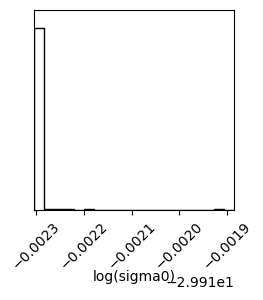

In [60]:
flat_samples = sampler.get_chain(flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=['log(sigma0)'])

In [61]:
np.median(samples)

-29.912299831693367